# PART A

In [52]:
!pip install transformers accelerate --quiet
!pip install nltk rouge-score
import torch
from transformers import AutoProcessor,AutoModelForVision2Seq,ViTImageProcessor
from PIL import Image
import os
import pandas as pd
from tqdm import tqdm
from IPython.display import Image as IPImage,display
import re
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# SmolVLM Model

In [194]:
def zero_shot_captioning(image_path:str,model,processor) -> str:

     image=Image.open(image_path).convert("RGB")

     messages=[
         {
             "role":"user",
             "content":[
                 {"type":"image"},
                 {"type":"text","text":"Describe this image"}
             ]
         }
     ]

     prompt=processor.apply_chat_template(messages,add_generation_prompt=False)
     inputs=processor(text=prompt,images=[image],return_tensors="pt").to(DEVICE)

     with torch.no_grad():
         generated_ids=model.generate(**inputs,max_new_tokens=150)

     generated_text=processor.batch_decode(generated_ids,skip_special_tokens=True)[0]

     return generated_text

In [195]:
DEVICE ="cuda" if torch.cuda.is_available() else "cpu"
model_id="HuggingFaceTB/SmolVLM-Instruct"

processor=AutoProcessor.from_pretrained(model_id)

model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager"
).to(DEVICE)


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/429 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [197]:
csv_path="/kaggle/input/dl-assign-2/custom_captions_dataset/test.csv"

df_test=pd.read_csv(csv_path)

df_test['filepath']=df_test['filename'].apply(
    lambda x:f"/kaggle/input/dl-assign-2/custom_captions_dataset/test/{x}"
)

df_test.head()
generated_captions=[]
for image_path in tqdm(df_test['filepath']):
    caption=zero_shot_captioning(image_path,model,processor)
    generated_captions.append(caption)

df_test['generated_caption']=generated_captions

df_test.head()

df_test.to_csv("/SmolVLM_captions.csv",index=False)

100%|██████████| 928/928 [1:47:45<00:00,  6.97s/it]


In [207]:
print(df_test['generated_caption'])
print(df_test['generated_caption'][0])

0      User:<image>Describe this image\n\nThe image d...
1      User:<image>Describe this image\n\nThe image d...
2      User:<image>Describe this image\n\nThe image d...
3      User:<image>Describe this image\n\nThe image d...
4      User:<image>Describe this image\n\nThe image d...
                             ...                        
923    User:<image>Describe this image\n\nThis image ...
924    User:<image>Describe this image\n\nThe image d...
925    User:<image>Describe this image\n\nThis image ...
926    User:<image>Describe this image\n\nThis image ...
927    User:<image>Describe this image\n\nThe image d...
Name: generated_caption, Length: 928, dtype: object
User:<image>Describe this image

The image depicts a modern, spacious building with a flat roof and a large, flat facade. The building is constructed with a combination of glass and metal, giving it a sleek and contemporary appearance. The facade is divided into multiple horizontal sections, each with a different patter

In [199]:
def clean_caption(text):
    cleaned=re.sub(r"User:<image>Describe this image[\n]*","",text)
    return cleaned.strip()
def evaluate_SmolVLM_model(gen_caption):
    df=pd.read_csv("/kaggle/working/SmolVLM_captions.csv")
    df["clean_generated_caption"]=df[gen_caption].apply(clean_caption)

    smoothie=SmoothingFunction().method4
    rouge=rouge_scorer.RougeScorer(['rougeL'],use_stemmer=True)

    bleu_scores=[]
    meteor_scores=[]
    rouge_scores=[]

    for i,row in tqdm(df.iterrows(),total=len(df)):
        Reference=row['caption']
        generated=row['clean_generated_caption']


        bleu_score=sentence_bleu([Reference.split()],generated.split(),smoothing_function=smoothie)
        bleu_scores.append(bleu_score)

        meteor_score=single_meteor_score(Reference.split(),generated.split())
        meteor_scores.append(meteor_score)

        rouge_l=rouge.score(Reference,generated)['rougeL'].fmeasure
        rouge_scores.append(rouge_l)

    df["BLEU_Score"]=bleu_scores
    df["METEOR_Score"]=meteor_scores
    df["ROUGE_Score"]=rouge_scores
    df["Model"] = "SmolVLM"

    df.head()

    df.to_csv(f"/kaggle/working/generated_test_scores_{gen_caption}.csv",index=False)

    print("Average Evaluation scores:\n")
    print(f"BLEU Score: {df['BLEU_Score'].mean()}")
    print(f"METEOR Score: {df['METEOR_Score'].mean()}")
    print(f"ROUGE Score: {df['ROUGE_Score'].mean()}")
    return {
      "BLEU":df['BLEU_Score'].mean(),
      "METEOR":df['METEOR_Score'].mean(),
      "ROUGE-L":df['ROUGE_Score'].mean()
    }

In [206]:
SmolVLM_scores_before_masking = evaluate_SmolVLM_model('generated_caption')
print(SmolVLM_scores_before_masking)

100%|██████████| 928/928 [00:10<00:00, 85.19it/s] 


Average Evaluation scores:

BLEU Score: 0.03339662115880997
METEOR Score: 0.25940487776059135
ROUGE Score: 0.2292868069308827
{'BLEU': 0.03339662115880997, 'METEOR': 0.25940487776059135, 'ROUGE-L': 0.2292868069308827}


# Custom Model

In [64]:
!pip uninstall -y transformers
!pip install --no-cache-dir transformers accelerate timm --upgrade
!pip install transformers
!pip install sentencepiece
!pip install torch torchvision
!pip install pillow
!pip install -U transformers
!pip install evaluate
!pip install rouge_score
!pip install nltk
from transformers import AutoProcessor, AutoModelForVision2Seq, ViTModel, GPT2LMHeadModel, GPT2Tokenizer, ViTImageProcessor, get_linear_schedule_with_warmup
import torch
from torch.optim import AdamW
import torch.nn as nn
from PIL import Image
import os
import json
from tqdm import tqdm
import pandas as pd
import nltk
import numpy as np
import evaluate
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import csv

# Download required NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Found existing installation: transformers 4.51.2
Uninstalling transformers-4.51.2:
  Successfully uninstalled transformers-4.51.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 241.3 MB/s eta 0:00:00 0:00:01


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [65]:
class ImageCaptionDataset(Dataset):
    def __init__(self, data_table, image_folder, text_tokenizer, vit_processor, max_tokens=32):
        """
        data_table: pandas DataFrame with 'filename' and 'caption'
        image_folder: Directory containing image files
        text_tokenizer: Tokenizer for captions (e.g., GPT2 tokenizer)
        vit_processor: Feature extractor for ViT model
        """
        self.entries = data_table
        self.image_folder = image_folder
        self.tokenizer = text_tokenizer
        self.processor = vit_processor
        self.max_len = max_tokens

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, index):
        item = self.entries.iloc[index]
        img_file = os.path.join(self.image_folder, item['filename'])
        text_caption = item['caption']

        # Load and preprocess image
        img = Image.open(img_file).convert("RGB")
        img_tensor = self.processor(images=img, return_tensors="pt")['pixel_values'].squeeze(0)

        # Tokenize the caption
        encoded = self.tokenizer(
            text_caption,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        token_ids = encoded['input_ids'].squeeze(0)
        attn_mask = encoded['attention_mask'].squeeze(0)

        # Clone input_ids and mask out padding for loss calculation
        label_ids = token_ids.clone()
        label_ids[label_ids == self.tokenizer.pad_token_id] = -100

        return {
            'pixel_values': img_tensor,
            'input_ids': token_ids,
            'attention_mask': attn_mask,
            'labels': label_ids
        }


In [89]:
class ImageCaptionModel(nn.Module):
    def __init__(self, vit_model="WinKawaks/vit-small-patch16-224", gpt2_model="gpt2"):
        super(ImageCaptionModel, self).__init__()

        # Device setup
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Load pretrained ViT encoder and GPT2 decoder
        self.visual_encoder = ViTModel.from_pretrained(vit_model)
        self.text_decoder = GPT2LMHeadModel.from_pretrained(gpt2_model)

        # Map encoder output (CLS token) to decoder hidden size
        self.bridge_layer = nn.Linear(
            self.visual_encoder.config.hidden_size,
            self.text_decoder.config.n_embd
        )

    def forward(self, pixel_inputs, decoder_input_ids, decoder_labels=None):
        # Extract image features (ViT CLS token output)
        vision_output = self.visual_encoder(pixel_values=pixel_inputs)
        cls_vector = vision_output.last_hidden_state[:, 0, :]  # CLS token
        mapped_vector = self.bridge_layer(cls_vector).unsqueeze(1)  # (B, 1, hidden_dim)

        # Token embedding lookup for GPT2
        token_embeddings = self.text_decoder.transformer.wte(decoder_input_ids)

        # Combine image embedding and token embeddings as input to decoder
        decoder_inputs = torch.cat([mapped_vector, token_embeddings], dim=1)

        # Pad label tensor to match prefix (avoid computing loss on prefix)
        if decoder_labels is not None:
            ignore_prefix = torch.full(
                (decoder_labels.size(0), 1), -100, dtype=torch.long, device=decoder_labels.device
            )
            decoder_labels = torch.cat([ignore_prefix, decoder_labels], dim=1)

        # Forward pass through decoder
        decoder_outputs = self.text_decoder(
            inputs_embeds=decoder_inputs,
            labels=decoder_labels,
            return_dict=True
        )

        return decoder_outputs


In [88]:
from transformers import get_linear_schedule_with_warmup

def train_model(model, loader, optim, loss_fn, device, num_epochs):
    model = model.to(device)
    model.train()

    # Scheduler for linear warmup and decay
    warmup_steps = 100
    total_iters = len(loader) * num_epochs
    lr_scheduler = get_linear_schedule_with_warmup(
        optim,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_iters
    )

    for ep in range(num_epochs):
        running_loss = 0.0
        loop = tqdm(loader, desc=f"Training Epoch {ep+1}/{num_epochs}")

        for step, batch in enumerate(loop):
            pixel_inputs = batch['pixel_values'].to(device)
            token_inputs = batch['input_ids'].to(device)
            target_labels = batch['labels'].to(device)

            optim.zero_grad()

            # Forward through encoder-decoder model
            result = model(pixel_inputs=pixel_inputs, decoder_input_ids=token_inputs, decoder_labels=target_labels)
            batch_loss = result.loss

            # Backpropagation and optimizer update
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optim.step()
            lr_scheduler.step()

            running_loss += batch_loss.item()
            loop.set_postfix(current_loss=batch_loss.item())

        mean_loss = running_loss / len(loader)
        print(f"[Epoch {ep+1}] Mean Training Loss: {mean_loss:.4f}")


In [87]:
def generate_caption(model, image_path, tokenizer, processor, device, max_length=50):
    model.eval()
    model.to(device)

    
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = processor(images=img, return_tensors="pt")['pixel_values'].to(device)

    with torch.no_grad():
        # Get CLS token embedding from ViT encoder
        vision_output = model.visual_encoder(pixel_values=img_tensor)
        cls_token = vision_output.last_hidden_state[:, 0, :]
        img_prefix = model.bridge_layer(cls_token).unsqueeze(1)

        # Begin decoding with BOS token
        generated = [tokenizer.bos_token_id]

        for _ in range(max_length):
            decoder_input = torch.tensor([generated], device=device)
            embedded = model.text_decoder.transformer.wte(decoder_input)

            # Combine image prefix + caption tokens
            combined_input = torch.cat((img_prefix, embedded), dim=1)
            logits = model.text_decoder(inputs_embeds=combined_input).logits

            next_token = torch.argmax(logits[:, -1, :], dim=-1).item()
            if next_token == tokenizer.eos_token_id:
                break
            generated.append(next_token)

    return tokenizer.decode(generated, skip_special_tokens=True)
def generate_captions(model, tokenizer, processor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_images_path = "/kaggle/input/dl-assign-2/custom_captions_dataset/test"
    results = {}

    # Loop through test directory
    for file in tqdm(os.listdir(test_images_path), desc="Generating Captions"):
        if file.lower().endswith(".jpg"):
            full_path = os.path.join(test_images_path, file)
            caption = generate_caption(model, full_path, tokenizer, processor, device)
            results[file] = caption
            print(f"{file} → {caption}")

    # Save results as JSON
    with open("custom_model_generated_captions.json", "w") as output_file:
        json.dump(results, output_file, indent=2)

    return results


# Training Custom model

In [92]:
training_df = pd.read_csv("/kaggle/input/dl-assign-2/custom_captions_dataset/train.csv")

# Setup tokenizer and image processor
caption_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
caption_tokenizer.pad_token = caption_tokenizer.eos_token
vit_processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

# Build dataset and dataloader
train_set = ImageCaptionDataset(
    training_df,
    image_folder="/kaggle/input/dl-assign-2/custom_captions_dataset/train/",
    text_tokenizer=caption_tokenizer,
    vit_processor=vit_processor
)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)

# Initialize model and training components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
caption_model = ImageCaptionModel().to(device)

# Optimizer setup with weight decay
optimizer = AdamW(
    caption_model.parameters(),
    lr=3e-5,
    weight_decay=0.01
)

# Begin training
train_model(
    model=caption_model,
    loader=train_loader,
    optim=optimizer,
    loss_fn=None,  # handled inside model
    device=device,
    num_epochs=5
)

# Save trained model state
torch.save(caption_model.state_dict(), "custom_image_caption_model.pth")
print("Model training completed and saved to disk.")


Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Training Epoch 1/5: 100%|██████████| 358/358 [01:51<00:00,  3.21it/s, current_loss=2.76]


[Epoch 1] Mean Training Loss: 2.9794


Training Epoch 2/5: 100%|██████████| 358/358 [01:51<00:00,  3.22it/s, current_loss=2.46]


[Epoch 2] Mean Training Loss: 2.4450


Training Epoch 3/5: 100%|██████████| 358/358 [01:51<00:00,  3.22it/s, current_loss=2.27]


[Epoch 3] Mean Training Loss: 2.3220


Training Epoch 4/5: 100%|██████████| 358/358 [01:50<00:00,  3.24it/s, current_loss=1.88]


[Epoch 4] Mean Training Loss: 2.2423


Training Epoch 5/5: 100%|██████████| 358/358 [01:50<00:00,  3.23it/s, current_loss=2.28]


[Epoch 5] Mean Training Loss: 2.1941
Model training completed and saved to disk.


# Evaluate custom model

In [91]:
def evaluate_model(model, dataloader, device):
    import evaluate
    from tqdm import tqdm

    # Load metrics
    metric_bleu = evaluate.load("bleu")
    metric_rouge = evaluate.load("rouge")

    model.to(device)
    model.eval()

    generated_texts = []
    target_texts = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Running Evaluation"):
            images = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"]

            # Store reference captions
            for ref in input_ids:
                ref_text = tokenizer.decode(ref, skip_special_tokens=True)
                target_texts.append([ref_text])  # BLEU expects a list of references

            if isinstance(model, ImageCaptionModel):
                # Inference using custom model
                vit_output = model.visual_encoder(pixel_values=images)
                cls_tokens = vit_output.last_hidden_state[:, 0, :]
                img_embeddings = model.bridge_layer(cls_tokens)

                for i in range(images.size(0)):
                    embedding = img_embeddings[i:i+1]
                    current_ids = [tokenizer.bos_token_id]
                    input_tensor = torch.tensor([current_ids], device=device)

                    for _ in range(50):  # Generation loop
                        prefix = embedding.unsqueeze(1)
                        token_embed = model.text_decoder.transformer.wte(input_tensor)
                        decoder_input = torch.cat([prefix, token_embed], dim=1)

                        logits = model.text_decoder(inputs_embeds=decoder_input).logits
                        next_token = torch.argmax(logits[:, -1, :], dim=-1).item()

                        if next_token == tokenizer.eos_token_id:
                            break

                        current_ids.append(next_token)
                        input_tensor = torch.tensor([current_ids], device=device)

                    final_text = tokenizer.decode(current_ids, skip_special_tokens=True)
                    generated_texts.append(final_text)

    # Metric computation
    bleu_result = metric_bleu.compute(predictions=generated_texts, references=target_texts)
    rouge_result = metric_rouge.compute(predictions=generated_texts, references=[r[0] for r in target_texts])

    # Output result dictionary
    scores = {
        "BLEU": bleu_result["bleu"],
        "ROUGE-L": rouge_result["rougeL"],
    }

    return scores


In [94]:

# Step 1: Model Training (optional if already trained)
print("\nGenerating Captions with Trained Custom Model...")
# Uncomment below to run generation if needed
generated_captions = generate_captions(caption_model, caption_tokenizer, vit_processor)

# Step 2: Load Test Data
print("\nPreparing Test Dataset for Evaluation")
test_data = pd.read_csv("/kaggle/input/dl-assign-2/custom_captions_dataset/test.csv")

test_set = ImageCaptionDataset(
    data_table=test_data,
    image_folder="/kaggle/input/dl-assign-2/custom_captions_dataset/test/",
    text_tokenizer=caption_tokenizer,
    vit_processor=vit_processor
)

test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# Step 3: Evaluate Custom Model
print("\nEvaluating Custom Image Captioning Model (Pre-Occlusion)")
custom_scores_before_masking = evaluate_model(caption_model, test_loader, device)

print("\nEvaluation Metrics for Custom Model:")
print("==================================================")
print(f"BLEU Score   : {custom_scores_before_masking['BLEU']:.4f}")
print(f"ROUGE-L Score: {custom_scores_before_masking['ROUGE-L']:.4f}")
# print(f"METEOR Score : {eval_scores['METEOR']:.4f}")
with open("custom_model_scores.json", "w") as f:
    json.dump(custom_scores_before_masking, f, indent=2)


Generating Captions with Trained Custom Model...


Generating Captions:   0%|          | 1/928 [00:00<07:15,  2.13it/s]

test_262.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating Captions:   0%|          | 2/928 [00:00<07:10,  2.15it/s]

test_422.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a white tennis racket in his hands.


Generating Captions:   0%|          | 3/928 [00:01<07:07,  2.16it/s]

test_636.jpg → A white plate is sitting on a table. There is a white bowl on the table. There is a white plate on the table. There is a white bowl on the table. There is a white bowl on the table. There is a white bowl


Generating Captions:   0%|          | 4/928 [00:01<07:04,  2.18it/s]

test_828.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:   1%|          | 5/928 [00:02<07:07,  2.16it/s]

test_98.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:   1%|          | 6/928 [00:02<07:05,  2.17it/s]

test_385.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:   1%|          | 7/928 [00:03<07:06,  2.16it/s]

test_108.jpg → A bunch of food is sitting on a table. There are bananas, apples, and oranges. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white


Generating Captions:   1%|          | 8/928 [00:03<07:02,  2.18it/s]

test_767.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:   1%|          | 9/928 [00:04<06:59,  2.19it/s]

test_635.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white fence behind him. There


Generating Captions:   1%|          | 10/928 [00:04<07:00,  2.18it/s]

test_694.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:   1%|          | 11/928 [00:05<06:59,  2.18it/s]

test_157.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:   1%|▏         | 12/928 [00:05<07:01,  2.17it/s]

test_240.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a woman standing behind him holding a white umbrella. There is a man


Generating Captions:   1%|▏         | 13/928 [00:06<07:06,  2.14it/s]

test_324.jpg → A man is standing on a train. The train is red and white. The man is wearing a blue shirt and blue jeans. The man is wearing a black jacket. The man is wearing a black hat. The man is wearing a black and white


Generating Captions:   2%|▏         | 14/928 [00:06<07:04,  2.15it/s]

test_683.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:   2%|▏         | 15/928 [00:06<07:01,  2.16it/s]

test_125.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large white building behind the man. There is a large white building behind the man. There is


Generating Captions:   2%|▏         | 16/928 [00:07<07:00,  2.17it/s]

test_739.jpg → This is an image of a cat. The cat is a black and white cat. The cat is sitting on a white table. The cat is sitting on a white table. The cat is sitting on a white chair. The cat is sitting on a


Generating Captions:   2%|▏         | 17/928 [00:07<07:00,  2.17it/s]

test_649.jpg → This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is a light brown color. The frosting is on a white plate. The plate is sitting


Generating Captions:   2%|▏         | 18/928 [00:08<07:00,  2.16it/s]

test_601.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the


Generating Captions:   2%|▏         | 19/928 [00:08<06:59,  2.17it/s]

test_271.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a green grassy area behind the man. There is a green fence behind the man. There


Generating Captions:   2%|▏         | 20/928 [00:09<06:57,  2.18it/s]

test_122.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:   2%|▏         | 21/928 [00:09<07:04,  2.14it/s]

test_100.jpg → A man is standing in a room with a woman. The woman is wearing a black shirt and a black skirt. The man is holding a white cell phone in his hand. The woman is wearing a black hat. The man is wearing a black and


Generating Captions:   2%|▏         | 22/928 [00:10<07:12,  2.09it/s]

test_273.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating Captions:   2%|▏         | 23/928 [00:10<07:08,  2.11it/s]

test_65.jpg → This is a picture of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:   3%|▎         | 24/928 [00:11<07:04,  2.13it/s]

test_922.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie. There


Generating Captions:   3%|▎         | 25/928 [00:11<07:04,  2.12it/s]

test_383.jpg → A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the man. There is a white shelf behind the man. There is a white shelf


Generating Captions:   3%|▎         | 26/928 [00:12<07:00,  2.14it/s]

test_605.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating Captions:   3%|▎         | 27/928 [00:12<06:57,  2.16it/s]

test_446.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a black and white camera. There is a man standing on the skateboard. There is a man in a black shirt and black pants standing


Generating Captions:   3%|▎         | 28/928 [00:12<06:54,  2.17it/s]

test_335.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating Captions:   3%|▎         | 29/928 [00:13<06:59,  2.14it/s]

test_258.jpg → A man is standing on a sidewalk holding a red and white baseball bat. He is wearing a black shirt and black pants. He is holding a white and blue and white striped shirt. There is a man standing behind him holding a white and blue and


Generating Captions:   3%|▎         | 30/928 [00:13<06:55,  2.16it/s]

test_750.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating Captions:   3%|▎         | 31/928 [00:14<06:56,  2.15it/s]

test_345.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:   3%|▎         | 32/928 [00:14<06:58,  2.14it/s]

test_776.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:   4%|▎         | 33/928 [00:15<06:55,  2.15it/s]

test_312.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:   4%|▎         | 34/928 [00:15<07:02,  2.12it/s]

test_799.jpg → A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:   4%|▍         | 35/928 [00:16<06:56,  2.14it/s]

test_218.jpg → A man is standing in front of a large white building. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is


Generating Captions:   4%|▍         | 36/928 [00:16<07:00,  2.12it/s]

test_450.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:   4%|▍         | 37/928 [00:17<06:57,  2.13it/s]

test_687.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white striped shirt


Generating Captions:   4%|▍         | 38/928 [00:17<06:54,  2.15it/s]

test_507.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a black surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating Captions:   4%|▍         | 39/928 [00:18<06:50,  2.16it/s]

test_592.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:   4%|▍         | 40/928 [00:18<06:46,  2.19it/s]

test_923.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:   4%|▍         | 41/928 [00:19<06:42,  2.20it/s]

test_589.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:   5%|▍         | 42/928 [00:19<06:41,  2.21it/s]

test_320.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating Captions:   5%|▍         | 43/928 [00:19<06:39,  2.22it/s]

test_114.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating Captions:   5%|▍         | 44/928 [00:20<06:39,  2.21it/s]

test_314.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man in a white shirt and


Generating Captions:   5%|▍         | 45/928 [00:20<06:38,  2.22it/s]

test_850.jpg → A bunch of bananas are sitting on a table. The bananas are white. The bananas are on a white plate. The plate is white. The bananas are on a white plate. The plate is white. The bananas are on a white plate. The


Generating Captions:   5%|▍         | 46/928 [00:21<06:39,  2.21it/s]

test_64.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white and blue sign on the wall behind him. There is a


Generating Captions:   5%|▌         | 47/928 [00:21<06:39,  2.20it/s]

test_784.jpg → A man is surfing on a wave. He is wearing a black shirt and black shorts. He is also wearing a black helmet. The man is wearing a black and white surfboard. The man is also wearing a black and white surfboard. The


Generating Captions:   5%|▌         | 48/928 [00:22<06:39,  2.20it/s]

test_720.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating Captions:   5%|▌         | 49/928 [00:22<06:40,  2.20it/s]

test_857.jpg → A man is standing in front of a large white building. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him with a black hat on. There is a


Generating Captions:   5%|▌         | 50/928 [00:23<06:39,  2.20it/s]

test_76.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on


Generating Captions:   5%|▌         | 51/928 [00:23<06:43,  2.17it/s]

test_355.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:   6%|▌         | 52/928 [00:23<06:39,  2.19it/s]

test_847.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating Captions:   6%|▌         | 53/928 [00:24<06:41,  2.18it/s]

test_813.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. He is wearing a black helmet and black goggles. He is wearing a black helmet and black pants.


Generating Captions:   6%|▌         | 54/928 [00:24<06:39,  2.19it/s]

test_840.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a


Generating Captions:   6%|▌         | 55/928 [00:25<06:38,  2.19it/s]

test_691.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:   6%|▌         | 56/928 [00:25<06:44,  2.15it/s]

test_543.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:   6%|▌         | 57/928 [00:26<06:42,  2.16it/s]

test_223.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:   6%|▋         | 58/928 [00:26<06:41,  2.17it/s]

test_134.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:   6%|▋         | 59/928 [00:27<06:39,  2.17it/s]

test_532.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating Captions:   6%|▋         | 60/928 [00:27<06:40,  2.16it/s]

test_89.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:   7%|▋         | 61/928 [00:28<06:38,  2.17it/s]

test_169.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:   7%|▋         | 62/928 [00:28<06:37,  2.18it/s]

test_42.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind him. There


Generating Captions:   7%|▋         | 63/928 [00:29<06:35,  2.19it/s]

test_870.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:   7%|▋         | 64/928 [00:29<06:36,  2.18it/s]

test_680.jpg → This is an image of a cat. The cat is a black cat. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is


Generating Captions:   7%|▋         | 65/928 [00:29<06:34,  2.19it/s]

test_914.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a cell phone in his hand. The man is wearing a black hat. The man is wearing a black shirt.


Generating Captions:   7%|▋         | 66/928 [00:30<06:36,  2.18it/s]

test_183.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind him. There is a white fence behind him. There is a white fence behind him. There


Generating Captions:   7%|▋         | 67/928 [00:30<06:38,  2.16it/s]

test_529.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white and blue flag on the beach. There is a white and blue boat in the water


Generating Captions:   7%|▋         | 68/928 [00:31<06:37,  2.17it/s]

test_235.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating Captions:   7%|▋         | 69/928 [00:31<06:36,  2.17it/s]

test_319.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white fence behind the man. There


Generating Captions:   8%|▊         | 70/928 [00:32<06:35,  2.17it/s]

test_563.jpg → A man is riding a motorcycle on a paved road. The motorcycle is red and has a black handlebar. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing


Generating Captions:   8%|▊         | 71/928 [00:32<06:31,  2.19it/s]

test_893.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a white line in the sand behind him. There is a white building behind him. There is a white building


Generating Captions:   8%|▊         | 72/928 [00:33<06:30,  2.19it/s]

test_466.jpg → A man is standing in front of a large white table. There is a large white bowl on the table. There is a white bowl on the table next to the man. There is a white bowl on the table next to the man. There is


Generating Captions:   8%|▊         | 73/928 [00:33<06:28,  2.20it/s]

test_469.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:   8%|▊         | 74/928 [00:34<06:27,  2.20it/s]

test_91.jpg → A man is standing on a tennis court. He is wearing a white shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:   8%|▊         | 75/928 [00:34<06:26,  2.20it/s]

test_5.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating Captions:   8%|▊         | 76/928 [00:35<06:26,  2.21it/s]

test_864.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:   8%|▊         | 77/928 [00:35<06:26,  2.20it/s]

test_34.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating Captions:   8%|▊         | 78/928 [00:35<06:36,  2.14it/s]

test_420.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating Captions:   9%|▊         | 79/928 [00:36<06:33,  2.16it/s]

test_85.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:   9%|▊         | 80/928 [00:36<06:28,  2.18it/s]

test_25.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:   9%|▊         | 81/928 [00:37<06:29,  2.18it/s]

test_782.jpg → A man is standing on a tennis court. He is wearing a white shirt and blue shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and blue jeans. He is holding a white and red


Generating Captions:   9%|▉         | 82/928 [00:37<06:27,  2.18it/s]

test_343.jpg → A man is standing in front of a wall. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white building behind him. There is a white building behind


Generating Captions:   9%|▉         | 83/928 [00:38<06:26,  2.19it/s]

test_263.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating Captions:   9%|▉         | 84/928 [00:38<06:25,  2.19it/s]

test_394.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating Captions:   9%|▉         | 85/928 [00:39<06:25,  2.19it/s]

test_881.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:   9%|▉         | 86/928 [00:39<06:25,  2.18it/s]

test_307.jpg → A man is standing on a paved road. He is wearing a black jacket and a black helmet. He is holding a white and red kite. The man is wearing a black helmet and a black helmet. The man is wearing a black and white


Generating Captions:   9%|▉         | 87/928 [00:40<06:24,  2.19it/s]

test_22.jpg → A large airplane is sitting on a runway. The plane is white and has a black tail. The tail is black and has a white stripe down the middle. The wings are black and have a white stripe down the middle. The tail is white and


Generating Captions:   9%|▉         | 88/928 [00:40<06:23,  2.19it/s]

test_685.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white and black skateboard in front of him. There is a white and black skateboard behind


Generating Captions:  10%|▉         | 89/928 [00:40<06:22,  2.19it/s]

test_265.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the bench. There is a white sign on the wall behind the bench. There is


Generating Captions:  10%|▉         | 90/928 [00:41<06:24,  2.18it/s]

test_760.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black and white striped shirt. He is holding a black and white Frisbee. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  10%|▉         | 91/928 [00:41<06:35,  2.12it/s]

test_463.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating Captions:  10%|▉         | 92/928 [00:42<06:32,  2.13it/s]

test_673.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a blue and white sign on the side of the beach. There is a


Generating Captions:  10%|█         | 93/928 [00:42<06:29,  2.14it/s]

test_503.jpg → A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird flying in the air. There is a large tree behind the man.


Generating Captions:  10%|█         | 94/928 [00:43<06:26,  2.16it/s]

test_59.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a white sign on the sidewalk. There is a white building behind the man. There is a white building behind


Generating Captions:  10%|█         | 95/928 [00:43<06:23,  2.17it/s]

test_23.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him.


Generating Captions:  10%|█         | 96/928 [00:44<06:22,  2.17it/s]

test_275.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating Captions:  10%|█         | 97/928 [00:44<06:23,  2.17it/s]

test_524.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the bench. There


Generating Captions:  11%|█         | 98/928 [00:45<06:21,  2.17it/s]

test_918.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating Captions:  11%|█         | 99/928 [00:45<06:24,  2.15it/s]

test_454.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  11%|█         | 100/928 [00:46<06:31,  2.12it/s]

test_373.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:  11%|█         | 101/928 [00:46<06:32,  2.11it/s]

test_647.jpg → A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white purse. The woman is wearing a black hat. The woman is wearing a black and white striped shirt.


Generating Captions:  11%|█         | 102/928 [00:47<06:27,  2.13it/s]

test_423.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a black and white striped umbrella. There is a white fence behind the bench. There is a white and blue sign on the fence. There


Generating Captions:  11%|█         | 103/928 [00:47<06:26,  2.13it/s]

test_274.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There is a


Generating Captions:  11%|█         | 104/928 [00:47<06:24,  2.15it/s]

test_867.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white and red cell phone. There is a white wall behind the bench. There is a white fence behind the bench. There is a


Generating Captions:  11%|█▏        | 105/928 [00:48<06:21,  2.16it/s]

test_637.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  11%|█▏        | 106/928 [00:48<06:19,  2.17it/s]

test_811.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:  12%|█▏        | 107/928 [00:49<06:18,  2.17it/s]

test_236.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. There is a white fence behind the man


Generating Captions:  12%|█▏        | 108/928 [00:49<06:16,  2.18it/s]

test_803.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a blue and white striped shirt. The man is wearing a blue and white striped tie.


Generating Captions:  12%|█▏        | 109/928 [00:50<06:16,  2.18it/s]

test_341.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  12%|█▏        | 110/928 [00:50<06:15,  2.18it/s]

test_815.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a white and black phone in his hand. There is a white and black skateboard in front


Generating Captions:  12%|█▏        | 111/928 [00:51<06:14,  2.18it/s]

test_798.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating Captions:  12%|█▏        | 112/928 [00:51<06:15,  2.17it/s]

test_425.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating Captions:  12%|█▏        | 113/928 [00:52<06:13,  2.18it/s]

test_90.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  12%|█▏        | 114/928 [00:52<06:12,  2.18it/s]

test_7.jpg → A man is standing in a room with a large white suitcase. The suitcase is white and has a black handle. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black hat


Generating Captions:  12%|█▏        | 115/928 [00:53<06:11,  2.19it/s]

test_625.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  12%|█▎        | 116/928 [00:53<06:11,  2.19it/s]

test_708.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  13%|█▎        | 117/928 [00:53<06:09,  2.19it/s]

test_397.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a


Generating Captions:  13%|█▎        | 118/928 [00:54<06:10,  2.19it/s]

test_212.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating Captions:  13%|█▎        | 119/928 [00:54<06:09,  2.19it/s]

test_488.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black and white striped shirt.


Generating Captions:  13%|█▎        | 120/928 [00:55<06:10,  2.18it/s]

test_698.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating Captions:  13%|█▎        | 121/928 [00:55<06:16,  2.14it/s]

test_821.jpg → A man is standing on a bench. He is wearing a black shirt and a black pants. He is holding a black and white tennis racket in his right hand. He is holding a black and white tennis racket in his left hand. He is wearing


Generating Captions:  13%|█▎        | 122/928 [00:56<06:13,  2.16it/s]

test_692.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  13%|█▎        | 123/928 [00:56<06:11,  2.17it/s]

test_363.jpg → A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating Captions:  13%|█▎        | 124/928 [00:57<06:09,  2.18it/s]

test_791.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a tree behind the man. There is


Generating Captions:  13%|█▎        | 125/928 [00:57<06:10,  2.17it/s]

test_734.jpg → A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  14%|█▎        | 126/928 [00:58<06:08,  2.18it/s]

test_28.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is very thin. The crust is very thin. The crust is very thin. The crust is very


Generating Captions:  14%|█▎        | 127/928 [00:58<06:06,  2.18it/s]

test_660.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating Captions:  14%|█▍        | 128/928 [00:58<06:05,  2.19it/s]

test_534.jpg → A man is standing in a bathroom. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  14%|█▍        | 129/928 [00:59<06:05,  2.19it/s]

test_536.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating Captions:  14%|█▍        | 130/928 [00:59<06:02,  2.20it/s]

test_848.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white fence behind the man. There is


Generating Captions:  14%|█▍        | 131/928 [01:00<06:00,  2.21it/s]

test_17.jpg → A bathroom is in a bathroom. The bathroom is white. The toilet is white. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is


Generating Captions:  14%|█▍        | 132/928 [01:00<05:59,  2.22it/s]

test_213.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:  14%|█▍        | 133/928 [01:01<05:58,  2.22it/s]

test_763.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:  14%|█▍        | 134/928 [01:01<05:58,  2.21it/s]

test_49.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  15%|█▍        | 135/928 [01:02<06:07,  2.16it/s]

test_387.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  15%|█▍        | 136/928 [01:02<06:03,  2.18it/s]

test_80.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the bench. There is a white sign on the


Generating Captions:  15%|█▍        | 137/928 [01:03<05:59,  2.20it/s]

test_738.jpg → A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:  15%|█▍        | 138/928 [01:03<05:58,  2.20it/s]

test_390.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  15%|█▍        | 139/928 [01:03<05:59,  2.20it/s]

test_430.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating Captions:  15%|█▌        | 140/928 [01:04<05:59,  2.19it/s]

test_9.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a white wall behind him. There is a white and black pole next to the man. There is a


Generating Captions:  15%|█▌        | 141/928 [01:04<05:58,  2.20it/s]

test_260.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  15%|█▌        | 142/928 [01:05<05:58,  2.19it/s]

test_95.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  15%|█▌        | 143/928 [01:05<06:05,  2.15it/s]

test_50.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating Captions:  16%|█▌        | 144/928 [01:06<06:03,  2.15it/s]

test_693.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  16%|█▌        | 145/928 [01:06<06:01,  2.16it/s]

test_193.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  16%|█▌        | 146/928 [01:07<05:59,  2.17it/s]

test_551.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating Captions:  16%|█▌        | 147/928 [01:07<05:58,  2.18it/s]

test_243.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of the man. There is a white table cloth on the table. There is a white table cloth on


Generating Captions:  16%|█▌        | 148/928 [01:08<05:56,  2.19it/s]

test_873.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating Captions:  16%|█▌        | 149/928 [01:08<05:55,  2.19it/s]

test_751.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing behind him. There is a large white building behind the man. There is


Generating Captions:  16%|█▌        | 150/928 [01:09<05:54,  2.20it/s]

test_115.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating Captions:  16%|█▋        | 151/928 [01:09<05:52,  2.20it/s]

test_348.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating Captions:  16%|█▋        | 152/928 [01:09<05:52,  2.20it/s]

test_112.jpg → A man is standing on a train. The man is wearing a blue shirt and blue jeans. The man is wearing a black jacket. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:  16%|█▋        | 153/928 [01:10<05:51,  2.21it/s]

test_54.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and red umbrella. There is a man standing on the skateboard. There is a man standing on the sidewalk. There is a


Generating Captions:  17%|█▋        | 154/928 [01:10<05:50,  2.21it/s]

test_331.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating Captions:  17%|█▋        | 155/928 [01:11<05:51,  2.20it/s]

test_644.jpg → A man is standing on a tennis court. He is wearing a white shirt and blue shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and blue jeans. He is holding a white and red


Generating Captions:  17%|█▋        | 156/928 [01:11<05:51,  2.20it/s]

test_854.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  17%|█▋        | 157/928 [01:12<05:50,  2.20it/s]

test_118.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white couch in front of him. There is a white wall behind him. There is a white couch next to the bench. There is a white


Generating Captions:  17%|█▋        | 158/928 [01:12<05:50,  2.20it/s]

test_561.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  17%|█▋        | 159/928 [01:13<05:49,  2.20it/s]

test_326.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white table in front of the bench.


Generating Captions:  17%|█▋        | 160/928 [01:13<05:59,  2.14it/s]

test_824.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating Captions:  17%|█▋        | 161/928 [01:14<05:57,  2.15it/s]

test_225.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  17%|█▋        | 162/928 [01:14<05:57,  2.14it/s]

test_656.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a man standing next to him. The man is wearing a black shirt and blue shorts. There is


Generating Captions:  18%|█▊        | 163/928 [01:15<05:58,  2.13it/s]

test_286.jpg → A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and black pants. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black hat


Generating Captions:  18%|█▊        | 164/928 [01:15<05:56,  2.14it/s]

test_658.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white building behind him. There is a white fence behind the man. There is a


Generating Captions:  18%|█▊        | 165/928 [01:15<06:02,  2.11it/s]

test_211.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  18%|█▊        | 166/928 [01:16<05:56,  2.14it/s]

test_669.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  18%|█▊        | 167/928 [01:16<05:53,  2.16it/s]

test_182.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a tree behind the bench. There is a large tree behind the bench. There is a large white fence


Generating Captions:  18%|█▊        | 168/928 [01:17<05:50,  2.17it/s]

test_36.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next


Generating Captions:  18%|█▊        | 169/928 [01:17<05:48,  2.18it/s]

test_82.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large tree behind him. There is a large hill behind him. There is a


Generating Captions:  18%|█▊        | 170/928 [01:18<05:47,  2.18it/s]

test_581.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating Captions:  18%|█▊        | 171/928 [01:18<05:46,  2.19it/s]

test_549.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white clock on the wall behind him. There is a white and black clock on the bench. There is


Generating Captions:  19%|█▊        | 172/928 [01:19<05:45,  2.19it/s]

test_391.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  19%|█▊        | 173/928 [01:19<05:43,  2.20it/s]

test_257.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  19%|█▉        | 174/928 [01:20<05:42,  2.20it/s]

test_299.jpg → A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a skateboard in his right hand. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black


Generating Captions:  19%|█▉        | 175/928 [01:20<05:41,  2.20it/s]

test_18.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  19%|█▉        | 176/928 [01:20<05:40,  2.21it/s]

test_43.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  19%|█▉        | 177/928 [01:21<05:40,  2.21it/s]

test_379.jpg → This is an image of a pizza. The pizza is on a white plate. The pizza has a white crust. The crust is brown. The pizza has a white sauce. The sauce is on a white sauce pan. The sauce is on a white


Generating Captions:  19%|█▉        | 178/928 [01:21<05:39,  2.21it/s]

test_27.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a blue and white striped shirt.


Generating Captions:  19%|█▉        | 179/928 [01:22<05:38,  2.21it/s]

test_853.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  19%|█▉        | 180/928 [01:22<05:39,  2.20it/s]

test_594.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants


Generating Captions:  20%|█▉        | 181/928 [01:23<05:41,  2.19it/s]

test_608.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating Captions:  20%|█▉        | 182/928 [01:23<05:40,  2.19it/s]

test_289.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone. There is a man standing next to him. There is a man wearing a black shirt and a black hat. There


Generating Captions:  20%|█▉        | 183/928 [01:24<05:38,  2.20it/s]

test_347.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black skateboard. There is a man standing behind him. There is a man in a white shirt and black pants standing behind him. There


Generating Captions:  20%|█▉        | 184/928 [01:24<05:38,  2.20it/s]

test_219.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating Captions:  20%|█▉        | 185/928 [01:25<05:37,  2.20it/s]

test_573.jpg → A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  20%|██        | 186/928 [01:25<05:36,  2.20it/s]

test_378.jpg → A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue bird perched on the fence


Generating Captions:  20%|██        | 187/928 [01:25<05:41,  2.17it/s]

test_645.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white dog. The dog is a black and white dog. The man is wearing a black hat. The man is wearing a black


Generating Captions:  20%|██        | 188/928 [01:26<05:39,  2.18it/s]

test_535.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  20%|██        | 189/928 [01:26<05:37,  2.19it/s]

test_817.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind him. There is a white fence behind him. There is a white pole next to


Generating Captions:  20%|██        | 190/928 [01:27<05:37,  2.19it/s]

test_759.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:  21%|██        | 191/928 [01:27<05:36,  2.19it/s]

test_493.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet on his head. The man is wearing a black and white striped


Generating Captions:  21%|██        | 192/928 [01:28<05:35,  2.19it/s]

test_298.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the man. There is a white sign on the fence. There is a white sign on the


Generating Captions:  21%|██        | 193/928 [01:28<05:34,  2.20it/s]

test_61.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:  21%|██        | 194/928 [01:29<05:34,  2.19it/s]

test_259.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white tennis racket in his right hand. He is wearing a black and white striped shirt and black pants. There is a red


Generating Captions:  21%|██        | 195/928 [01:29<05:34,  2.19it/s]

test_665.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is wearing


Generating Captions:  21%|██        | 196/928 [01:30<05:33,  2.19it/s]

test_709.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  21%|██        | 197/928 [01:30<05:34,  2.19it/s]

test_123.jpg → A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating Captions:  21%|██▏       | 198/928 [01:30<05:33,  2.19it/s]

test_197.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  21%|██▏       | 199/928 [01:31<05:32,  2.20it/s]

test_35.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the pole next to the sidewalk. There is a


Generating Captions:  22%|██▏       | 200/928 [01:31<05:31,  2.20it/s]

test_670.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  22%|██▏       | 201/928 [01:32<05:31,  2.19it/s]

test_689.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man wearing a black shirt and black


Generating Captions:  22%|██▏       | 202/928 [01:32<05:30,  2.20it/s]

test_132.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white skateboard. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next


Generating Captions:  22%|██▏       | 203/928 [01:33<05:28,  2.21it/s]

test_350.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating Captions:  22%|██▏       | 204/928 [01:33<05:29,  2.20it/s]

test_654.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating Captions:  22%|██▏       | 205/928 [01:34<05:28,  2.20it/s]

test_377.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hand. There is a white sign on the side of the beach. There is a white sign on the side of


Generating Captions:  22%|██▏       | 206/928 [01:34<05:34,  2.16it/s]

test_582.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large brown bird in the distance. There is a large brown tree


Generating Captions:  22%|██▏       | 207/928 [01:35<05:32,  2.17it/s]

test_758.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  22%|██▏       | 208/928 [01:35<05:32,  2.17it/s]

test_8.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black skateboard in his hand. He is wearing a black helmet on his head. He is wearing a black helmet on his head. There


Generating Captions:  23%|██▎       | 209/928 [01:36<05:35,  2.14it/s]

test_147.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating Captions:  23%|██▎       | 210/928 [01:36<05:35,  2.14it/s]

test_638.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating Captions:  23%|██▎       | 211/928 [01:36<05:32,  2.15it/s]

test_83.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue telephone in front of him.


Generating Captions:  23%|██▎       | 212/928 [01:37<05:31,  2.16it/s]

test_180.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a man standing on the beach. There is a large


Generating Captions:  23%|██▎       | 213/928 [01:37<05:30,  2.17it/s]

test_356.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  23%|██▎       | 214/928 [01:38<05:28,  2.17it/s]

test_393.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:  23%|██▎       | 215/928 [01:38<05:27,  2.18it/s]

test_878.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white sign on the bench. There is a white sign on the bench. There is a white


Generating Captions:  23%|██▎       | 216/928 [01:39<05:29,  2.16it/s]

test_366.jpg → A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a person standing behind him. There is a person standing behind him with snowboards in


Generating Captions:  23%|██▎       | 217/928 [01:39<05:28,  2.16it/s]

test_846.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. There is a white wall behind him. There is a white fence behind him. There is a white fence behind


Generating Captions:  23%|██▎       | 218/928 [01:40<05:27,  2.17it/s]

test_677.jpg → A man is standing in front of a large white building. There is a man wearing a black shirt and a black hat. There is a woman wearing a black shirt and a black hat. There is a man wearing a black jacket and a black hat


Generating Captions:  24%|██▎       | 219/928 [01:40<05:25,  2.18it/s]

test_835.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  24%|██▎       | 220/928 [01:41<05:26,  2.17it/s]

test_661.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man in a black shirt and black pants standing behind him


Generating Captions:  24%|██▍       | 221/928 [01:41<05:25,  2.17it/s]

test_421.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  24%|██▍       | 222/928 [01:42<05:24,  2.18it/s]

test_901.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is a


Generating Captions:  24%|██▍       | 223/928 [01:42<05:23,  2.18it/s]

test_578.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. The man is wearing a black shirt and black pants. There is a man standing


Generating Captions:  24%|██▍       | 224/928 [01:42<05:21,  2.19it/s]

test_439.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street.


Generating Captions:  24%|██▍       | 225/928 [01:43<05:21,  2.19it/s]

test_866.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating Captions:  24%|██▍       | 226/928 [01:43<05:20,  2.19it/s]

test_764.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a blue and white sign on the beach. There is a blue and white sign on the side of the beach


Generating Captions:  24%|██▍       | 227/928 [01:44<05:21,  2.18it/s]

test_442.jpg → A white toilet is sitting on a white wall. There is a white toilet seat on the wall behind the toilet. There is a white toilet bowl on the wall behind the toilet. There is a white toilet bowl on the floor next to the toilet.


Generating Captions:  25%|██▍       | 228/928 [01:44<05:22,  2.17it/s]

test_905.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  25%|██▍       | 229/928 [01:45<05:28,  2.13it/s]

test_519.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white Frisbee. The man is wearing a black helmet. The man is wearing a black and white striped shirt


Generating Captions:  25%|██▍       | 230/928 [01:45<05:36,  2.07it/s]

test_205.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a man standing behind him holding a white umbrella. There is a man


Generating Captions:  25%|██▍       | 231/928 [01:46<05:34,  2.08it/s]

test_921.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  25%|██▌       | 232/928 [01:46<05:30,  2.11it/s]

test_633.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree


Generating Captions:  25%|██▌       | 233/928 [01:47<05:24,  2.14it/s]

test_46.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:  25%|██▌       | 234/928 [01:47<05:21,  2.16it/s]

test_461.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  25%|██▌       | 235/928 [01:48<05:19,  2.17it/s]

test_912.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  25%|██▌       | 236/928 [01:48<05:17,  2.18it/s]

test_790.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  26%|██▌       | 237/928 [01:49<05:15,  2.19it/s]

test_146.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating Captions:  26%|██▌       | 238/928 [01:49<05:14,  2.19it/s]

test_15.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  26%|██▌       | 239/928 [01:49<05:14,  2.19it/s]

test_500.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black ski mask on his head. The man is


Generating Captions:  26%|██▌       | 240/928 [01:50<05:13,  2.20it/s]

test_332.jpg → A man is standing on a dirt road. He is wearing a black jacket and a black hat. He is holding a black and white dog. The dog is a black and white dog. The man is wearing a black and white striped shirt. The


Generating Captions:  26%|██▌       | 241/928 [01:50<05:13,  2.19it/s]

test_572.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  26%|██▌       | 242/928 [01:51<05:13,  2.19it/s]

test_775.jpg → A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hand. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating Captions:  26%|██▌       | 243/928 [01:51<05:12,  2.19it/s]

test_728.jpg → A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. There is a large white building behind him. There is a large white building behind him. There is


Generating Captions:  26%|██▋       | 244/928 [01:52<05:12,  2.19it/s]

test_210.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a man standing next to him. There is a red bus on the sidewalk. There is a man standing next


Generating Captions:  26%|██▋       | 245/928 [01:52<05:12,  2.18it/s]

test_339.jpg → A plane is flying in the sky. The plane is white and has a black nose. The plane has a black tail. The plane has a red and white stripe on the tail. The plane has a red and white stripe on the wings. The


Generating Captions:  27%|██▋       | 246/928 [01:53<05:12,  2.18it/s]

test_556.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a large tree behind him. There is a large white fence behind the man. There


Generating Captions:  27%|██▋       | 247/928 [01:53<05:11,  2.19it/s]

test_400.jpg → A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  27%|██▋       | 248/928 [01:54<05:12,  2.18it/s]

test_443.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white surfboard in his hand. There is a white fence behind the man. There is a white building behind the man. There


Generating Captions:  27%|██▋       | 249/928 [01:54<05:11,  2.18it/s]

test_663.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  27%|██▋       | 250/928 [01:54<05:10,  2.19it/s]

test_204.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is holding a white and black tennis racket in his hands. There is a white and black umbrella


Generating Captions:  27%|██▋       | 251/928 [01:55<05:08,  2.19it/s]

test_517.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing on the skateboard. The man is wearing a black hat. There is a man standing on


Generating Captions:  27%|██▋       | 252/928 [01:55<05:14,  2.15it/s]

test_405.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  27%|██▋       | 253/928 [01:56<05:12,  2.16it/s]

test_704.jpg → A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet and a black and white striped shirt. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:  27%|██▋       | 254/928 [01:56<05:10,  2.17it/s]

test_741.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating Captions:  27%|██▋       | 255/928 [01:57<05:11,  2.16it/s]

test_68.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  28%|██▊       | 256/928 [01:57<05:10,  2.17it/s]

test_523.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating Captions:  28%|██▊       | 257/928 [01:58<05:09,  2.17it/s]

test_48.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a red light on the street behind him. There is a red light on the sidewalk next to


Generating Captions:  28%|██▊       | 258/928 [01:58<05:08,  2.17it/s]

test_792.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  28%|██▊       | 259/928 [01:59<05:07,  2.18it/s]

test_604.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  28%|██▊       | 260/928 [01:59<05:06,  2.18it/s]

test_513.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is wearing a black and white striped shirt. There


Generating Captions:  28%|██▊       | 261/928 [02:00<05:05,  2.18it/s]

test_199.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white toilet in front of him. There is a white wall behind him. There is a white shelf behind him. There is a white shelf


Generating Captions:  28%|██▊       | 262/928 [02:00<05:04,  2.19it/s]

test_452.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing next to him. There is a woman standing next to him. There is a man


Generating Captions:  28%|██▊       | 263/928 [02:00<05:04,  2.18it/s]

test_474.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  28%|██▊       | 264/928 [02:01<05:03,  2.19it/s]

test_801.jpg → A man is standing on a sidewalk holding a skateboard. The man is wearing a black shirt and black pants. The man is wearing a black helmet. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  29%|██▊       | 265/928 [02:01<05:05,  2.17it/s]

test_842.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a woman standing on the


Generating Captions:  29%|██▊       | 266/928 [02:02<05:09,  2.14it/s]

test_576.jpg → A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating Captions:  29%|██▉       | 267/928 [02:02<05:06,  2.15it/s]

test_266.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a person standing behind him. There is a person standing behind him. There is snow on


Generating Captions:  29%|██▉       | 268/928 [02:03<05:05,  2.16it/s]

test_470.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a white fence behind him. There is a white and blue boat in the


Generating Captions:  29%|██▉       | 269/928 [02:03<05:03,  2.17it/s]

test_844.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating Captions:  29%|██▉       | 270/928 [02:04<05:01,  2.18it/s]

test_501.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the bench. There is a white toilet in front of the bench. There is a white


Generating Captions:  29%|██▉       | 271/928 [02:04<05:00,  2.19it/s]

test_104.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a man standing on the beach. He is wearing a


Generating Captions:  29%|██▉       | 272/928 [02:05<04:59,  2.19it/s]

test_135.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white fence behind him. There is a white


Generating Captions:  29%|██▉       | 273/928 [02:05<04:58,  2.20it/s]

test_330.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating Captions:  30%|██▉       | 274/928 [02:06<05:02,  2.16it/s]

test_109.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating Captions:  30%|██▉       | 275/928 [02:06<05:01,  2.17it/s]

test_128.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There is


Generating Captions:  30%|██▉       | 276/928 [02:06<05:02,  2.16it/s]

test_877.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  30%|██▉       | 277/928 [02:07<04:59,  2.17it/s]

test_398.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  30%|██▉       | 278/928 [02:07<04:57,  2.19it/s]

test_565.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  30%|███       | 279/928 [02:08<04:56,  2.19it/s]

test_899.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating Captions:  30%|███       | 280/928 [02:08<04:55,  2.19it/s]

test_819.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman


Generating Captions:  30%|███       | 281/928 [02:09<04:55,  2.19it/s]

test_165.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. There is a white fence behind the man. There is a white building behind the man. There is a


Generating Captions:  30%|███       | 282/928 [02:09<04:57,  2.17it/s]

test_539.jpg → A man is standing on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  30%|███       | 283/928 [02:10<04:55,  2.18it/s]

test_156.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  31%|███       | 284/928 [02:10<04:54,  2.19it/s]

test_239.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large amount of dirt on the ground behind him. There is a


Generating Captions:  31%|███       | 285/928 [02:11<04:53,  2.19it/s]

test_716.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white skateboard in his hand. There is a red light on the sidewalk next to the man. There is a red light on the


Generating Captions:  31%|███       | 286/928 [02:11<04:54,  2.18it/s]

test_362.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a tree behind him. There is a large brown tree behind him. There is a small brown tree behind him


Generating Captions:  31%|███       | 287/928 [02:11<04:53,  2.18it/s]

test_472.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  31%|███       | 288/928 [02:12<04:53,  2.18it/s]

test_646.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind him. There is a white fence behind him. There is a white


Generating Captions:  31%|███       | 289/928 [02:12<04:53,  2.18it/s]

test_522.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a black and white striped umbrella. There is a white bird perched on the bench. There is a white fence behind the bench. There is


Generating Captions:  31%|███▏      | 290/928 [02:13<04:53,  2.17it/s]

test_160.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white and black television on the wall behind


Generating Captions:  31%|███▏      | 291/928 [02:13<04:53,  2.17it/s]

test_31.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating Captions:  31%|███▏      | 292/928 [02:14<04:54,  2.16it/s]

test_101.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:  32%|███▏      | 293/928 [02:14<04:58,  2.13it/s]

test_762.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:  32%|███▏      | 294/928 [02:15<04:57,  2.13it/s]

test_650.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and blue frisbee. There is a white fence behind the bench. There is a white and blue fence behind the bench. There


Generating Captions:  32%|███▏      | 295/928 [02:15<05:01,  2.10it/s]

test_883.jpg → A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white cell phone. The woman is wearing a black and white striped shirt. The woman is holding a black and


Generating Captions:  32%|███▏      | 296/928 [02:16<04:57,  2.13it/s]

test_697.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  32%|███▏      | 297/928 [02:16<05:00,  2.10it/s]

test_906.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating Captions:  32%|███▏      | 298/928 [02:17<05:04,  2.07it/s]

test_372.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  32%|███▏      | 299/928 [02:17<05:05,  2.06it/s]

test_552.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree behind the man. There


Generating Captions:  32%|███▏      | 300/928 [02:18<05:01,  2.08it/s]

test_904.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white umbrella. There is


Generating Captions:  32%|███▏      | 301/928 [02:18<04:57,  2.11it/s]

test_902.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white ski board. There is a person standing on the snowboard. There is a person wearing a black helmet on their head. There


Generating Captions:  33%|███▎      | 302/928 [02:19<04:53,  2.14it/s]

test_162.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating Captions:  33%|███▎      | 303/928 [02:19<04:50,  2.15it/s]

test_818.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch in front of the bench.


Generating Captions:  33%|███▎      | 304/928 [02:19<04:48,  2.16it/s]

test_256.jpg → A man is standing on a train. The man is wearing a blue shirt and blue jeans. The man is wearing a black jacket and blue jeans. The man is wearing a black helmet and blue pants. The man is wearing a black and white striped


Generating Captions:  33%|███▎      | 305/928 [02:20<04:46,  2.17it/s]

test_879.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. There is a man standing next to him. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating Captions:  33%|███▎      | 306/928 [02:20<04:44,  2.19it/s]

test_464.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating Captions:  33%|███▎      | 307/928 [02:21<04:42,  2.20it/s]

test_459.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating Captions:  33%|███▎      | 308/928 [02:21<04:41,  2.20it/s]

test_185.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone in his hand. There is a red light on the sidewalk. There is a red light on the sidewalk next to the


Generating Captions:  33%|███▎      | 309/928 [02:22<04:41,  2.20it/s]

test_207.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a white shirt. The man is wearing a white hat. The man is wearing a black hat. The man is wearing


Generating Captions:  33%|███▎      | 310/928 [02:22<04:41,  2.19it/s]

test_862.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  34%|███▎      | 311/928 [02:23<04:41,  2.19it/s]

test_814.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the man. There is a white sign on the fence. There is a white sign on the


Generating Captions:  34%|███▎      | 312/928 [02:23<04:40,  2.19it/s]

test_14.jpg → A man is standing on a beach. He is wearing a blue shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white bird perched on the top


Generating Captions:  34%|███▎      | 313/928 [02:24<04:39,  2.20it/s]

test_655.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  34%|███▍      | 314/928 [02:24<04:38,  2.21it/s]

test_234.jpg → A large herd of elephants is grazing on a grassy field. The elephants are brown and have long necks. The grass is lush and lush. The elephants are standing on a dirt field. The grass is very green and lush. The elephants are standing


Generating Captions:  34%|███▍      | 315/928 [02:24<04:37,  2.21it/s]

test_672.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating Captions:  34%|███▍      | 316/928 [02:25<04:35,  2.22it/s]

test_181.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  34%|███▍      | 317/928 [02:25<04:40,  2.17it/s]

test_688.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating Captions:  34%|███▍      | 318/928 [02:26<04:39,  2.18it/s]

test_66.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  34%|███▍      | 319/928 [02:26<04:38,  2.19it/s]

test_834.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white wall behind him. There is a white couch next to the bench. There is a white couch


Generating Captions:  34%|███▍      | 320/928 [02:27<04:38,  2.19it/s]

test_72.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating Captions:  35%|███▍      | 321/928 [02:27<04:39,  2.17it/s]

test_774.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  35%|███▍      | 322/928 [02:28<04:39,  2.17it/s]

test_482.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  35%|███▍      | 323/928 [02:28<04:37,  2.18it/s]

test_919.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating Captions:  35%|███▍      | 324/928 [02:29<04:37,  2.18it/s]

test_729.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating Captions:  35%|███▌      | 325/928 [02:29<04:36,  2.18it/s]

test_800.jpg → A bathroom is in a bathroom. The bathroom is white and has a white toilet seat. The toilet seat is white and has a white toilet lid. The toilet is white and has a white toilet bowl. The toilet is white and has a white toilet


Generating Captions:  35%|███▌      | 326/928 [02:29<04:35,  2.19it/s]

test_254.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The snow is very cold. The


Generating Captions:  35%|███▌      | 327/928 [02:30<04:35,  2.19it/s]

test_555.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. There is a white and red umbrella in front of him. There is a white and red umbrella next to him


Generating Captions:  35%|███▌      | 328/928 [02:30<04:35,  2.18it/s]

test_247.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white wall behind him. There is a white fence behind him. There is a white and black pole next


Generating Captions:  35%|███▌      | 329/928 [02:31<04:34,  2.18it/s]

test_368.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There


Generating Captions:  36%|███▌      | 330/928 [02:31<04:32,  2.19it/s]

test_571.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating Captions:  36%|███▌      | 331/928 [02:32<04:31,  2.20it/s]

test_431.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating Captions:  36%|███▌      | 332/928 [02:32<04:31,  2.20it/s]

test_882.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and red umbrella. There is a white fence behind the man. There is a white building behind the man. There is a white


Generating Captions:  36%|███▌      | 333/928 [02:33<04:30,  2.20it/s]

test_602.jpg → A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch in front of the man. There is a white wall


Generating Captions:  36%|███▌      | 334/928 [02:33<04:31,  2.19it/s]

test_913.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch in front of the bench. There is a white wall


Generating Captions:  36%|███▌      | 335/928 [02:34<04:30,  2.19it/s]

test_4.jpg → A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating Captions:  36%|███▌      | 336/928 [02:34<04:30,  2.19it/s]

test_662.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating Captions:  36%|███▋      | 337/928 [02:35<04:29,  2.19it/s]

test_542.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating Captions:  36%|███▋      | 338/928 [02:35<04:27,  2.21it/s]

test_253.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black helmet on his head. The


Generating Captions:  37%|███▋      | 339/928 [02:35<04:30,  2.18it/s]

test_606.jpg → A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white cell phone. The woman is wearing a black hat. The woman is wearing a black and white striped shirt


Generating Captions:  37%|███▋      | 340/928 [02:36<04:30,  2.18it/s]

test_483.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white and red cell phone. There is a white and red sign on the bench. There is a white and red sign on the bench


Generating Captions:  37%|███▋      | 341/928 [02:36<04:29,  2.18it/s]

test_629.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black shirt. The man is


Generating Captions:  37%|███▋      | 342/928 [02:37<04:27,  2.19it/s]

test_885.jpg → A man is sitting on a couch. The couch is white. The man is wearing a white shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  37%|███▋      | 343/928 [02:37<04:29,  2.17it/s]

test_217.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating Captions:  37%|███▋      | 344/928 [02:38<04:28,  2.17it/s]

test_471.jpg → A man is standing in front of a white wall. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black shirt


Generating Captions:  37%|███▋      | 345/928 [02:38<04:28,  2.17it/s]

test_865.jpg → A man is standing on a grassy field. He is wearing a white shirt and black pants. He is holding a white and red frisbee. There is a tree behind him. There is a large white fence behind the man. There is


Generating Captions:  37%|███▋      | 346/928 [02:39<04:26,  2.18it/s]

test_780.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating Captions:  37%|███▋      | 347/928 [02:39<04:26,  2.18it/s]

test_294.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black helmet. The man is


Generating Captions:  38%|███▊      | 348/928 [02:40<04:25,  2.18it/s]

test_515.jpg → A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a man standing on the hill with a black umbrella. There is a man standing on


Generating Captions:  38%|███▊      | 349/928 [02:40<04:24,  2.19it/s]

test_478.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  38%|███▊      | 350/928 [02:40<04:24,  2.19it/s]

test_545.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is very thin. The crust is very light brown. The crust is very thin. The crust is


Generating Captions:  38%|███▊      | 351/928 [02:41<04:24,  2.18it/s]

test_141.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating Captions:  38%|███▊      | 352/928 [02:41<04:24,  2.18it/s]

test_896.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black tie. The man is wearing a black hat. The man


Generating Captions:  38%|███▊      | 353/928 [02:42<04:24,  2.17it/s]

test_119.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating Captions:  38%|███▊      | 354/928 [02:42<04:24,  2.17it/s]

test_521.jpg → A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black shirt and a black tie. The man is wearing


Generating Captions:  38%|███▊      | 355/928 [02:43<04:23,  2.17it/s]

test_245.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating Captions:  38%|███▊      | 356/928 [02:43<04:22,  2.18it/s]

test_812.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white surfboard in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating Captions:  38%|███▊      | 357/928 [02:44<04:21,  2.18it/s]

test_408.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a large man standing on the beach. There is a


Generating Captions:  39%|███▊      | 358/928 [02:44<04:22,  2.17it/s]

test_702.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone in his hand. There is a white wall behind him. There is a white and red sign on the wall behind him. There


Generating Captions:  39%|███▊      | 359/928 [02:45<04:21,  2.17it/s]

test_419.jpg → A man is standing in a room. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  39%|███▉      | 360/928 [02:45<04:22,  2.16it/s]

test_678.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  39%|███▉      | 361/928 [02:46<04:25,  2.13it/s]

test_925.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his right hand. The man is wearing a black helmet. The man is wearing a black helmet. The man


Generating Captions:  39%|███▉      | 362/928 [02:46<04:23,  2.15it/s]

test_436.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hand. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:  39%|███▉      | 363/928 [02:46<04:22,  2.15it/s]

test_376.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating Captions:  39%|███▉      | 364/928 [02:47<04:21,  2.16it/s]

test_20.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the fence. There is a white sign on the


Generating Captions:  39%|███▉      | 365/928 [02:47<04:20,  2.16it/s]

test_779.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  39%|███▉      | 366/928 [02:48<04:19,  2.17it/s]

test_222.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white camera. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating Captions:  40%|███▉      | 367/928 [02:48<04:23,  2.13it/s]

test_546.jpg → A man is sitting on a bench. He is wearing a white shirt and a black tie. There is a white couch in front of him. There is a white wall behind him. There is a white couch next to the bench. There is a


Generating Captions:  40%|███▉      | 368/928 [02:49<04:25,  2.11it/s]

test_562.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a black and white skateboard. There is a man standing on the skateboard. There is a man standing on the skateboard. There


Generating Captions:  40%|███▉      | 369/928 [02:49<04:25,  2.10it/s]

test_189.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  40%|███▉      | 370/928 [02:50<04:22,  2.13it/s]

test_333.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is holding a white tennis racket in his hands. There is a white fence behind the man. There


Generating Captions:  40%|███▉      | 371/928 [02:50<04:19,  2.14it/s]

test_520.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  40%|████      | 372/928 [02:51<04:17,  2.16it/s]

test_657.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating Captions:  40%|████      | 373/928 [02:51<04:15,  2.17it/s]

test_142.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating Captions:  40%|████      | 374/928 [02:52<04:14,  2.18it/s]

test_369.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a white building behind him. There is a white fence behind the man. There is a


Generating Captions:  40%|████      | 375/928 [02:52<04:13,  2.18it/s]

test_600.jpg → A man is standing on a beach. He is wearing a blue shirt and a blue and white striped shirt. He is holding a white surfboard in his hand. There is a blue and white striped umbrella in front of the man. There is a


Generating Captions:  41%|████      | 376/928 [02:53<04:12,  2.19it/s]

test_322.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:  41%|████      | 377/928 [02:53<04:12,  2.18it/s]

test_911.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  41%|████      | 378/928 [02:53<04:11,  2.18it/s]

test_69.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  41%|████      | 379/928 [02:54<04:11,  2.19it/s]

test_888.jpg → A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. There is a white fence behind the man


Generating Captions:  41%|████      | 380/928 [02:54<04:10,  2.19it/s]

test_290.jpg → A man is surfing on a wave. The wave is white and has a white and blue background. The man is wearing a blue shirt and blue shorts. The man is also wearing a blue helmet. The man is also wearing a blue and white surf


Generating Captions:  41%|████      | 381/928 [02:55<04:10,  2.19it/s]

test_735.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his hand. The skateboard is black and white. The man is wearing a black helmet. The man is


Generating Captions:  41%|████      | 382/928 [02:55<04:17,  2.12it/s]

test_139.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating Captions:  41%|████▏     | 383/928 [02:56<04:15,  2.14it/s]

test_411.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating Captions:  41%|████▏     | 384/928 [02:56<04:12,  2.15it/s]

test_92.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating Captions:  41%|████▏     | 385/928 [02:57<04:12,  2.15it/s]

test_593.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating Captions:  42%|████▏     | 386/928 [02:57<04:12,  2.14it/s]

test_192.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  42%|████▏     | 387/928 [02:58<04:11,  2.15it/s]

test_351.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating Captions:  42%|████▏     | 388/928 [02:58<04:09,  2.17it/s]

test_467.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing next to him. The man is wearing a black shirt and a black tie


Generating Captions:  42%|████▏     | 389/928 [02:59<04:07,  2.18it/s]

test_154.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  42%|████▏     | 390/928 [02:59<04:06,  2.18it/s]

test_487.jpg → A man is standing on a beach. He is wearing a white shirt and a black jacket. He is holding a white surfboard in his hands. There is a large white bird flying in the air. There is a large tree behind the man.


Generating Captions:  42%|████▏     | 391/928 [02:59<04:05,  2.18it/s]

test_892.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch next to the bench. There is a white wall behind


Generating Captions:  42%|████▏     | 392/928 [03:00<04:05,  2.18it/s]

test_224.jpg → A man is sitting on a bench. He is wearing a white shirt and a black tie. There is a white and red umbrella in front of him. There is a white and red umbrella next to the bench. There is a white and red umbrella


Generating Captions:  42%|████▏     | 393/928 [03:00<04:05,  2.18it/s]

test_783.jpg → A man is standing on a skateboard. The man is wearing a black jacket and black pants. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a black


Generating Captions:  42%|████▏     | 394/928 [03:01<04:04,  2.18it/s]

test_553.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white fence behind the


Generating Captions:  43%|████▎     | 395/928 [03:01<04:04,  2.18it/s]

test_768.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped and black and


Generating Captions:  43%|████▎     | 396/928 [03:02<04:05,  2.17it/s]

test_755.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  43%|████▎     | 397/928 [03:02<04:06,  2.15it/s]

test_33.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree in the water behind the


Generating Captions:  43%|████▎     | 398/928 [03:03<04:06,  2.15it/s]

test_230.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  43%|████▎     | 399/928 [03:03<04:06,  2.15it/s]

test_473.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing behind him. There is a red light on the street behind the man. There is a red


Generating Captions:  43%|████▎     | 400/928 [03:04<04:05,  2.15it/s]

test_506.jpg → A bathroom is in a room. There is a white sink with a white sink. There is a white toilet in the corner of the room. There is a white sink next to the sink. There is a white wall behind the sink. There is


Generating Captions:  43%|████▎     | 401/928 [03:04<04:03,  2.16it/s]

test_451.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white umbrella. There is


Generating Captions:  43%|████▎     | 402/928 [03:05<04:02,  2.17it/s]

test_742.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  43%|████▎     | 403/928 [03:05<04:00,  2.18it/s]

test_415.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  44%|████▎     | 404/928 [03:05<04:04,  2.14it/s]

test_414.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is


Generating Captions:  44%|████▎     | 405/928 [03:06<04:02,  2.16it/s]

test_833.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There


Generating Captions:  44%|████▍     | 406/928 [03:06<03:59,  2.18it/s]

test_686.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  44%|████▍     | 407/928 [03:07<03:58,  2.19it/s]

test_597.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and black pants. There


Generating Captions:  44%|████▍     | 408/928 [03:07<03:56,  2.20it/s]

test_804.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  44%|████▍     | 409/928 [03:08<03:54,  2.21it/s]

test_653.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating Captions:  44%|████▍     | 410/928 [03:08<03:53,  2.22it/s]

test_444.jpg → A white plate is sitting on a table. There is a white bowl on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate


Generating Captions:  44%|████▍     | 411/928 [03:09<03:53,  2.22it/s]

test_778.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  44%|████▍     | 412/928 [03:09<03:52,  2.22it/s]

test_346.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the bench. There is a white sign on the


Generating Captions:  45%|████▍     | 413/928 [03:10<03:53,  2.21it/s]

test_614.jpg → A man is standing on a skateboard. The man is wearing a black shirt and a black helmet. The man is holding a white and blue frisbee. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  45%|████▍     | 414/928 [03:10<03:53,  2.20it/s]

test_785.jpg → A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white couch in front of the wall. There


Generating Captions:  45%|████▍     | 415/928 [03:10<03:54,  2.19it/s]

test_713.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone in his hand. The cell phone is black. The man is wearing a black hat. The man


Generating Captions:  45%|████▍     | 416/928 [03:11<03:54,  2.18it/s]

test_32.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating Captions:  45%|████▍     | 417/928 [03:11<03:55,  2.17it/s]

test_559.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone in his hand. The cell phone is black. The man is wearing a black hat. The man


Generating Captions:  45%|████▌     | 418/928 [03:12<03:54,  2.17it/s]

test_652.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and blue


Generating Captions:  45%|████▌     | 419/928 [03:12<03:54,  2.17it/s]

test_872.jpg → A bathroom is in a bathroom. The bathroom is white and has a white sink. The sink is white and has a white toilet seat. The toilet seat is white and has a white toilet seat. The toilet is white and has a white toilet seat


Generating Captions:  45%|████▌     | 420/928 [03:13<03:54,  2.16it/s]

test_159.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street


Generating Captions:  45%|████▌     | 421/928 [03:13<03:52,  2.18it/s]

test_71.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white tennis


Generating Captions:  45%|████▌     | 422/928 [03:14<03:51,  2.18it/s]

test_145.jpg → A man is standing on a bench holding a white bag. The bag is white. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black


Generating Captions:  46%|████▌     | 423/928 [03:14<03:51,  2.18it/s]

test_187.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  46%|████▌     | 424/928 [03:15<03:50,  2.19it/s]

test_282.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white tennis


Generating Captions:  46%|████▌     | 425/928 [03:15<03:53,  2.15it/s]

test_858.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man wearing a white shirt and black pants. There


Generating Captions:  46%|████▌     | 426/928 [03:16<03:59,  2.10it/s]

test_99.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  46%|████▌     | 427/928 [03:16<03:57,  2.11it/s]

test_198.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  46%|████▌     | 428/928 [03:16<03:54,  2.13it/s]

test_318.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  46%|████▌     | 429/928 [03:17<03:51,  2.15it/s]

test_399.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  46%|████▋     | 430/928 [03:17<03:50,  2.16it/s]

test_255.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a


Generating Captions:  46%|████▋     | 431/928 [03:18<03:48,  2.17it/s]

test_527.jpg → A man is sitting on a couch. The couch is made of wood. The man is wearing a white shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:  47%|████▋     | 432/928 [03:18<03:48,  2.18it/s]

test_590.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hand. He is wearing a black helmet on his head. He is also wearing a black and white striped shirt.


Generating Captions:  47%|████▋     | 433/928 [03:19<03:46,  2.18it/s]

test_756.jpg → A man is standing on a beach. He is wearing a white shirt and a black jacket. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard in front of


Generating Captions:  47%|████▋     | 434/928 [03:19<03:45,  2.19it/s]

test_117.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  47%|████▋     | 435/928 [03:20<03:45,  2.18it/s]

test_209.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a large tree behind him. There is a large white fence behind the man. There


Generating Captions:  47%|████▋     | 436/928 [03:20<03:49,  2.14it/s]

test_743.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a black and white striped leash. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating Captions:  47%|████▋     | 437/928 [03:21<03:51,  2.12it/s]

test_453.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  47%|████▋     | 438/928 [03:21<03:48,  2.14it/s]

test_897.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a woman standing next to him. There is


Generating Captions:  47%|████▋     | 439/928 [03:22<03:46,  2.16it/s]

test_73.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black helmet on his head.


Generating Captions:  47%|████▋     | 440/928 [03:22<03:44,  2.18it/s]

test_296.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  48%|████▊     | 441/928 [03:22<03:43,  2.18it/s]

test_285.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white surfboard in his hand. There is a red sign on the sidewalk. There is a blue sign on the sidewalk. There is


Generating Captions:  48%|████▊     | 442/928 [03:23<03:41,  2.20it/s]

test_786.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  48%|████▊     | 443/928 [03:23<03:39,  2.21it/s]

test_291.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  48%|████▊     | 444/928 [03:24<03:39,  2.20it/s]

test_509.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating Captions:  48%|████▊     | 445/928 [03:24<03:39,  2.20it/s]

test_264.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white striped shirt


Generating Captions:  48%|████▊     | 446/928 [03:25<03:38,  2.20it/s]

test_851.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating Captions:  48%|████▊     | 447/928 [03:25<03:42,  2.16it/s]

test_616.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. He is wearing a black helmet and black goggles. He is wearing a black and white striped shirt.


Generating Captions:  48%|████▊     | 448/928 [03:26<03:41,  2.17it/s]

test_412.jpg → A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating Captions:  48%|████▊     | 449/928 [03:26<03:39,  2.18it/s]

test_928.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  48%|████▊     | 450/928 [03:27<03:39,  2.18it/s]

test_726.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  49%|████▊     | 451/928 [03:27<03:40,  2.17it/s]

test_435.jpg → A man is standing on a beach. He is wearing a blue shirt and a blue and white striped shirt. He is holding a surfboard in his hands. There is a man standing next to him. The man is wearing a blue shirt and a


Generating Captions:  49%|████▊     | 452/928 [03:28<03:39,  2.17it/s]

test_491.jpg → This is an image of a cat. The cat is a black and white striped cat. The cat is sitting on a white table. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera


Generating Captions:  49%|████▉     | 453/928 [03:28<03:38,  2.18it/s]

test_268.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  49%|████▉     | 454/928 [03:28<03:37,  2.18it/s]

test_723.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating Captions:  49%|████▉     | 455/928 [03:29<03:36,  2.18it/s]

test_116.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  49%|████▉     | 456/928 [03:29<03:36,  2.18it/s]

test_830.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch next to the bench. There is


Generating Captions:  49%|████▉     | 457/928 [03:30<03:35,  2.19it/s]

test_53.jpg → A man is sitting on a white table. He is wearing a black shirt and a black tie. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table next to the man


Generating Captions:  49%|████▉     | 458/928 [03:30<03:34,  2.20it/s]

test_434.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white pole next to the bench. There is a white sign on the pole. There is a white sign on


Generating Captions:  49%|████▉     | 459/928 [03:31<03:33,  2.20it/s]

test_732.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  50%|████▉     | 460/928 [03:31<03:32,  2.20it/s]

test_807.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the man. There is a white sign on the fence. There is a white sign on the


Generating Captions:  50%|████▉     | 461/928 [03:32<03:32,  2.20it/s]

test_96.jpg → A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:  50%|████▉     | 462/928 [03:32<03:31,  2.20it/s]

test_917.jpg → A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating Captions:  50%|████▉     | 463/928 [03:33<03:31,  2.19it/s]

test_598.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  50%|█████     | 464/928 [03:33<03:32,  2.18it/s]

test_283.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a white building behind the man. There is a white building behind the


Generating Captions:  50%|█████     | 465/928 [03:33<03:32,  2.18it/s]

test_808.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a white sign on the skateboard. There is a white sign on the skateboard. There


Generating Captions:  50%|█████     | 466/928 [03:34<03:30,  2.20it/s]

test_841.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white tree behind


Generating Captions:  50%|█████     | 467/928 [03:34<03:29,  2.20it/s]

test_707.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  50%|█████     | 468/928 [03:35<03:30,  2.19it/s]

test_747.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a sign on the sidewalk. There is a sign on the sidewalk with a black and white arrow pointing to the right


Generating Captions:  51%|█████     | 469/928 [03:35<03:34,  2.14it/s]

test_410.jpg → A man is standing on a train. The man is wearing a black jacket and a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie. The man is wearing a black and white


Generating Captions:  51%|█████     | 470/928 [03:36<03:31,  2.16it/s]

test_596.jpg → A train is on the tracks. The train is red and blue. The train is on the tracks. The train is red and blue. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating Captions:  51%|█████     | 471/928 [03:36<03:30,  2.17it/s]

test_772.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  51%|█████     | 472/928 [03:37<03:29,  2.18it/s]

test_304.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black skateboard in his hand. He is wearing a black and white striped shirt and black pants. There is a man standing on the


Generating Captions:  51%|█████     | 473/928 [03:37<03:27,  2.20it/s]

test_502.jpg → A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating Captions:  51%|█████     | 474/928 [03:38<03:25,  2.21it/s]

test_567.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating Captions:  51%|█████     | 475/928 [03:38<03:24,  2.22it/s]

test_458.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. He is holding a white surfboard in his hands. There is a large white bird flying in the air


Generating Captions:  51%|█████▏    | 476/928 [03:38<03:23,  2.23it/s]

test_150.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white dog sitting on the bench. There is a white dog sitting on the bench. There is a


Generating Captions:  51%|█████▏    | 477/928 [03:39<03:23,  2.21it/s]

test_610.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in the water behind him. There is a white fence behind the man


Generating Captions:  52%|█████▏    | 478/928 [03:39<03:23,  2.21it/s]

test_916.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating Captions:  52%|█████▏    | 479/928 [03:40<03:23,  2.21it/s]

test_129.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  52%|█████▏    | 480/928 [03:40<03:22,  2.21it/s]

test_794.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him. There is a man in a blue shirt and blue pants standing behind him


Generating Captions:  52%|█████▏    | 481/928 [03:41<03:23,  2.20it/s]

test_62.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on


Generating Captions:  52%|█████▏    | 482/928 [03:41<03:22,  2.20it/s]

test_325.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white pole next to the man


Generating Captions:  52%|█████▏    | 483/928 [03:42<03:23,  2.19it/s]

test_765.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a man standing behind him holding a white and red frisbee. There


Generating Captions:  52%|█████▏    | 484/928 [03:42<03:21,  2.20it/s]

test_907.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped shirt. The man is wearing a black hat. The man is wearing a black and white


Generating Captions:  52%|█████▏    | 485/928 [03:43<03:21,  2.20it/s]

test_238.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating Captions:  52%|█████▏    | 486/928 [03:43<03:19,  2.21it/s]

test_381.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large tree trunk behind him.


Generating Captions:  52%|█████▏    | 487/928 [03:43<03:19,  2.21it/s]

test_696.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing next to him. There is a woman standing next to him. There is


Generating Captions:  53%|█████▎    | 488/928 [03:44<03:19,  2.20it/s]

test_852.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating Captions:  53%|█████▎    | 489/928 [03:44<03:19,  2.20it/s]

test_554.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard next to him. There is a white surfboard next to him.


Generating Captions:  53%|█████▎    | 490/928 [03:45<03:18,  2.21it/s]

test_168.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  53%|█████▎    | 491/928 [03:45<03:20,  2.18it/s]

test_226.jpg → A man is sitting on a couch. The couch is white. The man is wearing a white shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  53%|█████▎    | 492/928 [03:46<03:19,  2.19it/s]

test_151.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating Captions:  53%|█████▎    | 493/928 [03:46<03:19,  2.18it/s]

test_518.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask on his head. The man


Generating Captions:  53%|█████▎    | 494/928 [03:47<03:19,  2.17it/s]

test_863.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue umbrella in front of the


Generating Captions:  53%|█████▎    | 495/928 [03:47<03:18,  2.18it/s]

test_674.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing next to him. There is a woman standing next to him. There is


Generating Captions:  53%|█████▎    | 496/928 [03:48<03:18,  2.17it/s]

test_208.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating Captions:  54%|█████▎    | 497/928 [03:48<03:18,  2.18it/s]

test_924.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large white tree in the water behind


Generating Captions:  54%|█████▎    | 498/928 [03:48<03:16,  2.19it/s]

test_196.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  54%|█████▍    | 499/928 [03:49<03:16,  2.19it/s]

test_725.jpg → A man is standing in front of a large white building. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him with a black hat on. There is a


Generating Captions:  54%|█████▍    | 500/928 [03:49<03:15,  2.19it/s]

test_499.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  54%|█████▍    | 501/928 [03:50<03:15,  2.19it/s]

test_309.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating Captions:  54%|█████▍    | 502/928 [03:50<03:14,  2.19it/s]

test_52.jpg → A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the beach with


Generating Captions:  54%|█████▍    | 503/928 [03:51<03:13,  2.19it/s]

test_537.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating Captions:  54%|█████▍    | 504/928 [03:51<03:12,  2.20it/s]

test_167.jpg → A man is standing on a skateboard. The man is wearing a black helmet and a black helmet. The man is also wearing a black helmet. The man is also wearing a black helmet. The man is also wearing a black helmet. The man


Generating Captions:  54%|█████▍    | 505/928 [03:52<03:15,  2.16it/s]

test_908.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt and black pants. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat.


Generating Captions:  55%|█████▍    | 506/928 [03:52<03:20,  2.10it/s]

test_541.jpg → A bathroom is in a bathroom. The bathroom is white. The toilet is white. The toilet seat is white. The toilet seat is black. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The


Generating Captions:  55%|█████▍    | 507/928 [03:53<03:19,  2.11it/s]

test_920.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street. There


Generating Captions:  55%|█████▍    | 508/928 [03:53<03:17,  2.12it/s]

test_504.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating Captions:  55%|█████▍    | 509/928 [03:54<03:15,  2.15it/s]

test_891.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating Captions:  55%|█████▍    | 510/928 [03:54<03:13,  2.16it/s]

test_584.jpg → A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a white and blue sign on the fence.


Generating Captions:  55%|█████▌    | 511/928 [03:54<03:11,  2.17it/s]

test_278.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is wearing


Generating Captions:  55%|█████▌    | 512/928 [03:55<03:11,  2.18it/s]

test_557.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man


Generating Captions:  55%|█████▌    | 513/928 [03:55<03:13,  2.14it/s]

test_371.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  55%|█████▌    | 514/928 [03:56<03:11,  2.16it/s]

test_280.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  55%|█████▌    | 515/928 [03:56<03:11,  2.15it/s]

test_340.jpg → A man is standing on a beach. The man is wearing a black shirt and a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  56%|█████▌    | 516/928 [03:57<03:10,  2.17it/s]

test_102.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white dog. The dog is a black and white dog. The man is wearing a black hat. The man is wearing a black


Generating Captions:  56%|█████▌    | 517/928 [03:57<03:10,  2.16it/s]

test_176.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white table in front of the man. There is a white table with


Generating Captions:  56%|█████▌    | 518/928 [03:58<03:08,  2.17it/s]

test_773.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large building behind the


Generating Captions:  56%|█████▌    | 519/928 [03:58<03:06,  2.19it/s]

test_77.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  56%|█████▌    | 520/928 [03:59<03:05,  2.19it/s]

test_613.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  56%|█████▌    | 521/928 [03:59<03:05,  2.20it/s]

test_26.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the fence. There is a white sign on the


Generating Captions:  56%|█████▋    | 522/928 [04:00<03:06,  2.18it/s]

test_44.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  56%|█████▋    | 523/928 [04:00<03:04,  2.19it/s]

test_188.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating Captions:  56%|█████▋    | 524/928 [04:00<03:03,  2.20it/s]

test_575.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating Captions:  57%|█████▋    | 525/928 [04:01<03:02,  2.20it/s]

test_793.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white sign on the wall behind him. There is


Generating Captions:  57%|█████▋    | 526/928 [04:01<03:02,  2.21it/s]

test_353.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock behind


Generating Captions:  57%|█████▋    | 527/928 [04:02<03:02,  2.20it/s]

test_714.jpg → A man is standing on a dirt road. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large brown bush behind him. There is a large brown tree behind


Generating Captions:  57%|█████▋    | 528/928 [04:02<03:05,  2.16it/s]

test_105.jpg → A man is standing on a train. The man is wearing a black jacket and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating Captions:  57%|█████▋    | 529/928 [04:03<03:03,  2.17it/s]

test_508.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him.


Generating Captions:  57%|█████▋    | 530/928 [04:03<03:02,  2.18it/s]

test_63.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:  57%|█████▋    | 531/928 [04:04<03:02,  2.18it/s]

test_868.jpg → A man is standing on a train. The train is white and has a blue stripe down the side of it. The man is wearing a blue jacket and a blue tie. The man is wearing a blue helmet and a blue scarf. The man is


Generating Captions:  57%|█████▋    | 532/928 [04:04<03:01,  2.19it/s]

test_684.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  57%|█████▋    | 533/928 [04:05<03:00,  2.19it/s]

test_191.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white table in front of the bench.


Generating Captions:  58%|█████▊    | 534/928 [04:05<03:00,  2.18it/s]

test_173.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is


Generating Captions:  58%|█████▊    | 535/928 [04:06<03:02,  2.15it/s]

test_731.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating Captions:  58%|█████▊    | 536/928 [04:06<03:02,  2.15it/s]

test_203.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating Captions:  58%|█████▊    | 537/928 [04:06<03:00,  2.16it/s]

test_564.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating Captions:  58%|█████▊    | 538/928 [04:07<02:59,  2.17it/s]

test_292.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating Captions:  58%|█████▊    | 539/928 [04:07<02:58,  2.18it/s]

test_47.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a large white building behind the man. There is a large white


Generating Captions:  58%|█████▊    | 540/928 [04:08<02:57,  2.18it/s]

test_418.jpg → A man is skateboarding on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and a black helmet. The man is wearing a black helmet and black helmet. The skateboard is white and


Generating Captions:  58%|█████▊    | 541/928 [04:08<02:56,  2.19it/s]

test_580.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. He is holding a white surfboard in his hands. There is a white fence behind the man. There


Generating Captions:  58%|█████▊    | 542/928 [04:09<02:55,  2.20it/s]

test_752.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  59%|█████▊    | 543/928 [04:09<02:55,  2.19it/s]

test_172.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  59%|█████▊    | 544/928 [04:10<02:55,  2.18it/s]

test_777.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a woman standing behind him holding a white umbrella. There is a man


Generating Captions:  59%|█████▊    | 545/928 [04:10<02:54,  2.20it/s]

test_40.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  59%|█████▉    | 546/928 [04:11<02:54,  2.19it/s]

test_3.jpg → A man is sitting on a couch. The couch is made of wood. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:  59%|█████▉    | 547/928 [04:11<02:53,  2.19it/s]

test_744.jpg → A pizza is sitting on a white plate. There is a white sauce on top of the pizza. There is a white sauce on top of the pizza. There is a white sauce on top of the pizza. There is a white sauce on top of


Generating Captions:  59%|█████▉    | 548/928 [04:11<02:53,  2.19it/s]

test_194.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  59%|█████▉    | 549/928 [04:12<02:54,  2.17it/s]

test_354.jpg → A large white building is seen in the distance. There are two large windows on the building. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the building. There


Generating Captions:  59%|█████▉    | 550/928 [04:12<02:53,  2.18it/s]

test_110.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him.


Generating Captions:  59%|█████▉    | 551/928 [04:13<02:52,  2.18it/s]

test_55.jpg → A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white and black cell phone. The man is wearing a black hat. The man is wearing a black and white


Generating Captions:  59%|█████▉    | 552/928 [04:13<02:51,  2.19it/s]

test_359.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a red sign on the sidewalk. There is a red light on the street. There is a red


Generating Captions:  60%|█████▉    | 553/928 [04:14<02:51,  2.19it/s]

test_789.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white tree trunk behind him. There


Generating Captions:  60%|█████▉    | 554/928 [04:14<02:51,  2.18it/s]

test_719.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  60%|█████▉    | 555/928 [04:15<02:50,  2.18it/s]

test_827.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating Captions:  60%|█████▉    | 556/928 [04:15<02:54,  2.13it/s]

test_587.jpg → A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a blue and white striped shirt.


Generating Captions:  60%|██████    | 557/928 [04:16<02:53,  2.14it/s]

test_389.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to them. There is a man standing


Generating Captions:  60%|██████    | 558/928 [04:16<02:53,  2.13it/s]

test_695.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating Captions:  60%|██████    | 559/928 [04:17<02:51,  2.15it/s]

test_538.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:  60%|██████    | 560/928 [04:17<02:50,  2.16it/s]

test_599.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  60%|██████    | 561/928 [04:17<02:49,  2.17it/s]

test_93.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him. There is a red and white sign on the sidewalk. There is a


Generating Captions:  61%|██████    | 562/928 [04:18<02:48,  2.17it/s]

test_737.jpg → A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  61%|██████    | 563/928 [04:18<02:47,  2.18it/s]

test_631.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating Captions:  61%|██████    | 564/928 [04:19<02:46,  2.19it/s]

test_367.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating Captions:  61%|██████    | 565/928 [04:19<02:44,  2.20it/s]

test_838.jpg → A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating Captions:  61%|██████    | 566/928 [04:20<02:44,  2.20it/s]

test_887.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  61%|██████    | 567/928 [04:20<02:44,  2.20it/s]

test_497.jpg → A man is skiing down a hill. He is wearing a black helmet and a black ski suit. He is also wearing a black helmet and black ski pants. He is also wearing a black ski mask. The man is wearing a black helmet and black


Generating Captions:  61%|██████    | 568/928 [04:21<02:44,  2.19it/s]

test_272.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  61%|██████▏   | 569/928 [04:21<02:44,  2.18it/s]

test_78.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue umbrella on the beach.


Generating Captions:  61%|██████▏   | 570/928 [04:22<02:43,  2.19it/s]

test_884.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white


Generating Captions:  62%|██████▏   | 571/928 [04:22<02:42,  2.19it/s]

test_769.jpg → A man is standing on a bench. He is wearing a black shirt and a black pants. He is holding a black and white striped umbrella. There is a white dog in front of the bench. There is a white dog in front of the dog


Generating Captions:  62%|██████▏   | 572/928 [04:22<02:42,  2.20it/s]

test_365.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  62%|██████▏   | 573/928 [04:23<02:41,  2.19it/s]

test_184.jpg → A man is sitting on a couch. He is wearing a black shirt and a black tie. There is a white laptop on the desk. There is a white computer on the desk. There is a black and white television on the desk. There is


Generating Captions:  62%|██████▏   | 574/928 [04:23<02:45,  2.14it/s]

test_544.jpg → A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard. There is a white line in the water behind him. There is a white surfboard next to the man. There is


Generating Captions:  62%|██████▏   | 575/928 [04:24<02:46,  2.13it/s]

test_374.jpg → A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a small hill behind him. There is a large tree behind him. There is a large rock face


Generating Captions:  62%|██████▏   | 576/928 [04:24<02:43,  2.15it/s]

test_39.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a man standing on the beach with his arms


Generating Captions:  62%|██████▏   | 577/928 [04:25<02:43,  2.15it/s]

test_401.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There is


Generating Captions:  62%|██████▏   | 578/928 [04:25<02:44,  2.13it/s]

test_10.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating Captions:  62%|██████▏   | 579/928 [04:26<02:42,  2.15it/s]

test_357.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black ski mask on his head. The


Generating Captions:  62%|██████▎   | 580/928 [04:26<02:40,  2.17it/s]

test_810.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating Captions:  63%|██████▎   | 581/928 [04:27<02:39,  2.18it/s]

test_2.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating Captions:  63%|██████▎   | 582/928 [04:27<02:38,  2.18it/s]

test_190.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating Captions:  63%|██████▎   | 583/928 [04:28<02:37,  2.19it/s]

test_788.jpg → A man is standing on a beach. He is wearing a white shirt and a black jacket. There is a large white bird flying in the air. There is a large tree behind the man. There is a large brown tree behind the man. There


Generating Captions:  63%|██████▎   | 584/928 [04:28<02:36,  2.20it/s]

test_462.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  63%|██████▎   | 585/928 [04:28<02:35,  2.20it/s]

test_301.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man


Generating Captions:  63%|██████▎   | 586/928 [04:29<02:35,  2.20it/s]

test_447.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock behind him.


Generating Captions:  63%|██████▎   | 587/928 [04:29<02:35,  2.19it/s]

test_441.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white tennis


Generating Captions:  63%|██████▎   | 588/928 [04:30<02:34,  2.21it/s]

test_171.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is holding a black and white striped surf


Generating Captions:  63%|██████▎   | 589/928 [04:30<02:33,  2.21it/s]

test_216.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  64%|██████▎   | 590/928 [04:31<02:33,  2.20it/s]

test_460.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  64%|██████▎   | 591/928 [04:31<02:33,  2.20it/s]

test_710.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white helmet and


Generating Captions:  64%|██████▍   | 592/928 [04:32<02:33,  2.19it/s]

test_475.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hand. There is a blue and white bird flying in the air above the man. There is


Generating Captions:  64%|██████▍   | 593/928 [04:32<02:33,  2.19it/s]

test_724.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white tree behind the man. There is a white fence behind the man. There is a


Generating Captions:  64%|██████▍   | 594/928 [04:33<02:33,  2.18it/s]

test_886.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of the man. There is a white


Generating Captions:  64%|██████▍   | 595/928 [04:33<02:33,  2.17it/s]

test_895.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  64%|██████▍   | 596/928 [04:34<02:32,  2.18it/s]

test_70.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  64%|██████▍   | 597/928 [04:34<02:31,  2.19it/s]

test_344.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him holding a white and red cell phone. There is a


Generating Captions:  64%|██████▍   | 598/928 [04:34<02:30,  2.19it/s]

test_746.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock behind him.


Generating Captions:  65%|██████▍   | 599/928 [04:35<02:29,  2.20it/s]

test_305.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  65%|██████▍   | 600/928 [04:35<02:31,  2.17it/s]

test_681.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a tree behind him. There is a man standing on the grass. There is a


Generating Captions:  65%|██████▍   | 601/928 [04:36<02:30,  2.17it/s]

test_1.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  65%|██████▍   | 602/928 [04:36<02:29,  2.17it/s]

test_620.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  65%|██████▍   | 603/928 [04:37<02:29,  2.18it/s]

test_404.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of the man. There is a white table cloth on the table. There is a white table cloth on


Generating Captions:  65%|██████▌   | 604/928 [04:37<02:28,  2.19it/s]

test_426.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:  65%|██████▌   | 605/928 [04:38<02:27,  2.19it/s]

test_510.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his right hand. He is wearing a black and white striped shirt and a black and white striped shirt


Generating Captions:  65%|██████▌   | 606/928 [04:38<02:26,  2.20it/s]

test_30.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating Captions:  65%|██████▌   | 607/928 [04:39<02:26,  2.20it/s]

test_111.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating Captions:  66%|██████▌   | 608/928 [04:39<02:26,  2.19it/s]

test_155.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the bench. There is a white sign on the wall behind the bench. There is


Generating Captions:  66%|██████▌   | 609/928 [04:39<02:25,  2.19it/s]

test_706.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  66%|██████▌   | 610/928 [04:40<02:24,  2.20it/s]

test_490.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating Captions:  66%|██████▌   | 611/928 [04:40<02:22,  2.22it/s]

test_476.jpg → A man is standing on a grassy field. He is wearing a black shirt and a black pants. He is holding a white and black leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  66%|██████▌   | 612/928 [04:41<02:21,  2.23it/s]

test_261.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  66%|██████▌   | 613/928 [04:41<02:21,  2.23it/s]

test_166.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to him.


Generating Captions:  66%|██████▌   | 614/928 [04:42<02:20,  2.23it/s]

test_586.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a red and white Frisbee. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man


Generating Captions:  66%|██████▋   | 615/928 [04:42<02:20,  2.23it/s]

test_250.jpg → A man is standing on a rock. The rock is brown and has a white stripe down the middle. The man is wearing a black shirt and black pants. The man is holding a black leash. The man is wearing a black hat. The man


Generating Captions:  66%|██████▋   | 616/928 [04:43<02:19,  2.23it/s]

test_861.jpg → A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating Captions:  66%|██████▋   | 617/928 [04:43<02:19,  2.23it/s]

test_910.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white


Generating Captions:  67%|██████▋   | 618/928 [04:43<02:19,  2.22it/s]

test_433.jpg → A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:  67%|██████▋   | 619/928 [04:44<02:19,  2.21it/s]

test_206.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  67%|██████▋   | 620/928 [04:44<02:20,  2.19it/s]

test_195.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating Captions:  67%|██████▋   | 621/928 [04:45<02:19,  2.20it/s]

test_174.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  67%|██████▋   | 622/928 [04:45<02:21,  2.16it/s]

test_267.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white toilet in front of the bench. There is a white wall behind the bench. There is a white fence


Generating Captions:  67%|██████▋   | 623/928 [04:46<02:20,  2.17it/s]

test_37.jpg → A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a man standing on the snow. There is a man standing on the snow. There is a man


Generating Captions:  67%|██████▋   | 624/928 [04:46<02:20,  2.17it/s]

test_456.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is


Generating Captions:  67%|██████▋   | 625/928 [04:47<02:19,  2.17it/s]

test_79.jpg → A man is sitting on a bed. The bed is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  67%|██████▋   | 626/928 [04:47<02:19,  2.17it/s]

test_839.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a blue and white bird flying in the air above the man. There is


Generating Captions:  68%|██████▊   | 627/928 [04:48<02:18,  2.17it/s]

test_705.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  68%|██████▊   | 628/928 [04:48<02:18,  2.17it/s]

test_682.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating Captions:  68%|██████▊   | 629/928 [04:49<02:17,  2.18it/s]

test_432.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating Captions:  68%|██████▊   | 630/928 [04:49<02:16,  2.18it/s]

test_58.jpg → A man is standing on a beach. The man is wearing a blue shirt and blue shorts. The man is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  68%|██████▊   | 631/928 [04:49<02:16,  2.18it/s]

test_293.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating Captions:  68%|██████▊   | 632/928 [04:50<02:15,  2.19it/s]

test_386.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating Captions:  68%|██████▊   | 633/928 [04:50<02:16,  2.17it/s]

test_277.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a red light on the street behind him. There is a red light on the sidewalk next to the


Generating Captions:  68%|██████▊   | 634/928 [04:51<02:15,  2.17it/s]

test_149.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating Captions:  68%|██████▊   | 635/928 [04:51<02:14,  2.17it/s]

test_679.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a black surfboard in his hands. The man is wearing a black and white striped shirt. The man is holding a black and white striped leash


Generating Captions:  69%|██████▊   | 636/928 [04:52<02:13,  2.18it/s]

test_144.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white and black umbrella. There is a white and black clock on the bench. There is a white and black clock on the table.


Generating Captions:  69%|██████▊   | 637/928 [04:52<02:12,  2.20it/s]

test_13.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man


Generating Captions:  69%|██████▉   | 638/928 [04:53<02:11,  2.20it/s]

test_787.jpg → A man is standing on a beach. He is wearing a black shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  69%|██████▉   | 639/928 [04:53<02:11,  2.21it/s]

test_241.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating Captions:  69%|██████▉   | 640/928 [04:54<02:10,  2.21it/s]

test_822.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  69%|██████▉   | 641/928 [04:54<02:10,  2.20it/s]

test_231.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind


Generating Captions:  69%|██████▉   | 642/928 [04:54<02:10,  2.19it/s]

test_495.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:  69%|██████▉   | 643/928 [04:55<02:09,  2.20it/s]

test_358.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white and red cell phone. There is a white and red sign on the bench. There is a white and red sign on the bench


Generating Captions:  69%|██████▉   | 644/928 [04:55<02:17,  2.07it/s]

test_740.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  70%|██████▉   | 645/928 [04:56<02:16,  2.08it/s]

test_201.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  70%|██████▉   | 646/928 [04:56<02:13,  2.11it/s]

test_124.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  70%|██████▉   | 647/928 [04:57<02:12,  2.11it/s]

test_766.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There


Generating Captions:  70%|██████▉   | 648/928 [04:57<02:11,  2.13it/s]

test_856.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on


Generating Captions:  70%|██████▉   | 649/928 [04:58<02:09,  2.15it/s]

test_869.jpg → A man is sitting on a couch. He is wearing a white shirt and a black tie. There is a white couch next to him. There is a white wall behind the man. There is a white couch next to the couch. There is a


Generating Captions:  70%|███████   | 650/928 [04:58<02:08,  2.17it/s]

test_336.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating Captions:  70%|███████   | 651/928 [04:59<02:07,  2.17it/s]

test_178.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating Captions:  70%|███████   | 652/928 [04:59<02:06,  2.18it/s]

test_588.jpg → A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating Captions:  70%|███████   | 653/928 [05:00<02:05,  2.19it/s]

test_380.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating Captions:  70%|███████   | 654/928 [05:00<02:05,  2.19it/s]

test_200.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  71%|███████   | 655/928 [05:01<02:04,  2.19it/s]

test_643.jpg → A man is standing on top of a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white surfboard. The man is wearing a black hat. The man is wearing a black and white striped


Generating Captions:  71%|███████   | 656/928 [05:01<02:04,  2.19it/s]

test_127.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  71%|███████   | 657/928 [05:01<02:03,  2.19it/s]

test_558.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  71%|███████   | 658/928 [05:02<02:03,  2.19it/s]

test_57.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a white fence behind the man. There is a white sign on the fence. There


Generating Captions:  71%|███████   | 659/928 [05:02<02:03,  2.18it/s]

test_16.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red and white sign on the sidewalk. There is a blue and white sign on the sidewalk. There is a


Generating Captions:  71%|███████   | 660/928 [05:03<02:03,  2.17it/s]

test_748.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing behind him. There is a man standing behind him with a black hat on. There is


Generating Captions:  71%|███████   | 661/928 [05:03<02:02,  2.18it/s]

test_825.jpg → A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  71%|███████▏  | 662/928 [05:04<02:02,  2.18it/s]

test_300.jpg → A plane is flying in the sky. The plane is white and has a black tail. The plane has a black nose. The plane has a red and black wings. The plane has a red and black tail. The sky is blue and has clouds


Generating Captions:  71%|███████▏  | 663/928 [05:04<02:01,  2.18it/s]

test_849.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  72%|███████▏  | 664/928 [05:05<02:01,  2.18it/s]

test_416.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white dog in his arms. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating Captions:  72%|███████▏  | 665/928 [05:05<02:02,  2.15it/s]

test_639.jpg → A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating Captions:  72%|███████▏  | 666/928 [05:06<02:02,  2.14it/s]

test_915.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  72%|███████▏  | 667/928 [05:06<02:01,  2.15it/s]

test_297.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black and white striped


Generating Captions:  72%|███████▏  | 668/928 [05:07<02:00,  2.16it/s]

test_428.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:  72%|███████▏  | 669/928 [05:07<01:59,  2.17it/s]

test_288.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard. There is a white and blue flag on the beach. There is a white and blue sky above the man. There is


Generating Captions:  72%|███████▏  | 670/928 [05:07<01:58,  2.18it/s]

test_281.jpg → A train is on the tracks. The train is red and blue. The train is on the tracks. The train is red and blue. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating Captions:  72%|███████▏  | 671/928 [05:08<01:57,  2.19it/s]

test_313.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next


Generating Captions:  72%|███████▏  | 672/928 [05:08<01:56,  2.20it/s]

test_252.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  73%|███████▎  | 673/928 [05:09<01:56,  2.18it/s]

test_530.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating Captions:  73%|███████▎  | 674/928 [05:09<01:56,  2.19it/s]

test_875.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating Captions:  73%|███████▎  | 675/928 [05:10<01:55,  2.19it/s]

test_158.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating Captions:  73%|███████▎  | 676/928 [05:10<01:54,  2.19it/s]

test_770.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  73%|███████▎  | 677/928 [05:11<01:55,  2.18it/s]

test_87.jpg → A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:  73%|███████▎  | 678/928 [05:11<01:53,  2.20it/s]

test_505.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white couch in front of him. There is a white wall behind him. There is a white couch next to the bench. There is a


Generating Captions:  73%|███████▎  | 679/928 [05:12<01:53,  2.20it/s]

test_843.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating Captions:  73%|███████▎  | 680/928 [05:12<01:52,  2.20it/s]

test_60.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air. There


Generating Captions:  73%|███████▎  | 681/928 [05:12<01:51,  2.21it/s]

test_328.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. There is a white umbrella in front of him. There is a white and blue bird perched on top of the bench. There is a white and blue umbrella in


Generating Captions:  73%|███████▎  | 682/928 [05:13<01:51,  2.20it/s]

test_611.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white sign on the wall behind him. There is a white sign on


Generating Captions:  74%|███████▎  | 683/928 [05:13<01:51,  2.20it/s]

test_903.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large


Generating Captions:  74%|███████▎  | 684/928 [05:14<01:51,  2.20it/s]

test_859.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  74%|███████▍  | 685/928 [05:14<01:50,  2.19it/s]

test_676.jpg → A man is riding a skateboard on a sidewalk. The man is wearing a black helmet and a black helmet. The man is wearing a black shirt and black pants. The man is wearing a black helmet and black pants. The man is wearing a


Generating Captions:  74%|███████▍  | 686/928 [05:15<01:50,  2.19it/s]

test_51.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating Captions:  74%|███████▍  | 687/928 [05:15<01:51,  2.15it/s]

test_88.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  74%|███████▍  | 688/928 [05:16<01:50,  2.17it/s]

test_468.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white striped shirt


Generating Captions:  74%|███████▍  | 689/928 [05:16<01:49,  2.17it/s]

test_215.jpg → A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  74%|███████▍  | 690/928 [05:17<01:49,  2.18it/s]

test_568.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white tennis racket in his hands. There is a man standing next to him. There is a man standing next to him.


Generating Captions:  74%|███████▍  | 691/928 [05:17<01:48,  2.18it/s]

test_310.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him. There


Generating Captions:  75%|███████▍  | 692/928 [05:18<01:48,  2.17it/s]

test_161.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is holding a white and red tennis racket in his hands. There is a white and blue and


Generating Captions:  75%|███████▍  | 693/928 [05:18<01:48,  2.17it/s]

test_802.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white sauce


Generating Captions:  75%|███████▍  | 694/928 [05:18<01:47,  2.18it/s]

test_246.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  75%|███████▍  | 695/928 [05:19<01:47,  2.17it/s]

test_295.jpg → A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a surfboard in his hands. There is a large wave in the water. There is a man standing on the beach. There is a


Generating Captions:  75%|███████▌  | 696/928 [05:19<01:46,  2.19it/s]

test_316.jpg → A man is standing in a room of a home. The man is wearing a black shirt and black pants. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black hat.


Generating Captions:  75%|███████▌  | 697/928 [05:20<01:45,  2.18it/s]

test_796.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hands. The skateboard is white. The man is wearing a black helmet. The man is wearing a black helmet


Generating Captions:  75%|███████▌  | 698/928 [05:20<01:45,  2.19it/s]

test_795.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  75%|███████▌  | 699/928 [05:21<01:44,  2.18it/s]

test_179.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch next to the bench. There is


Generating Captions:  75%|███████▌  | 700/928 [05:21<01:44,  2.18it/s]

test_514.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a sign on the sidewalk that says "The City of Seattle" on the side of the sidewalk. There is


Generating Captions:  76%|███████▌  | 701/928 [05:22<01:44,  2.18it/s]

test_113.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a white fence behind the man. There is a white building behind the man


Generating Captions:  76%|███████▌  | 702/928 [05:22<01:43,  2.19it/s]

test_749.jpg → A man is standing in front of a large white table. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating Captions:  76%|███████▌  | 703/928 [05:23<01:42,  2.19it/s]

test_270.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man.


Generating Captions:  76%|███████▌  | 704/928 [05:23<01:41,  2.20it/s]

test_718.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  76%|███████▌  | 705/928 [05:23<01:41,  2.21it/s]

test_664.jpg → A man is standing on a beach. He is wearing a white shirt and a black jacket. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of him. There is a white and blue umbrella next


Generating Captions:  76%|███████▌  | 706/928 [05:24<01:41,  2.19it/s]

test_860.jpg → A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  76%|███████▌  | 707/928 [05:24<01:40,  2.20it/s]

test_753.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black pants. There is a white and red flag


Generating Captions:  76%|███████▋  | 708/928 [05:25<01:40,  2.19it/s]

test_74.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  76%|███████▋  | 709/928 [05:25<01:42,  2.14it/s]

test_131.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  77%|███████▋  | 710/928 [05:26<01:41,  2.15it/s]

test_717.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a white building


Generating Captions:  77%|███████▋  | 711/928 [05:26<01:41,  2.14it/s]

test_583.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There


Generating Captions:  77%|███████▋  | 712/928 [05:27<01:40,  2.14it/s]

test_75.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white skateboard. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next


Generating Captions:  77%|███████▋  | 713/928 [05:27<01:44,  2.07it/s]

test_577.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  77%|███████▋  | 714/928 [05:28<01:43,  2.07it/s]

test_19.jpg → This is an image of a pizza. The pizza is made of pizza. The pizza is white. The pizza has a white crust. The crust is white. The pizza has a white sauce. The sauce is white. The sauce is white. The


Generating Captions:  77%|███████▋  | 715/928 [05:28<01:41,  2.10it/s]

test_845.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating Captions:  77%|███████▋  | 716/928 [05:29<01:40,  2.12it/s]

test_317.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a man standing behind him. There is a man in a blue shirt and blue jeans standing behind


Generating Captions:  77%|███████▋  | 717/928 [05:29<01:38,  2.14it/s]

test_349.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a white and blue boat in the distance. There


Generating Captions:  77%|███████▋  | 718/928 [05:30<01:37,  2.15it/s]

test_287.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating Captions:  77%|███████▋  | 719/928 [05:30<01:36,  2.16it/s]

test_337.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  78%|███████▊  | 720/928 [05:30<01:35,  2.17it/s]

test_284.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black helmet and black goggles. The man


Generating Captions:  78%|███████▊  | 721/928 [05:31<01:35,  2.16it/s]

test_427.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is also wearing a black helmet


Generating Captions:  78%|███████▊  | 722/928 [05:31<01:34,  2.17it/s]

test_86.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating Captions:  78%|███████▊  | 723/928 [05:32<01:34,  2.18it/s]

test_440.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white wall behind the bench. There is a white


Generating Captions:  78%|███████▊  | 724/928 [05:32<01:33,  2.18it/s]

test_876.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is holding a black and white tennis racket in his hands. There is a white fence behind the man


Generating Captions:  78%|███████▊  | 725/928 [05:33<01:33,  2.18it/s]

test_898.jpg → This is a picture of a pizza. The pizza is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white sauce. The sauce is on a white sauce


Generating Captions:  78%|███████▊  | 726/928 [05:33<01:32,  2.18it/s]

test_671.jpg → A man is sitting on a couch. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating Captions:  78%|███████▊  | 727/928 [05:34<01:32,  2.17it/s]

test_894.jpg → A man is standing in front of a building. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating Captions:  78%|███████▊  | 728/928 [05:34<01:31,  2.18it/s]

test_837.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  79%|███████▊  | 729/928 [05:35<01:31,  2.18it/s]

test_711.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is


Generating Captions:  79%|███████▊  | 730/928 [05:35<01:31,  2.17it/s]

test_220.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a man standing next to him. There is a red and white bus on the sidewalk. There


Generating Captions:  79%|███████▉  | 731/928 [05:36<01:32,  2.14it/s]

test_153.jpg → A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is wearing a black helmet. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating Captions:  79%|███████▉  | 732/928 [05:36<01:30,  2.16it/s]

test_437.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white table in front of the man. There is a white table with a white table cloth on it. There is a white table


Generating Captions:  79%|███████▉  | 733/928 [05:36<01:30,  2.16it/s]

test_612.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black hat


Generating Captions:  79%|███████▉  | 734/928 [05:37<01:29,  2.17it/s]

test_805.jpg → A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a cell phone to his ear. The man is wearing a black tie. The man is wearing a black hat.


Generating Captions:  79%|███████▉  | 735/928 [05:37<01:29,  2.15it/s]

test_547.jpg → A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white and black dog sitting on the bench. There


Generating Captions:  79%|███████▉  | 736/928 [05:38<01:28,  2.16it/s]

test_121.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man wearing a black shirt and


Generating Captions:  79%|███████▉  | 737/928 [05:38<01:28,  2.16it/s]

test_690.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating Captions:  80%|███████▉  | 738/928 [05:39<01:27,  2.16it/s]

test_715.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man wearing a black shirt and black


Generating Captions:  80%|███████▉  | 739/928 [05:39<01:27,  2.17it/s]

test_560.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The Street." There is a sign on the sidewalk that says "The Street


Generating Captions:  80%|███████▉  | 740/928 [05:40<01:27,  2.15it/s]

test_486.jpg → A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  80%|███████▉  | 741/928 [05:40<01:25,  2.18it/s]

test_29.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating Captions:  80%|███████▉  | 742/928 [05:41<01:25,  2.19it/s]

test_618.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a white tennis racket in


Generating Captions:  80%|████████  | 743/928 [05:41<01:24,  2.19it/s]

test_202.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird flying in the air. There is a large


Generating Captions:  80%|████████  | 744/928 [05:42<01:23,  2.20it/s]

test_909.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  80%|████████  | 745/928 [05:42<01:23,  2.19it/s]

test_327.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white and black television on the wall behind him. There is a white


Generating Captions:  80%|████████  | 746/928 [05:42<01:22,  2.20it/s]

test_103.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  80%|████████  | 747/928 [05:43<01:22,  2.20it/s]

test_651.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white dog in his arms. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating Captions:  81%|████████  | 748/928 [05:43<01:21,  2.20it/s]

test_403.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  81%|████████  | 749/928 [05:44<01:21,  2.19it/s]

test_279.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  81%|████████  | 750/928 [05:44<01:21,  2.18it/s]

test_855.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a red and white Frisbee. There is a red and white sign on the sidewalk. There is a red and white sign on the


Generating Captions:  81%|████████  | 751/928 [05:45<01:21,  2.18it/s]

test_175.jpg → A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white sign on the wall behind the man. There is a white sign on the wall behind the man. There is a


Generating Captions:  81%|████████  | 752/928 [05:45<01:21,  2.16it/s]

test_736.jpg → A bunch of bananas are sitting on a table. The bananas are green and yellow. The bananas are sitting on a white plate. The plate is white. The bananas are sitting on a white table. The bananas are sitting on a white table cloth.


Generating Captions:  81%|████████  | 753/928 [05:46<01:20,  2.16it/s]

test_630.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black helmet and black pants. There is a white fence behind him. There is a


Generating Captions:  81%|████████▏ | 754/928 [05:46<01:19,  2.18it/s]

test_315.jpg → A man is standing on a skateboard. The man is wearing a black jacket and black pants. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a black


Generating Captions:  81%|████████▏ | 755/928 [05:47<01:19,  2.18it/s]

test_6.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white fence behind him. There


Generating Captions:  81%|████████▏ | 756/928 [05:47<01:18,  2.18it/s]

test_465.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  82%|████████▏ | 757/928 [05:47<01:18,  2.17it/s]

test_480.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating Captions:  82%|████████▏ | 758/928 [05:48<01:18,  2.16it/s]

test_152.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on


Generating Captions:  82%|████████▏ | 759/928 [05:48<01:17,  2.17it/s]

test_548.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  82%|████████▏ | 760/928 [05:49<01:17,  2.17it/s]

test_24.jpg → A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is holding a black and white tennis racket in his


Generating Captions:  82%|████████▏ | 761/928 [05:49<01:16,  2.18it/s]

test_276.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a white surfboard in front of the man. There is a white fence behind the man. There is a


Generating Captions:  82%|████████▏ | 762/928 [05:50<01:15,  2.19it/s]

test_186.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating Captions:  82%|████████▏ | 763/928 [05:50<01:14,  2.20it/s]

test_126.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  82%|████████▏ | 764/928 [05:51<01:14,  2.20it/s]

test_703.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  82%|████████▏ | 765/928 [05:51<01:14,  2.20it/s]

test_130.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a man standing behind him holding a white umbrella. There is a man


Generating Captions:  83%|████████▎ | 766/928 [05:52<01:14,  2.18it/s]

test_329.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  83%|████████▎ | 767/928 [05:52<01:13,  2.18it/s]

test_11.jpg → A man is standing on a train. The man is wearing a black jacket and a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie. The man is wearing a black and white


Generating Captions:  83%|████████▎ | 768/928 [05:53<01:13,  2.19it/s]

test_700.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  83%|████████▎ | 769/928 [05:53<01:13,  2.17it/s]

test_148.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The Street." There is a sign on the sidewalk that says "The Street


Generating Captions:  83%|████████▎ | 770/928 [05:53<01:12,  2.19it/s]

test_619.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the


Generating Captions:  83%|████████▎ | 771/928 [05:54<01:11,  2.18it/s]

test_438.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a red light on the street behind him. There is a red light on the sidewalk next to


Generating Captions:  83%|████████▎ | 772/928 [05:54<01:11,  2.18it/s]

test_323.jpg → A man is sitting on a bed. The bed is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating Captions:  83%|████████▎ | 773/928 [05:55<01:10,  2.18it/s]

test_392.jpg → A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating Captions:  83%|████████▎ | 774/928 [05:55<01:11,  2.14it/s]

test_402.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  84%|████████▎ | 775/928 [05:56<01:11,  2.15it/s]

test_831.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is


Generating Captions:  84%|████████▎ | 776/928 [05:56<01:10,  2.14it/s]

test_21.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a large


Generating Captions:  84%|████████▎ | 777/928 [05:57<01:11,  2.13it/s]

test_926.jpg → A man is standing on a train platform. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  84%|████████▍ | 778/928 [05:57<01:10,  2.14it/s]

test_512.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on


Generating Captions:  84%|████████▍ | 779/928 [05:58<01:09,  2.15it/s]

test_722.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a green grassy area behind the man. There is a green fence behind the man. There


Generating Captions:  84%|████████▍ | 780/928 [05:58<01:08,  2.16it/s]

test_457.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  84%|████████▍ | 781/928 [05:59<01:07,  2.17it/s]

test_214.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white fence behind the man. There is


Generating Captions:  84%|████████▍ | 782/928 [05:59<01:09,  2.09it/s]

test_489.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating Captions:  84%|████████▍ | 783/928 [06:00<01:09,  2.08it/s]

test_496.jpg → A man is standing in front of a building. The building has a large window. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black


Generating Captions:  84%|████████▍ | 784/928 [06:00<01:09,  2.08it/s]

test_540.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating Captions:  85%|████████▍ | 785/928 [06:00<01:08,  2.10it/s]

test_826.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  85%|████████▍ | 786/928 [06:01<01:07,  2.12it/s]

test_244.jpg → A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air above


Generating Captions:  85%|████████▍ | 787/928 [06:01<01:05,  2.14it/s]

test_712.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  85%|████████▍ | 788/928 [06:02<01:05,  2.12it/s]

test_481.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  85%|████████▌ | 789/928 [06:02<01:05,  2.13it/s]

test_361.jpg → A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white frisbee. The woman is wearing a black hat. The woman is wearing a black and white striped


Generating Captions:  85%|████████▌ | 790/928 [06:03<01:04,  2.13it/s]

test_338.jpg → A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a man standing on the hill with his head down. There is a man wearing a


Generating Captions:  85%|████████▌ | 791/928 [06:03<01:03,  2.15it/s]

test_626.jpg → A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating Captions:  85%|████████▌ | 792/928 [06:04<01:03,  2.16it/s]

test_595.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white ski mask. The


Generating Captions:  85%|████████▌ | 793/928 [06:04<01:02,  2.16it/s]

test_445.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white cat. The cat is black and white. The man is wearing a black hat. The man is wearing a black and white


Generating Captions:  86%|████████▌ | 794/928 [06:05<01:02,  2.16it/s]

test_228.jpg → A man is standing on a beach. He is wearing a blue shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating Captions:  86%|████████▌ | 795/928 [06:05<01:02,  2.14it/s]

test_417.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of the man. There is a white table cloth on the table. There is a white table cloth on


Generating Captions:  86%|████████▌ | 796/928 [06:06<01:01,  2.13it/s]

test_352.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is


Generating Captions:  86%|████████▌ | 797/928 [06:06<01:01,  2.14it/s]

test_484.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating Captions:  86%|████████▌ | 798/928 [06:07<01:00,  2.15it/s]

test_120.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is


Generating Captions:  86%|████████▌ | 799/928 [06:07<00:59,  2.16it/s]

test_360.jpg → A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is a


Generating Captions:  86%|████████▌ | 800/928 [06:07<00:59,  2.17it/s]

test_45.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is also wearing a black helmet


Generating Captions:  86%|████████▋ | 801/928 [06:08<00:58,  2.15it/s]

test_640.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white skateboard in his hand. There is a large white building behind him. There is a large white building behind him. There is


Generating Captions:  86%|████████▋ | 802/928 [06:08<00:57,  2.17it/s]

test_164.jpg → A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a white surfboard. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The


Generating Captions:  87%|████████▋ | 803/928 [06:09<00:57,  2.17it/s]

test_494.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man in a blue shirt and blue pants standing next to him


Generating Captions:  87%|████████▋ | 804/928 [06:09<00:57,  2.17it/s]

test_603.jpg → A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating Captions:  87%|████████▋ | 805/928 [06:10<00:56,  2.18it/s]

test_251.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  87%|████████▋ | 806/928 [06:10<00:55,  2.20it/s]

test_832.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:  87%|████████▋ | 807/928 [06:11<00:55,  2.19it/s]

test_531.jpg → A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. There is a blue and white striped boat in the water. There is a blue and white striped fence behind the man. There is a blue


Generating Captions:  87%|████████▋ | 808/928 [06:11<00:54,  2.18it/s]

test_591.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. There is a white umbrella in front of him. There is a white dog sitting on the bench. There is a white dog sitting on the bench. There


Generating Captions:  87%|████████▋ | 809/928 [06:12<00:54,  2.17it/s]

test_242.jpg → A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a white and blue bird in the water behind him. There is a white


Generating Captions:  87%|████████▋ | 810/928 [06:12<00:54,  2.18it/s]

test_648.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him with a black umbrella


Generating Captions:  87%|████████▋ | 811/928 [06:12<00:53,  2.18it/s]

test_143.jpg → A bathroom is in a room. There is a white sink with a white sink. There is a white wall behind the sink. There is a white wall behind the sink. There is a white toilet in front of the sink. There is a white


Generating Captions:  88%|████████▊ | 812/928 [06:13<00:53,  2.17it/s]

test_232.jpg → A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating Captions:  88%|████████▊ | 813/928 [06:13<00:52,  2.18it/s]

test_823.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a white wall behind him. There is a white dog sitting on the bench. There is a white dog


Generating Captions:  88%|████████▊ | 814/928 [06:14<00:52,  2.17it/s]

test_396.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and black pants. There


Generating Captions:  88%|████████▊ | 815/928 [06:14<00:52,  2.16it/s]

test_498.jpg → A man is standing on a skateboard. He is wearing a black helmet and a black and white helmet. He is holding a white skateboard in his hands. The man is wearing a black and white helmet. The man is wearing a black and


Generating Captions:  88%|████████▊ | 816/928 [06:15<00:51,  2.17it/s]

test_757.jpg → A train is on the tracks. The train is red and blue. The train is on the tracks. The train is red and blue. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating Captions:  88%|████████▊ | 817/928 [06:15<00:52,  2.13it/s]

test_334.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating Captions:  88%|████████▊ | 818/928 [06:16<00:51,  2.15it/s]

test_627.jpg → A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a black and white frisbee. There is a white fence behind the man. There is a white building behind the man. There is


Generating Captions:  88%|████████▊ | 819/928 [06:16<00:50,  2.14it/s]

test_624.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street


Generating Captions:  88%|████████▊ | 820/928 [06:17<00:50,  2.16it/s]

test_745.jpg → A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black and white shorts. He is wearing a black


Generating Captions:  88%|████████▊ | 821/928 [06:17<00:49,  2.17it/s]

test_771.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  89%|████████▊ | 822/928 [06:18<00:49,  2.15it/s]

test_364.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red skateboard. There is a man standing on the skateboard. There is a man standing on the skateboard. There


Generating Captions:  89%|████████▊ | 823/928 [06:18<00:48,  2.16it/s]

test_479.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is a


Generating Captions:  89%|████████▉ | 824/928 [06:19<00:48,  2.16it/s]

test_229.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  89%|████████▉ | 825/928 [06:19<00:47,  2.17it/s]

test_816.jpg → A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  89%|████████▉ | 826/928 [06:19<00:46,  2.17it/s]

test_485.jpg → A man is standing on a runway. He is wearing a black jacket and black pants. He is holding a red and white tennis racket in his hands. He is wearing a black helmet and black goggles. He is also wearing a black and white helmet


Generating Captions:  89%|████████▉ | 827/928 [06:20<00:46,  2.18it/s]

test_477.jpg → A man is riding a motorcycle on a street. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing


Generating Captions:  89%|████████▉ | 828/928 [06:20<00:45,  2.19it/s]

test_781.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large building behind the man


Generating Captions:  89%|████████▉ | 829/928 [06:21<00:45,  2.18it/s]

test_675.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large brown bush behind him


Generating Captions:  89%|████████▉ | 830/928 [06:21<00:44,  2.19it/s]

test_107.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating Captions:  90%|████████▉ | 831/928 [06:22<00:44,  2.18it/s]

test_668.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  90%|████████▉ | 832/928 [06:22<00:43,  2.19it/s]

test_303.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating Captions:  90%|████████▉ | 833/928 [06:23<00:43,  2.19it/s]

test_701.jpg → A man is standing on a sidewalk holding a skateboard. The man is wearing a black jacket and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  90%|████████▉ | 834/928 [06:23<00:42,  2.19it/s]

test_170.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  90%|████████▉ | 835/928 [06:24<00:42,  2.19it/s]

test_388.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  90%|█████████ | 836/928 [06:24<00:42,  2.19it/s]

test_448.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind


Generating Captions:  90%|█████████ | 837/928 [06:24<00:41,  2.19it/s]

test_733.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating Captions:  90%|█████████ | 838/928 [06:25<00:41,  2.19it/s]

test_634.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black and white striped


Generating Captions:  90%|█████████ | 839/928 [06:25<00:41,  2.15it/s]

test_730.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. He is also wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  91%|█████████ | 840/928 [06:26<00:40,  2.16it/s]

test_890.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black helmet. The skateboard is black and white. The man is wearing a black helmet


Generating Captions:  91%|█████████ | 841/928 [06:26<00:40,  2.17it/s]

test_138.jpg → This is an image of a pizza. The pizza is white. The pizza has a white crust. The crust is very thin. The crust is very light brown. The crust is very thin. The crust is very light brown. The crust is very


Generating Captions:  91%|█████████ | 842/928 [06:27<00:39,  2.18it/s]

test_409.jpg → A man is standing in a bathroom. The bathroom is white. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating Captions:  91%|█████████ | 843/928 [06:27<00:39,  2.16it/s]

test_579.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:  91%|█████████ | 844/928 [06:28<00:38,  2.18it/s]

test_133.jpg → A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white wall behind him. There is a white and black dog sitting on the bench. There is


Generating Captions:  91%|█████████ | 845/928 [06:28<00:37,  2.19it/s]

test_927.jpg → A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black helmet. The man is


Generating Captions:  91%|█████████ | 846/928 [06:29<00:37,  2.20it/s]

test_699.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating Captions:  91%|█████████▏| 847/928 [06:29<00:36,  2.19it/s]

test_874.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating Captions:  91%|█████████▏| 848/928 [06:30<00:36,  2.19it/s]

test_754.jpg → A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long, black, and white stripe down its neck. The giraffe has a long, black, and white


Generating Captions:  91%|█████████▏| 849/928 [06:30<00:36,  2.18it/s]

test_233.jpg → A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating Captions:  92%|█████████▏| 850/928 [06:30<00:35,  2.18it/s]

test_370.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  92%|█████████▏| 851/928 [06:31<00:36,  2.11it/s]

test_227.jpg → A plane is flying in the sky. The plane is white and has a black nose. The plane is flying in the sky. The plane is flying in the sky. The sky is blue and has a blue sky. The sky is very clear and


Generating Captions:  92%|█████████▏| 852/928 [06:31<00:36,  2.08it/s]

test_106.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a white sign on the sidewalk next to the umbrella. There is a white sign on the sidewalk next to the umbrella. There is


Generating Captions:  92%|█████████▏| 853/928 [06:32<00:35,  2.10it/s]

test_570.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating Captions:  92%|█████████▏| 854/928 [06:32<00:34,  2.14it/s]

test_38.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and black dog. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating Captions:  92%|█████████▏| 855/928 [06:33<00:34,  2.13it/s]

test_829.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red pole next to


Generating Captions:  92%|█████████▏| 856/928 [06:33<00:33,  2.14it/s]

test_666.jpg → A man is standing on a dirt field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large rock behind him. There is a large rock behind him.


Generating Captions:  92%|█████████▏| 857/928 [06:34<00:32,  2.15it/s]

test_311.jpg → A man is standing on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  92%|█████████▏| 858/928 [06:34<00:32,  2.17it/s]

test_137.jpg → A man is standing in front of a mirror. The mirror is white and has a black and white image on it. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man


Generating Captions:  93%|█████████▎| 859/928 [06:35<00:31,  2.18it/s]

test_163.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on


Generating Captions:  93%|█████████▎| 860/928 [06:35<00:31,  2.18it/s]

test_533.jpg → A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the man. There is


Generating Captions:  93%|█████████▎| 861/928 [06:36<00:31,  2.15it/s]

test_516.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  93%|█████████▎| 862/928 [06:36<00:30,  2.15it/s]

test_659.jpg → A man is standing on a train platform. He is wearing a black jacket and a black tie. He is wearing a black and white striped shirt. There is a man standing next to him. There is a man standing next to him. There is


Generating Captions:  93%|█████████▎| 863/928 [06:37<00:30,  2.16it/s]

test_528.jpg → A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating Captions:  93%|█████████▎| 864/928 [06:37<00:29,  2.17it/s]

test_628.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions:  93%|█████████▎| 865/928 [06:37<00:28,  2.18it/s]

test_306.jpg → A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating Captions:  93%|█████████▎| 866/928 [06:38<00:28,  2.18it/s]

test_449.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black helmet and black goggles. The man


Generating Captions:  93%|█████████▎| 867/928 [06:38<00:27,  2.19it/s]

test_623.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white skateboard. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There


Generating Captions:  94%|█████████▎| 868/928 [06:39<00:27,  2.20it/s]

test_525.jpg → A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long, black, and white stripe down its neck. The giraffe has a long, black, and white


Generating Captions:  94%|█████████▎| 869/928 [06:39<00:26,  2.21it/s]

test_249.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  94%|█████████▍| 870/928 [06:40<00:26,  2.20it/s]

test_809.jpg → The image is of a clock tower. The clock tower is white with a black face. The clock is made of metal. The clock is made of glass. The clock is made of a white metal. The clock is made of a black face.


Generating Captions:  94%|█████████▍| 871/928 [06:40<00:26,  2.19it/s]

test_342.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird in the distance. There is a large brown


Generating Captions:  94%|█████████▍| 872/928 [06:41<00:25,  2.19it/s]

test_67.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  94%|█████████▍| 873/928 [06:41<00:25,  2.18it/s]

test_550.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating Captions:  94%|█████████▍| 874/928 [06:42<00:24,  2.18it/s]

test_492.jpg → A large brown bear is standing on a grassy field. The bear is looking down at the ground. The bear is looking up at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating Captions:  94%|█████████▍| 875/928 [06:42<00:24,  2.19it/s]

test_429.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is holding a black and white tennis racket in his


Generating Captions:  94%|█████████▍| 876/928 [06:42<00:23,  2.20it/s]

test_642.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  95%|█████████▍| 877/928 [06:43<00:23,  2.20it/s]

test_761.jpg → A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating Captions:  95%|█████████▍| 878/928 [06:43<00:22,  2.20it/s]

test_900.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating Captions:  95%|█████████▍| 879/928 [06:44<00:22,  2.19it/s]

test_836.jpg → A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating Captions:  95%|█████████▍| 880/928 [06:44<00:21,  2.19it/s]

test_455.jpg → A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating Captions:  95%|█████████▍| 881/928 [06:45<00:21,  2.19it/s]

test_221.jpg → A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of him. There is a white table with a white table cloth on it. There is a white table


Generating Captions:  95%|█████████▌| 882/928 [06:45<00:21,  2.13it/s]

test_806.jpg → A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating Captions:  95%|█████████▌| 883/928 [06:46<00:20,  2.15it/s]

test_566.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white skateboard. There is a man standing next to him. There is a man in a white shirt and black pants standing next to him


Generating Captions:  95%|█████████▌| 884/928 [06:46<00:20,  2.15it/s]

test_302.jpg → A man is standing on a tennis court. He is wearing a black shirt and black pants. He is holding a white racket in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt


Generating Captions:  95%|█████████▌| 885/928 [06:47<00:19,  2.15it/s]

test_81.jpg → A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white ski mask. The


Generating Captions:  95%|█████████▌| 886/928 [06:47<00:19,  2.16it/s]

test_621.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating Captions:  96%|█████████▌| 887/928 [06:48<00:18,  2.17it/s]

test_395.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating Captions:  96%|█████████▌| 888/928 [06:48<00:18,  2.17it/s]

test_797.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him.


Generating Captions:  96%|█████████▌| 889/928 [06:48<00:17,  2.18it/s]

test_136.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating Captions:  96%|█████████▌| 890/928 [06:49<00:17,  2.18it/s]

test_569.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The shirt is black. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat.


Generating Captions:  96%|█████████▌| 891/928 [06:49<00:16,  2.19it/s]

test_585.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating Captions:  96%|█████████▌| 892/928 [06:50<00:16,  2.18it/s]

test_574.jpg → A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped and white striped umbrella. There is a black and white bird in the grass. There is a black and white


Generating Captions:  96%|█████████▌| 893/928 [06:50<00:16,  2.18it/s]

test_237.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie. There


Generating Captions:  96%|█████████▋| 894/928 [06:51<00:15,  2.18it/s]

test_375.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to him.


Generating Captions:  96%|█████████▋| 895/928 [06:51<00:15,  2.18it/s]

test_41.jpg → A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions:  97%|█████████▋| 896/928 [06:52<00:14,  2.18it/s]

test_607.jpg → A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him holding a white and red cell phone. There is a


Generating Captions:  97%|█████████▋| 897/928 [06:52<00:14,  2.20it/s]

test_511.jpg → A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white ski pole. The man is wearing a black helmet and black pants. The man is wearing a black ski jacket and black pants


Generating Captions:  97%|█████████▋| 898/928 [06:53<00:13,  2.19it/s]

test_622.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating Captions:  97%|█████████▋| 899/928 [06:53<00:13,  2.19it/s]

test_615.jpg → A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and red pen. There is a white and black umbrella in front of the bench. There is a white and black clock on the bench


Generating Captions:  97%|█████████▋| 900/928 [06:53<00:12,  2.19it/s]

test_269.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is wearing


Generating Captions:  97%|█████████▋| 901/928 [06:54<00:12,  2.19it/s]

test_617.jpg → A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating Captions:  97%|█████████▋| 902/928 [06:54<00:11,  2.19it/s]

test_382.jpg → A man is standing on a train. The man is wearing a black jacket and a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie. The man is wearing a black and white


Generating Captions:  97%|█████████▋| 903/928 [06:55<00:11,  2.18it/s]

test_56.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating Captions:  97%|█████████▋| 904/928 [06:55<00:11,  2.15it/s]

test_721.jpg → A man is standing on a bench holding a white umbrella. The umbrella is white and has a black handle. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing


Generating Captions:  98%|█████████▊| 905/928 [06:56<00:10,  2.16it/s]

test_820.jpg → A man is sitting on a couch. The couch is made of wood. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating Captions:  98%|█████████▊| 906/928 [06:56<00:10,  2.17it/s]

test_12.jpg → A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating Captions:  98%|█████████▊| 907/928 [06:57<00:09,  2.18it/s]

test_641.jpg → A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a white sign on the skateboard. There is a white sign on the skateboard. There


Generating Captions:  98%|█████████▊| 908/928 [06:57<00:09,  2.17it/s]

test_97.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is holding a white surfboard in his hands


Generating Captions:  98%|█████████▊| 909/928 [06:58<00:08,  2.16it/s]

test_248.jpg → A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating Captions:  98%|█████████▊| 910/928 [06:58<00:08,  2.16it/s]

test_94.jpg → A man is standing in front of a white wall. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and


Generating Captions:  98%|█████████▊| 911/928 [06:59<00:07,  2.16it/s]

test_384.jpg → A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard in front of


Generating Captions:  98%|█████████▊| 912/928 [06:59<00:07,  2.16it/s]

test_727.jpg → This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating Captions:  98%|█████████▊| 913/928 [06:59<00:06,  2.17it/s]

test_632.jpg → A white plate is sitting on a table. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate


Generating Captions:  98%|█████████▊| 914/928 [07:00<00:06,  2.17it/s]

test_609.jpg → A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. There is a white fence behind the man


Generating Captions:  99%|█████████▊| 915/928 [07:00<00:05,  2.17it/s]

test_889.jpg → A man is standing on a train platform. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a white sign on the platform. There is a white sign on the platform. There is a white sign


Generating Captions:  99%|█████████▊| 916/928 [07:01<00:05,  2.17it/s]

test_526.jpg → A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie.


Generating Captions:  99%|█████████▉| 917/928 [07:01<00:05,  2.17it/s]

test_407.jpg → A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating Captions:  99%|█████████▉| 918/928 [07:02<00:04,  2.17it/s]

test_413.jpg → A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating Captions:  99%|█████████▉| 919/928 [07:02<00:04,  2.18it/s]

test_177.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating Captions:  99%|█████████▉| 920/928 [07:03<00:03,  2.10it/s]

test_308.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating Captions:  99%|█████████▉| 921/928 [07:03<00:03,  2.11it/s]

test_406.jpg → A man is standing in a room. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white fence behind the man. There is


Generating Captions:  99%|█████████▉| 922/928 [07:04<00:02,  2.11it/s]

test_871.jpg → A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating Captions:  99%|█████████▉| 923/928 [07:04<00:02,  2.13it/s]

test_84.jpg → A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating Captions: 100%|█████████▉| 924/928 [07:05<00:01,  2.15it/s]

test_667.jpg → A man is standing on a bench holding a white umbrella. The umbrella is white and has a black handle. The man is wearing a black shirt and a black tie. The man is holding a black and white striped shirt. The man is wearing a


Generating Captions: 100%|█████████▉| 925/928 [07:05<00:01,  2.15it/s]

test_140.jpg → A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating Captions: 100%|█████████▉| 926/928 [07:06<00:00,  2.12it/s]

test_424.jpg → A man is standing on a train platform. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a blue train on the platform. There is a blue sky above the train. There is a blue sky above


Generating Captions: 100%|█████████▉| 927/928 [07:06<00:00,  2.12it/s]

test_321.jpg → A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white tree behind


Generating Captions: 100%|██████████| 928/928 [07:06<00:00,  2.17it/s]

test_880.jpg → A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.

Preparing Test Dataset for Evaluation

Evaluating Custom Image Captioning Model (Pre-Occlusion)



Running Evaluation: 100%|██████████| 116/116 [06:54<00:00,  3.57s/it]



Evaluation Metrics for Custom Model:
BLEU Score   : 0.0421
ROUGE-L Score: 0.2306


# PART B

In [107]:
import numpy as np
import random
def occlude_image(image_path:str,mask_percentage: int)-> Image.Image:

    pil_image=Image.open(image_path).convert("RGB").resize((224, 224))
    image = np.array(pil_image)

    h, w, c = image.shape
    patch_size = 16
    num_patches_y = h // patch_size
    num_patches_x = w // patch_size
    total_patches = num_patches_y * num_patches_x
    num_mask = int((mask_percentage / 100) * total_patches)

    mask = np.ones((num_patches_y, num_patches_x), dtype=bool)
    patch_indices = np.arange(total_patches)
    mask_indices = random.sample(list(patch_indices), num_mask)
    mask.flat[mask_indices] = False

    mask = mask.repeat(patch_size, axis=0).repeat(patch_size, axis=1)
    mask = np.expand_dims(mask, axis=2)  # Add channel dimension
    mask = np.repeat(mask, c, axis=2)
    image[~mask] = 0

    return Image.fromarray(image)


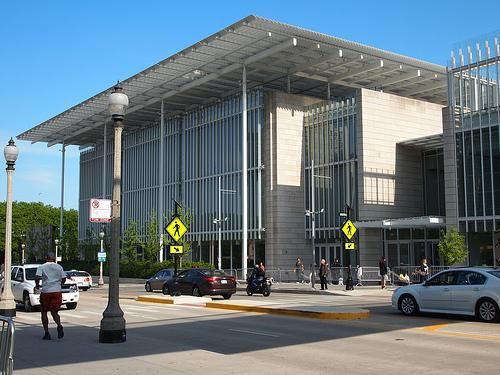

100%|██████████| 928/928 [00:15<00:00, 58.63it/s]


In [109]:
from pathlib import Path
csv_path="/kaggle/input/dl-assign-2/custom_captions_dataset/test.csv"

df_test=pd.read_csv(csv_path)

df_test['filepath']=df_test['filename'].apply(
    lambda x:f"/kaggle/input/dl-assign-2/custom_captions_dataset/test/{x}"
)

sample_image_path=df_test['filepath'].iloc[0]
display(IPImage(sample_image_path))  # show original

# Set up output directories in /kaggle/working
base_dir = Path('')
occluded_dirs = {
    10: base_dir / 'occluded_10',
    50: base_dir / 'occluded_50',
    80: base_dir / 'occluded_80'
}

# Create directories if they don’t exist
for dir_path in occluded_dirs.values():
    dir_path.mkdir(parents=True, exist_ok=True)

for image_path in tqdm(df_test['filepath']):
    filename = Path(image_path).name
    for percentage in [10, 50, 80]:
        occluded_image = occlude_image(image_path, percentage)
        output_path = occluded_dirs[percentage] / filename
        occluded_image.save(output_path)

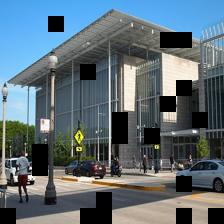

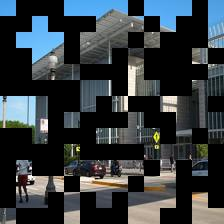

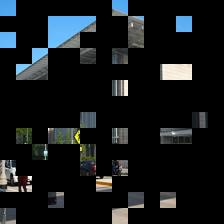

In [131]:
for percentage in [10, 50, 80]:
    display(IPImage(occluded_dirs[percentage]/'test_1.jpg'))

In [100]:
test_csv='/kaggle/input/dl-assign-2/custom_captions_dataset/test.csv'
occluded_imgs_10='/content/occluded_10'
occluded_imgs_50='/content/occluded_50'
occluded_imgs_80='/content/occluded_80'


# Occluded SmolVLM

In [101]:
DEVICE ="cuda" if torch.cuda.is_available() else "cpu"
model_id="HuggingFaceTB/SmolVLM-Instruct"

processor=AutoProcessor.from_pretrained(model_id)

model=AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16 if DEVICE=="cuda" else torch.float32,
    _attn_implementation="eager",
    ).to(DEVICE)

csv_path="/kaggle/working/SmolVLM_captions.csv"

df_test=pd.read_csv(csv_path)
df_test['occluded_10_filepath']=df_test['filename'].apply(
    lambda x:f"/content/occluded_10/{x}"
)
df_test['occluded_50_filepath']=df_test['filename'].apply(
    lambda x:f"/content/occluded_50/{x}"
)
df_test['occluded_80_filepath']=df_test['filename'].apply(
    lambda x:f"/content/occluded_80/{x}"
)
for idx in tqdm(range(len(df_test)), desc="Generating SmolVLM captions"):
    paths = {
        10: df_test['occluded_10_filepath'].iloc[idx],
        50: df_test['occluded_50_filepath'].iloc[idx],
        80: df_test['occluded_80_filepath'].iloc[idx]
    }
    for percent, image_path in paths.items():
        caption = zero_shot_captioning(image_path, model, processor)
        SmolVLM_generated_captions[percent].append(caption)

df_test['generated_caption_10']=SmolVLM_generated_captions[10]
df_test['generated_caption_50']=SmolVLM_generated_captions[50]
df_test['generated_caption_80']=SmolVLM_generated_captions[80]

df_test.head()

df_test.to_csv("/kaggle/working/SmolVLM_captions.csv",index=False)



In [214]:
print(SmolVLM_generated_captions[10][0])
print(SmolVLM_generated_captions[50][0])
print(SmolVLM_generated_captions[80][0])

User:<image>Describe this image

The image depicts a modern urban setting with a prominent building in the background. The building is a large, multi-story structure with a modern architectural design. It has a flat roof and a large glass facade, which reflects the surrounding environment. The building is surrounded by a well-maintained sidewalk and a few trees, indicating a clean and orderly city.

In the foreground, there is a person walking on the sidewalk, dressed in casual attire. The person is carrying a bag or a briefcase, suggesting they are in transit or heading to an appointment. The sidewalk is clean and well-maintained, with no visible litter or debris.

To the right of the building, there is a car parked on the street. The
User:<image>Describe this image

The image is a photograph of a city street with a large building in the background. The building is made of concrete and has a modern design, with large windows and a flat roof. The building is surrounded by trees and oth

In [217]:
print("SmolVLM Model Performance:")
SmolVLM_scores = {10:[],50:[],80:[]}
SmolVLM_scores[10] = evaluate_SmolVLM_model("generated_caption_10")
SmolVLM_scores[50] = evaluate_SmolVLM_model("generated_caption_50")
SmolVLM_scores[80] = evaluate_SmolVLM_model("generated_caption_80")
print(SmolVLM_scores[10])
print(SmolVLM_scores[50])
print(SmolVLM_scores[80])

SmolVLM Model Performance:
{'BLEU': 0.0368595234462787, 'METEOR': 0.2513774984591561, 'ROUGE-L': 0.2378358616424297}
{'BLEU': 0.0367238306704367, 'METEOR': 0.2459532684152398, 'ROUGE-L': 0.2440825476490839}
{'BLEU': 0.0202792377855153, 'METEOR': 0.188495212320885, 'ROUGE-L': 0.2007214579725418}


# Occluded Custom

In [118]:
def generate_caption_occluded(model, image_path, tokenizer, processor, device, max_length=50):
    model.eval()
    model.to(device)

    img = Image.open(image_path).convert("RGB")
    img_tensor = processor(images=img, return_tensors="pt")['pixel_values'].to(device)

    with torch.no_grad():
        encoded = model.visual_encoder(pixel_values=img_tensor)
        cls_token = encoded.last_hidden_state[:, 0, :]
        img_prefix = model.bridge_layer(cls_token).unsqueeze(1)

        # Begin decoding with BOS token
        generated = [tokenizer.bos_token_id]

        for _ in range(max_length):
            decoder_input = torch.tensor([generated], device=device)
            embedded = model.text_decoder.transformer.wte(decoder_input)

            # Combine image prefix + caption tokens
            combined_input = torch.cat((img_prefix, embedded), dim=1)
            logits = model.text_decoder(inputs_embeds=combined_input).logits

            next_token = torch.argmax(logits[:, -1, :], dim=-1).item()
            if next_token == tokenizer.eos_token_id:
                break
            generated.append(next_token)

    return tokenizer.decode(generated, skip_special_tokens=True)
def generate_captions_occluded(model, tokenizer, processor, occlusion_level):
    output_captions = {}
    directory = f"/kaggle/working/occluded_{occlusion_level}"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for filename in tqdm(os.listdir(directory), desc=f"Generating for {occlusion_level}% occlusion"):
        if filename.lower().endswith(".jpg"):
            image_path = os.path.join(directory, filename)
            caption = generate_caption_occluded(model, image_path, tokenizer, processor, device)
            output_captions[filename] = caption
            print(f"{filename}: {caption}")

    output_file = f"custom_model_occluded_captions_{occlusion_level}.json"
    with open(output_file, "w") as fp:
        json.dump(output_captions, fp, indent=2)

    return output_captions


In [145]:
SmolVLM_generated_captions = {10: [], 50: [], 80: []}
custom_generated_captions = {10: [], 50: [], 80: []}
def evaluate_on_occluded_images(occlusion_level):
    print("\nEvaluating models")
    test_df = pd.read_csv("/kaggle/input/dl-assign-2/custom_captions_dataset/test.csv")
    occluded_dataset = ImageCaptionDataset(
        test_df,
        f"/kaggle/working/occluded_{occlusion_level}/",
        tokenizer,
        image_processor
    )
    occluded_dataloader = DataLoader(occluded_dataset, batch_size=8, shuffle=False)
    print(f"\nEvaluating Custom Model on {occlusion_level}% occluded")
    custom_scores_after_occlusion = evaluate_model(model, occluded_dataloader, device)
    print(f"\nCustom Model Results For {occlusion_level}% Occluded : ")
    print("-" * 50)
    print(f"BLEU:   {custom_scores_after_occlusion['BLEU']:.4f}")
    print(f"ROUGE-L:   {custom_scores_after_occlusion['ROUGE-L']:.4f}")
    # print(f"METEOR:   {custom_results['meteor']:.4f}")
    
    with open(f"custom_occluded_scores_{occlusion_level}.json", "w") as f:
        json.dump(custom_scores_after_occlusion, f, indent=2)
    return custom_scores_after_occlusion


In [119]:

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
processor = ViTImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")

# Initialize model, optimizer, and train
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImageCaptionModel()
optimizer = AdamW(model.parameters(), lr=3e-5)
optimizer = AdamW(
    model.parameters(),
    lr=3e-5,
    weight_decay=0.01  # regularization
)
# Path to custom model
save_path = "/kaggle/working/custom_image_caption_model.pth"
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    print("✅ Loaded previously saved best model.")
else:
    print("🚀 No saved model found. Training from scratch.")

custom_scores = {10:[],50:[],80:[]}
custom_generated_captions[10] = generate_captions_occluded(model,tokenizer,processor,10)
custom_generated_captions[50] = generate_captions_occluded(model,tokenizer,processor,50)
custom_generated_captions[80] = generate_captions_occluded(model,tokenizer,processor,80)



Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/556372700.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

✅ Loaded previously saved best model.


Generating for 10% occlusion:   0%|          | 1/928 [00:00<10:59,  1.40it/s]

test_916.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 10% occlusion:   0%|          | 2/928 [00:01<08:57,  1.72it/s]

test_774.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:   0%|          | 3/928 [00:01<08:03,  1.91it/s]

test_653.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black hat.


Generating for 10% occlusion:   0%|          | 4/928 [00:02<07:36,  2.03it/s]

test_590.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard in his hand. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 10% occlusion:   1%|          | 5/928 [00:02<07:18,  2.10it/s]

test_213.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:   1%|          | 6/928 [00:02<07:11,  2.14it/s]

test_502.jpg: A man is sitting on a couch. He is wearing a black shirt and a black tie. He is holding a white Wii remote in his hand. There is a white couch next to the couch. There is a white wall behind the couch. There


Generating for 10% occlusion:   1%|          | 7/928 [00:03<07:04,  2.17it/s]

test_602.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the man. There is


Generating for 10% occlusion:   1%|          | 8/928 [00:03<07:00,  2.19it/s]

test_52.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand with


Generating for 10% occlusion:   1%|          | 9/928 [00:04<06:57,  2.20it/s]

test_389.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to them. There is a man standing


Generating for 10% occlusion:   1%|          | 10/928 [00:04<06:56,  2.21it/s]

test_134.jpg: A man is sitting on a chair. The chair is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 10% occlusion:   1%|          | 11/928 [00:05<06:56,  2.20it/s]

test_118.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:   1%|▏         | 12/928 [00:05<06:55,  2.21it/s]

test_469.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:   1%|▏         | 13/928 [00:06<06:57,  2.19it/s]

test_808.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants


Generating for 10% occlusion:   2%|▏         | 14/928 [00:06<06:56,  2.19it/s]

test_461.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing behind him. There is a man standing behind him. There is a man


Generating for 10% occlusion:   2%|▏         | 15/928 [00:07<06:55,  2.20it/s]

test_250.jpg: A man is standing on a rock. The rock is white. The man is wearing a black shirt. The man is holding a black leash. The man is wearing a black hat. The man is wearing a black helmet. The man is wearing a


Generating for 10% occlusion:   2%|▏         | 16/928 [00:07<06:52,  2.21it/s]

test_33.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree in the water behind the


Generating for 10% occlusion:   2%|▏         | 17/928 [00:07<06:52,  2.21it/s]

test_581.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 10% occlusion:   2%|▏         | 18/928 [00:08<06:59,  2.17it/s]

test_501.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf


Generating for 10% occlusion:   2%|▏         | 19/928 [00:08<06:55,  2.19it/s]

test_645.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white dog. The dog is a black and white dog. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:   2%|▏         | 20/928 [00:09<06:52,  2.20it/s]

test_607.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him holding a white and red cell phone. There is a


Generating for 10% occlusion:   2%|▏         | 21/928 [00:09<06:49,  2.21it/s]

test_884.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man in a white shirt and black pants standing next


Generating for 10% occlusion:   2%|▏         | 22/928 [00:10<06:49,  2.21it/s]

test_95.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:   2%|▏         | 23/928 [00:10<06:46,  2.23it/s]

test_45.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black and white striped shirt. The man is wearing a black and white striped shirt. The man is also wearing a black and


Generating for 10% occlusion:   3%|▎         | 24/928 [00:11<06:45,  2.23it/s]

test_732.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:   3%|▎         | 25/928 [00:11<06:45,  2.23it/s]

test_91.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis ball in front of


Generating for 10% occlusion:   3%|▎         | 26/928 [00:12<06:45,  2.22it/s]

test_634.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:   3%|▎         | 27/928 [00:12<06:42,  2.24it/s]

test_282.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white tennis


Generating for 10% occlusion:   3%|▎         | 28/928 [00:12<06:46,  2.21it/s]

test_228.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:   3%|▎         | 29/928 [00:13<06:46,  2.21it/s]

test_832.jpg: A large brown bear is standing in a field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear is looking


Generating for 10% occlusion:   3%|▎         | 30/928 [00:13<06:46,  2.21it/s]

test_682.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:   3%|▎         | 31/928 [00:14<06:44,  2.22it/s]

test_873.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 10% occlusion:   3%|▎         | 32/928 [00:14<06:42,  2.22it/s]

test_230.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:   4%|▎         | 33/928 [00:15<06:41,  2.23it/s]

test_41.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white Wii remote. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:   4%|▎         | 34/928 [00:15<06:39,  2.24it/s]

test_173.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:   4%|▍         | 35/928 [00:16<06:40,  2.23it/s]

test_40.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:   4%|▍         | 36/928 [00:16<06:40,  2.23it/s]

test_608.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating for 10% occlusion:   4%|▍         | 37/928 [00:16<06:39,  2.23it/s]

test_424.jpg: A man is standing on a train platform. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a blue train on the platform. There is a blue sky above the platform. There is a blue sky above


Generating for 10% occlusion:   4%|▍         | 38/928 [00:17<06:41,  2.21it/s]

test_73.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:   4%|▍         | 39/928 [00:17<06:41,  2.22it/s]

test_920.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone in his hand. There is a red light on the sidewalk. There is a red light on the sidewalk next to the


Generating for 10% occlusion:   4%|▍         | 40/928 [00:18<06:46,  2.19it/s]

test_123.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white wall behind him. There is a white fence behind him. There is a white fence behind


Generating for 10% occlusion:   4%|▍         | 41/928 [00:18<06:47,  2.18it/s]

test_810.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man wearing a black shirt and black pants. There is


Generating for 10% occlusion:   5%|▍         | 42/928 [00:19<06:45,  2.19it/s]

test_94.jpg: A man is standing in front of a window. The man is wearing a black shirt and black pants. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped


Generating for 10% occlusion:   5%|▍         | 43/928 [00:19<06:43,  2.19it/s]

test_387.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:   5%|▍         | 44/928 [00:20<06:42,  2.20it/s]

test_166.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:   5%|▍         | 45/928 [00:20<06:39,  2.21it/s]

test_789.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 10% occlusion:   5%|▍         | 46/928 [00:21<06:39,  2.21it/s]

test_797.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him.


Generating for 10% occlusion:   5%|▌         | 47/928 [00:21<06:37,  2.21it/s]

test_5.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating for 10% occlusion:   5%|▌         | 48/928 [00:21<06:36,  2.22it/s]

test_703.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:   5%|▌         | 49/928 [00:22<06:34,  2.23it/s]

test_794.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. There is a white fence behind the man. There is a white and blue sign on the fence.


Generating for 10% occlusion:   5%|▌         | 50/928 [00:22<06:33,  2.23it/s]

test_323.jpg: A man is sitting on a bed. The bed is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 10% occlusion:   5%|▌         | 51/928 [00:23<06:31,  2.24it/s]

test_26.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:   6%|▌         | 52/928 [00:23<06:32,  2.23it/s]

test_53.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:   6%|▌         | 53/928 [00:24<06:33,  2.22it/s]

test_57.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a large white building behind him. There is a large white building behind him. There


Generating for 10% occlusion:   6%|▌         | 54/928 [00:24<06:31,  2.23it/s]

test_505.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There


Generating for 10% occlusion:   6%|▌         | 55/928 [00:25<06:33,  2.22it/s]

test_708.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is


Generating for 10% occlusion:   6%|▌         | 56/928 [00:25<06:34,  2.21it/s]

test_898.jpg: This is a picture of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is a light brown color. The frosting is on a white plate. The plate is sitting


Generating for 10% occlusion:   6%|▌         | 57/928 [00:26<06:32,  2.22it/s]

test_625.jpg: This is an image of a pizza. The pizza is made of pizza. The pizza is white. The pizza has cheese. The cheese is on the top of the pizza. The pizza has a red sauce. The sauce is on the pizza. The


Generating for 10% occlusion:   6%|▋         | 58/928 [00:26<06:30,  2.23it/s]

test_336.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 10% occlusion:   6%|▋         | 59/928 [00:26<06:29,  2.23it/s]

test_208.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 10% occlusion:   6%|▋         | 60/928 [00:27<06:30,  2.23it/s]

test_542.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 10% occlusion:   7%|▋         | 61/928 [00:27<06:29,  2.22it/s]

test_380.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a woman standing next to him. There is a man


Generating for 10% occlusion:   7%|▋         | 62/928 [00:28<06:38,  2.17it/s]

test_6.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white fence behind him. There


Generating for 10% occlusion:   7%|▋         | 63/928 [00:28<06:54,  2.09it/s]

test_77.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:   7%|▋         | 64/928 [00:29<06:51,  2.10it/s]

test_161.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is holding a white tennis racket in his hands. There is a white and red flag on the


Generating for 10% occlusion:   7%|▋         | 65/928 [00:29<06:43,  2.14it/s]

test_684.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:   7%|▋         | 66/928 [00:30<06:42,  2.14it/s]

test_3.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:   7%|▋         | 67/928 [00:30<06:37,  2.17it/s]

test_19.jpg: This is an image of a pizza. The pizza is made of pizza. The pizza is white. The pizza is sitting on a white plate. The plate is white. The pizza is sitting on a white wooden table. The pizza is sitting on a


Generating for 10% occlusion:   7%|▋         | 68/928 [00:31<06:34,  2.18it/s]

test_856.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and black pants. There


Generating for 10% occlusion:   7%|▋         | 69/928 [00:31<06:33,  2.18it/s]

test_585.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:   8%|▊         | 70/928 [00:32<06:31,  2.19it/s]

test_784.jpg: A man is surfing on a wave. He is wearing a black shirt and black shorts. He is also wearing a black helmet. The man is wearing a black and white surfboard. The man is also wearing a black and white surfboard. The


Generating for 10% occlusion:   8%|▊         | 71/928 [00:32<06:41,  2.14it/s]

test_328.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 10% occlusion:   8%|▊         | 72/928 [00:32<06:42,  2.13it/s]

test_643.jpg: A man is standing on top of a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white surfboard. The man is wearing a black hat. The man is wearing a black and white striped


Generating for 10% occlusion:   8%|▊         | 73/928 [00:33<06:41,  2.13it/s]

test_143.jpg: A bathroom is in a room. There is a white sink with a white sink. There is a white wall behind the sink. There is a white wall behind the sink. There is a white wall behind the sink. There is a white wall behind


Generating for 10% occlusion:   8%|▊         | 74/928 [00:33<06:36,  2.16it/s]

test_242.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue bird flying in the air


Generating for 10% occlusion:   8%|▊         | 75/928 [00:34<06:31,  2.18it/s]

test_165.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 10% occlusion:   8%|▊         | 76/928 [00:34<06:26,  2.21it/s]

test_125.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white tree behind the man. There is a large white building behind the man. There


Generating for 10% occlusion:   8%|▊         | 77/928 [00:35<06:25,  2.21it/s]

test_575.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. The man is wearing a black hat. There is a woman standing


Generating for 10% occlusion:   8%|▊         | 78/928 [00:35<06:22,  2.22it/s]

test_604.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:   9%|▊         | 79/928 [00:36<06:24,  2.21it/s]

test_188.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating for 10% occlusion:   9%|▊         | 80/928 [00:36<06:24,  2.21it/s]

test_302.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating for 10% occlusion:   9%|▊         | 81/928 [00:37<06:25,  2.20it/s]

test_286.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing behind him. There is a man in a blue shirt and black pants standing behind


Generating for 10% occlusion:   9%|▉         | 82/928 [00:37<06:22,  2.21it/s]

test_567.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a red and white tennis racket in his hands. There is a large white building behind him. There is a large white building behind him.


Generating for 10% occlusion:   9%|▉         | 83/928 [00:37<06:22,  2.21it/s]

test_275.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:   9%|▉         | 84/928 [00:38<06:29,  2.17it/s]

test_329.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:   9%|▉         | 85/928 [00:38<06:31,  2.15it/s]

test_110.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 10% occlusion:   9%|▉         | 86/928 [00:39<06:26,  2.18it/s]

test_64.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white umbrella in front of him. There is a white and blue sign on the sidewalk. There is a white and blue sign on the sidewalk.


Generating for 10% occlusion:   9%|▉         | 87/928 [00:39<06:24,  2.19it/s]

test_553.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:   9%|▉         | 88/928 [00:40<06:22,  2.20it/s]

test_330.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating for 10% occlusion:  10%|▉         | 89/928 [00:40<06:22,  2.20it/s]

test_277.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. There is a red light on the street behind him. There is a red light on the sidewalk next to


Generating for 10% occlusion:  10%|▉         | 90/928 [00:41<06:20,  2.20it/s]

test_116.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  10%|▉         | 91/928 [00:41<06:21,  2.20it/s]

test_451.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 10% occlusion:  10%|▉         | 92/928 [00:42<06:19,  2.20it/s]

test_172.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  10%|█         | 93/928 [00:42<06:17,  2.21it/s]

test_301.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 10% occlusion:  10%|█         | 94/928 [00:42<06:15,  2.22it/s]

test_44.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  10%|█         | 95/928 [00:43<06:12,  2.23it/s]

test_310.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him. There


Generating for 10% occlusion:  10%|█         | 96/928 [00:43<06:11,  2.24it/s]

test_874.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  10%|█         | 97/928 [00:44<06:11,  2.24it/s]

test_85.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  11%|█         | 98/928 [00:44<06:12,  2.23it/s]

test_494.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man wearing a black shirt and a black


Generating for 10% occlusion:  11%|█         | 99/928 [00:45<06:12,  2.22it/s]

test_701.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black hat and a black and white striped shirt. There is a man standing on the sidewalk holding a white umbrella. There is a man standing on the sidewalk holding a white


Generating for 10% occlusion:  11%|█         | 100/928 [00:45<06:09,  2.24it/s]

test_704.jpg: A man is standing on a train platform. The man is wearing a black jacket and a black tie. The man is wearing a black helmet and a black and white striped shirt. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  11%|█         | 101/928 [00:46<06:09,  2.24it/s]

test_600.jpg: A man is standing on a beach. He is wearing a blue shirt and a blue and white striped shirt. He is holding a white surfboard in his hand. There is a blue and white striped umbrella in front of the man. There is a


Generating for 10% occlusion:  11%|█         | 102/928 [00:46<06:08,  2.24it/s]

test_790.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating for 10% occlusion:  11%|█         | 103/928 [00:46<06:08,  2.24it/s]

test_446.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a man standing on the beach. He is wearing a black shirt and black pants. There is a


Generating for 10% occlusion:  11%|█         | 104/928 [00:47<06:09,  2.23it/s]

test_226.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. He is sitting on a white couch. There is a white wall behind the bench. There is a white rug behind the bench. There is a white couch


Generating for 10% occlusion:  11%|█▏        | 105/928 [00:47<06:08,  2.24it/s]

test_713.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  11%|█▏        | 106/928 [00:48<06:15,  2.19it/s]

test_308.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white Frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating for 10% occlusion:  12%|█▏        | 107/928 [00:48<06:14,  2.19it/s]

test_93.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a man in a white shirt and black pants standing behind him. There


Generating for 10% occlusion:  12%|█▏        | 108/928 [00:49<06:10,  2.21it/s]

test_224.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. There is a white and red umbrella in front of him. There is a white and red umbrella next to the bench. There is a white and red umbrella


Generating for 10% occlusion:  12%|█▏        | 109/928 [00:49<06:09,  2.22it/s]

test_663.jpg: A man is standing on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  12%|█▏        | 110/928 [00:50<06:08,  2.22it/s]

test_665.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is wearing


Generating for 10% occlusion:  12%|█▏        | 111/928 [00:50<06:07,  2.23it/s]

test_707.jpg: A bird is flying in the air. The bird is a black and white bird. The bird is flying in the air. The bird is flying in the sky. The sky is blue and white. The bird is flying in the air. The sky


Generating for 10% occlusion:  12%|█▏        | 112/928 [00:51<06:06,  2.23it/s]

test_421.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  12%|█▏        | 113/928 [00:51<06:05,  2.23it/s]

test_217.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 10% occlusion:  12%|█▏        | 114/928 [00:51<06:04,  2.23it/s]

test_382.jpg: A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating for 10% occlusion:  12%|█▏        | 115/928 [00:52<06:03,  2.24it/s]

test_375.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  12%|█▎        | 116/928 [00:52<06:02,  2.24it/s]

test_659.jpg: A man is standing on a train platform. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  13%|█▎        | 117/928 [00:53<06:02,  2.23it/s]

test_435.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There


Generating for 10% occlusion:  13%|█▎        | 118/928 [00:53<06:02,  2.24it/s]

test_683.jpg: A man is sitting on a wooden bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  13%|█▎        | 119/928 [00:54<06:02,  2.23it/s]

test_193.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a person standing on the snow. There is a person wearing a black helmet on their head. There


Generating for 10% occlusion:  13%|█▎        | 120/928 [00:54<06:01,  2.23it/s]

test_876.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 10% occlusion:  13%|█▎        | 121/928 [00:55<06:00,  2.24it/s]

test_345.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  13%|█▎        | 122/928 [00:55<06:03,  2.22it/s]

test_714.jpg: A man is standing on a dirt road. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black helmet. The man is wearing a black and white shirt. The man is


Generating for 10% occlusion:  13%|█▎        | 123/928 [00:55<06:02,  2.22it/s]

test_447.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree in the water behind the


Generating for 10% occlusion:  13%|█▎        | 124/928 [00:56<06:00,  2.23it/s]

test_413.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the man. There is a white toilet in front of the wall. There is a white


Generating for 10% occlusion:  13%|█▎        | 125/928 [00:56<05:58,  2.24it/s]

test_335.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 10% occlusion:  14%|█▎        | 126/928 [00:57<05:57,  2.24it/s]

test_601.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 10% occlusion:  14%|█▎        | 127/928 [00:57<05:57,  2.24it/s]

test_419.jpg: A man is standing in a room. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  14%|█▍        | 128/928 [00:58<05:57,  2.24it/s]

test_727.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating for 10% occlusion:  14%|█▍        | 129/928 [00:58<06:02,  2.20it/s]

test_12.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 10% occlusion:  14%|█▍        | 130/928 [00:59<05:59,  2.22it/s]

test_132.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  14%|█▍        | 131/928 [00:59<05:57,  2.23it/s]

test_240.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind him. There


Generating for 10% occlusion:  14%|█▍        | 132/928 [01:00<05:58,  2.22it/s]

test_558.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  14%|█▍        | 133/928 [01:00<06:01,  2.20it/s]

test_196.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  14%|█▍        | 134/928 [01:00<05:59,  2.21it/s]

test_561.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  15%|█▍        | 135/928 [01:01<05:57,  2.22it/s]

test_908.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree behind him.


Generating for 10% occlusion:  15%|█▍        | 136/928 [01:01<05:54,  2.23it/s]

test_37.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to him. There


Generating for 10% occlusion:  15%|█▍        | 137/928 [01:02<05:52,  2.24it/s]

test_35.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a red light on the street behind him. There is a red light on the sidewalk next to the street. There


Generating for 10% occlusion:  15%|█▍        | 138/928 [01:02<05:54,  2.23it/s]

test_36.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating for 10% occlusion:  15%|█▍        | 139/928 [01:03<05:53,  2.23it/s]

test_251.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  15%|█▌        | 140/928 [01:03<05:52,  2.23it/s]

test_184.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  15%|█▌        | 141/928 [01:04<06:00,  2.18it/s]

test_624.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white skateboard in his hand. He is wearing a black and white striped shirt. There is a white sign on the sidewalk. There


Generating for 10% occlusion:  15%|█▌        | 142/928 [01:04<06:05,  2.15it/s]

test_147.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating for 10% occlusion:  15%|█▌        | 143/928 [01:05<06:04,  2.16it/s]

test_622.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating for 10% occlusion:  16%|█▌        | 144/928 [01:05<06:00,  2.17it/s]

test_156.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  16%|█▌        | 145/928 [01:05<05:57,  2.19it/s]

test_416.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  16%|█▌        | 146/928 [01:06<06:01,  2.17it/s]

test_871.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 10% occlusion:  16%|█▌        | 147/928 [01:06<05:58,  2.18it/s]

test_795.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  16%|█▌        | 148/928 [01:07<05:56,  2.19it/s]

test_606.jpg: A woman is sitting on a chair. The chair is made of wood. The chair is made of wood. The chair is made of wood. The woman is wearing a white shirt. The woman is wearing a white shirt. The woman is wearing a


Generating for 10% occlusion:  16%|█▌        | 149/928 [01:07<05:53,  2.21it/s]

test_229.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 10% occlusion:  16%|█▌        | 150/928 [01:08<05:52,  2.21it/s]

test_427.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black and white helmet. The man is wearing a black and white helmet. The man is also wearing a black and white helmet


Generating for 10% occlusion:  16%|█▋        | 151/928 [01:08<05:53,  2.20it/s]

test_826.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  16%|█▋        | 152/928 [01:09<05:49,  2.22it/s]

test_828.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There is


Generating for 10% occlusion:  16%|█▋        | 153/928 [01:09<05:46,  2.24it/s]

test_868.jpg: A man is standing on a train platform. The man is wearing a black jacket and a black tie. The man is wearing a black helmet and a black and white striped shirt. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  17%|█▋        | 154/928 [01:09<05:45,  2.24it/s]

test_679.jpg: A man is standing on a rock. The rock is brown and has a black and white stripe down the side. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is holding a black and white


Generating for 10% occlusion:  17%|█▋        | 155/928 [01:10<05:44,  2.24it/s]

test_32.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 10% occlusion:  17%|█▋        | 156/928 [01:10<05:43,  2.24it/s]

test_84.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  17%|█▋        | 157/928 [01:11<05:43,  2.24it/s]

test_722.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and blue sky behind the man. There


Generating for 10% occlusion:  17%|█▋        | 158/928 [01:11<05:46,  2.22it/s]

test_393.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  17%|█▋        | 159/928 [01:12<05:44,  2.23it/s]

test_455.jpg: A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long neck and a long trunk. The giraffe has a long neck and a long trunk. The giraffe


Generating for 10% occlusion:  17%|█▋        | 160/928 [01:12<05:43,  2.24it/s]

test_758.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  17%|█▋        | 161/928 [01:13<05:41,  2.24it/s]

test_71.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a black and white tennis


Generating for 10% occlusion:  17%|█▋        | 162/928 [01:13<05:41,  2.24it/s]

test_804.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  18%|█▊        | 163/928 [01:14<05:41,  2.24it/s]

test_314.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white baseball bat. There is a man standing next to him. There is a man in a white shirt and a black and


Generating for 10% occlusion:  18%|█▊        | 164/928 [01:14<05:45,  2.21it/s]

test_192.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  18%|█▊        | 165/928 [01:14<05:44,  2.22it/s]

test_589.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  18%|█▊        | 166/928 [01:15<05:47,  2.20it/s]

test_157.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large rock behind him. There is a large


Generating for 10% occlusion:  18%|█▊        | 167/928 [01:15<05:44,  2.21it/s]

test_79.jpg: A man is sitting on a bed. The bed is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 10% occlusion:  18%|█▊        | 168/928 [01:16<05:43,  2.22it/s]

test_55.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white and black cell phone. The man is wearing a black hat. The man is wearing a black and white


Generating for 10% occlusion:  18%|█▊        | 169/928 [01:16<05:41,  2.22it/s]

test_39.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 10% occlusion:  18%|█▊        | 170/928 [01:17<05:39,  2.23it/s]

test_618.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:  18%|█▊        | 171/928 [01:17<05:42,  2.21it/s]

test_430.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 10% occlusion:  19%|█▊        | 172/928 [01:18<05:38,  2.23it/s]

test_756.jpg: A man is standing on a bench. He is wearing a black shirt and a black hat. He is holding a black and white striped umbrella. There is a white dog sitting on the bench. There is a white dog sitting on the bench. There


Generating for 10% occlusion:  19%|█▊        | 173/928 [01:18<05:41,  2.21it/s]

test_743.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a black and white striped leash. There is a large white bird in the water behind him. There is a large tree behind


Generating for 10% occlusion:  19%|█▉        | 174/928 [01:18<05:38,  2.23it/s]

test_717.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 10% occlusion:  19%|█▉        | 175/928 [01:19<05:38,  2.23it/s]

test_311.jpg: A man is standing on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is holding a black and white baseball bat. The man is wearing a black and white striped


Generating for 10% occlusion:  19%|█▉        | 176/928 [01:19<05:39,  2.22it/s]

test_472.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 10% occlusion:  19%|█▉        | 177/928 [01:20<05:37,  2.22it/s]

test_216.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  19%|█▉        | 178/928 [01:20<05:36,  2.23it/s]

test_580.jpg: A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long nose and a long neck. The giraffe has a long neck and a long trunk. The giraffe


Generating for 10% occlusion:  19%|█▉        | 179/928 [01:21<05:36,  2.23it/s]

test_483.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a white and red phone. The phone is black and has a black and white writing on it. The man is wearing a black


Generating for 10% occlusion:  19%|█▉        | 180/928 [01:21<05:35,  2.23it/s]

test_399.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  20%|█▉        | 181/928 [01:22<05:36,  2.22it/s]

test_820.jpg: A man is sitting on a couch. The couch is made of wood. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating for 10% occlusion:  20%|█▉        | 182/928 [01:22<05:36,  2.22it/s]

test_30.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  20%|█▉        | 183/928 [01:23<05:35,  2.22it/s]

test_76.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  20%|█▉        | 184/928 [01:23<05:35,  2.22it/s]

test_14.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white


Generating for 10% occlusion:  20%|█▉        | 185/928 [01:23<05:34,  2.22it/s]

test_515.jpg: A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing on the snow covered hill. There is a man standing on the snow covered hill. There


Generating for 10% occlusion:  20%|██        | 186/928 [01:24<05:34,  2.22it/s]

test_449.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. There is a white line in the snow. There is a white


Generating for 10% occlusion:  20%|██        | 187/928 [01:24<05:37,  2.20it/s]

test_331.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  20%|██        | 188/928 [01:25<05:35,  2.20it/s]

test_475.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a white fence behind him. There is a white boat in the water behind him. There is


Generating for 10% occlusion:  20%|██        | 189/928 [01:25<05:33,  2.22it/s]

test_355.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  20%|██        | 190/928 [01:26<05:32,  2.22it/s]

test_235.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 10% occlusion:  21%|██        | 191/928 [01:26<05:31,  2.23it/s]

test_142.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand with


Generating for 10% occlusion:  21%|██        | 192/928 [01:27<05:29,  2.24it/s]

test_155.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white table in front of the bench. There is a white table with a white table cloth on it.


Generating for 10% occlusion:  21%|██        | 193/928 [01:27<05:26,  2.25it/s]

test_738.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  21%|██        | 194/928 [01:27<05:26,  2.25it/s]

test_835.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black television in front of him.


Generating for 10% occlusion:  21%|██        | 195/928 [01:28<05:32,  2.21it/s]

test_809.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The City of Seattle" on the side of the sidewalk. There is a


Generating for 10% occlusion:  21%|██        | 196/928 [01:28<05:30,  2.21it/s]

test_201.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard. There is a white and blue umbrella in front of him. There is a white and blue umbrella in front of him


Generating for 10% occlusion:  21%|██        | 197/928 [01:29<05:30,  2.21it/s]

test_723.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating for 10% occlusion:  21%|██▏       | 198/928 [01:29<05:30,  2.21it/s]

test_443.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white surfboard in his hands. There is a white fence behind the man. There is a white building behind the man. There


Generating for 10% occlusion:  21%|██▏       | 199/928 [01:30<05:32,  2.19it/s]

test_96.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  22%|██▏       | 200/928 [01:30<05:30,  2.20it/s]

test_680.jpg: This is an image of a cat. The cat is a black cat. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is


Generating for 10% occlusion:  22%|██▏       | 201/928 [01:31<05:28,  2.21it/s]

test_821.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white fence behind him. There is a white and blue bird flying in the air.


Generating for 10% occlusion:  22%|██▏       | 202/928 [01:31<05:26,  2.22it/s]

test_43.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie. There


Generating for 10% occlusion:  22%|██▏       | 203/928 [01:32<05:24,  2.23it/s]

test_151.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 10% occlusion:  22%|██▏       | 204/928 [01:32<05:23,  2.24it/s]

test_223.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  22%|██▏       | 205/928 [01:32<05:23,  2.24it/s]

test_304.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black and white striped


Generating for 10% occlusion:  22%|██▏       | 206/928 [01:33<05:23,  2.23it/s]

test_360.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white skateboard. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is


Generating for 10% occlusion:  22%|██▏       | 207/928 [01:33<05:22,  2.24it/s]

test_686.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  22%|██▏       | 208/928 [01:34<05:26,  2.21it/s]

test_872.jpg: A bathroom is in a bathroom. The bathroom is white and has a white sink. The sink is white and has a white toilet seat. The toilet seat is white and has a white toilet seat. The toilet is white and has a white toilet seat


Generating for 10% occlusion:  23%|██▎       | 209/928 [01:34<05:23,  2.23it/s]

test_425.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating for 10% occlusion:  23%|██▎       | 210/928 [01:35<05:24,  2.22it/s]

test_780.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him. There


Generating for 10% occlusion:  23%|██▎       | 211/928 [01:35<05:21,  2.23it/s]

test_621.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 10% occlusion:  23%|██▎       | 212/928 [01:36<05:33,  2.14it/s]

test_526.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  23%|██▎       | 213/928 [01:36<05:31,  2.16it/s]

test_24.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  23%|██▎       | 214/928 [01:37<05:30,  2.16it/s]

test_736.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating for 10% occlusion:  23%|██▎       | 215/928 [01:37<05:27,  2.18it/s]

test_574.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large brown


Generating for 10% occlusion:  23%|██▎       | 216/928 [01:37<05:23,  2.20it/s]

test_511.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 10% occlusion:  23%|██▎       | 217/928 [01:38<05:28,  2.17it/s]

test_830.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch next to the bench. There is


Generating for 10% occlusion:  23%|██▎       | 218/928 [01:38<05:26,  2.18it/s]

test_500.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black ski mask on his face. The man is


Generating for 10% occlusion:  24%|██▎       | 219/928 [01:39<05:26,  2.17it/s]

test_785.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  24%|██▎       | 220/928 [01:39<05:23,  2.19it/s]

test_497.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating for 10% occlusion:  24%|██▍       | 221/928 [01:40<05:20,  2.21it/s]

test_50.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 10% occlusion:  24%|██▍       | 222/928 [01:40<05:17,  2.22it/s]

test_145.jpg: A man is standing on a bench holding a white bag. The bag is white. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:  24%|██▍       | 223/928 [01:41<05:16,  2.23it/s]

test_239.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating for 10% occlusion:  24%|██▍       | 224/928 [01:41<05:15,  2.23it/s]

test_591.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white dog sitting on the bench. There is a white umbrella in front of the man. There is a white dog sitting on the bench. There


Generating for 10% occlusion:  24%|██▍       | 225/928 [01:42<05:15,  2.23it/s]

test_672.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 10% occlusion:  24%|██▍       | 226/928 [01:42<05:15,  2.23it/s]

test_401.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  24%|██▍       | 227/928 [01:42<05:16,  2.21it/s]

test_843.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 10% occlusion:  25%|██▍       | 228/928 [01:43<05:16,  2.21it/s]

test_178.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 10% occlusion:  25%|██▍       | 229/928 [01:43<05:15,  2.21it/s]

test_539.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  25%|██▍       | 230/928 [01:44<05:12,  2.23it/s]

test_285.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a sign on the sidewalk that says "The City of Seattle" on the side of the street


Generating for 10% occlusion:  25%|██▍       | 231/928 [01:44<05:11,  2.24it/s]

test_638.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. He is wearing a black and white striped


Generating for 10% occlusion:  25%|██▌       | 232/928 [01:45<05:12,  2.23it/s]

test_814.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white sign on the fence. There is a


Generating for 10% occlusion:  25%|██▌       | 233/928 [01:45<05:12,  2.22it/s]

test_763.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  25%|██▌       | 234/928 [01:46<05:11,  2.23it/s]

test_550.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 10% occlusion:  25%|██▌       | 235/928 [01:46<05:09,  2.24it/s]

test_346.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the bench. There is a white sign on the


Generating for 10% occlusion:  25%|██▌       | 236/928 [01:46<05:10,  2.23it/s]

test_444.jpg: This is a picture of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is white. The frosting is on a white plate. The plate is white. The plate


Generating for 10% occlusion:  26%|██▌       | 237/928 [01:47<05:11,  2.22it/s]

test_440.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white building behind the bench. There is a white


Generating for 10% occlusion:  26%|██▌       | 238/928 [01:47<05:11,  2.21it/s]

test_903.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white surfboard. There is a man standing on the sidewalk next to him. There is a large white building behind the man.


Generating for 10% occlusion:  26%|██▌       | 239/928 [01:48<05:17,  2.17it/s]

test_836.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 10% occlusion:  26%|██▌       | 240/928 [01:48<05:15,  2.18it/s]

test_428.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  26%|██▌       | 241/928 [01:49<05:15,  2.18it/s]

test_131.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black ski mask on his head. The man is


Generating for 10% occlusion:  26%|██▌       | 242/928 [01:49<05:14,  2.18it/s]

test_775.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hand. There is a small tree behind him. There is a large tree trunk behind him. There is a


Generating for 10% occlusion:  26%|██▌       | 243/928 [01:50<05:11,  2.20it/s]

test_724.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white tree behind the man. There is a white fence behind the man. There is a


Generating for 10% occlusion:  26%|██▋       | 244/928 [01:50<05:09,  2.21it/s]

test_65.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  26%|██▋       | 245/928 [01:51<05:07,  2.22it/s]

test_910.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his right hand. He is wearing a black and white striped shirt and black shorts. He is holding a black and


Generating for 10% occlusion:  27%|██▋       | 246/928 [01:51<05:06,  2.23it/s]

test_49.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  27%|██▋       | 247/928 [01:51<05:05,  2.23it/s]

test_283.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a red sign on the sidewalk. There is a red sign on the sidewalk


Generating for 10% occlusion:  27%|██▋       | 248/928 [01:52<05:03,  2.24it/s]

test_889.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large


Generating for 10% occlusion:  27%|██▋       | 249/928 [01:52<05:02,  2.24it/s]

test_315.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and blue umbrella. There is a white sign on the skateboard. There is a white sign on the skateboard. There is


Generating for 10% occlusion:  27%|██▋       | 250/928 [01:53<05:00,  2.25it/s]

test_914.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There


Generating for 10% occlusion:  27%|██▋       | 251/928 [01:53<04:58,  2.27it/s]

test_18.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  27%|██▋       | 252/928 [01:54<04:59,  2.26it/s]

test_742.jpg: A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  27%|██▋       | 253/928 [01:54<04:59,  2.26it/s]

test_183.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the


Generating for 10% occlusion:  27%|██▋       | 254/928 [01:55<04:59,  2.25it/s]

test_258.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 10% occlusion:  27%|██▋       | 255/928 [01:55<04:59,  2.24it/s]

test_885.jpg: A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 10% occlusion:  28%|██▊       | 256/928 [01:55<04:59,  2.24it/s]

test_22.jpg: A large white airplane is flying in the sky. The plane is white and has a black tail. The tail is black and has a red and white stripe down the middle. The sky is very cloudy and has a very small amount of clouds. The


Generating for 10% occlusion:  28%|██▊       | 257/928 [01:56<05:00,  2.23it/s]

test_662.jpg: A man is skiing down a snowy mountain. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The snow is very cold and there is snow on the ground. The


Generating for 10% occlusion:  28%|██▊       | 258/928 [01:56<04:59,  2.24it/s]

test_60.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air. There


Generating for 10% occlusion:  28%|██▊       | 259/928 [01:57<04:58,  2.24it/s]

test_523.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a red light on the street behind the man. There is a red


Generating for 10% occlusion:  28%|██▊       | 260/928 [01:57<04:58,  2.24it/s]

test_498.jpg: A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a white surfboard in his hands. The man is wearing a black and white helmet. The man is wearing a black and white surfboard


Generating for 10% occlusion:  28%|██▊       | 261/928 [01:58<04:56,  2.25it/s]

test_441.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 10% occlusion:  28%|██▊       | 262/928 [01:58<05:03,  2.19it/s]

test_384.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white


Generating for 10% occlusion:  28%|██▊       | 263/928 [01:59<05:01,  2.20it/s]

test_168.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  28%|██▊       | 264/928 [01:59<05:00,  2.21it/s]

test_139.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating for 10% occlusion:  29%|██▊       | 265/928 [02:00<04:59,  2.21it/s]

test_776.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  29%|██▊       | 266/928 [02:00<04:57,  2.22it/s]

test_92.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a red light on the sidewalk. There is a red pole next to the sidewalk. There is a red light


Generating for 10% occlusion:  29%|██▉       | 267/928 [02:00<04:55,  2.24it/s]

test_877.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 10% occlusion:  29%|██▉       | 268/928 [02:01<04:54,  2.24it/s]

test_164.jpg: A man is standing on a skateboard. He is wearing a black helmet and black pants. He is also wearing a black and white helmet. The man is wearing a black and white helmet. The man is wearing a black and white helmet. The


Generating for 10% occlusion:  29%|██▉       | 269/928 [02:01<04:53,  2.24it/s]

test_493.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet on his head. The man is wearing a black and white striped


Generating for 10% occlusion:  29%|██▉       | 270/928 [02:02<04:52,  2.25it/s]

test_928.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating for 10% occlusion:  29%|██▉       | 271/928 [02:02<04:52,  2.25it/s]

test_181.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There


Generating for 10% occlusion:  29%|██▉       | 272/928 [02:03<04:52,  2.25it/s]

test_264.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet. He is wearing a black and white striped shirt. He is wearing a


Generating for 10% occlusion:  29%|██▉       | 273/928 [02:03<04:52,  2.24it/s]

test_144.jpg: A man is sitting on a wooden table. He is wearing a black shirt and a black tie. He is holding a white plate with a white plate on it. There is a white plate on the table. There is a white plate on the table


Generating for 10% occlusion:  30%|██▉       | 274/928 [02:04<04:52,  2.23it/s]

test_534.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the man. There is a white toilet in front of the wall. There is a white


Generating for 10% occlusion:  30%|██▉       | 275/928 [02:04<04:52,  2.23it/s]

test_909.jpg: A man is standing on a rock. The rock is white and has a black and white stripe down the middle. The man is wearing a black hat and a black and white striped shirt. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  30%|██▉       | 276/928 [02:04<04:52,  2.23it/s]

test_459.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone to his ear. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating for 10% occlusion:  30%|██▉       | 277/928 [02:05<04:50,  2.24it/s]

test_770.jpg: A man is standing on a dirt road. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a man standing on the dirt road. There is a man standing on the


Generating for 10% occlusion:  30%|██▉       | 278/928 [02:05<04:52,  2.22it/s]

test_486.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  30%|███       | 279/928 [02:06<04:54,  2.21it/s]

test_305.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating for 10% occlusion:  30%|███       | 280/928 [02:06<04:53,  2.21it/s]

test_199.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  30%|███       | 281/928 [02:07<04:50,  2.22it/s]

test_745.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black and white shorts. He is wearing a black


Generating for 10% occlusion:  30%|███       | 282/928 [02:07<04:52,  2.21it/s]

test_702.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building behind


Generating for 10% occlusion:  30%|███       | 283/928 [02:08<04:56,  2.18it/s]

test_191.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 10% occlusion:  31%|███       | 284/928 [02:08<05:03,  2.12it/s]

test_859.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  31%|███       | 285/928 [02:09<04:58,  2.16it/s]

test_396.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a man wearing a black shirt and black pants. There is a man


Generating for 10% occlusion:  31%|███       | 286/928 [02:09<04:55,  2.17it/s]

test_202.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird flying in the air. There is a large


Generating for 10% occlusion:  31%|███       | 287/928 [02:09<04:52,  2.19it/s]

test_924.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 10% occlusion:  31%|███       | 288/928 [02:10<04:48,  2.22it/s]

test_415.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  31%|███       | 289/928 [02:10<04:45,  2.24it/s]

test_474.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  31%|███▏      | 290/928 [02:11<04:43,  2.25it/s]

test_298.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the man. There is a white sign on the fence. There is a white sign on the


Generating for 10% occlusion:  31%|███▏      | 291/928 [02:11<04:44,  2.24it/s]

test_691.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The water is calm and calm. The man is wearing a blue shirt and blue shorts. The man is wearing


Generating for 10% occlusion:  31%|███▏      | 292/928 [02:12<04:43,  2.24it/s]

test_388.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 10% occlusion:  32%|███▏      | 293/928 [02:12<04:42,  2.24it/s]

test_571.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 10% occlusion:  32%|███▏      | 294/928 [02:13<04:42,  2.25it/s]

test_231.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 10% occlusion:  32%|███▏      | 295/928 [02:13<04:42,  2.24it/s]

test_206.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the


Generating for 10% occlusion:  32%|███▏      | 296/928 [02:13<04:42,  2.24it/s]

test_822.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  32%|███▏      | 297/928 [02:14<04:39,  2.26it/s]

test_545.jpg: This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is white. The frosting is on a white plate. The plate is sitting on a table


Generating for 10% occlusion:  32%|███▏      | 298/928 [02:14<04:39,  2.26it/s]

test_904.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to them. There is a man standing


Generating for 10% occlusion:  32%|███▏      | 299/928 [02:15<04:38,  2.26it/s]

test_221.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white desk behind him. There is a white table with a white table cloth on it. There is a white table cloth on the


Generating for 10% occlusion:  32%|███▏      | 300/928 [02:15<04:36,  2.27it/s]

test_296.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white and black dog sitting on the bench. There is a white and black dog sitting on the bench


Generating for 10% occlusion:  32%|███▏      | 301/928 [02:16<04:37,  2.26it/s]

test_411.jpg: A man is standing on a sidewalk holding a skateboard. The man is wearing a black shirt and black pants. The man is holding a white and black skateboard. The man is wearing a black helmet and black pants. The man is wearing a


Generating for 10% occlusion:  33%|███▎      | 302/928 [02:16<04:37,  2.25it/s]

test_349.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white building behind


Generating for 10% occlusion:  33%|███▎      | 303/928 [02:17<04:39,  2.24it/s]

test_609.jpg: A man is standing on a tennis court. He is wearing a blue shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. There is a white fence behind the


Generating for 10% occlusion:  33%|███▎      | 304/928 [02:17<04:41,  2.22it/s]

test_120.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a white and red umbrella. The man is wearing a black hat. The man is wearing a black helmet. The man is wearing


Generating for 10% occlusion:  33%|███▎      | 305/928 [02:17<04:40,  2.22it/s]

test_66.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him.


Generating for 10% occlusion:  33%|███▎      | 306/928 [02:18<04:43,  2.19it/s]

test_436.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hand. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  33%|███▎      | 307/928 [02:18<04:40,  2.21it/s]

test_688.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  33%|███▎      | 308/928 [02:19<04:39,  2.22it/s]

test_897.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard. There is a white surfboard in front of him. There is a white surfboard in front of him. There


Generating for 10% occlusion:  33%|███▎      | 309/928 [02:19<04:38,  2.22it/s]

test_150.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white wall behind him. There is a white dog sitting on the bench. There is a white dog


Generating for 10% occlusion:  33%|███▎      | 310/928 [02:20<04:36,  2.24it/s]

test_75.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white camera. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to him


Generating for 10% occlusion:  34%|███▎      | 311/928 [02:20<04:34,  2.25it/s]

test_841.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large white tree behind him.


Generating for 10% occlusion:  34%|███▎      | 312/928 [02:21<04:33,  2.25it/s]

test_766.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man.


Generating for 10% occlusion:  34%|███▎      | 313/928 [02:21<04:33,  2.25it/s]

test_337.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  34%|███▍      | 314/928 [02:21<04:32,  2.26it/s]

test_420.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 10% occlusion:  34%|███▍      | 315/928 [02:22<04:31,  2.26it/s]

test_78.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white and blue bird in the water. There is a white and blue bird in the


Generating for 10% occlusion:  34%|███▍      | 316/928 [02:22<04:31,  2.26it/s]

test_715.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man in a black shirt and black pants standing behind him


Generating for 10% occlusion:  34%|███▍      | 317/928 [02:23<04:29,  2.27it/s]

test_102.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white fence behind him. There


Generating for 10% occlusion:  34%|███▍      | 318/928 [02:23<04:29,  2.27it/s]

test_786.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  34%|███▍      | 319/928 [02:24<04:29,  2.26it/s]

test_739.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white and black clock on the bench. There is a white and black clock on the ground. There is a


Generating for 10% occlusion:  34%|███▍      | 320/928 [02:24<04:28,  2.26it/s]

test_312.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white table in front of the bench. There is a white table cloth on the table


Generating for 10% occlusion:  35%|███▍      | 321/928 [02:25<04:29,  2.25it/s]

test_565.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  35%|███▍      | 322/928 [02:25<04:28,  2.26it/s]

test_851.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 10% occlusion:  35%|███▍      | 323/928 [02:25<04:28,  2.25it/s]

test_205.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black jacket and black pants. There is a man standing next to him holding a white umbrella. There is a woman standing next to him holding a white umbrella. There is


Generating for 10% occlusion:  35%|███▍      | 324/928 [02:26<04:28,  2.25it/s]

test_657.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  35%|███▌      | 325/928 [02:26<04:29,  2.24it/s]

test_562.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating for 10% occlusion:  35%|███▌      | 326/928 [02:27<04:27,  2.25it/s]

test_247.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white wall behind him. There is a white table in front of the bench. There is a white table


Generating for 10% occlusion:  35%|███▌      | 327/928 [02:27<04:25,  2.26it/s]

test_675.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white kite. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 10% occlusion:  35%|███▌      | 328/928 [02:28<04:24,  2.27it/s]

test_906.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating for 10% occlusion:  35%|███▌      | 329/928 [02:28<04:29,  2.22it/s]

test_333.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:  36%|███▌      | 330/928 [02:29<04:28,  2.22it/s]

test_921.jpg: This is a picture of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  36%|███▌      | 331/928 [02:29<04:28,  2.22it/s]

test_352.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man wearing a black shirt and a black


Generating for 10% occlusion:  36%|███▌      | 332/928 [02:30<04:28,  2.22it/s]

test_746.jpg: A man is standing on a dirt road. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 10% occlusion:  36%|███▌      | 333/928 [02:30<04:28,  2.22it/s]

test_524.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch next to the bench. There is


Generating for 10% occlusion:  36%|███▌      | 334/928 [02:30<04:26,  2.23it/s]

test_489.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 10% occlusion:  36%|███▌      | 335/928 [02:31<04:25,  2.24it/s]

test_698.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating for 10% occlusion:  36%|███▌      | 336/928 [02:31<04:24,  2.24it/s]

test_306.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white fence behind him. There is a white and black dog standing on the


Generating for 10% occlusion:  36%|███▋      | 337/928 [02:32<04:24,  2.23it/s]

test_718.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  36%|███▋      | 338/928 [02:32<04:23,  2.24it/s]

test_520.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating for 10% occlusion:  37%|███▋      | 339/928 [02:33<04:21,  2.25it/s]

test_628.jpg: A large white building is sitting on top of a hill. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the


Generating for 10% occlusion:  37%|███▋      | 340/928 [02:33<04:20,  2.25it/s]

test_508.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a woman standing behind him. There is a man wearing a black shirt


Generating for 10% occlusion:  37%|███▋      | 341/928 [02:34<04:21,  2.25it/s]

test_827.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  37%|███▋      | 342/928 [02:34<04:27,  2.19it/s]

test_750.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  37%|███▋      | 343/928 [02:34<04:32,  2.15it/s]

test_861.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  37%|███▋      | 344/928 [02:35<04:28,  2.18it/s]

test_748.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 10% occlusion:  37%|███▋      | 345/928 [02:35<04:26,  2.18it/s]

test_572.jpg: A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  37%|███▋      | 346/928 [02:36<04:26,  2.18it/s]

test_753.jpg: A man is standing on a runway. He is wearing a black jacket and a black tie. He is holding a red and white tennis racket in his hands. There is a white line in the sky above the man. There is a large white building


Generating for 10% occlusion:  37%|███▋      | 347/928 [02:36<04:26,  2.18it/s]

test_556.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a large tree behind him. There is a large white fence behind the man. There


Generating for 10% occlusion:  38%|███▊      | 348/928 [02:37<04:23,  2.20it/s]

test_646.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a


Generating for 10% occlusion:  38%|███▊      | 349/928 [02:37<04:21,  2.21it/s]

test_392.jpg: A man is riding a motorcycle on a paved road. The motorcycle is red and has a black handlebar. The man is wearing a black helmet and a black helmet and a black helmet and a black helmet. The man is wearing a black helmet and


Generating for 10% occlusion:  38%|███▊      | 350/928 [02:38<04:20,  2.22it/s]

test_867.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and


Generating for 10% occlusion:  38%|███▊      | 351/928 [02:38<04:23,  2.19it/s]

test_767.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 10% occlusion:  38%|███▊      | 352/928 [02:39<04:23,  2.18it/s]

test_187.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large sign on the sidewalk. There is a large sign with a black and white writing on it. There is


Generating for 10% occlusion:  38%|███▊      | 353/928 [02:39<04:31,  2.12it/s]

test_869.jpg: A man is sitting on a couch. He is wearing a white shirt and a black tie. There is a white couch next to him. There is a white wall behind the man. There is a white couch next to the couch. There is a


Generating for 10% occlusion:  38%|███▊      | 354/928 [02:40<04:32,  2.11it/s]

test_792.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating for 10% occlusion:  38%|███▊      | 355/928 [02:40<04:29,  2.12it/s]

test_693.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  38%|███▊      | 356/928 [02:40<04:26,  2.14it/s]

test_293.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 10% occlusion:  38%|███▊      | 357/928 [02:41<04:24,  2.16it/s]

test_408.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  39%|███▊      | 358/928 [02:41<04:21,  2.18it/s]

test_409.jpg: A man is standing in a bathroom. The bathroom is white. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  39%|███▊      | 359/928 [02:42<04:21,  2.18it/s]

test_744.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  39%|███▉      | 360/928 [02:42<04:20,  2.18it/s]

test_671.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The shirt is black. The man is wearing a black hat. The hat is white. The man is wearing a black and white striped


Generating for 10% occlusion:  39%|███▉      | 361/928 [02:43<04:17,  2.20it/s]

test_599.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  39%|███▉      | 362/928 [02:43<04:14,  2.22it/s]

test_473.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red and white sign


Generating for 10% occlusion:  39%|███▉      | 363/928 [02:44<04:13,  2.23it/s]

test_204.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is holding a white tennis racket in his hands. There is a white fence behind the man. There


Generating for 10% occlusion:  39%|███▉      | 364/928 [02:44<04:12,  2.24it/s]

test_395.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  39%|███▉      | 365/928 [02:45<04:11,  2.24it/s]

test_16.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red and white sign on the sidewalk. There is a blue and white sign on the sidewalk. There is a


Generating for 10% occlusion:  39%|███▉      | 366/928 [02:45<04:11,  2.23it/s]

test_261.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  40%|███▉      | 367/928 [02:45<04:11,  2.23it/s]

test_577.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  40%|███▉      | 368/928 [02:46<04:10,  2.23it/s]

test_163.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on


Generating for 10% occlusion:  40%|███▉      | 369/928 [02:46<04:10,  2.23it/s]

test_62.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a red light on the street behind him. There is a red light on the sidewalk next to the street. There


Generating for 10% occlusion:  40%|███▉      | 370/928 [02:47<04:09,  2.24it/s]

test_537.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a black and white surfboard in his hands. There is a large white bird in the water behind him. There is a


Generating for 10% occlusion:  40%|███▉      | 371/928 [02:47<04:16,  2.18it/s]

test_227.jpg: A plane is flying in the sky. The plane is white and has a black nose. The plane is flying in the sky. The plane is very bright. The sky is very clear. The sky is very bright. The sky is very bright.


Generating for 10% occlusion:  40%|████      | 372/928 [02:48<04:13,  2.19it/s]

test_103.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating for 10% occlusion:  40%|████      | 373/928 [02:48<04:17,  2.15it/s]

test_633.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him. There


Generating for 10% occlusion:  40%|████      | 374/928 [02:49<04:14,  2.18it/s]

test_316.jpg: A man is standing in a room of a home. The man is wearing a black shirt and black pants. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black hat.


Generating for 10% occlusion:  40%|████      | 375/928 [02:49<04:11,  2.20it/s]

test_290.jpg: A man is surfing on a wave. The wave is white and has a white and blue background. The man is wearing a blue shirt and blue shorts. The man is also wearing a blue helmet. The man is also wearing a blue and white surf


Generating for 10% occlusion:  41%|████      | 376/928 [02:50<04:08,  2.22it/s]

test_749.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:  41%|████      | 377/928 [02:50<04:07,  2.22it/s]

test_29.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 10% occlusion:  41%|████      | 378/928 [02:50<04:06,  2.23it/s]

test_407.jpg: A train is on the tracks. The train is red and white. The train is on the tracks. The train is red and white. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating for 10% occlusion:  41%|████      | 379/928 [02:51<04:06,  2.23it/s]

test_864.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white frisbee. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  41%|████      | 380/928 [02:51<04:05,  2.23it/s]

test_215.jpg: A man is standing on a tennis court. He is wearing a blue shirt and blue shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  41%|████      | 381/928 [02:52<04:04,  2.24it/s]

test_309.jpg: A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating for 10% occlusion:  41%|████      | 382/928 [02:52<04:03,  2.24it/s]

test_369.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  41%|████▏     | 383/928 [02:53<04:03,  2.24it/s]

test_516.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  41%|████▏     | 384/928 [02:53<04:03,  2.23it/s]

test_484.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench. There is


Generating for 10% occlusion:  41%|████▏     | 385/928 [02:54<04:02,  2.24it/s]

test_338.jpg: A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a man standing on the hill with his head down. There is a man wearing a


Generating for 10% occlusion:  42%|████▏     | 386/928 [02:54<04:02,  2.24it/s]

test_725.jpg: A man is standing in front of a large white building. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him with a black hat on. There is a


Generating for 10% occlusion:  42%|████▏     | 387/928 [02:54<04:00,  2.25it/s]

test_791.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red


Generating for 10% occlusion:  42%|████▏     | 388/928 [02:55<04:02,  2.23it/s]

test_203.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 10% occlusion:  42%|████▏     | 389/928 [02:55<04:01,  2.23it/s]

test_138.jpg: A bunch of bananas are sitting on a table. There are bananas on a white plate. There are bananas on a black plate. There are bananas on a white plate. There are bananas on a white plate. There are bananas on a white plate.


Generating for 10% occlusion:  42%|████▏     | 390/928 [02:56<04:00,  2.24it/s]

test_685.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There is a


Generating for 10% occlusion:  42%|████▏     | 391/928 [02:56<03:59,  2.25it/s]

test_614.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:  42%|████▏     | 392/928 [02:57<03:58,  2.24it/s]

test_829.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 10% occlusion:  42%|████▏     | 393/928 [02:57<03:58,  2.25it/s]

test_888.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. There is a white fence behind the man


Generating for 10% occlusion:  42%|████▏     | 394/928 [02:58<03:57,  2.24it/s]

test_926.jpg: A train is on the tracks. The train is white and has a blue stripe down the side of it. There is a large white building behind the train. There is a large white building behind the train. There is a large white building behind the


Generating for 10% occlusion:  43%|████▎     | 395/928 [02:58<04:03,  2.19it/s]

test_536.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating for 10% occlusion:  43%|████▎     | 396/928 [02:58<04:01,  2.20it/s]

test_620.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  43%|████▎     | 397/928 [02:59<03:59,  2.21it/s]

test_300.jpg: A plane is flying in the sky. The plane is white and has a black tail. The plane has a black nose. The plane has a black tail. The plane has a black engine. The plane has a black tail. The plane has a


Generating for 10% occlusion:  43%|████▎     | 398/928 [02:59<03:58,  2.22it/s]

test_288.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard. There is a white line in the water behind him. There is a white sign on the side of the beach. There


Generating for 10% occlusion:  43%|████▎     | 399/928 [03:00<03:57,  2.22it/s]

test_189.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  43%|████▎     | 400/928 [03:00<03:56,  2.23it/s]

test_111.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 10% occlusion:  43%|████▎     | 401/928 [03:01<03:55,  2.24it/s]

test_347.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black skateboard in his hand. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. There


Generating for 10% occlusion:  43%|████▎     | 402/928 [03:01<03:55,  2.24it/s]

test_635.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white fence behind him. There


Generating for 10% occlusion:  43%|████▎     | 403/928 [03:02<03:53,  2.25it/s]

test_759.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  44%|████▎     | 404/928 [03:02<03:52,  2.25it/s]

test_543.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a large building behind the man. There is a large building behind


Generating for 10% occlusion:  44%|████▎     | 405/928 [03:02<03:52,  2.25it/s]

test_149.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a small white


Generating for 10% occlusion:  44%|████▍     | 406/928 [03:03<03:51,  2.26it/s]

test_59.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is a


Generating for 10% occlusion:  44%|████▍     | 407/928 [03:03<03:50,  2.26it/s]

test_233.jpg: A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating for 10% occlusion:  44%|████▍     | 408/928 [03:04<03:49,  2.26it/s]

test_887.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  44%|████▍     | 409/928 [03:04<03:49,  2.26it/s]

test_467.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 10% occlusion:  44%|████▍     | 410/928 [03:05<03:50,  2.25it/s]

test_799.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  44%|████▍     | 411/928 [03:05<03:50,  2.24it/s]

test_912.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  44%|████▍     | 412/928 [03:06<03:51,  2.23it/s]

test_740.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  45%|████▍     | 413/928 [03:06<03:51,  2.23it/s]

test_582.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large brown bird in the distance. There is a large brown tree


Generating for 10% occlusion:  45%|████▍     | 414/928 [03:06<03:49,  2.24it/s]

test_719.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his right hand. He is holding a white umbrella in his left hand. He is wearing a black and white striped


Generating for 10% occlusion:  45%|████▍     | 415/928 [03:07<03:48,  2.25it/s]

test_530.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating for 10% occlusion:  45%|████▍     | 416/928 [03:07<03:47,  2.25it/s]

test_294.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  45%|████▍     | 417/928 [03:08<03:48,  2.23it/s]

test_289.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white cell phone. There is a man standing next to him. There is a man wearing a black shirt and a black tie. There


Generating for 10% occlusion:  45%|████▌     | 418/928 [03:08<03:51,  2.20it/s]

test_244.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air above the


Generating for 10% occlusion:  45%|████▌     | 419/928 [03:09<03:49,  2.22it/s]

test_594.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is wearing a black and white striped shirt. There is a white pole behind him. There is a white skateboard in front of the man.


Generating for 10% occlusion:  45%|████▌     | 420/928 [03:09<03:48,  2.22it/s]

test_737.jpg: A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 10% occlusion:  45%|████▌     | 421/928 [03:10<03:47,  2.22it/s]

test_356.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  45%|████▌     | 422/928 [03:10<03:46,  2.23it/s]

test_279.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large sign on the sidewalk. There is a large sign with a


Generating for 10% occlusion:  46%|████▌     | 423/928 [03:11<03:45,  2.24it/s]

test_2.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating for 10% occlusion:  46%|████▌     | 424/928 [03:11<03:53,  2.16it/s]

test_342.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird in the distance. There is a large brown


Generating for 10% occlusion:  46%|████▌     | 425/928 [03:11<03:50,  2.18it/s]

test_677.jpg: A man is standing in front of a large white building. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  46%|████▌     | 426/928 [03:12<03:49,  2.19it/s]

test_852.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him holding a white and red


Generating for 10% occlusion:  46%|████▌     | 427/928 [03:12<03:48,  2.20it/s]

test_99.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating for 10% occlusion:  46%|████▌     | 428/928 [03:13<03:45,  2.22it/s]

test_674.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a woman standing next to him. There is a


Generating for 10% occlusion:  46%|████▌     | 429/928 [03:13<03:43,  2.24it/s]

test_89.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  46%|████▋     | 430/928 [03:14<03:42,  2.24it/s]

test_540.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  46%|████▋     | 431/928 [03:14<03:41,  2.24it/s]

test_379.jpg: This is an image of a pizza. The pizza is on a white plate. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce on top of it. The sauce is on a white sauce pan


Generating for 10% occlusion:  47%|████▋     | 432/928 [03:15<03:41,  2.24it/s]

test_793.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on


Generating for 10% occlusion:  47%|████▋     | 433/928 [03:15<03:40,  2.24it/s]

test_504.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 10% occlusion:  47%|████▋     | 434/928 [03:15<03:40,  2.24it/s]

test_862.jpg: A man is standing on a beach. He is wearing a white shirt and a blue shirt. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of him. There is a white and blue umbrella in


Generating for 10% occlusion:  47%|████▋     | 435/928 [03:16<03:40,  2.23it/s]

test_807.jpg: A man is standing on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  47%|████▋     | 436/928 [03:16<03:39,  2.24it/s]

test_586.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a red and white Frisbee. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 10% occlusion:  47%|████▋     | 437/928 [03:17<03:38,  2.24it/s]

test_564.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 10% occlusion:  47%|████▋     | 438/928 [03:17<03:38,  2.25it/s]

test_212.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating for 10% occlusion:  47%|████▋     | 439/928 [03:18<03:39,  2.23it/s]

test_287.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 10% occlusion:  47%|████▋     | 440/928 [03:18<03:42,  2.19it/s]

test_517.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a man standing on the beach with a black umbrella. There is a man standing on the sand with a black


Generating for 10% occlusion:  48%|████▊     | 441/928 [03:19<03:39,  2.22it/s]

test_361.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white cell phone. The woman is wearing a black hat. The woman is wearing a black and white striped shirt


Generating for 10% occlusion:  48%|████▊     | 442/928 [03:19<03:37,  2.24it/s]

test_378.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white bird perched on the bench. There is a white fence behind the bench. There is a white pole next


Generating for 10% occlusion:  48%|████▊     | 443/928 [03:20<03:35,  2.25it/s]

test_870.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  48%|████▊     | 444/928 [03:20<03:34,  2.26it/s]

test_603.jpg: A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating for 10% occlusion:  48%|████▊     | 445/928 [03:20<03:33,  2.26it/s]

test_10.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 10% occlusion:  48%|████▊     | 446/928 [03:21<03:33,  2.26it/s]

test_414.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  48%|████▊     | 447/928 [03:21<03:32,  2.26it/s]

test_63.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  48%|████▊     | 448/928 [03:22<03:32,  2.26it/s]

test_437.jpg: A man is standing in front of a large white building. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on


Generating for 10% occlusion:  48%|████▊     | 449/928 [03:22<03:31,  2.26it/s]

test_816.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  48%|████▊     | 450/928 [03:23<03:30,  2.27it/s]

test_605.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a


Generating for 10% occlusion:  49%|████▊     | 451/928 [03:23<03:30,  2.27it/s]

test_733.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  49%|████▊     | 452/928 [03:23<03:30,  2.27it/s]

test_761.jpg: A man is surfing on a wave. The wave is white and has a white line. The man is wearing a black shirt and black shorts. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man


Generating for 10% occlusion:  49%|████▉     | 453/928 [03:24<03:29,  2.26it/s]

test_195.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing on the sidewalk holding a white and black umbrella. There is a man


Generating for 10% occlusion:  49%|████▉     | 454/928 [03:24<03:30,  2.25it/s]

test_200.jpg: A woman is sitting on a bench. She is wearing a white shirt and a black skirt. She is holding a white toothbrush in her mouth. There is a white cat in front of her. There is a white cat in front of her.


Generating for 10% occlusion:  49%|████▉     | 455/928 [03:25<03:30,  2.24it/s]

test_796.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet on his head. The man is wearing a black helmet on his


Generating for 10% occlusion:  49%|████▉     | 456/928 [03:25<03:30,  2.24it/s]

test_760.jpg: A man is standing on a sidewalk. The man is wearing a black shirt and a black tie. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants. The man is wearing a black and white


Generating for 10% occlusion:  49%|████▉     | 457/928 [03:26<03:29,  2.25it/s]

test_114.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  49%|████▉     | 458/928 [03:26<03:30,  2.24it/s]

test_70.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped umbrella. The umbrella is black and white. The man is wearing a black hat. The


Generating for 10% occlusion:  49%|████▉     | 459/928 [03:27<03:29,  2.23it/s]

test_341.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  50%|████▉     | 460/928 [03:27<03:28,  2.24it/s]

test_895.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white cat sitting on the bench. There is


Generating for 10% occlusion:  50%|████▉     | 461/928 [03:28<03:28,  2.24it/s]

test_295.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is a


Generating for 10% occlusion:  50%|████▉     | 462/928 [03:28<03:31,  2.21it/s]

test_374.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a large tree behind him. There is a large rock face on the mountain. There is a large


Generating for 10% occlusion:  50%|████▉     | 463/928 [03:28<03:30,  2.21it/s]

test_907.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 10% occlusion:  50%|█████     | 464/928 [03:29<03:29,  2.22it/s]

test_271.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a green grassy area behind the man. There is a green tree behind the man. There


Generating for 10% occlusion:  50%|█████     | 465/928 [03:29<03:28,  2.22it/s]

test_445.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white cat. The cat is black and white. The man is wearing a black hat. The man is wearing a black and white


Generating for 10% occlusion:  50%|█████     | 466/928 [03:30<03:28,  2.22it/s]

test_61.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  50%|█████     | 467/928 [03:30<03:27,  2.22it/s]

test_687.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and white shorts. He is wearing a black and white striped shirt. There


Generating for 10% occlusion:  50%|█████     | 468/928 [03:31<03:26,  2.22it/s]

test_318.jpg: A man is sitting on a couch. He is wearing a black shirt and a black tie. There is a white laptop on the man's lap. There is a white wall behind the man. There is a white couch next to the couch. There


Generating for 10% occlusion:  51%|█████     | 469/928 [03:31<03:26,  2.22it/s]

test_647.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white frisbee. The woman is wearing a black hat. The woman is wearing a black and white striped


Generating for 10% occlusion:  51%|█████     | 470/928 [03:32<03:27,  2.21it/s]

test_281.jpg: A train is on the tracks. The train is red and blue. The train is on the tracks. The train is red and blue. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating for 10% occlusion:  51%|█████     | 471/928 [03:32<03:25,  2.22it/s]

test_513.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:  51%|█████     | 472/928 [03:32<03:24,  2.23it/s]

test_548.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  51%|█████     | 473/928 [03:33<03:24,  2.23it/s]

test_325.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree trunk behind him. There is a large white pole next to the


Generating for 10% occlusion:  51%|█████     | 474/928 [03:33<03:23,  2.23it/s]

test_915.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him.


Generating for 10% occlusion:  51%|█████     | 475/928 [03:34<03:22,  2.24it/s]

test_11.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  51%|█████▏    | 476/928 [03:34<03:21,  2.24it/s]

test_578.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating for 10% occlusion:  51%|█████▏    | 477/928 [03:35<03:22,  2.23it/s]

test_838.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white surfboard. The man is wearing a black and white surfboard.


Generating for 10% occlusion:  52%|█████▏    | 478/928 [03:35<03:23,  2.21it/s]

test_365.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  52%|█████▏    | 479/928 [03:36<03:21,  2.22it/s]

test_695.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is a


Generating for 10% occlusion:  52%|█████▏    | 480/928 [03:36<03:19,  2.24it/s]

test_351.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 10% occlusion:  52%|█████▏    | 481/928 [03:36<03:18,  2.26it/s]

test_658.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man in a blue shirt and a black tie


Generating for 10% occlusion:  52%|█████▏    | 482/928 [03:37<03:17,  2.26it/s]

test_299.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is holding a skateboard in his hands. The man is wearing a black shirt and black pants. The man is wearing a black helmet and black


Generating for 10% occlusion:  52%|█████▏    | 483/928 [03:37<03:16,  2.26it/s]

test_649.jpg: This is an image of a cat. The cat is a black and white striped cat. The cat is sitting on a white table. The cat is sitting on a white table. The cat is looking at the camera. The cat is looking at the


Generating for 10% occlusion:  52%|█████▏    | 484/928 [03:38<03:16,  2.26it/s]

test_762.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 10% occlusion:  52%|█████▏    | 485/928 [03:38<03:18,  2.23it/s]

test_891.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating for 10% occlusion:  52%|█████▏    | 486/928 [03:39<03:19,  2.21it/s]

test_7.jpg: A man is standing in a room with a large white suitcase. The suitcase is white and has a black handle. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and


Generating for 10% occlusion:  52%|█████▏    | 487/928 [03:39<03:19,  2.22it/s]

test_422.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a white and red tennis


Generating for 10% occlusion:  53%|█████▎    | 488/928 [03:40<03:16,  2.24it/s]

test_573.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  53%|█████▎    | 489/928 [03:40<03:15,  2.25it/s]

test_681.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hands. There is a man standing on the beach with his arms crossed. There is a man standing on the sand


Generating for 10% occlusion:  53%|█████▎    | 490/928 [03:41<03:13,  2.26it/s]

test_911.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large sign on the


Generating for 10% occlusion:  53%|█████▎    | 491/928 [03:41<03:12,  2.27it/s]

test_478.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 10% occlusion:  53%|█████▎    | 492/928 [03:41<03:13,  2.25it/s]

test_358.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black hat and a black shirt. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the bench.


Generating for 10% occlusion:  53%|█████▎    | 493/928 [03:42<03:13,  2.25it/s]

test_853.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  53%|█████▎    | 494/928 [03:42<03:13,  2.24it/s]

test_292.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  53%|█████▎    | 495/928 [03:43<03:18,  2.18it/s]

test_169.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  53%|█████▎    | 496/928 [03:43<03:18,  2.18it/s]

test_27.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  54%|█████▎    | 497/928 [03:44<03:16,  2.19it/s]

test_629.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black shirt. The man is


Generating for 10% occlusion:  54%|█████▎    | 498/928 [03:44<03:14,  2.21it/s]

test_214.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating for 10% occlusion:  54%|█████▍    | 499/928 [03:45<03:12,  2.23it/s]

test_642.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  54%|█████▍    | 500/928 [03:45<03:11,  2.23it/s]

test_927.jpg: A man is standing on a wooden bench. The bench is made of wood. The man is wearing a black shirt and black pants. The man is holding a black and white striped umbrella. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  54%|█████▍    | 501/928 [03:45<03:11,  2.23it/s]

test_246.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 10% occlusion:  54%|█████▍    | 502/928 [03:46<03:11,  2.22it/s]

test_849.jpg: A bathroom is in a bathroom. There is a white sink with a white sink. There is a white toilet in the bathroom. There is a white sink with a white sink. There is a white wall behind the sink. There is a white wall


Generating for 10% occlusion:  54%|█████▍    | 503/928 [03:46<03:11,  2.23it/s]

test_801.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to


Generating for 10% occlusion:  54%|█████▍    | 504/928 [03:47<03:10,  2.23it/s]

test_359.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the street. There is a red


Generating for 10% occlusion:  54%|█████▍    | 505/928 [03:47<03:11,  2.21it/s]

test_327.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white and black television on the wall behind him. There is a white


Generating for 10% occlusion:  55%|█████▍    | 506/928 [03:48<03:13,  2.18it/s]

test_650.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a white and blue boat in the distance. There


Generating for 10% occlusion:  55%|█████▍    | 507/928 [03:48<03:15,  2.16it/s]

test_610.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 10% occlusion:  55%|█████▍    | 508/928 [03:49<03:12,  2.18it/s]

test_266.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a person standing behind him. There is a person wearing a black helmet on their head.


Generating for 10% occlusion:  55%|█████▍    | 509/928 [03:49<03:10,  2.20it/s]

test_593.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and black pants. There


Generating for 10% occlusion:  55%|█████▍    | 510/928 [03:50<03:12,  2.17it/s]

test_141.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and blue frisbee. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The


Generating for 10% occlusion:  55%|█████▌    | 511/928 [03:50<03:09,  2.20it/s]

test_844.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and blue sign on the wall behind him. There is a white and blue sign on the wall behind him. There is a


Generating for 10% occlusion:  55%|█████▌    | 512/928 [03:50<03:07,  2.22it/s]

test_896.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 10% occlusion:  55%|█████▌    | 513/928 [03:51<03:06,  2.22it/s]

test_666.jpg: A man is standing on a dirt field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large rock behind him. There is a large brown bird in the


Generating for 10% occlusion:  55%|█████▌    | 514/928 [03:51<03:05,  2.23it/s]

test_487.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the


Generating for 10% occlusion:  55%|█████▌    | 515/928 [03:52<03:04,  2.24it/s]

test_652.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is a


Generating for 10% occlusion:  56%|█████▌    | 516/928 [03:52<03:03,  2.25it/s]

test_547.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  56%|█████▌    | 517/928 [03:53<03:03,  2.24it/s]

test_322.jpg: A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating for 10% occlusion:  56%|█████▌    | 518/928 [03:53<03:02,  2.24it/s]

test_819.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating for 10% occlusion:  56%|█████▌    | 519/928 [03:54<03:01,  2.25it/s]

test_354.jpg: A large white building is seen in the distance. There are two large windows on the building. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the building. There


Generating for 10% occlusion:  56%|█████▌    | 520/928 [03:54<03:01,  2.25it/s]

test_813.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. He is wearing a black helmet and black goggles. He is wearing a black helmet and black goggles.


Generating for 10% occlusion:  56%|█████▌    | 521/928 [03:54<03:01,  2.24it/s]

test_757.jpg: A train is on the tracks. The train is red and blue. The train is on the tracks. The train is red and blue. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating for 10% occlusion:  56%|█████▋    | 522/928 [03:55<03:01,  2.24it/s]

test_148.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The Street." There is a sign on the sidewalk that says "The Street


Generating for 10% occlusion:  56%|█████▋    | 523/928 [03:55<03:01,  2.23it/s]

test_837.jpg: This is an image of a pizza. The pizza is made of pizza. The pizza is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white sauce.


Generating for 10% occlusion:  56%|█████▋    | 524/928 [03:56<03:00,  2.24it/s]

test_262.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man in a black shirt and black pants standing next


Generating for 10% occlusion:  57%|█████▋    | 525/928 [03:56<02:59,  2.24it/s]

test_210.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  57%|█████▋    | 526/928 [03:57<02:59,  2.24it/s]

test_466.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white and red pen. There is a white and black umbrella in front of him. There is a white and black clock on the bench


Generating for 10% occlusion:  57%|█████▋    | 527/928 [03:57<02:58,  2.24it/s]

test_372.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 10% occlusion:  57%|█████▋    | 528/928 [03:58<02:58,  2.24it/s]

test_402.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  57%|█████▋    | 529/928 [03:58<03:00,  2.21it/s]

test_509.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis ball in front of


Generating for 10% occlusion:  57%|█████▋    | 530/928 [03:59<02:59,  2.21it/s]

test_68.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  57%|█████▋    | 531/928 [03:59<02:59,  2.22it/s]

test_700.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  57%|█████▋    | 532/928 [03:59<02:58,  2.22it/s]

test_544.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard. There is a white line in the sand behind him. There is a white sign on the side of the beach. There


Generating for 10% occlusion:  57%|█████▋    | 533/928 [04:00<02:57,  2.22it/s]

test_456.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the man. There is


Generating for 10% occlusion:  58%|█████▊    | 534/928 [04:00<02:57,  2.22it/s]

test_268.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a white line in the sand behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  58%|█████▊    | 535/928 [04:01<02:55,  2.24it/s]

test_198.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  58%|█████▊    | 536/928 [04:01<02:54,  2.25it/s]

test_417.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white sign on the wall behind him. There is a white sign next


Generating for 10% occlusion:  58%|█████▊    | 537/928 [04:02<02:53,  2.26it/s]

test_615.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white and red pen. There is a white and black umbrella in front of the bench. There is a white and black clock on the


Generating for 10% occlusion:  58%|█████▊    | 538/928 [04:02<02:52,  2.26it/s]

test_857.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on


Generating for 10% occlusion:  58%|█████▊    | 539/928 [04:03<02:52,  2.25it/s]

test_265.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white and red umbrella in front of him. There is a white and red umbrella next to him. There is a white and red umbrella next to


Generating for 10% occlusion:  58%|█████▊    | 540/928 [04:03<02:52,  2.25it/s]

test_179.jpg: A man is standing on a bench holding a white umbrella. The umbrella is white and has a black and white writing on it. The man is wearing a black shirt and a black tie. The man is holding a black and white baseball cap. The


Generating for 10% occlusion:  58%|█████▊    | 541/928 [04:03<02:52,  2.24it/s]

test_170.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 10% occlusion:  58%|█████▊    | 542/928 [04:04<02:51,  2.26it/s]

test_234.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree in the distance behind him. There is a large brown bird flying in the distance. There


Generating for 10% occlusion:  59%|█████▊    | 543/928 [04:04<02:50,  2.25it/s]

test_253.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing


Generating for 10% occlusion:  59%|█████▊    | 544/928 [04:05<02:49,  2.26it/s]

test_878.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:  59%|█████▊    | 545/928 [04:05<02:48,  2.27it/s]

test_854.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  59%|█████▉    | 546/928 [04:06<02:48,  2.27it/s]

test_570.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white fence behind the


Generating for 10% occlusion:  59%|█████▉    | 547/928 [04:06<02:49,  2.25it/s]

test_28.jpg: This is a picture of a pizza. The pizza is on a white plate. The pizza has a white crust. The crust is very thin. The crust is very light brown. The crust is very thin. The crust is very light brown. The


Generating for 10% occlusion:  59%|█████▉    | 548/928 [04:07<02:48,  2.25it/s]

test_865.jpg: A man is standing on a bench. He is wearing a white shirt and black pants. There is a white fence behind him. There is a white and blue sign on the fence. There is a white and blue sign on the ground next to the


Generating for 10% occlusion:  59%|█████▉    | 549/928 [04:07<02:49,  2.24it/s]

test_802.jpg: This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is white. The frosting is on a white plate. The plate is sitting on top of


Generating for 10% occlusion:  59%|█████▉    | 550/928 [04:07<02:49,  2.24it/s]

test_353.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped long sleeve shirt. There is a tree behind him. There is a large rock behind him. There is a


Generating for 10% occlusion:  59%|█████▉    | 551/928 [04:08<02:50,  2.21it/s]

test_551.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:  59%|█████▉    | 552/928 [04:08<02:50,  2.20it/s]

test_709.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  60%|█████▉    | 553/928 [04:09<02:49,  2.21it/s]

test_800.jpg: A bathroom is in a bathroom. The bathroom is white and has a white toilet seat. The toilet seat is white and has a white toilet lid. The toilet is white and has a white toilet bowl. The toilet is white and has a white toilet


Generating for 10% occlusion:  60%|█████▉    | 554/928 [04:09<02:48,  2.22it/s]

test_159.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  60%|█████▉    | 555/928 [04:10<02:47,  2.23it/s]

test_386.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 10% occlusion:  60%|█████▉    | 556/928 [04:10<02:46,  2.24it/s]

test_272.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  60%|██████    | 557/928 [04:11<02:45,  2.24it/s]

test_452.jpg: A man is standing in a room with a woman. The woman is wearing a white shirt and a black skirt. The man is holding a white cell phone in his hand. The woman is wearing a black hat. The man is wearing a black shirt


Generating for 10% occlusion:  60%|██████    | 558/928 [04:11<02:44,  2.25it/s]

test_334.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 10% occlusion:  60%|██████    | 559/928 [04:11<02:44,  2.25it/s]

test_882.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 10% occlusion:  60%|██████    | 560/928 [04:12<02:42,  2.26it/s]

test_267.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white toilet in front of the bench.


Generating for 10% occlusion:  60%|██████    | 561/928 [04:12<02:43,  2.25it/s]

test_773.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There is


Generating for 10% occlusion:  61%|██████    | 562/928 [04:13<02:42,  2.25it/s]

test_569.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The shirt is black. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat.


Generating for 10% occlusion:  61%|██████    | 563/928 [04:13<02:43,  2.23it/s]

test_31.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  61%|██████    | 564/928 [04:14<02:42,  2.24it/s]

test_729.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a black surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 10% occlusion:  61%|██████    | 565/928 [04:14<02:41,  2.24it/s]

test_442.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  61%|██████    | 566/928 [04:15<02:48,  2.14it/s]

test_106.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  61%|██████    | 567/928 [04:15<02:46,  2.17it/s]

test_692.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  61%|██████    | 568/928 [04:16<02:44,  2.18it/s]

test_782.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 10% occlusion:  61%|██████▏   | 569/928 [04:16<02:45,  2.17it/s]

test_617.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  61%|██████▏   | 570/928 [04:16<02:43,  2.19it/s]

test_48.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 10% occlusion:  62%|██████▏   | 571/928 [04:17<02:43,  2.18it/s]

test_127.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  62%|██████▏   | 572/928 [04:17<02:44,  2.17it/s]

test_471.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 10% occlusion:  62%|██████▏   | 573/928 [04:18<02:44,  2.15it/s]

test_922.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  62%|██████▏   | 574/928 [04:18<02:45,  2.14it/s]

test_344.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him holding a white and red cell phone. There is a


Generating for 10% occlusion:  62%|██████▏   | 575/928 [04:19<02:43,  2.16it/s]

test_13.jpg: A man is sitting on a white table. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  62%|██████▏   | 576/928 [04:19<02:41,  2.17it/s]

test_464.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 10% occlusion:  62%|██████▏   | 577/928 [04:20<02:39,  2.20it/s]

test_477.jpg: A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating for 10% occlusion:  62%|██████▏   | 578/928 [04:20<02:37,  2.22it/s]

test_847.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 10% occlusion:  62%|██████▏   | 579/928 [04:21<02:37,  2.22it/s]

test_257.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  62%|██████▎   | 580/928 [04:21<02:36,  2.22it/s]

test_883.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black and white


Generating for 10% occlusion:  63%|██████▎   | 581/928 [04:21<02:35,  2.23it/s]

test_252.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  63%|██████▎   | 582/928 [04:22<02:35,  2.23it/s]

test_772.jpg: A man is sitting on a couch. The couch is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 10% occlusion:  63%|██████▎   | 583/928 [04:22<02:34,  2.23it/s]

test_255.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a white sign on the sidewalk next to the umbrella. There is a white sign on the sidewalk next to the umbrella. There is


Generating for 10% occlusion:  63%|██████▎   | 584/928 [04:23<02:34,  2.23it/s]

test_514.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The City of Seattle" in black letters. There is a sign on the


Generating for 10% occlusion:  63%|██████▎   | 585/928 [04:23<02:33,  2.23it/s]

test_366.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a person standing behind him. There is a person standing behind him with snowboards in


Generating for 10% occlusion:  63%|██████▎   | 586/928 [04:24<02:33,  2.23it/s]

test_815.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There


Generating for 10% occlusion:  63%|██████▎   | 587/928 [04:24<02:32,  2.23it/s]

test_126.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hand. There is a large white building behind him. There is a large white building behind him. There is a large


Generating for 10% occlusion:  63%|██████▎   | 588/928 [04:25<02:32,  2.23it/s]

test_321.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white tree behind


Generating for 10% occlusion:  63%|██████▎   | 589/928 [04:25<02:31,  2.24it/s]

test_726.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  64%|██████▎   | 590/928 [04:26<02:31,  2.23it/s]

test_219.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped and black


Generating for 10% occlusion:  64%|██████▎   | 591/928 [04:26<02:31,  2.23it/s]

test_34.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  64%|██████▍   | 592/928 [04:26<02:30,  2.23it/s]

test_611.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 10% occlusion:  64%|██████▍   | 593/928 [04:27<02:30,  2.22it/s]

test_185.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone. There is a man standing next to him. There is a red bus on the street. There is a red light


Generating for 10% occlusion:  64%|██████▍   | 594/928 [04:27<02:29,  2.24it/s]

test_654.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating for 10% occlusion:  64%|██████▍   | 595/928 [04:28<02:29,  2.23it/s]

test_241.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 10% occlusion:  64%|██████▍   | 596/928 [04:28<02:30,  2.20it/s]

test_676.jpg: A man is riding a motorcycle on a sidewalk. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing


Generating for 10% occlusion:  64%|██████▍   | 597/928 [04:29<02:29,  2.21it/s]

test_209.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird flying in the air. There is a large


Generating for 10% occlusion:  64%|██████▍   | 598/928 [04:29<02:29,  2.21it/s]

test_918.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 10% occlusion:  65%|██████▍   | 599/928 [04:30<02:28,  2.21it/s]

test_583.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white table in front of the man. There is a white table with a white table cloth


Generating for 10% occlusion:  65%|██████▍   | 600/928 [04:30<02:28,  2.21it/s]

test_566.jpg: A man is riding a skateboard on a sidewalk. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and black helmet stripes. The man is wearing a black helmet and black helmet stripes. The man is


Generating for 10% occlusion:  65%|██████▍   | 601/928 [04:30<02:26,  2.22it/s]

test_245.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 10% occlusion:  65%|██████▍   | 602/928 [04:31<02:25,  2.24it/s]

test_712.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 10% occlusion:  65%|██████▍   | 603/928 [04:31<02:25,  2.24it/s]

test_438.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  65%|██████▌   | 604/928 [04:32<02:25,  2.23it/s]

test_900.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a sign on the sidewalk that says "The City of Seattle" on it. There is a sign


Generating for 10% occlusion:  65%|██████▌   | 605/928 [04:32<02:24,  2.23it/s]

test_453.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  65%|██████▌   | 606/928 [04:33<02:24,  2.23it/s]

test_811.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating for 10% occlusion:  65%|██████▌   | 607/928 [04:33<02:24,  2.23it/s]

test_56.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  66%|██████▌   | 608/928 [04:34<02:26,  2.18it/s]

test_710.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white helmet and


Generating for 10% occlusion:  66%|██████▌   | 609/928 [04:34<02:27,  2.16it/s]

test_597.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating for 10% occlusion:  66%|██████▌   | 610/928 [04:35<02:25,  2.18it/s]

test_777.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a woman standing behind him holding a white umbrella. There is a man


Generating for 10% occlusion:  66%|██████▌   | 611/928 [04:35<02:24,  2.19it/s]

test_418.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants


Generating for 10% occlusion:  66%|██████▌   | 612/928 [04:35<02:23,  2.20it/s]

test_890.jpg: A man is riding a skateboard on a snow covered road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and black helmet visor. The man is wearing a black helmet and black helmet


Generating for 10% occlusion:  66%|██████▌   | 613/928 [04:36<02:22,  2.21it/s]

test_291.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  66%|██████▌   | 614/928 [04:36<02:22,  2.21it/s]

test_917.jpg: A large brown bear is standing on a grassy field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking up at the camera. The bear is looking up at the camera. The bear


Generating for 10% occlusion:  66%|██████▋   | 615/928 [04:37<02:21,  2.21it/s]

test_462.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  66%|██████▋   | 616/928 [04:37<02:21,  2.21it/s]

test_842.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man wearing a blue


Generating for 10% occlusion:  66%|██████▋   | 617/928 [04:38<02:20,  2.22it/s]

test_332.jpg: A man is standing on a dirt road. He is wearing a black jacket and a black hat. He is holding a black and white dog. The dog is a black and white dog. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  67%|██████▋   | 618/928 [04:38<02:22,  2.18it/s]

test_535.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  67%|██████▋   | 619/928 [04:39<02:21,  2.18it/s]

test_919.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  67%|██████▋   | 620/928 [04:39<02:21,  2.18it/s]

test_845.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 10% occlusion:  67%|██████▋   | 621/928 [04:40<02:19,  2.20it/s]

test_596.jpg: A man is riding a motorcycle on a paved road. The motorcycle is red and has a black handlebar. The man is wearing a black helmet and a black helmet and a black helmet and a black helmet. The man is wearing a black helmet and


Generating for 10% occlusion:  67%|██████▋   | 622/928 [04:40<02:18,  2.21it/s]

test_448.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  67%|██████▋   | 623/928 [04:40<02:17,  2.22it/s]

test_598.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  67%|██████▋   | 624/928 [04:41<02:16,  2.22it/s]

test_771.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  67%|██████▋   | 625/928 [04:41<02:16,  2.22it/s]

test_383.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white sign on the wall behind him. There is


Generating for 10% occlusion:  67%|██████▋   | 626/928 [04:42<02:15,  2.23it/s]

test_488.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  68%|██████▊   | 627/928 [04:42<02:14,  2.23it/s]

test_274.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 10% occlusion:  68%|██████▊   | 628/928 [04:43<02:13,  2.24it/s]

test_754.jpg: A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long, black, and white stripe down its neck. The giraffe has a long, black, and white


Generating for 10% occlusion:  68%|██████▊   | 629/928 [04:43<02:12,  2.26it/s]

test_886.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white umbrella in front of the man. There is a white and blue umbrella on the


Generating for 10% occlusion:  68%|██████▊   | 630/928 [04:44<02:12,  2.25it/s]

test_485.jpg: A plane is flying in the air. The plane is white and has a black tail. The plane is in the air. The plane is very large. The plane is very bright blue. The sky is very clear. The sky is very bright blue


Generating for 10% occlusion:  68%|██████▊   | 631/928 [04:44<02:11,  2.25it/s]

test_180.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a large man in the water. There is a large


Generating for 10% occlusion:  68%|██████▊   | 632/928 [04:44<02:11,  2.25it/s]

test_74.jpg: A man is standing in a room. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  68%|██████▊   | 633/928 [04:45<02:11,  2.25it/s]

test_460.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  68%|██████▊   | 634/928 [04:45<02:11,  2.24it/s]

test_463.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  68%|██████▊   | 635/928 [04:46<02:09,  2.26it/s]

test_263.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating for 10% occlusion:  69%|██████▊   | 636/928 [04:46<02:12,  2.20it/s]

test_576.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 10% occlusion:  69%|██████▊   | 637/928 [04:47<02:13,  2.18it/s]

test_269.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is wearing


Generating for 10% occlusion:  69%|██████▉   | 638/928 [04:47<02:13,  2.18it/s]

test_458.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large tree behind the


Generating for 10% occlusion:  69%|██████▉   | 639/928 [04:48<02:11,  2.20it/s]

test_324.jpg: A man is standing on a train. The train is red and white. The man is wearing a blue shirt and blue jeans. The man is wearing a black jacket. The man is wearing a black hat. The man is wearing a black and white


Generating for 10% occlusion:  69%|██████▉   | 640/928 [04:48<02:13,  2.15it/s]

test_492.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  69%|██████▉   | 641/928 [04:49<02:11,  2.18it/s]

test_117.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a white tennis racket in his hands.


Generating for 10% occlusion:  69%|██████▉   | 642/928 [04:49<02:12,  2.16it/s]

test_728.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. There is a large white building behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  69%|██████▉   | 643/928 [04:49<02:09,  2.19it/s]

test_706.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 10% occlusion:  69%|██████▉   | 644/928 [04:50<02:07,  2.22it/s]

test_522.jpg: A woman is standing on a bench. She is wearing a white shirt and a black skirt. She is holding a white and black purse in her hands. There is a white and black dog in front of her. There is a white and black dog


Generating for 10% occlusion:  70%|██████▉   | 645/928 [04:50<02:07,  2.23it/s]

test_923.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  70%|██████▉   | 646/928 [04:51<02:06,  2.24it/s]

test_454.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  70%|██████▉   | 647/928 [04:51<02:06,  2.23it/s]

test_623.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white skateboard. There is a man standing next to him. There is a red light on the street behind the man. There is


Generating for 10% occlusion:  70%|██████▉   | 648/928 [04:52<02:05,  2.23it/s]

test_137.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a cell phone to his ear. The cell phone is black. The man is wearing a black hat. The man


Generating for 10% occlusion:  70%|██████▉   | 649/928 [04:52<02:05,  2.23it/s]

test_636.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  70%|███████   | 650/928 [04:53<02:04,  2.23it/s]

test_764.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  70%|███████   | 651/928 [04:53<02:04,  2.22it/s]

test_87.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  70%|███████   | 652/928 [04:53<02:03,  2.23it/s]

test_367.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 10% occlusion:  70%|███████   | 653/928 [04:54<02:02,  2.24it/s]

test_656.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind him. There is a


Generating for 10% occlusion:  70%|███████   | 654/928 [04:54<02:02,  2.24it/s]

test_824.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating for 10% occlusion:  71%|███████   | 655/928 [04:55<02:01,  2.25it/s]

test_825.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  71%|███████   | 656/928 [04:55<02:01,  2.25it/s]

test_848.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  71%|███████   | 657/928 [04:56<02:00,  2.25it/s]

test_175.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white sign on the wall behind the man. There is a white sign on the wall behind the man. There is a


Generating for 10% occlusion:  71%|███████   | 658/928 [04:56<02:00,  2.24it/s]

test_105.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  71%|███████   | 659/928 [04:57<01:59,  2.25it/s]

test_619.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large brown tree behind him. There is


Generating for 10% occlusion:  71%|███████   | 660/928 [04:57<01:59,  2.24it/s]

test_690.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  71%|███████   | 661/928 [04:58<01:59,  2.23it/s]

test_381.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black cell phone. The cell phone is black. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  71%|███████▏  | 662/928 [04:58<02:01,  2.18it/s]

test_716.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a red light on the street behind him. There is a red and white sign on the sidewalk.


Generating for 10% occlusion:  71%|███████▏  | 663/928 [04:58<02:00,  2.20it/s]

test_406.jpg: A man is standing in a room. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white fence behind the man. There is


Generating for 10% occlusion:  72%|███████▏  | 664/928 [04:59<01:59,  2.20it/s]

test_731.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a man standing next to him. There is a red and white sign on the sidewalk. There


Generating for 10% occlusion:  72%|███████▏  | 665/928 [04:59<01:58,  2.21it/s]

test_115.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black helmet on his head. The man is


Generating for 10% occlusion:  72%|███████▏  | 666/928 [05:00<01:59,  2.20it/s]

test_135.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird flying in the air. There is a large tree behind the man.


Generating for 10% occlusion:  72%|███████▏  | 667/928 [05:00<01:58,  2.21it/s]

test_879.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next


Generating for 10% occlusion:  72%|███████▏  | 668/928 [05:01<01:56,  2.23it/s]

test_705.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 10% occlusion:  72%|███████▏  | 669/928 [05:01<01:56,  2.23it/s]

test_21.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a large


Generating for 10% occlusion:  72%|███████▏  | 670/928 [05:02<01:55,  2.23it/s]

test_778.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  72%|███████▏  | 671/928 [05:02<01:55,  2.23it/s]

test_805.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a cell phone to his ear. The man is wearing a black tie. The man is wearing a black hat.


Generating for 10% occlusion:  72%|███████▏  | 672/928 [05:02<01:55,  2.23it/s]

test_554.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a black and white camera. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  73%|███████▎  | 673/928 [05:03<01:53,  2.24it/s]

test_130.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  73%|███████▎  | 674/928 [05:03<01:52,  2.25it/s]

test_260.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  73%|███████▎  | 675/928 [05:04<01:51,  2.26it/s]

test_15.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  73%|███████▎  | 676/928 [05:04<01:51,  2.26it/s]

test_519.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  73%|███████▎  | 677/928 [05:05<01:51,  2.25it/s]

test_404.jpg: A man is standing in front of a large white table. There is a large white table cloth on the table. There is a large white table cloth on the table. There is a large white table cloth on the table. There is a large white


Generating for 10% occlusion:  73%|███████▎  | 678/928 [05:05<01:51,  2.24it/s]

test_108.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating for 10% occlusion:  73%|███████▎  | 679/928 [05:06<01:51,  2.23it/s]

test_38.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white dog in his arms. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  73%|███████▎  | 680/928 [05:06<01:51,  2.21it/s]

test_696.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black and


Generating for 10% occlusion:  73%|███████▎  | 681/928 [05:06<01:51,  2.22it/s]

test_197.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  73%|███████▎  | 682/928 [05:07<01:50,  2.22it/s]

test_506.jpg: A large white and red fire hydrant is sitting on a wooden bench. There is a white and red fire hydrant next to the fire hydrant. There is a white and red fire hydrant next to the fire hydrant. There is a


Generating for 10% occlusion:  74%|███████▎  | 683/928 [05:07<01:50,  2.22it/s]

test_668.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  74%|███████▎  | 684/928 [05:08<01:50,  2.20it/s]

test_88.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  74%|███████▍  | 685/928 [05:08<01:50,  2.19it/s]

test_67.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  74%|███████▍  | 686/928 [05:09<01:49,  2.21it/s]

test_899.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 10% occlusion:  74%|███████▍  | 687/928 [05:09<01:49,  2.21it/s]

test_364.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants


Generating for 10% occlusion:  74%|███████▍  | 688/928 [05:10<01:48,  2.21it/s]

test_113.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a large white building behind the man. There is a large white building behind


Generating for 10% occlusion:  74%|███████▍  | 689/928 [05:10<01:47,  2.23it/s]

test_495.jpg: A large brown bear is standing in a field. The bear is looking down. The bear is looking up. The bear is looking up. The bear is looking up. The bear is looking up. The bear is looking up. The bear is looking


Generating for 10% occlusion:  74%|███████▍  | 690/928 [05:11<01:46,  2.24it/s]

test_236.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 10% occlusion:  74%|███████▍  | 691/928 [05:11<01:46,  2.23it/s]

test_741.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black shirt. The man is


Generating for 10% occlusion:  75%|███████▍  | 692/928 [05:11<01:45,  2.24it/s]

test_651.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird in the distance. There is a large white fence


Generating for 10% occlusion:  75%|███████▍  | 693/928 [05:12<01:44,  2.25it/s]

test_711.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white phone in his hand. There is a white wall behind him. There is a white sign on the wall behind him.


Generating for 10% occlusion:  75%|███████▍  | 694/928 [05:12<01:44,  2.25it/s]

test_503.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird flying in the air. There is a large tree behind the man.


Generating for 10% occlusion:  75%|███████▍  | 695/928 [05:13<01:43,  2.25it/s]

test_616.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man


Generating for 10% occlusion:  75%|███████▌  | 696/928 [05:13<01:43,  2.25it/s]

test_391.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 10% occlusion:  75%|███████▌  | 697/928 [05:14<01:42,  2.25it/s]

test_664.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind him. There


Generating for 10% occlusion:  75%|███████▌  | 698/928 [05:14<01:42,  2.24it/s]

test_735.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  75%|███████▌  | 699/928 [05:15<01:41,  2.25it/s]

test_320.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk. The man is wearing a black hat. There is a sign on the sidewalk. The


Generating for 10% occlusion:  75%|███████▌  | 700/928 [05:15<01:41,  2.25it/s]

test_533.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch in front of the man. There is a white wall


Generating for 10% occlusion:  76%|███████▌  | 701/928 [05:15<01:41,  2.24it/s]

test_72.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 10% occlusion:  76%|███████▌  | 702/928 [05:16<01:41,  2.24it/s]

test_781.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large building behind the man


Generating for 10% occlusion:  76%|███████▌  | 703/928 [05:16<01:41,  2.23it/s]

test_850.jpg: This is an image of a cake. The cake is white. The cake has a white frosting. The frosting is white. The frosting is frosting. The frosting is frosting. The frosting is frosting. The frost


Generating for 10% occlusion:  76%|███████▌  | 704/928 [05:17<01:41,  2.21it/s]

test_394.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped long sleeve shirt. He is holding a black and white striped long sleeve shirt. There is a tree behind him


Generating for 10% occlusion:  76%|███████▌  | 705/928 [05:17<01:42,  2.18it/s]

test_254.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  76%|███████▌  | 706/928 [05:18<01:42,  2.17it/s]

test_631.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  76%|███████▌  | 707/928 [05:18<01:46,  2.08it/s]

test_694.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  76%|███████▋  | 708/928 [05:19<01:43,  2.12it/s]

test_432.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  76%|███████▋  | 709/928 [05:19<01:41,  2.15it/s]

test_563.jpg: A train is on the tracks. The train is red and white. The train is on the tracks. The train is on the right side of the tracks. The train is on the left side of the tracks. The train is on the right side


Generating for 10% occlusion:  77%|███████▋  | 710/928 [05:20<01:40,  2.17it/s]

test_546.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. There is a white couch in front of him. There is a white wall behind him. There is a white couch next to the bench. There is a


Generating for 10% occlusion:  77%|███████▋  | 711/928 [05:20<01:38,  2.19it/s]

test_313.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  77%|███████▋  | 712/928 [05:21<01:38,  2.20it/s]

test_4.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 10% occlusion:  77%|███████▋  | 713/928 [05:21<01:37,  2.21it/s]

test_568.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 10% occlusion:  77%|███████▋  | 714/928 [05:21<01:36,  2.21it/s]

test_377.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 10% occlusion:  77%|███████▋  | 715/928 [05:22<01:35,  2.22it/s]

test_499.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black ski mask on his head. The


Generating for 10% occlusion:  77%|███████▋  | 716/928 [05:22<01:35,  2.23it/s]

test_678.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  77%|███████▋  | 717/928 [05:23<01:34,  2.24it/s]

test_480.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  77%|███████▋  | 718/928 [05:23<01:33,  2.26it/s]

test_249.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is wearing a black ski


Generating for 10% occlusion:  77%|███████▋  | 719/928 [05:24<01:32,  2.25it/s]

test_765.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and red umbrella. There is a man standing behind him. There is a man standing behind him holding a white and red umbrella.


Generating for 10% occlusion:  78%|███████▊  | 720/928 [05:24<01:32,  2.25it/s]

test_100.jpg: A man is standing in a room with a woman. The woman is wearing a black shirt and a black skirt. The man is holding a white cell phone in his hand. The woman is wearing a black hat. The man is wearing a black and


Generating for 10% occlusion:  78%|███████▊  | 721/928 [05:25<01:32,  2.24it/s]

test_858.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. There is a man standing next to him. There is a woman standing next to him. There is a


Generating for 10% occlusion:  78%|███████▊  | 722/928 [05:25<01:31,  2.26it/s]

test_913.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 10% occlusion:  78%|███████▊  | 723/928 [05:25<01:30,  2.26it/s]

test_119.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 10% occlusion:  78%|███████▊  | 724/928 [05:26<01:30,  2.26it/s]

test_783.jpg: A man is standing on a ski slope. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black ski mask on his head.


Generating for 10% occlusion:  78%|███████▊  | 725/928 [05:26<01:29,  2.26it/s]

test_376.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  78%|███████▊  | 726/928 [05:27<01:30,  2.24it/s]

test_46.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  78%|███████▊  | 727/928 [05:27<01:30,  2.23it/s]

test_721.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 10% occlusion:  78%|███████▊  | 728/928 [05:28<01:29,  2.24it/s]

test_669.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  79%|███████▊  | 729/928 [05:28<01:30,  2.19it/s]

test_450.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  79%|███████▊  | 730/928 [05:29<01:29,  2.20it/s]

test_273.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  79%|███████▉  | 731/928 [05:29<01:29,  2.21it/s]

test_152.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him. There is a man standing behind him with a black hat on. There


Generating for 10% occlusion:  79%|███████▉  | 732/928 [05:29<01:28,  2.21it/s]

test_107.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  79%|███████▉  | 733/928 [05:30<01:28,  2.20it/s]

test_426.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  79%|███████▉  | 734/928 [05:30<01:27,  2.21it/s]

test_319.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird perched on the top of


Generating for 10% occlusion:  79%|███████▉  | 735/928 [05:31<01:27,  2.21it/s]

test_632.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  79%|███████▉  | 736/928 [05:31<01:26,  2.21it/s]

test_47.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  79%|███████▉  | 737/928 [05:32<01:26,  2.21it/s]

test_58.jpg: A man is standing on a beach. The man is wearing a black shirt and black shorts. The man is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 10% occlusion:  80%|███████▉  | 738/928 [05:32<01:25,  2.22it/s]

test_54.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  80%|███████▉  | 739/928 [05:33<01:25,  2.22it/s]

test_109.jpg: A man is riding a skateboard on a paved road. The man is wearing a black helmet and a black and white striped shirt. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt. The


Generating for 10% occlusion:  80%|███████▉  | 740/928 [05:33<01:24,  2.23it/s]

test_17.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  80%|███████▉  | 741/928 [05:34<01:23,  2.23it/s]

test_158.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 10% occlusion:  80%|███████▉  | 742/928 [05:34<01:23,  2.23it/s]

test_97.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard in his hands. There is a white surfboard in the water. There is a white surfboard in the water behind him


Generating for 10% occlusion:  80%|████████  | 743/928 [05:34<01:23,  2.21it/s]

test_457.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  80%|████████  | 744/928 [05:35<01:22,  2.22it/s]

test_218.jpg: A man is standing in front of a large white building. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  80%|████████  | 745/928 [05:35<01:21,  2.23it/s]

test_481.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  80%|████████  | 746/928 [05:36<01:21,  2.22it/s]

test_112.jpg: A man is standing on a train. The train is red and has a blue stripe down the side of it. The man is wearing a blue jacket and a blue shirt. The man is wearing a blue helmet and a blue and white striped shirt.


Generating for 10% occlusion:  80%|████████  | 747/928 [05:36<01:21,  2.23it/s]

test_129.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 10% occlusion:  81%|████████  | 748/928 [05:37<01:20,  2.23it/s]

test_468.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white striped shirt


Generating for 10% occlusion:  81%|████████  | 749/928 [05:37<01:20,  2.22it/s]

test_423.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a black and white striped umbrella. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 10% occlusion:  81%|████████  | 750/928 [05:38<01:19,  2.23it/s]

test_177.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 10% occlusion:  81%|████████  | 751/928 [05:38<01:20,  2.19it/s]

test_751.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  81%|████████  | 752/928 [05:39<01:20,  2.19it/s]

test_248.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  81%|████████  | 753/928 [05:39<01:19,  2.19it/s]

test_559.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  81%|████████▏ | 754/928 [05:39<01:19,  2.20it/s]

test_284.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black ski mask.


Generating for 10% occlusion:  81%|████████▏ | 755/928 [05:40<01:18,  2.21it/s]

test_552.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. There is a large white bird in the water. There is a large tree in the water behind him. There is a large tree trunk behind


Generating for 10% occlusion:  81%|████████▏ | 756/928 [05:40<01:17,  2.21it/s]

test_98.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  82%|████████▏ | 757/928 [05:41<01:16,  2.22it/s]

test_525.jpg: A giraffe is standing on a grassy field. The giraffe has a long neck and a long trunk. The giraffe has a long nose and a long neck. The giraffe has a long neck and a long trunk. The giraffe


Generating for 10% occlusion:  82%|████████▏ | 758/928 [05:41<01:16,  2.21it/s]

test_373.jpg: A man is sitting on a white table. He is wearing a black shirt and a black tie. He is holding a white fork in his hand. There is a white plate on the table. There is a white plate on the table next to the


Generating for 10% occlusion:  82%|████████▏ | 759/928 [05:42<01:16,  2.22it/s]

test_348.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is holding a skateboard in his hands. The man is wearing a black shirt and black pants. The man is wearing a black helmet and black


Generating for 10% occlusion:  82%|████████▏ | 760/928 [05:42<01:15,  2.23it/s]

test_434.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  82%|████████▏ | 761/928 [05:43<01:14,  2.23it/s]

test_232.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 10% occlusion:  82%|████████▏ | 762/928 [05:43<01:14,  2.23it/s]

test_532.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a large


Generating for 10% occlusion:  82%|████████▏ | 763/928 [05:43<01:14,  2.21it/s]

test_25.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  82%|████████▏ | 764/928 [05:44<01:14,  2.21it/s]

test_839.jpg: A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue boat in


Generating for 10% occlusion:  82%|████████▏ | 765/928 [05:44<01:13,  2.21it/s]

test_875.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red and white bus on the sidewalk. There is a red and white sign on the side of the bus.


Generating for 10% occlusion:  83%|████████▎ | 766/928 [05:45<01:12,  2.22it/s]

test_136.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 10% occlusion:  83%|████████▎ | 767/928 [05:45<01:12,  2.23it/s]

test_186.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 10% occlusion:  83%|████████▎ | 768/928 [05:46<01:11,  2.24it/s]

test_146.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  83%|████████▎ | 769/928 [05:46<01:10,  2.24it/s]

test_860.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  83%|████████▎ | 770/928 [05:47<01:10,  2.24it/s]

test_531.jpg: A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. There is a blue and white striped boat in the water. There is a blue and white striped fence behind the man. There is a blue


Generating for 10% occlusion:  83%|████████▎ | 771/928 [05:47<01:10,  2.24it/s]

test_925.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his right hand. The man is wearing a black helmet. The man is wearing a black helmet. The man


Generating for 10% occlusion:  83%|████████▎ | 772/928 [05:47<01:09,  2.24it/s]

test_587.jpg: A man is surfing in the water. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is also wearing a black and white striped shirt


Generating for 10% occlusion:  83%|████████▎ | 773/928 [05:48<01:10,  2.19it/s]

test_579.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 10% occlusion:  83%|████████▎ | 774/928 [05:48<01:09,  2.21it/s]

test_270.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  84%|████████▎ | 775/928 [05:49<01:08,  2.23it/s]

test_755.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  84%|████████▎ | 776/928 [05:49<01:08,  2.23it/s]

test_902.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. There is snow on the ground behind him. There is a person standing on the snow. There is


Generating for 10% occlusion:  84%|████████▎ | 777/928 [05:50<01:08,  2.20it/s]

test_507.jpg: A man is standing on a rock. The rock is white. The man is wearing a black shirt. The man is holding a black leash. The man is wearing a black hat. The man is wearing a black helmet. The man is wearing a


Generating for 10% occlusion:  84%|████████▍ | 778/928 [05:50<01:09,  2.16it/s]

test_689.jpg: A man is standing on a sidewalk holding a skateboard. The man is wearing a black shirt and black pants. The man is wearing a black helmet. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  84%|████████▍ | 779/928 [05:51<01:08,  2.17it/s]

test_823.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a white dog sitting on the bench. There is a white dog in front of the bench. There is


Generating for 10% occlusion:  84%|████████▍ | 780/928 [05:51<01:10,  2.11it/s]

test_818.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  84%|████████▍ | 781/928 [05:52<01:09,  2.13it/s]

test_640.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  84%|████████▍ | 782/928 [05:52<01:08,  2.14it/s]

test_812.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  84%|████████▍ | 783/928 [05:53<01:07,  2.14it/s]

test_518.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 10% occlusion:  84%|████████▍ | 784/928 [05:53<01:06,  2.16it/s]

test_385.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  85%|████████▍ | 785/928 [05:53<01:05,  2.18it/s]

test_171.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. He is holding a white surfboard in his hand. There is a white fence behind the man. There


Generating for 10% occlusion:  85%|████████▍ | 786/928 [05:54<01:04,  2.20it/s]

test_222.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white camera. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 10% occlusion:  85%|████████▍ | 787/928 [05:54<01:03,  2.20it/s]

test_787.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. There is a large white bird in the water behind him. There is a large tree behind the man. There is a large brown tree behind


Generating for 10% occlusion:  85%|████████▍ | 788/928 [05:55<01:03,  2.20it/s]

test_528.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating for 10% occlusion:  85%|████████▌ | 789/928 [05:55<01:03,  2.20it/s]

test_225.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  85%|████████▌ | 790/928 [05:56<01:02,  2.22it/s]

test_220.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a man standing next to him. There is a red and white bus on the sidewalk. There


Generating for 10% occlusion:  85%|████████▌ | 791/928 [05:56<01:01,  2.23it/s]

test_400.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a black surfboard in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 10% occlusion:  85%|████████▌ | 792/928 [05:57<01:01,  2.22it/s]

test_667.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of him. There is a white and blue umbrella next


Generating for 10% occlusion:  85%|████████▌ | 793/928 [05:57<01:00,  2.22it/s]

test_510.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his right hand. He is holding a white surfboard in his left hand. The man is wearing


Generating for 10% occlusion:  86%|████████▌ | 794/928 [05:58<01:00,  2.21it/s]

test_612.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white camera. There is a man standing next to him. The man is wearing a black shirt and a black pants. There


Generating for 10% occlusion:  86%|████████▌ | 795/928 [05:58<01:00,  2.18it/s]

test_588.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large brown tree behind him. There is


Generating for 10% occlusion:  86%|████████▌ | 796/928 [05:58<00:59,  2.20it/s]

test_238.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 10% occlusion:  86%|████████▌ | 797/928 [05:59<00:59,  2.21it/s]

test_894.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 10% occlusion:  86%|████████▌ | 798/928 [05:59<00:58,  2.22it/s]

test_140.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  86%|████████▌ | 799/928 [06:00<00:58,  2.22it/s]

test_133.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white wall behind him. There is a white and black television in front of him. There is a


Generating for 10% occlusion:  86%|████████▌ | 800/928 [06:00<00:57,  2.22it/s]

test_846.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white tennis racket in his hands. There is a white fence behind the bench. There is a white building behind the bench. There is a


Generating for 10% occlusion:  86%|████████▋ | 801/928 [06:01<00:56,  2.23it/s]

test_297.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black hat. The


Generating for 10% occlusion:  86%|████████▋ | 802/928 [06:01<00:56,  2.23it/s]

test_779.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  87%|████████▋ | 803/928 [06:02<00:56,  2.23it/s]

test_549.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  87%|████████▋ | 804/928 [06:02<00:55,  2.25it/s]

test_806.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 10% occlusion:  87%|████████▋ | 805/928 [06:02<00:54,  2.24it/s]

test_410.jpg: A man is riding a motorcycle on a road. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing


Generating for 10% occlusion:  87%|████████▋ | 806/928 [06:03<00:54,  2.24it/s]

test_470.jpg: A man is standing on a beach. He is wearing a white shirt and a blue and white striped shirt. He is holding a white surfboard in his hands. There is a white fence behind him. There is a white and blue boat in the


Generating for 10% occlusion:  87%|████████▋ | 807/928 [06:03<00:54,  2.23it/s]

test_893.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard in his hands. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  87%|████████▋ | 808/928 [06:04<00:53,  2.23it/s]

test_595.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. The man is wearing a black helmet. The man is wearing a black and white ski mask.


Generating for 10% occlusion:  87%|████████▋ | 809/928 [06:04<00:53,  2.23it/s]

test_405.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white table in front of the bench. There is a white table cloth on the bench. There is a white table cloth on the bench.


Generating for 10% occlusion:  87%|████████▋ | 810/928 [06:05<00:52,  2.24it/s]

test_627.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the skateboard. There is a man standing on the skateboard.


Generating for 10% occlusion:  87%|████████▋ | 811/928 [06:05<00:52,  2.24it/s]

test_370.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  88%|████████▊ | 812/928 [06:06<00:52,  2.23it/s]

test_817.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a white


Generating for 10% occlusion:  88%|████████▊ | 813/928 [06:06<00:51,  2.23it/s]

test_207.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a white shirt. The man is wearing a white hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  88%|████████▊ | 814/928 [06:07<00:51,  2.23it/s]

test_673.jpg: A man is standing on a beach. The man is wearing a white shirt and a blue and white striped shirt. The man is holding a white surfboard in his hand. The man is wearing a black hat. The man is wearing a black and


Generating for 10% occlusion:  88%|████████▊ | 815/928 [06:07<00:50,  2.23it/s]

test_866.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 10% occlusion:  88%|████████▊ | 816/928 [06:07<00:50,  2.23it/s]

test_529.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white line in the sand behind the man. There is a white surfboard next to the man. There


Generating for 10% occlusion:  88%|████████▊ | 817/928 [06:08<00:50,  2.21it/s]

test_641.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black skateboard in his hand. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. There


Generating for 10% occlusion:  88%|████████▊ | 818/928 [06:08<00:49,  2.21it/s]

test_752.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. He is holding a white fork in his hand. There is a white and red umbrella in front of the bench. There is a white and red umbrella next


Generating for 10% occlusion:  88%|████████▊ | 819/928 [06:09<00:49,  2.22it/s]

test_339.jpg: A plane is flying in the sky. The plane is white and has a black tail. The plane is flying in the sky. The plane is very large. The plane is very bright. The sky is very clear. The sky is very bright.


Generating for 10% occlusion:  88%|████████▊ | 820/928 [06:09<00:48,  2.21it/s]

test_368.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt and black pants. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat.


Generating for 10% occlusion:  88%|████████▊ | 821/928 [06:10<00:48,  2.22it/s]

test_490.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 10% occlusion:  89%|████████▊ | 822/928 [06:10<00:47,  2.23it/s]

test_243.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white table in front of the bench.


Generating for 10% occlusion:  89%|████████▊ | 823/928 [06:11<00:47,  2.23it/s]

test_433.jpg: A man is riding a motorcycle on a street. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing


Generating for 10% occlusion:  89%|████████▉ | 824/928 [06:11<00:46,  2.23it/s]

test_276.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  89%|████████▉ | 825/928 [06:11<00:46,  2.23it/s]

test_9.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There is a


Generating for 10% occlusion:  89%|████████▉ | 826/928 [06:12<00:45,  2.22it/s]

test_397.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  89%|████████▉ | 827/928 [06:12<00:45,  2.22it/s]

test_350.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a white fence behind the man. There is a white building behind the


Generating for 10% occlusion:  89%|████████▉ | 828/928 [06:13<00:45,  2.22it/s]

test_23.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a white surfboard in front of him. There is a white surfboard next to the man. There is


Generating for 10% occlusion:  89%|████████▉ | 829/928 [06:13<00:45,  2.20it/s]

test_167.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard. There is a white sign on the side of the beach. There is a white sign on the side of the beach.


Generating for 10% occlusion:  89%|████████▉ | 830/928 [06:14<00:44,  2.21it/s]

test_8.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is wearing a black and white striped shirt. There is a white fence behind him. There is a white pole next to the skateboard. There


Generating for 10% occlusion:  90%|████████▉ | 831/928 [06:14<00:43,  2.21it/s]

test_1.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 10% occlusion:  90%|████████▉ | 832/928 [06:15<00:43,  2.21it/s]

test_670.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a man standing on the skateboard. The man is wearing a black helmet. There is


Generating for 10% occlusion:  90%|████████▉ | 833/928 [06:15<00:42,  2.21it/s]

test_160.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf


Generating for 10% occlusion:  90%|████████▉ | 834/928 [06:16<00:42,  2.21it/s]

test_317.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man in a white shirt and black pants standing behind him


Generating for 10% occlusion:  90%|████████▉ | 835/928 [06:16<00:42,  2.21it/s]

test_174.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  90%|█████████ | 836/928 [06:16<00:41,  2.22it/s]

test_83.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There is a


Generating for 10% occlusion:  90%|█████████ | 837/928 [06:17<00:40,  2.22it/s]

test_182.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white fence behind the


Generating for 10% occlusion:  90%|█████████ | 838/928 [06:17<00:40,  2.22it/s]

test_803.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a blue and white striped shirt. The man is wearing a blue and white striped shirt.


Generating for 10% occlusion:  90%|█████████ | 839/928 [06:18<00:40,  2.22it/s]

test_831.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is


Generating for 10% occlusion:  91%|█████████ | 840/928 [06:18<00:40,  2.19it/s]

test_626.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 10% occlusion:  91%|█████████ | 841/928 [06:19<00:39,  2.21it/s]

test_371.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white phone in his hand. There is a white wall behind the bench. There is a white and black clock on the wall behind the


Generating for 10% occlusion:  91%|█████████ | 842/928 [06:19<00:39,  2.20it/s]

test_340.jpg: A man is standing on a beach. The man is wearing a black shirt and a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  91%|█████████ | 843/928 [06:20<00:38,  2.21it/s]

test_592.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  91%|█████████ | 844/928 [06:20<00:37,  2.21it/s]

test_122.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 10% occlusion:  91%|█████████ | 845/928 [06:21<00:37,  2.22it/s]

test_644.jpg: A man is standing on a tennis court. He is wearing a white shirt and blue shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and blue jeans. He is holding a white and red


Generating for 10% occlusion:  91%|█████████ | 846/928 [06:21<00:36,  2.23it/s]

test_431.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  91%|█████████▏| 847/928 [06:21<00:36,  2.23it/s]

test_630.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating for 10% occlusion:  91%|█████████▏| 848/928 [06:22<00:37,  2.15it/s]

test_637.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 10% occlusion:  91%|█████████▏| 849/928 [06:22<00:36,  2.14it/s]

test_190.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  92%|█████████▏| 850/928 [06:23<00:36,  2.15it/s]

test_768.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 10% occlusion:  92%|█████████▏| 851/928 [06:23<00:35,  2.17it/s]

test_479.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is a


Generating for 10% occlusion:  92%|█████████▏| 852/928 [06:24<00:35,  2.17it/s]

test_398.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  92%|█████████▏| 853/928 [06:24<00:34,  2.19it/s]

test_412.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  92%|█████████▏| 854/928 [06:25<00:33,  2.21it/s]

test_326.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 10% occlusion:  92%|█████████▏| 855/928 [06:25<00:32,  2.23it/s]

test_747.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a sign on the sidewalk. There is a sign on the sidewalk with a black and white arrow pointing to the


Generating for 10% occlusion:  92%|█████████▏| 856/928 [06:26<00:32,  2.24it/s]

test_648.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man in a white shirt and black pants standing next


Generating for 10% occlusion:  92%|█████████▏| 857/928 [06:26<00:31,  2.25it/s]

test_555.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 10% occlusion:  92%|█████████▏| 858/928 [06:26<00:31,  2.25it/s]

test_42.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 10% occlusion:  93%|█████████▎| 859/928 [06:27<00:30,  2.25it/s]

test_881.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 10% occlusion:  93%|█████████▎| 860/928 [06:27<00:30,  2.26it/s]

test_128.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 10% occlusion:  93%|█████████▎| 861/928 [06:28<00:29,  2.26it/s]

test_512.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 10% occlusion:  93%|█████████▎| 862/928 [06:28<00:29,  2.22it/s]

test_403.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  93%|█████████▎| 863/928 [06:29<00:29,  2.21it/s]

test_303.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating for 10% occlusion:  93%|█████████▎| 864/928 [06:29<00:28,  2.21it/s]

test_69.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  93%|█████████▎| 865/928 [06:30<00:28,  2.20it/s]

test_730.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating for 10% occlusion:  93%|█████████▎| 866/928 [06:30<00:27,  2.22it/s]

test_560.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The City of San Francisco" on the side of the sidewalk. There is


Generating for 10% occlusion:  93%|█████████▎| 867/928 [06:30<00:27,  2.20it/s]

test_901.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white cell phone. There is a man standing next to him. There is a red light on the street. There is a red light on


Generating for 10% occlusion:  94%|█████████▎| 868/928 [06:31<00:27,  2.21it/s]

test_584.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a tree behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  94%|█████████▎| 869/928 [06:31<00:26,  2.22it/s]

test_90.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  94%|█████████▍| 870/928 [06:32<00:26,  2.23it/s]

test_482.jpg: A man is surfing on a wave. The wave is white and has a white and blue background. The man is wearing a blue shirt and blue shorts. The man is also wearing a black and white surfboard. The man is wearing a black and


Generating for 10% occlusion:  94%|█████████▍| 871/928 [06:32<00:25,  2.24it/s]

test_278.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat in his hand. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 10% occlusion:  94%|█████████▍| 872/928 [06:33<00:25,  2.23it/s]

test_496.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 10% occlusion:  94%|█████████▍| 873/928 [06:33<00:24,  2.23it/s]

test_237.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is wearing a black and white striped shirt and black


Generating for 10% occlusion:  94%|█████████▍| 874/928 [06:34<00:24,  2.22it/s]

test_863.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white fence behind him. There is


Generating for 10% occlusion:  94%|█████████▍| 875/928 [06:34<00:23,  2.23it/s]

test_521.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. The man is wearing a black shirt and black pants. There is a woman


Generating for 10% occlusion:  94%|█████████▍| 876/928 [06:35<00:23,  2.23it/s]

test_162.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped frisbee. There is a tree behind him. There is a large rock behind him. There is a


Generating for 10% occlusion:  95%|█████████▍| 877/928 [06:35<00:22,  2.24it/s]

test_639.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing behind him. There is a tree behind the man. There is a


Generating for 10% occlusion:  95%|█████████▍| 878/928 [06:35<00:22,  2.24it/s]

test_259.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating for 10% occlusion:  95%|█████████▍| 879/928 [06:36<00:22,  2.23it/s]

test_104.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 10% occlusion:  95%|█████████▍| 880/928 [06:36<00:21,  2.23it/s]

test_81.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white ski mask. The


Generating for 10% occlusion:  95%|█████████▍| 881/928 [06:37<00:21,  2.23it/s]

test_557.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man


Generating for 10% occlusion:  95%|█████████▌| 882/928 [06:37<00:20,  2.21it/s]

test_699.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 10% occlusion:  95%|█████████▌| 883/928 [06:38<00:20,  2.22it/s]

test_834.jpg: A man is sitting on a couch. He is wearing a black shirt and a black tie. There is a white couch next to him. There is a white wall behind the man. There is a white couch next to the couch. There is a


Generating for 10% occlusion:  95%|█████████▌| 884/928 [06:38<00:20,  2.19it/s]

test_527.jpg: A man is sitting on a couch. The couch is made of wood. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing


Generating for 10% occlusion:  95%|█████████▌| 885/928 [06:39<00:19,  2.20it/s]

test_855.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a red and white Frisbee. There is a large white building behind him. There is a large white building behind him. There is


Generating for 10% occlusion:  95%|█████████▌| 886/928 [06:39<00:19,  2.19it/s]

test_362.jpg: A man is standing on a bench. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large brown bird in the distance


Generating for 10% occlusion:  96%|█████████▌| 887/928 [06:39<00:18,  2.20it/s]

test_390.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 10% occlusion:  96%|█████████▌| 888/928 [06:40<00:18,  2.22it/s]

test_720.jpg: A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a man standing on the hill with his arms crossed. There is a man in a blue shirt standing


Generating for 10% occlusion:  96%|█████████▌| 889/928 [06:40<00:17,  2.22it/s]

test_905.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  96%|█████████▌| 890/928 [06:41<00:17,  2.23it/s]

test_429.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 10% occlusion:  96%|█████████▌| 891/928 [06:41<00:16,  2.24it/s]

test_439.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street.


Generating for 10% occlusion:  96%|█████████▌| 892/928 [06:42<00:16,  2.24it/s]

test_541.jpg: A bathroom is in a bathroom. The bathroom is white. The toilet is white. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is dirty. The toilet is


Generating for 10% occlusion:  96%|█████████▌| 893/928 [06:42<00:15,  2.25it/s]

test_153.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black helmet. The man is


Generating for 10% occlusion:  96%|█████████▋| 894/928 [06:43<00:15,  2.24it/s]

test_697.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 10% occlusion:  96%|█████████▋| 895/928 [06:43<00:14,  2.24it/s]

test_86.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 10% occlusion:  97%|█████████▋| 896/928 [06:44<00:14,  2.22it/s]

test_655.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion:  97%|█████████▋| 897/928 [06:44<00:13,  2.23it/s]

test_788.jpg: A man is standing on a beach. He is wearing a white shirt and a black jacket. There is a large white boat in the water. There is a large white fence behind the man. There is a large white building behind the man. There


Generating for 10% occlusion:  97%|█████████▋| 898/928 [06:44<00:13,  2.22it/s]

test_194.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch in front of the man. There is a white wall


Generating for 10% occlusion:  97%|█████████▋| 899/928 [06:45<00:12,  2.23it/s]

test_833.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch in front of the bench.


Generating for 10% occlusion:  97%|█████████▋| 900/928 [06:45<00:12,  2.24it/s]

test_465.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has cheese on it. The cheese is on a white plate. The pizza has a red sauce on it. The sauce is on a


Generating for 10% occlusion:  97%|█████████▋| 901/928 [06:46<00:11,  2.25it/s]

test_363.jpg: A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating for 10% occlusion:  97%|█████████▋| 902/928 [06:46<00:11,  2.25it/s]

test_280.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  97%|█████████▋| 903/928 [06:47<00:11,  2.24it/s]

test_769.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped and white striped dog. The dog is black and white. The man is wearing a black hat. The man is wearing


Generating for 10% occlusion:  97%|█████████▋| 904/928 [06:47<00:10,  2.22it/s]

test_154.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 10% occlusion:  98%|█████████▊| 905/928 [06:48<00:10,  2.21it/s]

test_82.jpg: A man is standing on a paved road. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him


Generating for 10% occlusion:  98%|█████████▊| 906/928 [06:48<00:10,  2.16it/s]

test_491.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black and white


Generating for 10% occlusion:  98%|█████████▊| 907/928 [06:48<00:09,  2.17it/s]

test_892.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white couch next to the bench. There is a white couch next


Generating for 10% occlusion:  98%|█████████▊| 908/928 [06:49<00:09,  2.19it/s]

test_211.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 10% occlusion:  98%|█████████▊| 909/928 [06:49<00:08,  2.21it/s]

test_660.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 10% occlusion:  98%|█████████▊| 910/928 [06:50<00:08,  2.22it/s]

test_101.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 10% occlusion:  98%|█████████▊| 911/928 [06:50<00:07,  2.23it/s]

test_661.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white surfboard. There is a man standing behind him. There is a man in a black shirt and black pants standing behind him


Generating for 10% occlusion:  98%|█████████▊| 912/928 [06:51<00:07,  2.23it/s]

test_880.jpg: A man is standing on a beach. He is wearing a black shirt and a black and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 10% occlusion:  98%|█████████▊| 913/928 [06:51<00:06,  2.23it/s]

test_798.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 10% occlusion:  98%|█████████▊| 914/928 [06:52<00:06,  2.23it/s]

test_538.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 10% occlusion:  99%|█████████▊| 915/928 [06:52<00:05,  2.24it/s]

test_613.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 10% occlusion:  99%|█████████▊| 916/928 [06:52<00:05,  2.24it/s]

test_256.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet and a black and white striped shirt. The man is wearing a black and white striped shirt. The man is wearing


Generating for 10% occlusion:  99%|█████████▉| 917/928 [06:53<00:04,  2.24it/s]

test_80.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white fence behind him. There is a white fence behind him. There is a white fence behind him.


Generating for 10% occlusion:  99%|█████████▉| 918/928 [06:53<00:04,  2.24it/s]

test_176.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of the man. There is a white table with a white table cloth on it. There is a white


Generating for 10% occlusion:  99%|█████████▉| 919/928 [06:54<00:04,  2.16it/s]

test_840.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a


Generating for 10% occlusion:  99%|█████████▉| 920/928 [06:54<00:03,  2.15it/s]

test_51.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 10% occlusion:  99%|█████████▉| 921/928 [06:55<00:03,  2.16it/s]

test_307.jpg: A man is standing on a paved road. He is wearing a black jacket and a black helmet. He is holding a white and red kite. The man is wearing a black and white helmet. The man is wearing a black and white striped shirt


Generating for 10% occlusion:  99%|█████████▉| 922/928 [06:55<00:02,  2.18it/s]

test_357.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is wearing a black helmet and black goggles. He is also wearing a black ski mask. The man is wearing a black ski mask on his head. The


Generating for 10% occlusion:  99%|█████████▉| 923/928 [06:56<00:02,  2.20it/s]

test_343.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the wall. There is a white toilet seat on the wall behind


Generating for 10% occlusion: 100%|█████████▉| 924/928 [06:56<00:01,  2.21it/s]

test_121.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a black cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 10% occlusion: 100%|█████████▉| 925/928 [06:57<00:01,  2.21it/s]

test_734.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 10% occlusion: 100%|█████████▉| 926/928 [06:57<00:00,  2.22it/s]

test_476.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black


Generating for 10% occlusion: 100%|█████████▉| 927/928 [06:58<00:00,  2.22it/s]

test_124.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a black and white baseball bat. There is a man standing next to him. There is a man in a white shirt standing next to him


Generating for 10% occlusion: 100%|██████████| 928/928 [06:58<00:00,  2.22it/s]


test_20.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the fence. There is a white sign on the


Generating for 50% occlusion:   0%|          | 1/928 [00:00<06:54,  2.24it/s]

test_916.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:   0%|          | 2/928 [00:00<06:52,  2.25it/s]

test_774.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:   0%|          | 3/928 [00:01<06:53,  2.23it/s]

test_653.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating for 50% occlusion:   0%|          | 4/928 [00:01<07:01,  2.19it/s]

test_590.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard in front of the man. There is a white surfboard in front of the man.


Generating for 50% occlusion:   1%|          | 5/928 [00:02<06:58,  2.21it/s]

test_213.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:   1%|          | 6/928 [00:02<06:56,  2.22it/s]

test_502.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   1%|          | 7/928 [00:03<06:54,  2.22it/s]

test_602.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white toilet in front of the bench. There is


Generating for 50% occlusion:   1%|          | 8/928 [00:03<06:53,  2.23it/s]

test_52.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:   1%|          | 9/928 [00:04<06:50,  2.24it/s]

test_389.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating for 50% occlusion:   1%|          | 10/928 [00:04<06:50,  2.24it/s]

test_134.jpg: A cat is sitting on a bed. The cat is black and white. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is


Generating for 50% occlusion:   1%|          | 11/928 [00:04<06:46,  2.26it/s]

test_118.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 50% occlusion:   1%|▏         | 12/928 [00:05<06:48,  2.24it/s]

test_469.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:   1%|▏         | 13/928 [00:05<06:47,  2.24it/s]

test_808.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:   2%|▏         | 14/928 [00:06<06:47,  2.24it/s]

test_461.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:   2%|▏         | 15/928 [00:06<06:48,  2.23it/s]

test_250.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a tree behind the bench. There is a large white fence behind the bench. There


Generating for 50% occlusion:   2%|▏         | 16/928 [00:07<06:46,  2.24it/s]

test_33.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air.


Generating for 50% occlusion:   2%|▏         | 17/928 [00:07<06:48,  2.23it/s]

test_581.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the bench. There is a white toilet in front of the bench. There is a white


Generating for 50% occlusion:   2%|▏         | 18/928 [00:08<06:46,  2.24it/s]

test_501.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white and


Generating for 50% occlusion:   2%|▏         | 19/928 [00:08<06:47,  2.23it/s]

test_645.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. There is a large tree behind him. There is a large white building behind him. There is a large white building behind him. There is a large white


Generating for 50% occlusion:   2%|▏         | 20/928 [00:08<06:45,  2.24it/s]

test_607.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a man standing


Generating for 50% occlusion:   2%|▏         | 21/928 [00:09<06:46,  2.23it/s]

test_884.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a man in a black shirt and black pants standing behind him. There


Generating for 50% occlusion:   2%|▏         | 22/928 [00:09<06:52,  2.20it/s]

test_95.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:   2%|▏         | 23/928 [00:10<06:54,  2.19it/s]

test_45.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:   3%|▎         | 24/928 [00:10<06:51,  2.20it/s]

test_732.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:   3%|▎         | 25/928 [00:11<06:49,  2.21it/s]

test_91.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:   3%|▎         | 26/928 [00:11<06:45,  2.22it/s]

test_634.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and blue skateboard. There is a white and blue sign on the skateboard. There is a white and blue sign on the


Generating for 50% occlusion:   3%|▎         | 27/928 [00:12<06:42,  2.24it/s]

test_282.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. There


Generating for 50% occlusion:   3%|▎         | 28/928 [00:12<06:41,  2.24it/s]

test_228.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:   3%|▎         | 29/928 [00:13<06:40,  2.24it/s]

test_832.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large brown


Generating for 50% occlusion:   3%|▎         | 30/928 [00:13<06:40,  2.24it/s]

test_682.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white and red umbrella on the bench. There is a white and red umbrella on the bench next to the bench. There is a white and red


Generating for 50% occlusion:   3%|▎         | 31/928 [00:13<06:39,  2.25it/s]

test_873.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 50% occlusion:   3%|▎         | 32/928 [00:14<06:40,  2.24it/s]

test_230.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:   4%|▎         | 33/928 [00:14<06:40,  2.24it/s]

test_41.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white Wii remote. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:   4%|▎         | 34/928 [00:15<06:39,  2.24it/s]

test_173.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:   4%|▍         | 35/928 [00:15<06:38,  2.24it/s]

test_40.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:   4%|▍         | 36/928 [00:16<06:36,  2.25it/s]

test_608.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white and red cell phone. There is a white and red sign on the bench. There is a white and red sign on the bench


Generating for 50% occlusion:   4%|▍         | 37/928 [00:16<06:38,  2.24it/s]

test_424.jpg: A man is standing on a train platform. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a white sign on the platform. There is a white sign on the platform. There is a white sign on


Generating for 50% occlusion:   4%|▍         | 38/928 [00:17<06:38,  2.24it/s]

test_73.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 50% occlusion:   4%|▍         | 39/928 [00:17<06:38,  2.23it/s]

test_920.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk. There is a red light on


Generating for 50% occlusion:   4%|▍         | 40/928 [00:17<06:37,  2.24it/s]

test_123.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating for 50% occlusion:   4%|▍         | 41/928 [00:18<06:37,  2.23it/s]

test_810.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:   5%|▍         | 42/928 [00:18<06:38,  2.22it/s]

test_94.jpg: A man is standing in front of a window. The man is wearing a black shirt and black pants. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   5%|▍         | 43/928 [00:19<06:37,  2.23it/s]

test_387.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt and black shorts. He is holding a white tennis racket in


Generating for 50% occlusion:   5%|▍         | 44/928 [00:19<06:39,  2.21it/s]

test_166.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large building behind the


Generating for 50% occlusion:   5%|▍         | 45/928 [00:20<06:47,  2.16it/s]

test_789.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hand. There is a tree behind him. There is a large tree behind him. There is a large tree


Generating for 50% occlusion:   5%|▍         | 46/928 [00:20<06:42,  2.19it/s]

test_797.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There


Generating for 50% occlusion:   5%|▌         | 47/928 [00:21<06:38,  2.21it/s]

test_5.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:   5%|▌         | 48/928 [00:21<06:34,  2.23it/s]

test_703.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:   5%|▌         | 49/928 [00:21<06:31,  2.25it/s]

test_794.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a white building behind the man. There is


Generating for 50% occlusion:   5%|▌         | 50/928 [00:22<06:31,  2.24it/s]

test_323.jpg: A woman is sitting on a bed. The bed is white. The woman is wearing a white shirt. The bed is made of wood. The bed is made of a white blanket. The woman is wearing a black hat. The bed is made of


Generating for 50% occlusion:   5%|▌         | 51/928 [00:22<06:32,  2.24it/s]

test_26.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white sign on the fence. There is a white sign on the bench. There is a white sign on


Generating for 50% occlusion:   6%|▌         | 52/928 [00:23<06:32,  2.23it/s]

test_53.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white table in front of the bench. There is a white table cloth on the table. There is a white table cloth on the table.


Generating for 50% occlusion:   6%|▌         | 53/928 [00:23<06:31,  2.24it/s]

test_57.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a man standing next to him. There is a man standing next to him. There


Generating for 50% occlusion:   6%|▌         | 54/928 [00:24<06:29,  2.25it/s]

test_505.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There


Generating for 50% occlusion:   6%|▌         | 55/928 [00:24<06:28,  2.25it/s]

test_708.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:   6%|▌         | 56/928 [00:25<06:26,  2.25it/s]

test_898.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black hat. The


Generating for 50% occlusion:   6%|▌         | 57/928 [00:25<06:27,  2.25it/s]

test_625.jpg: This is an image of a pizza. The pizza is on a white plate. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce on top of it. The sauce is on a white sauce pan


Generating for 50% occlusion:   6%|▋         | 58/928 [00:25<06:27,  2.25it/s]

test_336.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red pole next to


Generating for 50% occlusion:   6%|▋         | 59/928 [00:26<06:28,  2.24it/s]

test_208.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white


Generating for 50% occlusion:   6%|▋         | 60/928 [00:26<06:27,  2.24it/s]

test_542.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large brown tree behind him. There is a


Generating for 50% occlusion:   7%|▋         | 61/928 [00:27<06:34,  2.20it/s]

test_380.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:   7%|▋         | 62/928 [00:27<06:39,  2.17it/s]

test_6.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large tree behind the man. There is a large tree behind the man. There is a


Generating for 50% occlusion:   7%|▋         | 63/928 [00:28<06:37,  2.18it/s]

test_77.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:   7%|▋         | 64/928 [00:28<06:35,  2.18it/s]

test_161.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:   7%|▋         | 65/928 [00:29<06:32,  2.20it/s]

test_684.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:   7%|▋         | 66/928 [00:29<06:30,  2.21it/s]

test_3.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:   7%|▋         | 67/928 [00:30<06:33,  2.19it/s]

test_19.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   7%|▋         | 68/928 [00:30<06:29,  2.21it/s]

test_856.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:   7%|▋         | 69/928 [00:31<06:26,  2.22it/s]

test_585.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is also wearing a black and white striped shirt


Generating for 50% occlusion:   8%|▊         | 70/928 [00:31<06:24,  2.23it/s]

test_784.jpg: A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 50% occlusion:   8%|▊         | 71/928 [00:31<06:26,  2.22it/s]

test_328.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   8%|▊         | 72/928 [00:32<06:26,  2.22it/s]

test_643.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:   8%|▊         | 73/928 [00:32<06:24,  2.23it/s]

test_143.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   8%|▊         | 74/928 [00:33<06:22,  2.23it/s]

test_242.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 50% occlusion:   8%|▊         | 75/928 [00:33<06:24,  2.22it/s]

test_165.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:   8%|▊         | 76/928 [00:34<06:21,  2.23it/s]

test_125.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is standing on a white surfboard. There is a white fence behind the man. There is a white boat in the distance behind the man. There is


Generating for 50% occlusion:   8%|▊         | 77/928 [00:34<06:21,  2.23it/s]

test_575.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a black and white frisbee. There is a man standing on the skateboard. The man is wearing a black shirt and black pants


Generating for 50% occlusion:   8%|▊         | 78/928 [00:35<06:18,  2.24it/s]

test_604.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   9%|▊         | 79/928 [00:35<06:18,  2.24it/s]

test_188.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket in


Generating for 50% occlusion:   9%|▊         | 80/928 [00:35<06:18,  2.24it/s]

test_302.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 50% occlusion:   9%|▊         | 81/928 [00:36<06:18,  2.24it/s]

test_286.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating for 50% occlusion:   9%|▉         | 82/928 [00:36<06:18,  2.23it/s]

test_567.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk next to the sidewalk. There is


Generating for 50% occlusion:   9%|▉         | 83/928 [00:37<06:18,  2.23it/s]

test_275.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:   9%|▉         | 84/928 [00:37<06:18,  2.23it/s]

test_329.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:   9%|▉         | 85/928 [00:38<06:17,  2.23it/s]

test_110.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:   9%|▉         | 86/928 [00:38<06:18,  2.22it/s]

test_64.jpg: A man is standing on a sidewalk holding a white umbrella. The umbrella is white and has a black handle. The man is wearing a black shirt and black pants. The man is holding a black and white baseball bat. The man is wearing a black


Generating for 50% occlusion:   9%|▉         | 87/928 [00:39<06:16,  2.23it/s]

test_553.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind the bench. There is a white sign on the fence. There is a white sign on the bench. There is a white sign


Generating for 50% occlusion:   9%|▉         | 88/928 [00:39<06:16,  2.23it/s]

test_330.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. There is a man standing on the skateboard. There is a man standing on the skateboard. There


Generating for 50% occlusion:  10%|▉         | 89/928 [00:39<06:21,  2.20it/s]

test_277.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  10%|▉         | 90/928 [00:40<06:19,  2.21it/s]

test_116.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  10%|▉         | 91/928 [00:40<06:20,  2.20it/s]

test_451.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to


Generating for 50% occlusion:  10%|▉         | 92/928 [00:41<06:17,  2.21it/s]

test_172.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  10%|█         | 93/928 [00:41<06:16,  2.22it/s]

test_301.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  10%|█         | 94/928 [00:42<06:15,  2.22it/s]

test_44.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  10%|█         | 95/928 [00:42<06:13,  2.23it/s]

test_310.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him. There


Generating for 50% occlusion:  10%|█         | 96/928 [00:43<06:09,  2.25it/s]

test_874.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  10%|█         | 97/928 [00:43<06:08,  2.26it/s]

test_85.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 50% occlusion:  11%|█         | 98/928 [00:43<06:06,  2.26it/s]

test_494.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  11%|█         | 99/928 [00:44<06:06,  2.26it/s]

test_701.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard. There is a man standing on the beach with a black umbrella. There is a man standing on the sand with a


Generating for 50% occlusion:  11%|█         | 100/928 [00:44<06:05,  2.27it/s]

test_704.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  11%|█         | 101/928 [00:45<06:06,  2.26it/s]

test_600.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of


Generating for 50% occlusion:  11%|█         | 102/928 [00:45<06:08,  2.24it/s]

test_790.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  11%|█         | 103/928 [00:46<06:08,  2.24it/s]

test_446.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk. He is wearing a black and white striped shirt. There is a


Generating for 50% occlusion:  11%|█         | 104/928 [00:46<06:09,  2.23it/s]

test_226.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. There is a white couch in front of him. There is a white wall behind the bench. There is a white couch next to the bench. There is


Generating for 50% occlusion:  11%|█▏        | 105/928 [00:47<06:09,  2.23it/s]

test_713.jpg: A man is standing in a room with a woman. The woman is wearing a white shirt and a black skirt. The man is holding a white cell phone. The woman is wearing a black hat. The man is wearing a black hat. The man


Generating for 50% occlusion:  11%|█▏        | 106/928 [00:47<06:10,  2.22it/s]

test_308.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  12%|█▏        | 107/928 [00:48<06:08,  2.23it/s]

test_93.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red light on the sidewalk. There is a red light on the sidewalk next to the street.


Generating for 50% occlusion:  12%|█▏        | 108/928 [00:48<06:07,  2.23it/s]

test_224.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white wall behind him. There is a white table in front of the bench. There is a white table cloth on the table. There is


Generating for 50% occlusion:  12%|█▏        | 109/928 [00:48<06:08,  2.22it/s]

test_663.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  12%|█▏        | 110/928 [00:49<06:08,  2.22it/s]

test_665.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 50% occlusion:  12%|█▏        | 111/928 [00:49<06:15,  2.18it/s]

test_707.jpg: A man is standing on a beach. The man is wearing a white shirt and a black hat. The man is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  12%|█▏        | 112/928 [00:50<06:13,  2.18it/s]

test_421.jpg: A man is surfing on a wave. He is wearing a black shirt and black shorts. He is also wearing a black helmet. The man is wearing a black and white surfboard. The man is also wearing a black and white surfboard. The


Generating for 50% occlusion:  12%|█▏        | 113/928 [00:50<06:10,  2.20it/s]

test_217.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 50% occlusion:  12%|█▏        | 114/928 [00:51<06:07,  2.22it/s]

test_382.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a man standing behind him. There is a large building behind him. There is a large building behind him.


Generating for 50% occlusion:  12%|█▏        | 115/928 [00:51<06:08,  2.20it/s]

test_375.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a large tree behind the man. There is a large white building behind the man.


Generating for 50% occlusion:  12%|█▎        | 116/928 [00:52<06:05,  2.22it/s]

test_659.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  13%|█▎        | 117/928 [00:52<06:04,  2.23it/s]

test_435.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  13%|█▎        | 118/928 [00:53<06:03,  2.23it/s]

test_683.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  13%|█▎        | 119/928 [00:53<06:03,  2.23it/s]

test_193.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The snowboard is white.


Generating for 50% occlusion:  13%|█▎        | 120/928 [00:53<06:01,  2.24it/s]

test_876.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  13%|█▎        | 121/928 [00:54<05:59,  2.25it/s]

test_345.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 50% occlusion:  13%|█▎        | 122/928 [00:54<05:58,  2.25it/s]

test_714.jpg: A man is standing on a dirt road. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:  13%|█▎        | 123/928 [00:55<05:57,  2.25it/s]

test_447.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large tree behind the man. There is a large tree trunk behind the man. There is


Generating for 50% occlusion:  13%|█▎        | 124/928 [00:55<05:56,  2.26it/s]

test_413.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote in his hand. There is a white wall behind the bench. There is a white toilet in front of the bench. There


Generating for 50% occlusion:  13%|█▎        | 125/928 [00:56<05:54,  2.26it/s]

test_335.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  14%|█▎        | 126/928 [00:56<05:56,  2.25it/s]

test_601.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of


Generating for 50% occlusion:  14%|█▎        | 127/928 [00:56<05:54,  2.26it/s]

test_419.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  14%|█▍        | 128/928 [00:57<05:55,  2.25it/s]

test_727.jpg: This is an image of a pizza. The pizza is on a white plate. The plate is white. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce. The sauce is on a white plate


Generating for 50% occlusion:  14%|█▍        | 129/928 [00:57<05:55,  2.25it/s]

test_12.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 50% occlusion:  14%|█▍        | 130/928 [00:58<05:55,  2.24it/s]

test_132.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him with a black


Generating for 50% occlusion:  14%|█▍        | 131/928 [00:58<05:55,  2.24it/s]

test_240.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black hat and a black and white striped shirt. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white


Generating for 50% occlusion:  14%|█▍        | 132/928 [00:59<06:05,  2.18it/s]

test_558.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 50% occlusion:  14%|█▍        | 133/928 [00:59<06:08,  2.16it/s]

test_196.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  14%|█▍        | 134/928 [01:00<06:17,  2.10it/s]

test_561.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  15%|█▍        | 135/928 [01:00<06:13,  2.12it/s]

test_908.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a tree behind him. There is a large rock behind him. There is a large


Generating for 50% occlusion:  15%|█▍        | 136/928 [01:01<06:09,  2.14it/s]

test_37.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 50% occlusion:  15%|█▍        | 137/928 [01:01<06:06,  2.16it/s]

test_35.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and red umbrella. There is a white sign on the skateboard. There is a white sign on the skateboard. There is


Generating for 50% occlusion:  15%|█▍        | 138/928 [01:02<06:02,  2.18it/s]

test_36.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him.


Generating for 50% occlusion:  15%|█▍        | 139/928 [01:02<06:00,  2.19it/s]

test_251.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on


Generating for 50% occlusion:  15%|█▌        | 140/928 [01:02<05:58,  2.20it/s]

test_184.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  15%|█▌        | 141/928 [01:03<05:57,  2.20it/s]

test_624.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing behind him. There is a red light on the street behind him. There is a red light


Generating for 50% occlusion:  15%|█▌        | 142/928 [01:03<05:56,  2.20it/s]

test_147.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing


Generating for 50% occlusion:  15%|█▌        | 143/928 [01:04<05:54,  2.21it/s]

test_622.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:  16%|█▌        | 144/928 [01:04<05:52,  2.22it/s]

test_156.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the bench. There is a white fence behind the bench. There is a white pole


Generating for 50% occlusion:  16%|█▌        | 145/928 [01:05<05:52,  2.22it/s]

test_416.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the fence. There is a white sign on the


Generating for 50% occlusion:  16%|█▌        | 146/928 [01:05<05:51,  2.23it/s]

test_871.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  16%|█▌        | 147/928 [01:06<05:49,  2.23it/s]

test_795.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  16%|█▌        | 148/928 [01:06<05:49,  2.23it/s]

test_606.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  16%|█▌        | 149/928 [01:07<05:48,  2.23it/s]

test_229.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  16%|█▌        | 150/928 [01:07<05:48,  2.23it/s]

test_427.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet on his head. The man is wearing a black shirt and black


Generating for 50% occlusion:  16%|█▋        | 151/928 [01:07<05:54,  2.19it/s]

test_826.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  16%|█▋        | 152/928 [01:08<05:52,  2.20it/s]

test_828.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf behind the bench. There is a white


Generating for 50% occlusion:  16%|█▋        | 153/928 [01:08<05:52,  2.20it/s]

test_868.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  17%|█▋        | 154/928 [01:09<05:50,  2.21it/s]

test_679.jpg: A man is standing on a rock. The rock is brown and has a black and white stripe down the side. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is holding a black and white


Generating for 50% occlusion:  17%|█▋        | 155/928 [01:09<05:51,  2.20it/s]

test_32.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand


Generating for 50% occlusion:  17%|█▋        | 156/928 [01:10<05:56,  2.16it/s]

test_84.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  17%|█▋        | 157/928 [01:10<05:53,  2.18it/s]

test_722.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a tree behind the man. There is a large white building behind the man


Generating for 50% occlusion:  17%|█▋        | 158/928 [01:11<05:51,  2.19it/s]

test_393.jpg: A woman is sitting on a wooden table. She is wearing a white shirt and a black skirt. She is holding a white bowl in her hands. There is a white bowl in front of her. There is a white bowl next to the table.


Generating for 50% occlusion:  17%|█▋        | 159/928 [01:11<05:50,  2.19it/s]

test_455.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large brown


Generating for 50% occlusion:  17%|█▋        | 160/928 [01:12<05:46,  2.22it/s]

test_758.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white cat. The cat is black and white. The man is wearing a black hat. The man is wearing a black and white


Generating for 50% occlusion:  17%|█▋        | 161/928 [01:12<05:45,  2.22it/s]

test_71.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  17%|█▋        | 162/928 [01:12<05:43,  2.23it/s]

test_804.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the bench. There is a white sign on


Generating for 50% occlusion:  18%|█▊        | 163/928 [01:13<05:42,  2.23it/s]

test_314.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  18%|█▊        | 164/928 [01:13<05:44,  2.22it/s]

test_192.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 50% occlusion:  18%|█▊        | 165/928 [01:14<05:44,  2.22it/s]

test_589.jpg: A large brown bear is standing on a grassy field. The bear is wearing a black hat and a black and white striped shirt. The bear is also wearing a black and white striped shirt. The bear is standing on a rock with a tree trunk


Generating for 50% occlusion:  18%|█▊        | 166/928 [01:14<05:45,  2.21it/s]

test_157.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large brown


Generating for 50% occlusion:  18%|█▊        | 167/928 [01:15<05:45,  2.20it/s]

test_79.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  18%|█▊        | 168/928 [01:15<05:44,  2.21it/s]

test_55.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white and black cell phone. The man is wearing a black hat. The man is wearing a black and white


Generating for 50% occlusion:  18%|█▊        | 169/928 [01:16<05:42,  2.21it/s]

test_39.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  18%|█▊        | 170/928 [01:16<05:40,  2.22it/s]

test_618.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. There


Generating for 50% occlusion:  18%|█▊        | 171/928 [01:16<05:41,  2.22it/s]

test_430.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red skateboard. The man is wearing a black helmet and black pants. The man is wearing a black and white striped shirt


Generating for 50% occlusion:  19%|█▊        | 172/928 [01:17<05:41,  2.22it/s]

test_756.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  19%|█▊        | 173/928 [01:17<05:40,  2.22it/s]

test_743.jpg: A large brown bear is standing in a field. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking down at the camera. The bear is looking at the camera. The bear is looking at


Generating for 50% occlusion:  19%|█▉        | 174/928 [01:18<05:39,  2.22it/s]

test_717.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  19%|█▉        | 175/928 [01:18<05:36,  2.24it/s]

test_311.jpg: A man is standing in front of a building. The man is wearing a black shirt and a black tie. The man is holding a red and white tennis racket. The man is wearing a black hat. The man is wearing a black and white striped


Generating for 50% occlusion:  19%|█▉        | 176/928 [01:19<05:41,  2.20it/s]

test_472.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  19%|█▉        | 177/928 [01:19<05:39,  2.21it/s]

test_216.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  19%|█▉        | 178/928 [01:20<05:45,  2.17it/s]

test_580.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white fence behind


Generating for 50% occlusion:  19%|█▉        | 179/928 [01:20<05:42,  2.19it/s]

test_483.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a white and black clock on the bench. There is a white and black and white clock on the


Generating for 50% occlusion:  19%|█▉        | 180/928 [01:21<05:43,  2.18it/s]

test_399.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  20%|█▉        | 181/928 [01:21<05:41,  2.19it/s]

test_820.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  20%|█▉        | 182/928 [01:21<05:39,  2.20it/s]

test_30.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  20%|█▉        | 183/928 [01:22<05:39,  2.19it/s]

test_76.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  20%|█▉        | 184/928 [01:22<05:35,  2.22it/s]

test_14.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white fence behind him. There is a white


Generating for 50% occlusion:  20%|█▉        | 185/928 [01:23<05:32,  2.23it/s]

test_515.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  20%|██        | 186/928 [01:23<05:31,  2.24it/s]

test_449.jpg: A man is skiing down a mountain. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 50% occlusion:  20%|██        | 187/928 [01:24<05:30,  2.24it/s]

test_331.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  20%|██        | 188/928 [01:24<05:29,  2.25it/s]

test_475.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white fence behind him. There is a white


Generating for 50% occlusion:  20%|██        | 189/928 [01:25<05:27,  2.26it/s]

test_355.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 50% occlusion:  20%|██        | 190/928 [01:25<05:26,  2.26it/s]

test_235.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 50% occlusion:  21%|██        | 191/928 [01:25<05:26,  2.26it/s]

test_142.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand


Generating for 50% occlusion:  21%|██        | 192/928 [01:26<05:27,  2.25it/s]

test_155.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a white and black clock on the bench. There is a white and black and white striped umbrella on


Generating for 50% occlusion:  21%|██        | 193/928 [01:26<05:27,  2.25it/s]

test_738.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  21%|██        | 194/928 [01:27<05:26,  2.25it/s]

test_835.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the bench. There


Generating for 50% occlusion:  21%|██        | 195/928 [01:27<05:25,  2.25it/s]

test_809.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk that says "The City of Seattle" on the side of the sidewalk. There is a


Generating for 50% occlusion:  21%|██        | 196/928 [01:28<05:27,  2.24it/s]

test_201.jpg: A man is standing on a bench. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a white and black umbrella in front of the bench. There is a white and black umbrella in front of the


Generating for 50% occlusion:  21%|██        | 197/928 [01:28<05:27,  2.23it/s]

test_723.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating for 50% occlusion:  21%|██▏       | 198/928 [01:29<05:25,  2.24it/s]

test_443.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating for 50% occlusion:  21%|██▏       | 199/928 [01:29<05:25,  2.24it/s]

test_96.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  22%|██▏       | 200/928 [01:30<05:32,  2.19it/s]

test_680.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  22%|██▏       | 201/928 [01:30<05:29,  2.21it/s]

test_821.jpg: A man is standing on a rock. The man is wearing a black shirt and black pants. The man is holding a black and white striped leash. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  22%|██▏       | 202/928 [01:30<05:33,  2.18it/s]

test_43.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  22%|██▏       | 203/928 [01:31<05:38,  2.14it/s]

test_151.jpg: A man is standing in front of a wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white and blue sign on the wall. There is a


Generating for 50% occlusion:  22%|██▏       | 204/928 [01:31<05:44,  2.10it/s]

test_223.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  22%|██▏       | 205/928 [01:32<05:38,  2.13it/s]

test_304.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white skateboard in his hand. The man is wearing a black helmet and black pants. The man is wearing a black and white striped


Generating for 50% occlusion:  22%|██▏       | 206/928 [01:32<05:31,  2.17it/s]

test_360.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  22%|██▏       | 207/928 [01:33<05:27,  2.20it/s]

test_686.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him holding a white and red cell phone. There is a


Generating for 50% occlusion:  22%|██▏       | 208/928 [01:33<05:25,  2.21it/s]

test_872.jpg: A man is sitting on a bed. The bed is white. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 50% occlusion:  23%|██▎       | 209/928 [01:34<05:23,  2.22it/s]

test_425.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:  23%|██▎       | 210/928 [01:34<05:22,  2.23it/s]

test_780.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  23%|██▎       | 211/928 [01:35<05:21,  2.23it/s]

test_621.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large window on the sidewalk. There is a large window on the right side of the sidewalk. There is


Generating for 50% occlusion:  23%|██▎       | 212/928 [01:35<05:21,  2.23it/s]

test_526.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 50% occlusion:  23%|██▎       | 213/928 [01:35<05:20,  2.23it/s]

test_24.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped and white tennis


Generating for 50% occlusion:  23%|██▎       | 214/928 [01:36<05:19,  2.24it/s]

test_736.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating for 50% occlusion:  23%|██▎       | 215/928 [01:36<05:16,  2.25it/s]

test_574.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. He is wearing a black and white striped shirt. He is holding a black and white striped baseball bat


Generating for 50% occlusion:  23%|██▎       | 216/928 [01:37<05:15,  2.26it/s]

test_511.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 50% occlusion:  23%|██▎       | 217/928 [01:37<05:16,  2.25it/s]

test_830.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white couch in front of the bench. There is a white couch next to the bench. There is a


Generating for 50% occlusion:  23%|██▎       | 218/928 [01:38<05:15,  2.25it/s]

test_500.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There is


Generating for 50% occlusion:  24%|██▎       | 219/928 [01:38<05:15,  2.25it/s]

test_785.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  24%|██▎       | 220/928 [01:39<05:15,  2.25it/s]

test_497.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man is wearing


Generating for 50% occlusion:  24%|██▍       | 221/928 [01:39<05:13,  2.25it/s]

test_50.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the street. There is a red


Generating for 50% occlusion:  24%|██▍       | 222/928 [01:39<05:23,  2.18it/s]

test_145.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black hat. The


Generating for 50% occlusion:  24%|██▍       | 223/928 [01:40<05:19,  2.21it/s]

test_239.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird in the distance. There is a large brown tree


Generating for 50% occlusion:  24%|██▍       | 224/928 [01:40<05:17,  2.22it/s]

test_591.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating for 50% occlusion:  24%|██▍       | 225/928 [01:41<05:20,  2.20it/s]

test_672.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  24%|██▍       | 226/928 [01:41<05:17,  2.21it/s]

test_401.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  24%|██▍       | 227/928 [01:42<05:15,  2.22it/s]

test_843.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a person standing behind him. There is a person standing behind him with a black ski mask


Generating for 50% occlusion:  25%|██▍       | 228/928 [01:42<05:14,  2.22it/s]

test_178.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  25%|██▍       | 229/928 [01:43<05:13,  2.23it/s]

test_539.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind him. There is a white dog sitting on the bench. There is a white dog in front


Generating for 50% occlusion:  25%|██▍       | 230/928 [01:43<05:13,  2.23it/s]

test_285.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  25%|██▍       | 231/928 [01:44<05:12,  2.23it/s]

test_638.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 50% occlusion:  25%|██▌       | 232/928 [01:44<05:11,  2.24it/s]

test_814.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a white and black umbrella. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  25%|██▌       | 233/928 [01:44<05:10,  2.24it/s]

test_763.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 50% occlusion:  25%|██▌       | 234/928 [01:45<05:11,  2.23it/s]

test_550.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie. There


Generating for 50% occlusion:  25%|██▌       | 235/928 [01:45<05:10,  2.23it/s]

test_346.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white sign on the bench. There is a white sign on the


Generating for 50% occlusion:  25%|██▌       | 236/928 [01:46<05:08,  2.24it/s]

test_444.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white umbrella in front of him. There is a white and blue bird in front of him. There is a white and blue bird in front of


Generating for 50% occlusion:  26%|██▌       | 237/928 [01:46<05:08,  2.24it/s]

test_440.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  26%|██▌       | 238/928 [01:47<05:07,  2.24it/s]

test_903.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  26%|██▌       | 239/928 [01:47<05:05,  2.25it/s]

test_836.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white


Generating for 50% occlusion:  26%|██▌       | 240/928 [01:48<05:04,  2.26it/s]

test_428.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  26%|██▌       | 241/928 [01:48<05:04,  2.26it/s]

test_131.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating for 50% occlusion:  26%|██▌       | 242/928 [01:48<05:04,  2.25it/s]

test_775.jpg: A cat is laying on the ground. The cat is black and white. The cat is laying on a black and white rug. The rug is white. The cat is laying on a black and white rug. The cat is laying on a black and


Generating for 50% occlusion:  26%|██▌       | 243/928 [01:49<05:03,  2.26it/s]

test_724.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 50% occlusion:  26%|██▋       | 244/928 [01:49<05:11,  2.20it/s]

test_65.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  26%|██▋       | 245/928 [01:50<05:12,  2.19it/s]

test_910.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  27%|██▋       | 246/928 [01:50<05:08,  2.21it/s]

test_49.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:  27%|██▋       | 247/928 [01:51<05:04,  2.23it/s]

test_283.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  27%|██▋       | 248/928 [01:51<05:05,  2.23it/s]

test_889.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on


Generating for 50% occlusion:  27%|██▋       | 249/928 [01:52<05:03,  2.24it/s]

test_315.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  27%|██▋       | 250/928 [01:52<05:02,  2.24it/s]

test_914.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the bench. There


Generating for 50% occlusion:  27%|██▋       | 251/928 [01:52<05:02,  2.24it/s]

test_18.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  27%|██▋       | 252/928 [01:53<05:01,  2.24it/s]

test_742.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is also wearing a black and white surfboard. The man is wearing a black and white surfboard. The man is also wearing a black and white surf


Generating for 50% occlusion:  27%|██▋       | 253/928 [01:53<05:00,  2.25it/s]

test_183.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 50% occlusion:  27%|██▋       | 254/928 [01:54<04:57,  2.27it/s]

test_258.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 50% occlusion:  27%|██▋       | 255/928 [01:54<04:57,  2.26it/s]

test_885.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white wall behind him. There is a white couch in front of the bench. There is a white wall behind the bench. There is a


Generating for 50% occlusion:  28%|██▊       | 256/928 [01:55<04:57,  2.26it/s]

test_22.jpg: A train is on the tracks. The train is red and white. The train is on the tracks. The train is red and white. The train is on the tracks. The train is on the tracks. The train is on the tracks. The


Generating for 50% occlusion:  28%|██▊       | 257/928 [01:55<04:58,  2.25it/s]

test_662.jpg: A man is skiing down a mountain. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is also wearing a black ski mask. The man is wearing a


Generating for 50% occlusion:  28%|██▊       | 258/928 [01:56<05:00,  2.23it/s]

test_60.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large tree behind him. There is a large rock behind him. There is a large


Generating for 50% occlusion:  28%|██▊       | 259/928 [01:56<04:58,  2.24it/s]

test_523.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  28%|██▊       | 260/928 [01:56<04:57,  2.24it/s]

test_498.jpg: A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a white surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 50% occlusion:  28%|██▊       | 261/928 [01:57<04:57,  2.24it/s]

test_441.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  28%|██▊       | 262/928 [01:57<04:56,  2.25it/s]

test_384.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard in front of


Generating for 50% occlusion:  28%|██▊       | 263/928 [01:58<04:56,  2.24it/s]

test_168.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hand. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  28%|██▊       | 264/928 [01:58<04:55,  2.25it/s]

test_139.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  29%|██▊       | 265/928 [01:59<04:54,  2.25it/s]

test_776.jpg: A man is standing in a room. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a white wall behind the man. There is a white toilet in front of the wall. There is a


Generating for 50% occlusion:  29%|██▊       | 266/928 [01:59<04:54,  2.25it/s]

test_92.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  29%|██▉       | 267/928 [02:00<04:59,  2.20it/s]

test_877.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a man standing next to the


Generating for 50% occlusion:  29%|██▉       | 268/928 [02:00<04:56,  2.22it/s]

test_164.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  29%|██▉       | 269/928 [02:00<04:56,  2.22it/s]

test_493.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:  29%|██▉       | 270/928 [02:01<04:54,  2.23it/s]

test_928.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water. There is a man standing on the beach. He is wearing a


Generating for 50% occlusion:  29%|██▉       | 271/928 [02:01<04:53,  2.24it/s]

test_181.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There


Generating for 50% occlusion:  29%|██▉       | 272/928 [02:02<04:52,  2.24it/s]

test_264.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and a black and white helmet. There is a white fence behind the man


Generating for 50% occlusion:  29%|██▉       | 273/928 [02:02<04:57,  2.20it/s]

test_144.jpg: This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is a light brown color. The frosting is on a white plate. The plate is sitting


Generating for 50% occlusion:  30%|██▉       | 274/928 [02:03<05:02,  2.17it/s]

test_534.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  30%|██▉       | 275/928 [02:03<04:58,  2.18it/s]

test_909.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him. There


Generating for 50% occlusion:  30%|██▉       | 276/928 [02:04<04:55,  2.21it/s]

test_459.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man wearing a black shirt and a black hat. There is a


Generating for 50% occlusion:  30%|██▉       | 277/928 [02:04<04:53,  2.22it/s]

test_770.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white fence behind him. There is


Generating for 50% occlusion:  30%|██▉       | 278/928 [02:05<04:51,  2.23it/s]

test_486.jpg: A woman is sitting on a bed. The bed is white. The bed is made of wood. The bed is made of a light blue color. The bed is made of a light blue color. The bed is made of a light blue color.


Generating for 50% occlusion:  30%|███       | 279/928 [02:05<04:50,  2.24it/s]

test_305.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard in his hands. There is a white surfboard in the water. There is a white surfboard in the water behind him


Generating for 50% occlusion:  30%|███       | 280/928 [02:05<04:49,  2.24it/s]

test_199.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 50% occlusion:  30%|███       | 281/928 [02:06<04:48,  2.24it/s]

test_745.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped


Generating for 50% occlusion:  30%|███       | 282/928 [02:06<04:47,  2.24it/s]

test_702.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white phone on the wall behind him. There is a white wall behind him. There is a white and black clock on the wall


Generating for 50% occlusion:  30%|███       | 283/928 [02:07<04:48,  2.24it/s]

test_191.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white and black mouse on the bench. There is a white and black mouse pad on the bench.


Generating for 50% occlusion:  31%|███       | 284/928 [02:07<04:49,  2.23it/s]

test_859.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is a


Generating for 50% occlusion:  31%|███       | 285/928 [02:08<04:48,  2.23it/s]

test_396.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 50% occlusion:  31%|███       | 286/928 [02:08<04:46,  2.24it/s]

test_202.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large white bird in the distance. There is a large white


Generating for 50% occlusion:  31%|███       | 287/928 [02:09<04:46,  2.24it/s]

test_924.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  31%|███       | 288/928 [02:09<04:45,  2.24it/s]

test_415.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  31%|███       | 289/928 [02:09<04:48,  2.21it/s]

test_474.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large sign on the side of the


Generating for 50% occlusion:  31%|███▏      | 290/928 [02:10<04:45,  2.23it/s]

test_298.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large white building behind the man. There is a large white building behind


Generating for 50% occlusion:  31%|███▏      | 291/928 [02:10<04:45,  2.23it/s]

test_691.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  31%|███▏      | 292/928 [02:11<04:44,  2.23it/s]

test_388.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white and black clock on the wall behind the


Generating for 50% occlusion:  32%|███▏      | 293/928 [02:11<04:44,  2.23it/s]

test_571.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black helmet. He is also wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and


Generating for 50% occlusion:  32%|███▏      | 294/928 [02:12<04:42,  2.24it/s]

test_231.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  32%|███▏      | 295/928 [02:12<04:42,  2.24it/s]

test_206.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  32%|███▏      | 296/928 [02:13<04:42,  2.24it/s]

test_822.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  32%|███▏      | 297/928 [02:13<04:42,  2.24it/s]

test_545.jpg: This is an image of a cat. The cat is brown. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at


Generating for 50% occlusion:  32%|███▏      | 298/928 [02:14<04:41,  2.24it/s]

test_904.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white umbrella on the ground next to the


Generating for 50% occlusion:  32%|███▏      | 299/928 [02:14<04:40,  2.24it/s]

test_221.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating for 50% occlusion:  32%|███▏      | 300/928 [02:14<04:41,  2.23it/s]

test_296.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white and black dog sitting on the bench.


Generating for 50% occlusion:  32%|███▏      | 301/928 [02:15<04:41,  2.23it/s]

test_411.jpg: A man is standing on a sidewalk holding a skateboard. The man is wearing a black shirt and black pants. The man is holding a white and black skateboard. The man is wearing a black helmet. The man is wearing a black shirt and


Generating for 50% occlusion:  33%|███▎      | 302/928 [02:15<04:40,  2.23it/s]

test_349.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  33%|███▎      | 303/928 [02:16<04:39,  2.23it/s]

test_609.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 50% occlusion:  33%|███▎      | 304/928 [02:16<04:41,  2.22it/s]

test_120.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white sign on the skateboard. There is a white sign on the skateboard. There is


Generating for 50% occlusion:  33%|███▎      | 305/928 [02:17<04:40,  2.22it/s]

test_66.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large building behind the man


Generating for 50% occlusion:  33%|███▎      | 306/928 [02:17<04:40,  2.22it/s]

test_436.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  33%|███▎      | 307/928 [02:18<04:41,  2.21it/s]

test_688.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is also wearing a black and white striped shirt


Generating for 50% occlusion:  33%|███▎      | 308/928 [02:18<04:39,  2.21it/s]

test_897.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white dog sitting on the bench. There is a white umbrella in front of the man. There is a white dog sitting on the bench. There


Generating for 50% occlusion:  33%|███▎      | 309/928 [02:18<04:39,  2.22it/s]

test_150.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a black and white cat in front of him. There is a black and white dog in front of him


Generating for 50% occlusion:  33%|███▎      | 310/928 [02:19<04:37,  2.23it/s]

test_75.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  34%|███▎      | 311/928 [02:19<04:40,  2.20it/s]

test_841.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 50% occlusion:  34%|███▎      | 312/928 [02:20<04:39,  2.20it/s]

test_766.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 50% occlusion:  34%|███▎      | 313/928 [02:20<04:38,  2.21it/s]

test_337.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  34%|███▍      | 314/928 [02:21<04:36,  2.22it/s]

test_420.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a large white building behind the man. There is a large white building


Generating for 50% occlusion:  34%|███▍      | 315/928 [02:21<04:34,  2.23it/s]

test_78.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of him. There is a white and blue umbrella in


Generating for 50% occlusion:  34%|███▍      | 316/928 [02:22<04:32,  2.25it/s]

test_715.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 50% occlusion:  34%|███▍      | 317/928 [02:22<04:31,  2.25it/s]

test_102.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 50% occlusion:  34%|███▍      | 318/928 [02:22<04:31,  2.25it/s]

test_786.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 50% occlusion:  34%|███▍      | 319/928 [02:23<04:30,  2.25it/s]

test_739.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black hat and a black shirt. There is a white and blue umbrella in front of him. There is a white and blue umbrella next to him. There is a white


Generating for 50% occlusion:  34%|███▍      | 320/928 [02:23<04:30,  2.25it/s]

test_312.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  35%|███▍      | 321/928 [02:24<04:29,  2.25it/s]

test_565.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 50% occlusion:  35%|███▍      | 322/928 [02:24<04:30,  2.24it/s]

test_851.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side


Generating for 50% occlusion:  35%|███▍      | 323/928 [02:25<04:29,  2.25it/s]

test_205.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black hat and a black and white striped shirt. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white


Generating for 50% occlusion:  35%|███▍      | 324/928 [02:25<04:28,  2.25it/s]

test_657.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:  35%|███▌      | 325/928 [02:26<04:27,  2.26it/s]

test_562.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  35%|███▌      | 326/928 [02:26<04:27,  2.25it/s]

test_247.jpg: A woman is sitting on a bench. She is wearing a black shirt and a black skirt. She is holding a white cat in her arms. The cat is black and white. The woman is wearing a black hat. The woman is wearing a black


Generating for 50% occlusion:  35%|███▌      | 327/928 [02:26<04:26,  2.25it/s]

test_675.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large brown tree behind him. There is a large


Generating for 50% occlusion:  35%|███▌      | 328/928 [02:27<04:26,  2.25it/s]

test_906.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hand. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  35%|███▌      | 329/928 [02:27<04:36,  2.17it/s]

test_333.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  36%|███▌      | 330/928 [02:28<04:41,  2.12it/s]

test_921.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a black shirt. The woman is holding a white cell phone. The woman is wearing a black hat. The woman is wearing a black and white striped shirt


Generating for 50% occlusion:  36%|███▌      | 331/928 [02:28<04:42,  2.11it/s]

test_352.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man wearing a black shirt and a black


Generating for 50% occlusion:  36%|███▌      | 332/928 [02:29<04:37,  2.15it/s]

test_746.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a man standing on the bench. There is a man standing on the grass.


Generating for 50% occlusion:  36%|███▌      | 333/928 [02:29<04:33,  2.17it/s]

test_524.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the bench. There is


Generating for 50% occlusion:  36%|███▌      | 334/928 [02:30<04:35,  2.16it/s]

test_489.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 50% occlusion:  36%|███▌      | 335/928 [02:30<04:31,  2.19it/s]

test_698.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 50% occlusion:  36%|███▌      | 336/928 [02:31<04:28,  2.21it/s]

test_306.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a white wall behind him. There is a white fence behind him. There is a white and black dog


Generating for 50% occlusion:  36%|███▋      | 337/928 [02:31<04:27,  2.21it/s]

test_718.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  36%|███▋      | 338/928 [02:32<04:25,  2.22it/s]

test_520.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  37%|███▋      | 339/928 [02:32<04:25,  2.22it/s]

test_628.jpg: A large white building is sitting on a hillside. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the building. There is a large white building behind the building


Generating for 50% occlusion:  37%|███▋      | 340/928 [02:32<04:24,  2.22it/s]

test_508.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him holding a white cell phone. There is a woman


Generating for 50% occlusion:  37%|███▋      | 341/928 [02:33<04:24,  2.22it/s]

test_827.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  37%|███▋      | 342/928 [02:33<04:22,  2.24it/s]

test_750.jpg: A man is standing on a beach. The man is wearing a blue shirt and blue shorts. The man is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 50% occlusion:  37%|███▋      | 343/928 [02:34<04:21,  2.24it/s]

test_861.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hand. The man is wearing a black and white striped shirt. The man is also wearing a black and white striped shirt


Generating for 50% occlusion:  37%|███▋      | 344/928 [02:34<04:30,  2.16it/s]

test_748.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  37%|███▋      | 345/928 [02:35<04:30,  2.16it/s]

test_572.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  37%|███▋      | 346/928 [02:35<04:27,  2.17it/s]

test_753.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants. The man is wearing a black and white


Generating for 50% occlusion:  37%|███▋      | 347/928 [02:36<04:26,  2.18it/s]

test_556.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and red frisbee. There is a large tree behind him. There is a large white fence behind the man. There


Generating for 50% occlusion:  38%|███▊      | 348/928 [02:36<04:24,  2.19it/s]

test_646.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue sign on the wall behind him


Generating for 50% occlusion:  38%|███▊      | 349/928 [02:37<04:23,  2.20it/s]

test_392.jpg: A man is riding a motorcycle on a paved road. The motorcycle is red and has a black handlebar. The man is wearing a black helmet and a black helmet stripe. The man is wearing a black helmet and a black helmet stripe. The man


Generating for 50% occlusion:  38%|███▊      | 350/928 [02:37<04:22,  2.20it/s]

test_867.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 50% occlusion:  38%|███▊      | 351/928 [02:37<04:23,  2.19it/s]

test_767.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  38%|███▊      | 352/928 [02:38<04:22,  2.19it/s]

test_187.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  38%|███▊      | 353/928 [02:38<04:20,  2.20it/s]

test_869.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch in front of the bench.


Generating for 50% occlusion:  38%|███▊      | 354/928 [02:39<04:19,  2.21it/s]

test_792.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  38%|███▊      | 355/928 [02:39<04:19,  2.21it/s]

test_693.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand


Generating for 50% occlusion:  38%|███▊      | 356/928 [02:40<04:23,  2.17it/s]

test_293.jpg: A man is standing on a wooden bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. There is a white umbrella in front of the bench. There is a white and black dog sitting on the


Generating for 50% occlusion:  38%|███▊      | 357/928 [02:40<04:22,  2.18it/s]

test_408.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  39%|███▊      | 358/928 [02:41<04:22,  2.17it/s]

test_409.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  39%|███▊      | 359/928 [02:41<04:21,  2.18it/s]

test_744.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  39%|███▉      | 360/928 [02:42<04:19,  2.19it/s]

test_671.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat. The hat is white.


Generating for 50% occlusion:  39%|███▉      | 361/928 [02:42<04:19,  2.18it/s]

test_599.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  39%|███▉      | 362/928 [02:43<04:18,  2.19it/s]

test_473.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  39%|███▉      | 363/928 [02:43<04:16,  2.20it/s]

test_204.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is holding a white tennis racket in his hands. There is a white fence behind the man. There


Generating for 50% occlusion:  39%|███▉      | 364/928 [02:43<04:15,  2.21it/s]

test_395.jpg: A man is standing on a runway. He is wearing a black jacket and black pants. He is holding a white surfboard. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 50% occlusion:  39%|███▉      | 365/928 [02:44<04:13,  2.22it/s]

test_16.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 50% occlusion:  39%|███▉      | 366/928 [02:44<04:12,  2.22it/s]

test_261.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 50% occlusion:  40%|███▉      | 367/928 [02:45<04:13,  2.21it/s]

test_577.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in the water. There is a white surfboard in the water behind him


Generating for 50% occlusion:  40%|███▉      | 368/928 [02:45<04:11,  2.23it/s]

test_163.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:  40%|███▉      | 369/928 [02:46<04:11,  2.22it/s]

test_62.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a


Generating for 50% occlusion:  40%|███▉      | 370/928 [02:46<04:15,  2.18it/s]

test_537.jpg: A man is standing on a rock. The rock is brown and has a white stripe down the middle. The man is wearing a black hat. The man is holding a black leash. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:  40%|███▉      | 371/928 [02:47<04:13,  2.20it/s]

test_227.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hand. The man is wearing a black helmet on his head. The man is wearing a black and white striped


Generating for 50% occlusion:  40%|████      | 372/928 [02:47<04:11,  2.21it/s]

test_103.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  40%|████      | 373/928 [02:47<04:08,  2.23it/s]

test_633.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating for 50% occlusion:  40%|████      | 374/928 [02:48<04:06,  2.24it/s]

test_316.jpg: A man is standing in a room. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white table in front of the man. There is a white table with a white table cloth on it.


Generating for 50% occlusion:  40%|████      | 375/928 [02:48<04:06,  2.24it/s]

test_290.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  41%|████      | 376/928 [02:49<04:07,  2.23it/s]

test_749.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  41%|████      | 377/928 [02:49<04:08,  2.22it/s]

test_29.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a sign on the sidewalk that says "The City of Seattle" on it. There is a sign


Generating for 50% occlusion:  41%|████      | 378/928 [02:50<04:12,  2.18it/s]

test_407.jpg: A man is standing on a train platform. The man is wearing a black jacket and a black tie. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie. The man is wearing a black and


Generating for 50% occlusion:  41%|████      | 379/928 [02:50<04:08,  2.21it/s]

test_864.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  41%|████      | 380/928 [02:51<04:07,  2.21it/s]

test_215.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  41%|████      | 381/928 [02:51<04:06,  2.22it/s]

test_309.jpg: A man is surfing in the water. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is also wearing a black and white striped shirt


Generating for 50% occlusion:  41%|████      | 382/928 [02:52<04:07,  2.20it/s]

test_369.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind the man. There is a large white building behind the man. There is a large


Generating for 50% occlusion:  41%|████▏     | 383/928 [02:52<04:05,  2.22it/s]

test_516.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  41%|████▏     | 384/928 [02:52<04:04,  2.23it/s]

test_484.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next


Generating for 50% occlusion:  41%|████▏     | 385/928 [02:53<04:02,  2.24it/s]

test_338.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man wearing a black hat on his


Generating for 50% occlusion:  42%|████▏     | 386/928 [02:53<04:00,  2.25it/s]

test_725.jpg: A man is standing in front of a large white building. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him.


Generating for 50% occlusion:  42%|████▏     | 387/928 [02:54<03:59,  2.26it/s]

test_791.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a red and white sign on the sidewalk. There is a


Generating for 50% occlusion:  42%|████▏     | 388/928 [02:54<03:58,  2.27it/s]

test_203.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  42%|████▏     | 389/928 [02:55<03:57,  2.27it/s]

test_138.jpg: This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is white. The frosting is on a white plate. The plate is sitting on top of


Generating for 50% occlusion:  42%|████▏     | 390/928 [02:55<03:57,  2.26it/s]

test_685.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 50% occlusion:  42%|████▏     | 391/928 [02:56<03:57,  2.26it/s]

test_614.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and black pants. There is


Generating for 50% occlusion:  42%|████▏     | 392/928 [02:56<03:58,  2.25it/s]

test_829.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  42%|████▏     | 393/928 [02:56<03:59,  2.23it/s]

test_888.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet. There is a white and red tennis court behind him. There is a


Generating for 50% occlusion:  42%|████▏     | 394/928 [02:57<03:59,  2.23it/s]

test_926.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 50% occlusion:  43%|████▎     | 395/928 [02:57<03:58,  2.24it/s]

test_536.jpg: A man is surfing on a wave. The wave is white and has a white and blue background. The man is wearing a black helmet and a black surfboard. The man is wearing a black and white surfboard. The man is wearing a black


Generating for 50% occlusion:  43%|████▎     | 396/928 [02:58<03:57,  2.24it/s]

test_620.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  43%|████▎     | 397/928 [02:58<03:56,  2.24it/s]

test_300.jpg: A plane is flying in the sky. The plane is white and has a black tail. The plane is flying in the sky. The plane is very bright. The sky is very clear. The sky is very bright. The sky is very bright.


Generating for 50% occlusion:  43%|████▎     | 398/928 [02:59<03:56,  2.24it/s]

test_288.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard. There is a white and blue flag on the beach. There is a white and blue sign on the side of the beach


Generating for 50% occlusion:  43%|████▎     | 399/928 [02:59<03:55,  2.25it/s]

test_189.jpg: A man is standing on a beach. He is wearing a black shirt and a black and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  43%|████▎     | 400/928 [03:00<03:59,  2.20it/s]

test_111.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 50% occlusion:  43%|████▎     | 401/928 [03:00<03:58,  2.21it/s]

test_347.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black skateboard. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:  43%|████▎     | 402/928 [03:00<03:57,  2.22it/s]

test_635.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 50% occlusion:  43%|████▎     | 403/928 [03:01<03:55,  2.23it/s]

test_759.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  44%|████▎     | 404/928 [03:01<03:57,  2.20it/s]

test_543.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  44%|████▎     | 405/928 [03:02<03:56,  2.22it/s]

test_149.jpg: A man is standing in a field. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a tree behind him. There is a large bird in the field. There is a large tree behind him.


Generating for 50% occlusion:  44%|████▍     | 406/928 [03:02<03:54,  2.22it/s]

test_59.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on


Generating for 50% occlusion:  44%|████▍     | 407/928 [03:03<03:54,  2.22it/s]

test_233.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large brown bush behind him. There is a large


Generating for 50% occlusion:  44%|████▍     | 408/928 [03:03<03:54,  2.22it/s]

test_887.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a large building behind the man. There is a large building behind


Generating for 50% occlusion:  44%|████▍     | 409/928 [03:04<03:53,  2.22it/s]

test_467.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a man standing behind him. The man is wearing a black shirt and a black tie. There is a


Generating for 50% occlusion:  44%|████▍     | 410/928 [03:04<03:51,  2.24it/s]

test_799.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  44%|████▍     | 411/928 [03:04<03:50,  2.25it/s]

test_912.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  44%|████▍     | 412/928 [03:05<03:49,  2.25it/s]

test_740.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  45%|████▍     | 413/928 [03:05<03:47,  2.26it/s]

test_582.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. There is a tree behind him. There is a large tree with a tall trunk. There is a large brown bird in the distance. There is a


Generating for 50% occlusion:  45%|████▍     | 414/928 [03:06<03:53,  2.20it/s]

test_719.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black leash. There is a tree behind him. There is a large rock behind him. There is a large tree behind him.


Generating for 50% occlusion:  45%|████▍     | 415/928 [03:06<03:56,  2.17it/s]

test_530.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  45%|████▍     | 416/928 [03:07<03:54,  2.18it/s]

test_294.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  45%|████▍     | 417/928 [03:07<03:53,  2.18it/s]

test_289.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  45%|████▌     | 418/928 [03:08<03:52,  2.20it/s]

test_244.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There


Generating for 50% occlusion:  45%|████▌     | 419/928 [03:08<03:50,  2.21it/s]

test_594.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black hat. The man is


Generating for 50% occlusion:  45%|████▌     | 420/928 [03:09<03:48,  2.22it/s]

test_737.jpg: A man is sitting on a couch. The couch is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  45%|████▌     | 421/928 [03:09<03:47,  2.23it/s]

test_356.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a black shirt. The woman is wearing a black hat. The woman is wearing a black and white striped shirt. The woman is wearing a black and white


Generating for 50% occlusion:  45%|████▌     | 422/928 [03:09<03:50,  2.20it/s]

test_279.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him


Generating for 50% occlusion:  46%|████▌     | 423/928 [03:10<03:48,  2.21it/s]

test_2.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 50% occlusion:  46%|████▌     | 424/928 [03:10<03:48,  2.21it/s]

test_342.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large brown bush behind him. There is a large brown tree behind


Generating for 50% occlusion:  46%|████▌     | 425/928 [03:11<03:46,  2.22it/s]

test_677.jpg: A man is standing in front of a large white building. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is


Generating for 50% occlusion:  46%|████▌     | 426/928 [03:11<03:46,  2.22it/s]

test_852.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a white building behind the man. There is a white building behind the


Generating for 50% occlusion:  46%|████▌     | 427/928 [03:12<03:44,  2.23it/s]

test_99.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind him. There is a white fence behind him. There is a white sign on the


Generating for 50% occlusion:  46%|████▌     | 428/928 [03:12<03:42,  2.24it/s]

test_674.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. The man is wearing a black hat. There is a woman standing next


Generating for 50% occlusion:  46%|████▌     | 429/928 [03:13<03:41,  2.25it/s]

test_89.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  46%|████▋     | 430/928 [03:13<03:40,  2.25it/s]

test_540.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree behind him. There is


Generating for 50% occlusion:  46%|████▋     | 431/928 [03:14<03:42,  2.23it/s]

test_379.jpg: This is an image of a pizza. The pizza is on a white plate. The pizza has a white crust. The crust is on a white plate. The pizza has a white sauce on top of it. The sauce is on a white sauce pan


Generating for 50% occlusion:  47%|████▋     | 432/928 [03:14<03:42,  2.23it/s]

test_793.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black sign on the


Generating for 50% occlusion:  47%|████▋     | 433/928 [03:14<03:42,  2.23it/s]

test_504.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  47%|████▋     | 434/928 [03:15<03:42,  2.22it/s]

test_862.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black tie. The man is wearing a black hat. The man


Generating for 50% occlusion:  47%|████▋     | 435/928 [03:15<03:41,  2.23it/s]

test_807.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:  47%|████▋     | 436/928 [03:16<03:40,  2.23it/s]

test_586.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  47%|████▋     | 437/928 [03:16<03:38,  2.25it/s]

test_564.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a black and white surfboard. There is a man standing on the skateboard. The man is wearing a black helmet. There is a


Generating for 50% occlusion:  47%|████▋     | 438/928 [03:17<03:37,  2.25it/s]

test_212.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk


Generating for 50% occlusion:  47%|████▋     | 439/928 [03:17<03:37,  2.25it/s]

test_287.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  47%|████▋     | 440/928 [03:18<03:37,  2.24it/s]

test_517.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 50% occlusion:  48%|████▊     | 441/928 [03:18<03:37,  2.24it/s]

test_361.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white cell phone. The woman is wearing a black hat. The woman is wearing a black and white striped shirt


Generating for 50% occlusion:  48%|████▊     | 442/928 [03:18<03:37,  2.23it/s]

test_378.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the bench. There is a white building behind the bench. There is a white building


Generating for 50% occlusion:  48%|████▊     | 443/928 [03:19<03:36,  2.24it/s]

test_870.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  48%|████▊     | 444/928 [03:19<03:35,  2.24it/s]

test_603.jpg: A man is riding a motorcycle on a paved road. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a black helmet


Generating for 50% occlusion:  48%|████▊     | 445/928 [03:20<03:37,  2.22it/s]

test_10.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white and black dog sitting on the bench. There is a white and black dog sitting on the bench. There


Generating for 50% occlusion:  48%|████▊     | 446/928 [03:20<03:36,  2.23it/s]

test_414.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  48%|████▊     | 447/928 [03:21<03:34,  2.24it/s]

test_63.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  48%|████▊     | 448/928 [03:21<03:33,  2.25it/s]

test_437.jpg: A man is standing in front of a large white table. There is a large white table cloth on the table. There is a large white table cloth on the table. There is a large white table cloth on the floor. There is a large white


Generating for 50% occlusion:  48%|████▊     | 449/928 [03:22<03:31,  2.26it/s]

test_816.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  48%|████▊     | 450/928 [03:22<03:31,  2.25it/s]

test_605.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large sign on the


Generating for 50% occlusion:  49%|████▊     | 451/928 [03:22<03:33,  2.24it/s]

test_733.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  49%|████▊     | 452/928 [03:23<03:32,  2.24it/s]

test_761.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white surfboard. The man is


Generating for 50% occlusion:  49%|████▉     | 453/928 [03:23<03:32,  2.24it/s]

test_195.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a man standing behind him holding a white umbrella. There is a man


Generating for 50% occlusion:  49%|████▉     | 454/928 [03:24<03:32,  2.23it/s]

test_200.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white couch in front of the bench. There


Generating for 50% occlusion:  49%|████▉     | 455/928 [03:24<03:31,  2.24it/s]

test_796.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  49%|████▉     | 456/928 [03:25<03:31,  2.23it/s]

test_760.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a red and white baseball bat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants


Generating for 50% occlusion:  49%|████▉     | 457/928 [03:25<03:31,  2.23it/s]

test_114.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  49%|████▉     | 458/928 [03:26<03:31,  2.22it/s]

test_70.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white kite. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants


Generating for 50% occlusion:  49%|████▉     | 459/928 [03:26<03:34,  2.19it/s]

test_341.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  50%|████▉     | 460/928 [03:27<03:36,  2.16it/s]

test_895.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. There is a white cat sitting on the bench. There is a white umbrella on the bench. There is a


Generating for 50% occlusion:  50%|████▉     | 461/928 [03:27<03:35,  2.17it/s]

test_295.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a surfboard in his hands. There is a large wave in the water. There is a large white building behind the man. There is


Generating for 50% occlusion:  50%|████▉     | 462/928 [03:27<03:33,  2.18it/s]

test_374.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a large tree behind him. There is a large rock face on the mountain. There is a large


Generating for 50% occlusion:  50%|████▉     | 463/928 [03:28<03:31,  2.20it/s]

test_907.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large brown tree behind him. There


Generating for 50% occlusion:  50%|█████     | 464/928 [03:28<03:30,  2.20it/s]

test_271.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree with a tall trunk. There is a large white bird in


Generating for 50% occlusion:  50%|█████     | 465/928 [03:29<03:29,  2.21it/s]

test_445.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch in front of the bench.


Generating for 50% occlusion:  50%|█████     | 466/928 [03:29<03:28,  2.21it/s]

test_61.jpg: A man is standing on a beach. He is wearing a white shirt and black shorts. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the sign. There is a


Generating for 50% occlusion:  50%|█████     | 467/928 [03:30<03:32,  2.17it/s]

test_687.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 50% occlusion:  50%|█████     | 468/928 [03:30<03:28,  2.20it/s]

test_318.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 50% occlusion:  51%|█████     | 469/928 [03:31<03:26,  2.22it/s]

test_647.jpg: This is an image of a cake. The cake is a light brown color. The cake has a white frosting on top of it. The frosting is a light brown color. The frosting is on a white plate. The plate is sitting


Generating for 50% occlusion:  51%|█████     | 470/928 [03:31<03:25,  2.23it/s]

test_281.jpg: A man is standing on a train platform. He is wearing a black jacket and black pants. He is wearing a black helmet and black pants. There is a white sign on the platform. There is a white sign on the platform. There is a


Generating for 50% occlusion:  51%|█████     | 471/928 [03:31<03:23,  2.24it/s]

test_513.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  51%|█████     | 472/928 [03:32<03:22,  2.26it/s]

test_548.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and black clock on the wall behind him. There is a white and black clock on


Generating for 50% occlusion:  51%|█████     | 473/928 [03:32<03:22,  2.25it/s]

test_325.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:  51%|█████     | 474/928 [03:33<03:22,  2.24it/s]

test_915.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white phone. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench


Generating for 50% occlusion:  51%|█████     | 475/928 [03:33<03:20,  2.26it/s]

test_11.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  51%|█████▏    | 476/928 [03:34<03:20,  2.25it/s]

test_578.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a white and


Generating for 50% occlusion:  51%|█████▏    | 477/928 [03:34<03:20,  2.25it/s]

test_838.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  52%|█████▏    | 478/928 [03:35<03:18,  2.26it/s]

test_365.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a


Generating for 50% occlusion:  52%|█████▏    | 479/928 [03:35<03:18,  2.26it/s]

test_695.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  52%|█████▏    | 480/928 [03:35<03:17,  2.26it/s]

test_351.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 50% occlusion:  52%|█████▏    | 481/928 [03:36<03:16,  2.27it/s]

test_658.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a red and white sign on the sidewalk. There is a red and white


Generating for 50% occlusion:  52%|█████▏    | 482/928 [03:36<03:16,  2.27it/s]

test_299.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing a


Generating for 50% occlusion:  52%|█████▏    | 483/928 [03:37<03:16,  2.26it/s]

test_649.jpg: This is an image of a cat. The cat is a black and white striped cat. The cat is sitting on a white table. The cat is sitting on a white table. The cat is looking at the camera. The cat is looking at the


Generating for 50% occlusion:  52%|█████▏    | 484/928 [03:37<03:17,  2.24it/s]

test_762.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hands. There is a blue and white sign on the side of the beach. There is a blue and white sign


Generating for 50% occlusion:  52%|█████▏    | 485/928 [03:38<03:22,  2.19it/s]

test_891.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 50% occlusion:  52%|█████▏    | 486/928 [03:38<03:22,  2.18it/s]

test_7.jpg: A man is standing in front of a wall. The man is wearing a black shirt and black pants. The man is holding a black phone. The phone is black and has a black and white logo on it. The man is wearing a black hat


Generating for 50% occlusion:  52%|█████▏    | 487/928 [03:39<03:21,  2.19it/s]

test_422.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt and black shorts. There is a white fence behind the


Generating for 50% occlusion:  53%|█████▎    | 488/928 [03:39<03:19,  2.20it/s]

test_573.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard in front of the man. There is a white surfboard in front of the man.


Generating for 50% occlusion:  53%|█████▎    | 489/928 [03:40<03:21,  2.18it/s]

test_681.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air above the


Generating for 50% occlusion:  53%|█████▎    | 490/928 [03:40<03:19,  2.20it/s]

test_911.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  53%|█████▎    | 491/928 [03:40<03:17,  2.21it/s]

test_478.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 50% occlusion:  53%|█████▎    | 492/928 [03:41<03:18,  2.20it/s]

test_358.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black shirt and black pants. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the bench. There


Generating for 50% occlusion:  53%|█████▎    | 493/928 [03:41<03:17,  2.20it/s]

test_853.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  53%|█████▎    | 494/928 [03:42<03:15,  2.22it/s]

test_292.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  53%|█████▎    | 495/928 [03:42<03:14,  2.22it/s]

test_169.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  53%|█████▎    | 496/928 [03:43<03:14,  2.22it/s]

test_27.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 50% occlusion:  54%|█████▎    | 497/928 [03:43<03:13,  2.23it/s]

test_629.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  54%|█████▎    | 498/928 [03:44<03:11,  2.24it/s]

test_214.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 50% occlusion:  54%|█████▍    | 499/928 [03:44<03:11,  2.25it/s]

test_642.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a white and red umbrella next to the bench. There is a white and red umbrella next to the


Generating for 50% occlusion:  54%|█████▍    | 500/928 [03:44<03:11,  2.23it/s]

test_927.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large tree behind the bench


Generating for 50% occlusion:  54%|█████▍    | 501/928 [03:45<03:11,  2.23it/s]

test_246.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  54%|█████▍    | 502/928 [03:45<03:10,  2.24it/s]

test_849.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  54%|█████▍    | 503/928 [03:46<03:09,  2.24it/s]

test_801.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  54%|█████▍    | 504/928 [03:46<03:09,  2.24it/s]

test_359.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 50% occlusion:  54%|█████▍    | 505/928 [03:47<03:08,  2.24it/s]

test_327.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white and black television on the wall behind him. There is a white


Generating for 50% occlusion:  55%|█████▍    | 506/928 [03:47<03:07,  2.25it/s]

test_650.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 50% occlusion:  55%|█████▍    | 507/928 [03:48<03:07,  2.25it/s]

test_610.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of


Generating for 50% occlusion:  55%|█████▍    | 508/928 [03:48<03:06,  2.25it/s]

test_266.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and blue skateboard. There is a white line in front of the man. There is a white building behind the man. There


Generating for 50% occlusion:  55%|█████▍    | 509/928 [03:49<03:07,  2.24it/s]

test_593.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 50% occlusion:  55%|█████▍    | 510/928 [03:49<03:06,  2.24it/s]

test_141.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  55%|█████▌    | 511/928 [03:49<03:09,  2.20it/s]

test_844.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  55%|█████▌    | 512/928 [03:50<03:08,  2.21it/s]

test_896.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  55%|█████▌    | 513/928 [03:50<03:07,  2.22it/s]

test_666.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree behind him.


Generating for 50% occlusion:  55%|█████▌    | 514/928 [03:51<03:06,  2.22it/s]

test_487.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating for 50% occlusion:  55%|█████▌    | 515/928 [03:51<03:05,  2.22it/s]

test_652.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water. There is a large tree in the water. There is a large


Generating for 50% occlusion:  56%|█████▌    | 516/928 [03:52<03:03,  2.24it/s]

test_547.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench. There is


Generating for 50% occlusion:  56%|█████▌    | 517/928 [03:52<03:03,  2.24it/s]

test_322.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large white


Generating for 50% occlusion:  56%|█████▌    | 518/928 [03:53<03:02,  2.25it/s]

test_819.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a woman standing


Generating for 50% occlusion:  56%|█████▌    | 519/928 [03:53<03:02,  2.24it/s]

test_354.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  56%|█████▌    | 520/928 [03:53<03:01,  2.25it/s]

test_813.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  56%|█████▌    | 521/928 [03:54<03:00,  2.25it/s]

test_757.jpg: A man is riding a motorcycle on a street. The motorcycle is red and has a red and white stripe down the side of it. The man is wearing a black helmet and a black helmet visor. The man is wearing a black helmet and a


Generating for 50% occlusion:  56%|█████▋    | 522/928 [03:54<03:01,  2.23it/s]

test_148.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 50% occlusion:  56%|█████▋    | 523/928 [03:55<03:01,  2.23it/s]

test_837.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  56%|█████▋    | 524/928 [03:55<03:00,  2.23it/s]

test_262.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  57%|█████▋    | 525/928 [03:56<02:59,  2.24it/s]

test_210.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a red light on the street. There is a red pole next to


Generating for 50% occlusion:  57%|█████▋    | 526/928 [03:56<02:58,  2.25it/s]

test_466.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white fence behind him. There is a white sign on the bench. There is a white sign on the


Generating for 50% occlusion:  57%|█████▋    | 527/928 [03:57<02:57,  2.26it/s]

test_372.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  57%|█████▋    | 528/928 [03:57<02:57,  2.26it/s]

test_402.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  57%|█████▋    | 529/928 [03:57<02:57,  2.24it/s]

test_509.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black hat and a black shirt. There is a man standing behind him holding a white umbrella. There is a woman standing behind him holding a white umbrella. There is a


Generating for 50% occlusion:  57%|█████▋    | 530/928 [03:58<02:57,  2.24it/s]

test_68.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  57%|█████▋    | 531/928 [03:58<02:56,  2.25it/s]

test_700.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  57%|█████▋    | 532/928 [03:59<02:55,  2.26it/s]

test_544.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 50% occlusion:  57%|█████▋    | 533/928 [03:59<02:55,  2.25it/s]

test_456.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  58%|█████▊    | 534/928 [04:00<02:58,  2.21it/s]

test_268.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard. There is a white line in the sand behind him. There is a white sign on the side of the beach. There


Generating for 50% occlusion:  58%|█████▊    | 535/928 [04:00<02:57,  2.22it/s]

test_198.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hand. There is a white surfboard in the water behind him. There is a white pole next to the man


Generating for 50% occlusion:  58%|█████▊    | 536/928 [04:01<02:57,  2.21it/s]

test_417.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  58%|█████▊    | 537/928 [04:01<02:57,  2.21it/s]

test_615.jpg: This is an image of a kitchen. The kitchen has a white counter top. The counter top is white. The counter top is made of wood. The counter top is made of metal. The counter top is made of a white metal. The counter


Generating for 50% occlusion:  58%|█████▊    | 538/928 [04:02<02:56,  2.21it/s]

test_857.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. He is wearing a black hat. There is a man standing behind him. There is a man standing


Generating for 50% occlusion:  58%|█████▊    | 539/928 [04:02<02:55,  2.22it/s]

test_265.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  58%|█████▊    | 540/928 [04:02<02:54,  2.22it/s]

test_179.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the wall. There is a white


Generating for 50% occlusion:  58%|█████▊    | 541/928 [04:03<02:53,  2.23it/s]

test_170.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  58%|█████▊    | 542/928 [04:03<02:53,  2.22it/s]

test_234.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a large white bird flying in the air. There is a large tree behind the man. There is a large white building behind the man. There is


Generating for 50% occlusion:  59%|█████▊    | 543/928 [04:04<02:53,  2.22it/s]

test_253.jpg: A man is standing on a skateboard. The man is wearing a black jacket and black pants. The man is holding a white surfboard in his hand. The man is wearing a black helmet. The man is wearing a black and white striped shirt


Generating for 50% occlusion:  59%|█████▊    | 544/928 [04:04<02:52,  2.23it/s]

test_878.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench. There


Generating for 50% occlusion:  59%|█████▊    | 545/928 [04:05<02:51,  2.24it/s]

test_854.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  59%|█████▉    | 546/928 [04:05<02:50,  2.24it/s]

test_570.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 50% occlusion:  59%|█████▉    | 547/928 [04:06<02:49,  2.25it/s]

test_28.jpg: This is an image of a pizza. The pizza is made of pizza. The pizza is white. The pizza has a white crust. The crust is very thin. The crust is very thin. The crust is very thin. The crust is very thin


Generating for 50% occlusion:  59%|█████▉    | 548/928 [04:06<02:48,  2.25it/s]

test_865.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  59%|█████▉    | 549/928 [04:06<02:48,  2.25it/s]

test_802.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table in front of the bench. There is a white table cloth on the table. There


Generating for 50% occlusion:  59%|█████▉    | 550/928 [04:07<02:48,  2.25it/s]

test_353.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 50% occlusion:  59%|█████▉    | 551/928 [04:07<02:48,  2.24it/s]

test_551.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt and black shorts. There is a white fence behind the man


Generating for 50% occlusion:  59%|█████▉    | 552/928 [04:08<02:48,  2.23it/s]

test_709.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  60%|█████▉    | 553/928 [04:08<02:47,  2.24it/s]

test_800.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  60%|█████▉    | 554/928 [04:09<02:47,  2.23it/s]

test_159.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a red and white Frisbee. There is a red and white sign on the sidewalk. There is a red and white sign on the


Generating for 50% occlusion:  60%|█████▉    | 555/928 [04:09<02:45,  2.25it/s]

test_386.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 50% occlusion:  60%|█████▉    | 556/928 [04:10<02:53,  2.15it/s]

test_272.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  60%|██████    | 557/928 [04:10<02:52,  2.15it/s]

test_452.jpg: A man is standing in a room with a woman. The woman is wearing a white shirt and a black skirt. The man is holding a white cell phone in his hand. The woman is wearing a black hat. The man is wearing a black hat


Generating for 50% occlusion:  60%|██████    | 558/928 [04:11<02:50,  2.17it/s]

test_334.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  60%|██████    | 559/928 [04:11<02:48,  2.19it/s]

test_882.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 50% occlusion:  60%|██████    | 560/928 [04:11<02:45,  2.22it/s]

test_267.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white laptop in his hand. There is a white wall behind him. There is a white couch in front of the bench. There is


Generating for 50% occlusion:  60%|██████    | 561/928 [04:12<02:44,  2.23it/s]

test_773.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  61%|██████    | 562/928 [04:12<02:43,  2.24it/s]

test_569.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  61%|██████    | 563/928 [04:13<02:42,  2.24it/s]

test_31.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. There is a blue and white surfboard in front of him. There is a blue and white surfboard next to him. There is a blue and white surf


Generating for 50% occlusion:  61%|██████    | 564/928 [04:13<02:41,  2.25it/s]

test_729.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 50% occlusion:  61%|██████    | 565/928 [04:14<02:41,  2.25it/s]

test_442.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  61%|██████    | 566/928 [04:14<02:40,  2.25it/s]

test_106.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  61%|██████    | 567/928 [04:15<02:40,  2.25it/s]

test_692.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree behind him


Generating for 50% occlusion:  61%|██████    | 568/928 [04:15<02:40,  2.24it/s]

test_782.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the beach. There is a


Generating for 50% occlusion:  61%|██████▏   | 569/928 [04:15<02:39,  2.24it/s]

test_617.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  61%|██████▏   | 570/928 [04:16<02:39,  2.24it/s]

test_48.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 50% occlusion:  62%|██████▏   | 571/928 [04:16<02:39,  2.24it/s]

test_127.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and black phone. There is a white and black clock on the bench. There is a white and black clock on the wall behind him


Generating for 50% occlusion:  62%|██████▏   | 572/928 [04:17<02:39,  2.23it/s]

test_471.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white and red sign on the wall behind him. There is a white


Generating for 50% occlusion:  62%|██████▏   | 573/928 [04:17<02:39,  2.23it/s]

test_922.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  62%|██████▏   | 574/928 [04:18<02:38,  2.23it/s]

test_344.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 50% occlusion:  62%|██████▏   | 575/928 [04:18<02:38,  2.23it/s]

test_13.jpg: A man is sitting on a white table. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white table cloth on the table. There is a white table cloth on the table. There


Generating for 50% occlusion:  62%|██████▏   | 576/928 [04:19<02:39,  2.21it/s]

test_464.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a white sign on the sidewalk. There is a white building behind the man. There is a white building behind


Generating for 50% occlusion:  62%|██████▏   | 577/928 [04:19<02:38,  2.21it/s]

test_477.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  62%|██████▏   | 578/928 [04:19<02:41,  2.17it/s]

test_847.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating for 50% occlusion:  62%|██████▏   | 579/928 [04:20<02:39,  2.19it/s]

test_257.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  62%|██████▎   | 580/928 [04:20<02:37,  2.21it/s]

test_883.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  63%|██████▎   | 581/928 [04:21<02:37,  2.21it/s]

test_252.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  63%|██████▎   | 582/928 [04:21<02:36,  2.21it/s]

test_772.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  63%|██████▎   | 583/928 [04:22<02:35,  2.22it/s]

test_255.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 50% occlusion:  63%|██████▎   | 584/928 [04:22<02:34,  2.23it/s]

test_514.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 50% occlusion:  63%|██████▎   | 585/928 [04:23<02:33,  2.24it/s]

test_366.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  63%|██████▎   | 586/928 [04:23<02:32,  2.25it/s]

test_815.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black hat. There is a man standing


Generating for 50% occlusion:  63%|██████▎   | 587/928 [04:23<02:30,  2.26it/s]

test_126.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  63%|██████▎   | 588/928 [04:24<02:30,  2.26it/s]

test_321.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white bird flying in the air above the man. There is a large white tree behind


Generating for 50% occlusion:  63%|██████▎   | 589/928 [04:24<02:30,  2.25it/s]

test_726.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  64%|██████▎   | 590/928 [04:25<02:30,  2.24it/s]

test_219.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  64%|██████▎   | 591/928 [04:25<02:30,  2.24it/s]

test_34.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a white building behind him. There is a white building behind him. There is a white building behind


Generating for 50% occlusion:  64%|██████▍   | 592/928 [04:26<02:29,  2.24it/s]

test_611.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating for 50% occlusion:  64%|██████▍   | 593/928 [04:26<02:29,  2.24it/s]

test_185.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  64%|██████▍   | 594/928 [04:27<02:29,  2.23it/s]

test_654.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench.


Generating for 50% occlusion:  64%|██████▍   | 595/928 [04:27<02:29,  2.23it/s]

test_241.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red


Generating for 50% occlusion:  64%|██████▍   | 596/928 [04:28<02:27,  2.24it/s]

test_676.jpg: A man is riding a skateboard on a sidewalk. The man is wearing a black jacket and black pants. The man is wearing a black helmet and black pants. The man is wearing a black helmet and black pants. The man is wearing a black


Generating for 50% occlusion:  64%|██████▍   | 597/928 [04:28<02:27,  2.24it/s]

test_209.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird in the distance. There is a large white bird


Generating for 50% occlusion:  64%|██████▍   | 598/928 [04:28<02:28,  2.23it/s]

test_918.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a tree behind the man. There is a man standing behind him


Generating for 50% occlusion:  65%|██████▍   | 599/928 [04:29<02:28,  2.22it/s]

test_583.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue building behind him


Generating for 50% occlusion:  65%|██████▍   | 600/928 [04:29<02:28,  2.21it/s]

test_566.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white skateboard in his hand. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. There


Generating for 50% occlusion:  65%|██████▍   | 601/928 [04:30<02:28,  2.20it/s]

test_245.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  65%|██████▍   | 602/928 [04:30<02:27,  2.21it/s]

test_712.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 50% occlusion:  65%|██████▍   | 603/928 [04:31<02:26,  2.22it/s]

test_438.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  65%|██████▌   | 604/928 [04:31<02:27,  2.20it/s]

test_900.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red


Generating for 50% occlusion:  65%|██████▌   | 605/928 [04:32<02:26,  2.20it/s]

test_453.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a white building behind him. There is a white building behind him. There is a white building behind


Generating for 50% occlusion:  65%|██████▌   | 606/928 [04:32<02:25,  2.21it/s]

test_811.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large tree behind him. There is a large tree trunk behind him. There is a


Generating for 50% occlusion:  65%|██████▌   | 607/928 [04:32<02:24,  2.22it/s]

test_56.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white and black fork in his hand. There is a white and black clock on the bench. There is a white and black clock on the


Generating for 50% occlusion:  66%|██████▌   | 608/928 [04:33<02:24,  2.22it/s]

test_710.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white gloves. He is wearing a black and white striped shirt


Generating for 50% occlusion:  66%|██████▌   | 609/928 [04:33<02:22,  2.23it/s]

test_597.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black shirt and a black tie


Generating for 50% occlusion:  66%|██████▌   | 610/928 [04:34<02:23,  2.22it/s]

test_777.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  66%|██████▌   | 611/928 [04:34<02:21,  2.24it/s]

test_418.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  66%|██████▌   | 612/928 [04:35<02:21,  2.24it/s]

test_890.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  66%|██████▌   | 613/928 [04:35<02:20,  2.24it/s]

test_291.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  66%|██████▌   | 614/928 [04:36<02:20,  2.24it/s]

test_917.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large white


Generating for 50% occlusion:  66%|██████▋   | 615/928 [04:36<02:19,  2.24it/s]

test_462.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  66%|██████▋   | 616/928 [04:37<02:19,  2.24it/s]

test_842.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing on the sidewalk holding a white and black umbrella. There is a man


Generating for 50% occlusion:  66%|██████▋   | 617/928 [04:37<02:19,  2.23it/s]

test_332.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white frisbee. There is a white fence behind the bench. There is a white fence behind the bench. There is a


Generating for 50% occlusion:  67%|██████▋   | 618/928 [04:37<02:18,  2.23it/s]

test_535.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  67%|██████▋   | 619/928 [04:38<02:18,  2.24it/s]

test_919.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  67%|██████▋   | 620/928 [04:38<02:17,  2.23it/s]

test_845.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 50% occlusion:  67%|██████▋   | 621/928 [04:39<02:17,  2.24it/s]

test_596.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  67%|██████▋   | 622/928 [04:39<02:16,  2.24it/s]

test_448.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  67%|██████▋   | 623/928 [04:40<02:18,  2.20it/s]

test_598.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There is


Generating for 50% occlusion:  67%|██████▋   | 624/928 [04:40<02:17,  2.21it/s]

test_771.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 50% occlusion:  67%|██████▋   | 625/928 [04:41<02:17,  2.21it/s]

test_383.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and blue sign on the wall behind him. There is a white and blue sign on


Generating for 50% occlusion:  67%|██████▋   | 626/928 [04:41<02:17,  2.19it/s]

test_488.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  68%|██████▊   | 627/928 [04:42<02:20,  2.14it/s]

test_274.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  68%|██████▊   | 628/928 [04:42<02:19,  2.15it/s]

test_754.jpg: A giraffe is standing in a field. The giraffe has a long neck and a long trunk. The giraffe has a long neck and a long trunk. The giraffe has a long tail. The giraffe has a long neck and a


Generating for 50% occlusion:  68%|██████▊   | 629/928 [04:42<02:18,  2.16it/s]

test_886.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  68%|██████▊   | 630/928 [04:43<02:16,  2.18it/s]

test_485.jpg: A plane is flying in the air. The plane is white and has a black nose. The plane has a red and black tail. The plane has a red and black engine. The plane has a red and black tail. The plane has a red


Generating for 50% occlusion:  68%|██████▊   | 631/928 [04:43<02:15,  2.19it/s]

test_180.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  68%|██████▊   | 632/928 [04:44<02:14,  2.20it/s]

test_74.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  68%|██████▊   | 633/928 [04:44<02:12,  2.22it/s]

test_460.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black helmet and black


Generating for 50% occlusion:  68%|██████▊   | 634/928 [04:45<02:11,  2.23it/s]

test_463.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 50% occlusion:  68%|██████▊   | 635/928 [04:45<02:11,  2.22it/s]

test_263.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  69%|██████▊   | 636/928 [04:46<02:11,  2.23it/s]

test_576.jpg: A man is standing on a beach. He is wearing a blue shirt and a blue and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  69%|██████▊   | 637/928 [04:46<02:11,  2.21it/s]

test_269.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black shirt and blue shorts. The man is wearing a black helmet. The man is


Generating for 50% occlusion:  69%|██████▉   | 638/928 [04:46<02:10,  2.22it/s]

test_458.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the


Generating for 50% occlusion:  69%|██████▉   | 639/928 [04:47<02:10,  2.22it/s]

test_324.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a large building behind the man. There is a large building behind


Generating for 50% occlusion:  69%|██████▉   | 640/928 [04:47<02:09,  2.22it/s]

test_492.jpg: A man is standing on a rock. The rock is brown and has a white stripe down its side. The man is wearing a black shirt and black pants. The man is holding a black leash. The man is wearing a black hat. The man


Generating for 50% occlusion:  69%|██████▉   | 641/928 [04:48<02:09,  2.21it/s]

test_117.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a white tennis racket in his hands.


Generating for 50% occlusion:  69%|██████▉   | 642/928 [04:48<02:08,  2.22it/s]

test_728.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a ski pole in his hands. There is a large white building behind him. There is a large white building behind him. There is


Generating for 50% occlusion:  69%|██████▉   | 643/928 [04:49<02:08,  2.21it/s]

test_706.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 50% occlusion:  69%|██████▉   | 644/928 [04:49<02:08,  2.22it/s]

test_522.jpg: A woman is standing on a beach. She is wearing a white shirt and a black skirt. She is holding a black and white striped umbrella. There is a white and black bird in the water. There is a white and black bird in the water


Generating for 50% occlusion:  70%|██████▉   | 645/928 [04:50<02:10,  2.16it/s]

test_923.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a black and white striped tie. There is a white dog sitting on the bench. There is a white dog in front of the man.


Generating for 50% occlusion:  70%|██████▉   | 646/928 [04:50<02:09,  2.18it/s]

test_454.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man wearing a black shirt and black pants. There


Generating for 50% occlusion:  70%|██████▉   | 647/928 [04:51<02:08,  2.20it/s]

test_623.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red pole next to


Generating for 50% occlusion:  70%|██████▉   | 648/928 [04:51<02:06,  2.21it/s]

test_137.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 50% occlusion:  70%|██████▉   | 649/928 [04:51<02:05,  2.22it/s]

test_636.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white and blue sign on the wall behind


Generating for 50% occlusion:  70%|███████   | 650/928 [04:52<02:04,  2.23it/s]

test_764.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating for 50% occlusion:  70%|███████   | 651/928 [04:52<02:04,  2.23it/s]

test_87.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  70%|███████   | 652/928 [04:53<02:03,  2.23it/s]

test_367.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:  70%|███████   | 653/928 [04:53<02:03,  2.23it/s]

test_656.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and black fence behind the man. There


Generating for 50% occlusion:  70%|███████   | 654/928 [04:54<02:02,  2.24it/s]

test_824.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 50% occlusion:  71%|███████   | 655/928 [04:54<02:01,  2.24it/s]

test_825.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  71%|███████   | 656/928 [04:55<02:01,  2.24it/s]

test_848.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a large tree behind the man. There is a large tree trunk behind the man. There is


Generating for 50% occlusion:  71%|███████   | 657/928 [04:55<02:01,  2.24it/s]

test_175.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a large white building behind the man. There is a large white building behind the man. There is a large white building behind


Generating for 50% occlusion:  71%|███████   | 658/928 [04:55<02:00,  2.24it/s]

test_105.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  71%|███████   | 659/928 [04:56<01:59,  2.24it/s]

test_619.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a tree behind him. There is a large tree trunk behind him. There is a large tree


Generating for 50% occlusion:  71%|███████   | 660/928 [04:56<01:59,  2.23it/s]

test_690.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  71%|███████   | 661/928 [04:57<01:59,  2.24it/s]

test_381.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a white


Generating for 50% occlusion:  71%|███████▏  | 662/928 [04:57<01:58,  2.24it/s]

test_716.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white cell phone. There is a red light on the street behind him. There is a red light on the sidewalk next to the street.


Generating for 50% occlusion:  71%|███████▏  | 663/928 [04:58<01:58,  2.24it/s]

test_406.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white table in front of the bench. There is a white table with a white table cloth on it.


Generating for 50% occlusion:  72%|███████▏  | 664/928 [04:58<01:57,  2.24it/s]

test_731.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  72%|███████▏  | 665/928 [04:59<01:56,  2.26it/s]

test_115.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 50% occlusion:  72%|███████▏  | 666/928 [04:59<01:55,  2.27it/s]

test_135.jpg: A man is standing on a beach. The man is wearing a black shirt and a black tie. The man is holding a black surfboard in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 50% occlusion:  72%|███████▏  | 667/928 [05:00<01:57,  2.22it/s]

test_879.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next


Generating for 50% occlusion:  72%|███████▏  | 668/928 [05:00<01:57,  2.22it/s]

test_705.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 50% occlusion:  72%|███████▏  | 669/928 [05:00<01:56,  2.23it/s]

test_21.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hands. There is a white line in the sand behind him. There is a blue and white sign on the sand


Generating for 50% occlusion:  72%|███████▏  | 670/928 [05:01<01:55,  2.23it/s]

test_778.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  72%|███████▏  | 671/928 [05:01<01:56,  2.21it/s]

test_805.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white and red sign on the wall behind him. There is a white


Generating for 50% occlusion:  72%|███████▏  | 672/928 [05:02<01:55,  2.21it/s]

test_554.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating for 50% occlusion:  73%|███████▎  | 673/928 [05:02<01:54,  2.22it/s]

test_130.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a man standing next to him. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  73%|███████▎  | 674/928 [05:03<01:54,  2.23it/s]

test_260.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white fence behind the bench. There is


Generating for 50% occlusion:  73%|███████▎  | 675/928 [05:03<01:53,  2.23it/s]

test_15.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large sign on the sidewalk. There


Generating for 50% occlusion:  73%|███████▎  | 676/928 [05:04<01:52,  2.23it/s]

test_519.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:  73%|███████▎  | 677/928 [05:04<01:52,  2.24it/s]

test_404.jpg: A man is standing in front of a large white building. There is a large white table in front of the man. There is a large white table with a large white table cloth on it. There is a large white table cloth on the ground next


Generating for 50% occlusion:  73%|███████▎  | 678/928 [05:04<01:51,  2.24it/s]

test_108.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  73%|███████▎  | 679/928 [05:05<01:51,  2.24it/s]

test_38.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white and black dog. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:  73%|███████▎  | 680/928 [05:05<01:50,  2.24it/s]

test_696.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  73%|███████▎  | 681/928 [05:06<01:50,  2.23it/s]

test_197.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white umbrella in front of him. There is a white and black dog sitting on the bench. There is a white and black dog sitting on the


Generating for 50% occlusion:  73%|███████▎  | 682/928 [05:06<01:50,  2.22it/s]

test_506.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  74%|███████▎  | 683/928 [05:07<01:49,  2.23it/s]

test_668.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black and white baseball bat. The man is wearing a black hat. The man is wearing a black and white


Generating for 50% occlusion:  74%|███████▎  | 684/928 [05:07<01:49,  2.23it/s]

test_88.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  74%|███████▍  | 685/928 [05:08<01:48,  2.24it/s]

test_67.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing


Generating for 50% occlusion:  74%|███████▍  | 686/928 [05:08<01:47,  2.24it/s]

test_899.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:  74%|███████▍  | 687/928 [05:08<01:47,  2.25it/s]

test_364.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  74%|███████▍  | 688/928 [05:09<01:46,  2.24it/s]

test_113.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 50% occlusion:  74%|███████▍  | 689/928 [05:09<01:47,  2.22it/s]

test_495.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 50% occlusion:  74%|███████▍  | 690/928 [05:10<01:47,  2.22it/s]

test_236.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 50% occlusion:  74%|███████▍  | 691/928 [05:10<01:45,  2.24it/s]

test_741.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black shirt. The man is


Generating for 50% occlusion:  75%|███████▍  | 692/928 [05:11<01:45,  2.24it/s]

test_651.jpg: A man is standing on a grassy field. He is wearing a white shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree behind him.


Generating for 50% occlusion:  75%|███████▍  | 693/928 [05:11<01:44,  2.24it/s]

test_711.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a


Generating for 50% occlusion:  75%|███████▍  | 694/928 [05:12<01:44,  2.24it/s]

test_503.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white kite. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  75%|███████▍  | 695/928 [05:12<01:43,  2.25it/s]

test_616.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black and white goggles. He is wearing a black and white striped shirt


Generating for 50% occlusion:  75%|███████▌  | 696/928 [05:12<01:43,  2.25it/s]

test_391.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  75%|███████▌  | 697/928 [05:13<01:45,  2.20it/s]

test_664.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  75%|███████▌  | 698/928 [05:13<01:46,  2.16it/s]

test_735.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a black and white surfboard. There is a white fence behind the man. There is a white pole behind the man. There is a


Generating for 50% occlusion:  75%|███████▌  | 699/928 [05:14<01:45,  2.17it/s]

test_320.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a sign on the sidewalk. There is a sign on the sidewalk with a black and white arrow pointing to the right


Generating for 50% occlusion:  75%|███████▌  | 700/928 [05:14<01:44,  2.19it/s]

test_533.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white couch in front of the wall. There


Generating for 50% occlusion:  76%|███████▌  | 701/928 [05:15<01:43,  2.20it/s]

test_72.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 50% occlusion:  76%|███████▌  | 702/928 [05:15<01:42,  2.21it/s]

test_781.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large sign on the sidewalk. There


Generating for 50% occlusion:  76%|███████▌  | 703/928 [05:16<01:41,  2.23it/s]

test_850.jpg: A white plate is sitting on a table. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate on the table. There is a white plate


Generating for 50% occlusion:  76%|███████▌  | 704/928 [05:16<01:40,  2.22it/s]

test_394.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large white bird in the air. There is a


Generating for 50% occlusion:  76%|███████▌  | 705/928 [05:17<01:39,  2.23it/s]

test_254.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a man standing on the snow. There is a man in a white shirt and black pants standing on


Generating for 50% occlusion:  76%|███████▌  | 706/928 [05:17<01:39,  2.23it/s]

test_631.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large white bird perched on the top of the man's head. There is a large white


Generating for 50% occlusion:  76%|███████▌  | 707/928 [05:17<01:38,  2.24it/s]

test_694.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white and black clock on the wall behind the


Generating for 50% occlusion:  76%|███████▋  | 708/928 [05:18<01:38,  2.24it/s]

test_432.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a red light on the street behind the man. There


Generating for 50% occlusion:  76%|███████▋  | 709/928 [05:18<01:38,  2.23it/s]

test_563.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large building behind the man


Generating for 50% occlusion:  77%|███████▋  | 710/928 [05:19<01:37,  2.23it/s]

test_546.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white couch in front of him. There is a white wall behind him. There is a white couch next to the bench. There is a white


Generating for 50% occlusion:  77%|███████▋  | 711/928 [05:19<01:37,  2.23it/s]

test_313.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  77%|███████▋  | 712/928 [05:20<01:38,  2.19it/s]

test_4.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  77%|███████▋  | 713/928 [05:20<01:37,  2.20it/s]

test_568.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  77%|███████▋  | 714/928 [05:21<01:36,  2.21it/s]

test_377.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large building behind him. There is a large sign on the side of the building. There is a large sign


Generating for 50% occlusion:  77%|███████▋  | 715/928 [05:21<01:36,  2.21it/s]

test_499.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  77%|███████▋  | 716/928 [05:22<01:34,  2.23it/s]

test_678.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 50% occlusion:  77%|███████▋  | 717/928 [05:22<01:34,  2.24it/s]

test_480.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  77%|███████▋  | 718/928 [05:22<01:33,  2.24it/s]

test_249.jpg: A man is standing on a snow covered hill. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a tree behind him. There is a large tree behind him. There is a large white building behind


Generating for 50% occlusion:  77%|███████▋  | 719/928 [05:23<01:33,  2.24it/s]

test_765.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him holding a white frisbee. There is a man standing


Generating for 50% occlusion:  78%|███████▊  | 720/928 [05:23<01:32,  2.25it/s]

test_100.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  78%|███████▊  | 721/928 [05:24<01:31,  2.25it/s]

test_858.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white couch in front of the bench. There is a white wall behind the bench. There is a white


Generating for 50% occlusion:  78%|███████▊  | 722/928 [05:24<01:32,  2.23it/s]

test_913.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf


Generating for 50% occlusion:  78%|███████▊  | 723/928 [05:25<01:31,  2.24it/s]

test_119.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 50% occlusion:  78%|███████▊  | 724/928 [05:25<01:31,  2.24it/s]

test_783.jpg: A man is standing on a beach. He is wearing a black jacket and a black helmet. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of


Generating for 50% occlusion:  78%|███████▊  | 725/928 [05:26<01:30,  2.24it/s]

test_376.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the


Generating for 50% occlusion:  78%|███████▊  | 726/928 [05:26<01:30,  2.23it/s]

test_46.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  78%|███████▊  | 727/928 [05:26<01:29,  2.23it/s]

test_721.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench.


Generating for 50% occlusion:  78%|███████▊  | 728/928 [05:27<01:29,  2.23it/s]

test_669.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  79%|███████▊  | 729/928 [05:27<01:28,  2.24it/s]

test_450.jpg: A man is standing on a beach. He is wearing a black jacket and a black helmet. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt. The man is wearing a


Generating for 50% occlusion:  79%|███████▊  | 730/928 [05:28<01:28,  2.24it/s]

test_273.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  79%|███████▉  | 731/928 [05:28<01:27,  2.25it/s]

test_152.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 50% occlusion:  79%|███████▉  | 732/928 [05:29<01:27,  2.25it/s]

test_107.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  79%|███████▉  | 733/928 [05:29<01:26,  2.25it/s]

test_426.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 50% occlusion:  79%|███████▉  | 734/928 [05:30<01:27,  2.21it/s]

test_319.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white bird perched on


Generating for 50% occlusion:  79%|███████▉  | 735/928 [05:30<01:27,  2.22it/s]

test_632.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  79%|███████▉  | 736/928 [05:30<01:25,  2.23it/s]

test_47.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  79%|███████▉  | 737/928 [05:31<01:25,  2.24it/s]

test_58.jpg: A man is surfing in the water. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  80%|███████▉  | 738/928 [05:31<01:24,  2.24it/s]

test_54.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a man standing on the skateboard. There is a man standing on the skateboard.


Generating for 50% occlusion:  80%|███████▉  | 739/928 [05:32<01:23,  2.25it/s]

test_109.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  80%|███████▉  | 740/928 [05:32<01:23,  2.26it/s]

test_17.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  80%|███████▉  | 741/928 [05:33<01:22,  2.26it/s]

test_158.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet and black pants. He is wearing a black and white striped shirt. He


Generating for 50% occlusion:  80%|███████▉  | 742/928 [05:33<01:22,  2.25it/s]

test_97.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard in the water. There is a white surfboard in the water behind


Generating for 50% occlusion:  80%|████████  | 743/928 [05:34<01:22,  2.24it/s]

test_457.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 50% occlusion:  80%|████████  | 744/928 [05:34<01:22,  2.24it/s]

test_218.jpg: A man is standing in front of a large white building. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is


Generating for 50% occlusion:  80%|████████  | 745/928 [05:34<01:21,  2.24it/s]

test_481.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis ball in front


Generating for 50% occlusion:  80%|████████  | 746/928 [05:35<01:21,  2.24it/s]

test_112.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  80%|████████  | 747/928 [05:35<01:20,  2.24it/s]

test_129.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 50% occlusion:  81%|████████  | 748/928 [05:36<01:20,  2.25it/s]

test_468.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 50% occlusion:  81%|████████  | 749/928 [05:36<01:19,  2.24it/s]

test_423.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  81%|████████  | 750/928 [05:37<01:19,  2.24it/s]

test_177.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him. There


Generating for 50% occlusion:  81%|████████  | 751/928 [05:37<01:19,  2.24it/s]

test_751.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a large building behind the man. There is a large building


Generating for 50% occlusion:  81%|████████  | 752/928 [05:38<01:18,  2.23it/s]

test_248.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black helmet. The man is also wearing a black


Generating for 50% occlusion:  81%|████████  | 753/928 [05:38<01:18,  2.23it/s]

test_559.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone in his hand. The cell phone is black. The man is wearing a black hat. The man


Generating for 50% occlusion:  81%|████████▏ | 754/928 [05:38<01:17,  2.24it/s]

test_284.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a white line in the sand behind him. There is a white surfboard in the sand behind him


Generating for 50% occlusion:  81%|████████▏ | 755/928 [05:39<01:17,  2.24it/s]

test_552.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a large white tree behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  81%|████████▏ | 756/928 [05:39<01:18,  2.19it/s]

test_98.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  82%|████████▏ | 757/928 [05:40<01:17,  2.20it/s]

test_525.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a large tree behind him. There is a large brown and white bird in the distance.


Generating for 50% occlusion:  82%|████████▏ | 758/928 [05:40<01:16,  2.22it/s]

test_373.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black hat. The


Generating for 50% occlusion:  82%|████████▏ | 759/928 [05:41<01:16,  2.22it/s]

test_348.jpg: A man is standing on a skateboard. The man is wearing a black jacket and black pants. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  82%|████████▏ | 760/928 [05:41<01:16,  2.19it/s]

test_434.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The hat is black. The


Generating for 50% occlusion:  82%|████████▏ | 761/928 [05:42<01:15,  2.20it/s]

test_232.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing behind him. There is a man standing behind him with a black hat on. There is a man


Generating for 50% occlusion:  82%|████████▏ | 762/928 [05:42<01:15,  2.20it/s]

test_532.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black helmet. The man is


Generating for 50% occlusion:  82%|████████▏ | 763/928 [05:43<01:14,  2.22it/s]

test_25.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  82%|████████▏ | 764/928 [05:43<01:13,  2.22it/s]

test_839.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white fence behind him. There


Generating for 50% occlusion:  82%|████████▏ | 765/928 [05:43<01:13,  2.23it/s]

test_875.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him with a black umbrella.


Generating for 50% occlusion:  83%|████████▎ | 766/928 [05:44<01:12,  2.23it/s]

test_136.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  83%|████████▎ | 767/928 [05:44<01:12,  2.23it/s]

test_186.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 50% occlusion:  83%|████████▎ | 768/928 [05:45<01:13,  2.18it/s]

test_146.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 50% occlusion:  83%|████████▎ | 769/928 [05:45<01:14,  2.14it/s]

test_860.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hand. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  83%|████████▎ | 770/928 [05:46<01:13,  2.15it/s]

test_531.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him.


Generating for 50% occlusion:  83%|████████▎ | 771/928 [05:46<01:12,  2.17it/s]

test_925.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 50% occlusion:  83%|████████▎ | 772/928 [05:47<01:10,  2.20it/s]

test_587.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  83%|████████▎ | 773/928 [05:47<01:10,  2.20it/s]

test_579.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  83%|████████▎ | 774/928 [05:48<01:09,  2.22it/s]

test_270.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  84%|████████▎ | 775/928 [05:48<01:08,  2.24it/s]

test_755.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 50% occlusion:  84%|████████▎ | 776/928 [05:48<01:07,  2.25it/s]

test_902.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white snowboard in his hands. There is a man standing on the snow. There is a man standing on the snow. There


Generating for 50% occlusion:  84%|████████▎ | 777/928 [05:49<01:07,  2.24it/s]

test_507.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating for 50% occlusion:  84%|████████▍ | 778/928 [05:49<01:08,  2.19it/s]

test_689.jpg: A man is standing on a sidewalk holding a black umbrella. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing behind him holding a black and white baseball bat. There is a


Generating for 50% occlusion:  84%|████████▍ | 779/928 [05:50<01:07,  2.20it/s]

test_823.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white cat. The cat is black and white. The man is wearing a black hat. The man is wearing a black hat.


Generating for 50% occlusion:  84%|████████▍ | 780/928 [05:50<01:06,  2.21it/s]

test_818.jpg: A man is standing in a room. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white couch in front of the wall.


Generating for 50% occlusion:  84%|████████▍ | 781/928 [05:51<01:06,  2.22it/s]

test_640.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large tree behind the


Generating for 50% occlusion:  84%|████████▍ | 782/928 [05:51<01:05,  2.23it/s]

test_812.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  84%|████████▍ | 783/928 [05:52<01:04,  2.23it/s]

test_518.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  84%|████████▍ | 784/928 [05:52<01:04,  2.23it/s]

test_385.jpg: A man is standing on a beach. He is wearing a black shirt and a black and white striped shirt. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  85%|████████▍ | 785/928 [05:53<01:03,  2.24it/s]

test_171.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped baseball bat. There is a tree behind him. There is a large rock behind him. There is a large


Generating for 50% occlusion:  85%|████████▍ | 786/928 [05:53<01:03,  2.23it/s]

test_222.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 50% occlusion:  85%|████████▍ | 787/928 [05:53<01:02,  2.25it/s]

test_787.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree in the water behind the


Generating for 50% occlusion:  85%|████████▍ | 788/928 [05:54<01:02,  2.26it/s]

test_528.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:  85%|████████▌ | 789/928 [05:54<01:01,  2.26it/s]

test_225.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a black and white camera on the bench. There is a black and white television on the bench. There


Generating for 50% occlusion:  85%|████████▌ | 790/928 [05:55<01:01,  2.25it/s]

test_220.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a red car behind the man. There is a man standing next to


Generating for 50% occlusion:  85%|████████▌ | 791/928 [05:55<01:00,  2.25it/s]

test_400.jpg: A man is standing on a beach. The man is wearing a black shirt and a black hat. The man is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  85%|████████▌ | 792/928 [05:56<01:00,  2.25it/s]

test_667.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white umbrella in front of him. There is a white and black umbrella next to him


Generating for 50% occlusion:  85%|████████▌ | 793/928 [05:56<01:00,  2.25it/s]

test_510.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large rock


Generating for 50% occlusion:  86%|████████▌ | 794/928 [05:57<00:59,  2.25it/s]

test_612.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and blue sign on the wall behind him. There is a white and blue sign on the wall behind him. There is a


Generating for 50% occlusion:  86%|████████▌ | 795/928 [05:57<00:59,  2.24it/s]

test_588.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black and white


Generating for 50% occlusion:  86%|████████▌ | 796/928 [05:57<00:58,  2.25it/s]

test_238.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white and blue tennis court behind him. There is a white and blue flag on the court


Generating for 50% occlusion:  86%|████████▌ | 797/928 [05:58<00:58,  2.25it/s]

test_894.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 50% occlusion:  86%|████████▌ | 798/928 [05:58<00:57,  2.25it/s]

test_140.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  86%|████████▌ | 799/928 [05:59<00:57,  2.25it/s]

test_133.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  86%|████████▌ | 800/928 [05:59<00:57,  2.24it/s]

test_846.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind the man. There is a white fence behind the man. There is a white fence behind the


Generating for 50% occlusion:  86%|████████▋ | 801/928 [06:00<00:57,  2.21it/s]

test_297.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. There is a white table in front of the man. There is a white table cloth on the table. There is a white table cloth on


Generating for 50% occlusion:  86%|████████▋ | 802/928 [06:00<00:56,  2.22it/s]

test_779.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  87%|████████▋ | 803/928 [06:01<00:56,  2.22it/s]

test_549.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 50% occlusion:  87%|████████▋ | 804/928 [06:01<00:55,  2.23it/s]

test_806.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 50% occlusion:  87%|████████▋ | 805/928 [06:01<00:55,  2.22it/s]

test_410.jpg: A man is riding a motorcycle on a street. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing


Generating for 50% occlusion:  87%|████████▋ | 806/928 [06:02<00:54,  2.23it/s]

test_470.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating for 50% occlusion:  87%|████████▋ | 807/928 [06:02<00:54,  2.24it/s]

test_893.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white surfboard in his hand. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 50% occlusion:  87%|████████▋ | 808/928 [06:03<00:53,  2.24it/s]

test_595.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black and white


Generating for 50% occlusion:  87%|████████▋ | 809/928 [06:03<00:53,  2.24it/s]

test_405.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white and red umbrella in front of him. There is a white and red umbrella next to him. There is a white and red umbrella next to


Generating for 50% occlusion:  87%|████████▋ | 810/928 [06:04<00:52,  2.25it/s]

test_627.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating for 50% occlusion:  87%|████████▋ | 811/928 [06:04<00:51,  2.26it/s]

test_370.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  88%|████████▊ | 812/928 [06:05<00:51,  2.27it/s]

test_817.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  88%|████████▊ | 813/928 [06:05<00:50,  2.26it/s]

test_207.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  88%|████████▊ | 814/928 [06:05<00:50,  2.26it/s]

test_673.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 50% occlusion:  88%|████████▊ | 815/928 [06:06<00:50,  2.25it/s]

test_866.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat in his hand. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 50% occlusion:  88%|████████▊ | 816/928 [06:06<00:49,  2.25it/s]

test_529.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 50% occlusion:  88%|████████▊ | 817/928 [06:07<00:49,  2.25it/s]

test_641.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man wearing a black shirt and black pants. There is


Generating for 50% occlusion:  88%|████████▊ | 818/928 [06:07<00:49,  2.24it/s]

test_752.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. There is a white and red umbrella on the bench. There is a white and red umbrella on the ground next


Generating for 50% occlusion:  88%|████████▊ | 819/928 [06:08<00:48,  2.23it/s]

test_339.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white building behind the man. There is a white


Generating for 50% occlusion:  88%|████████▊ | 820/928 [06:08<00:48,  2.23it/s]

test_368.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him. There


Generating for 50% occlusion:  88%|████████▊ | 821/928 [06:09<00:47,  2.24it/s]

test_490.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and black pants. There is


Generating for 50% occlusion:  89%|████████▊ | 822/928 [06:09<00:47,  2.23it/s]

test_243.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  89%|████████▊ | 823/928 [06:09<00:47,  2.19it/s]

test_433.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped pants.


Generating for 50% occlusion:  89%|████████▉ | 824/928 [06:10<00:47,  2.21it/s]

test_276.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large building behind the man


Generating for 50% occlusion:  89%|████████▉ | 825/928 [06:10<00:46,  2.22it/s]

test_9.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a black and white camera on the man's wrist. There is a black and white clock on the man's wrist


Generating for 50% occlusion:  89%|████████▉ | 826/928 [06:11<00:45,  2.23it/s]

test_397.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a white building behind him. There is a white building behind him. There is a


Generating for 50% occlusion:  89%|████████▉ | 827/928 [06:11<00:45,  2.23it/s]

test_350.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a red light on the sidewalk. There is a red light on the sidewalk next to the


Generating for 50% occlusion:  89%|████████▉ | 828/928 [06:12<00:44,  2.22it/s]

test_23.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 50% occlusion:  89%|████████▉ | 829/928 [06:12<00:44,  2.22it/s]

test_167.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard. There is a white line in the sand behind him. There is a blue line in the sand behind him. There is


Generating for 50% occlusion:  89%|████████▉ | 830/928 [06:13<00:43,  2.23it/s]

test_8.jpg: A man is standing on a skateboard. He is wearing a black helmet and a black and white striped shirt. He is holding a white and red skateboard. There is a man standing on the skateboard. There is a man standing on the


Generating for 50% occlusion:  90%|████████▉ | 831/928 [06:13<00:43,  2.23it/s]

test_1.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion:  90%|████████▉ | 832/928 [06:14<00:42,  2.24it/s]

test_670.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  90%|████████▉ | 833/928 [06:14<00:42,  2.24it/s]

test_160.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  90%|████████▉ | 834/928 [06:14<00:41,  2.24it/s]

test_317.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man


Generating for 50% occlusion:  90%|████████▉ | 835/928 [06:15<00:41,  2.24it/s]

test_174.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  90%|█████████ | 836/928 [06:15<00:40,  2.24it/s]

test_83.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white phone. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white and


Generating for 50% occlusion:  90%|█████████ | 837/928 [06:16<00:40,  2.25it/s]

test_182.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white building behind the


Generating for 50% occlusion:  90%|█████████ | 838/928 [06:16<00:40,  2.25it/s]

test_803.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 50% occlusion:  90%|█████████ | 839/928 [06:17<00:40,  2.18it/s]

test_831.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There


Generating for 50% occlusion:  91%|█████████ | 840/928 [06:17<00:40,  2.16it/s]

test_626.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a large tree behind the man. There is a large white building behind the


Generating for 50% occlusion:  91%|█████████ | 841/928 [06:18<00:40,  2.17it/s]

test_371.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white phone. There is a white wall behind him. There is a white clock on the wall behind him. There is a white and black


Generating for 50% occlusion:  91%|█████████ | 842/928 [06:18<00:39,  2.18it/s]

test_340.jpg: A cat is sitting on a white couch. The cat is black and white. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat


Generating for 50% occlusion:  91%|█████████ | 843/928 [06:19<00:38,  2.18it/s]

test_592.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  91%|█████████ | 844/928 [06:19<00:38,  2.19it/s]

test_122.jpg: A man is standing on a beach. The man is wearing a black shirt and blue shorts. The man is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is also wearing a black and white


Generating for 50% occlusion:  91%|█████████ | 845/928 [06:19<00:38,  2.16it/s]

test_644.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a white building behind him. There is a white building behind him. There is a white


Generating for 50% occlusion:  91%|█████████ | 846/928 [06:20<00:37,  2.18it/s]

test_431.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 50% occlusion:  91%|█████████▏| 847/928 [06:20<00:36,  2.20it/s]

test_630.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 50% occlusion:  91%|█████████▏| 848/928 [06:21<00:36,  2.22it/s]

test_637.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  91%|█████████▏| 849/928 [06:21<00:35,  2.22it/s]

test_190.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 50% occlusion:  92%|█████████▏| 850/928 [06:22<00:34,  2.23it/s]

test_768.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  92%|█████████▏| 851/928 [06:22<00:34,  2.23it/s]

test_479.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 50% occlusion:  92%|█████████▏| 852/928 [06:23<00:33,  2.24it/s]

test_398.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There is


Generating for 50% occlusion:  92%|█████████▏| 853/928 [06:23<00:33,  2.23it/s]

test_412.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a large white building behind the man. There is a large white building behind the man. There


Generating for 50% occlusion:  92%|█████████▏| 854/928 [06:23<00:33,  2.23it/s]

test_326.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 50% occlusion:  92%|█████████▏| 855/928 [06:24<00:32,  2.23it/s]

test_747.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 50% occlusion:  92%|█████████▏| 856/928 [06:24<00:32,  2.24it/s]

test_648.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him.


Generating for 50% occlusion:  92%|█████████▏| 857/928 [06:25<00:31,  2.24it/s]

test_555.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 50% occlusion:  92%|█████████▏| 858/928 [06:25<00:31,  2.24it/s]

test_42.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 50% occlusion:  93%|█████████▎| 859/928 [06:26<00:30,  2.24it/s]

test_881.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 50% occlusion:  93%|█████████▎| 860/928 [06:26<00:30,  2.24it/s]

test_128.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 50% occlusion:  93%|█████████▎| 861/928 [06:27<00:29,  2.24it/s]

test_512.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black hat. He is holding a white umbrella. There is a large white building behind the man. There is a large white building behind the man. There is a large


Generating for 50% occlusion:  93%|█████████▎| 862/928 [06:27<00:29,  2.24it/s]

test_403.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  93%|█████████▎| 863/928 [06:27<00:28,  2.24it/s]

test_303.jpg: A man is standing on a sidewalk holding a white baseball bat. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black


Generating for 50% occlusion:  93%|█████████▎| 864/928 [06:28<00:28,  2.24it/s]

test_69.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  93%|█████████▎| 865/928 [06:28<00:28,  2.24it/s]

test_730.jpg: A man is standing on a snowboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black ski mask. The man is


Generating for 50% occlusion:  93%|█████████▎| 866/928 [06:29<00:27,  2.24it/s]

test_560.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  93%|█████████▎| 867/928 [06:29<00:27,  2.23it/s]

test_901.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a red bus on the street. There is a man standing next to


Generating for 50% occlusion:  94%|█████████▎| 868/928 [06:30<00:27,  2.19it/s]

test_584.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. There is a white surfboard in front of him. There is a white fence behind him. There is a white boat in front of the man. There is


Generating for 50% occlusion:  94%|█████████▎| 869/928 [06:30<00:26,  2.20it/s]

test_90.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  94%|█████████▍| 870/928 [06:31<00:26,  2.21it/s]

test_482.jpg: A man is standing on a beach. The man is wearing a black shirt and a black tie. The man is holding a surfboard in his hand. The man is wearing a black and white striped shirt. The man is also wearing a black and


Generating for 50% occlusion:  94%|█████████▍| 871/928 [06:31<00:25,  2.20it/s]

test_278.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 50% occlusion:  94%|█████████▍| 872/928 [06:32<00:25,  2.20it/s]

test_496.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 50% occlusion:  94%|█████████▍| 873/928 [06:32<00:24,  2.21it/s]

test_237.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 50% occlusion:  94%|█████████▍| 874/928 [06:32<00:24,  2.22it/s]

test_863.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 50% occlusion:  94%|█████████▍| 875/928 [06:33<00:23,  2.22it/s]

test_521.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. The man is wearing a black hat. There is a man standing next


Generating for 50% occlusion:  94%|█████████▍| 876/928 [06:33<00:23,  2.22it/s]

test_162.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 50% occlusion:  95%|█████████▍| 877/928 [06:34<00:22,  2.22it/s]

test_639.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 50% occlusion:  95%|█████████▍| 878/928 [06:34<00:22,  2.22it/s]

test_259.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white surfboard in his hand. There is a white pole behind him. There is a white building behind him. There is a white


Generating for 50% occlusion:  95%|█████████▍| 879/928 [06:35<00:22,  2.22it/s]

test_104.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 50% occlusion:  95%|█████████▍| 880/928 [06:35<00:21,  2.21it/s]

test_81.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white helmet. The man


Generating for 50% occlusion:  95%|█████████▍| 881/928 [06:36<00:21,  2.22it/s]

test_557.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 50% occlusion:  95%|█████████▌| 882/928 [06:36<00:20,  2.22it/s]

test_699.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 50% occlusion:  95%|█████████▌| 883/928 [06:36<00:20,  2.23it/s]

test_834.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white couch in front of him. There is a white wall behind him. There is a white shelf behind him. There is a white shelf


Generating for 50% occlusion:  95%|█████████▌| 884/928 [06:37<00:19,  2.22it/s]

test_527.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  95%|█████████▌| 885/928 [06:37<00:19,  2.23it/s]

test_855.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 50% occlusion:  95%|█████████▌| 886/928 [06:38<00:18,  2.24it/s]

test_362.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 50% occlusion:  96%|█████████▌| 887/928 [06:38<00:18,  2.25it/s]

test_390.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  96%|█████████▌| 888/928 [06:39<00:17,  2.25it/s]

test_720.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a man standing on the snow. There is a man in a white shirt standing on the snow.


Generating for 50% occlusion:  96%|█████████▌| 889/928 [06:39<00:17,  2.24it/s]

test_905.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  96%|█████████▌| 890/928 [06:40<00:17,  2.21it/s]

test_429.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him


Generating for 50% occlusion:  96%|█████████▌| 891/928 [06:40<00:16,  2.22it/s]

test_439.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a red light on the street behind him. There is a red light on the sidewalk next to the street.


Generating for 50% occlusion:  96%|█████████▌| 892/928 [06:41<00:16,  2.21it/s]

test_541.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 50% occlusion:  96%|█████████▌| 893/928 [06:41<00:15,  2.21it/s]

test_153.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a man standing on the sidewalk. There is a man standing on the sidewalk.


Generating for 50% occlusion:  96%|█████████▋| 894/928 [06:41<00:15,  2.21it/s]

test_697.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next


Generating for 50% occlusion:  96%|█████████▋| 895/928 [06:42<00:14,  2.22it/s]

test_86.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion:  97%|█████████▋| 896/928 [06:42<00:14,  2.22it/s]

test_655.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of the


Generating for 50% occlusion:  97%|█████████▋| 897/928 [06:43<00:13,  2.22it/s]

test_788.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water. There is a large tree in the water behind the


Generating for 50% occlusion:  97%|█████████▋| 898/928 [06:43<00:13,  2.22it/s]

test_194.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a


Generating for 50% occlusion:  97%|█████████▋| 899/928 [06:44<00:13,  2.22it/s]

test_833.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white couch in front of him. There is a white wall behind the bench. There is a white couch next to the bench. There is


Generating for 50% occlusion:  97%|█████████▋| 900/928 [06:44<00:12,  2.22it/s]

test_465.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is


Generating for 50% occlusion:  97%|█████████▋| 901/928 [06:45<00:12,  2.23it/s]

test_363.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 50% occlusion:  97%|█████████▋| 902/928 [06:45<00:11,  2.19it/s]

test_280.jpg: A man is standing on a beach. The man is wearing a white shirt and a black hat. The man is holding a white surfboard in his hand. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 50% occlusion:  97%|█████████▋| 903/928 [06:46<00:11,  2.20it/s]

test_769.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his left hand. He is holding a black and white striped tennis racket in his right hand. There is a white


Generating for 50% occlusion:  97%|█████████▋| 904/928 [06:46<00:10,  2.21it/s]

test_154.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 50% occlusion:  98%|█████████▊| 905/928 [06:46<00:10,  2.23it/s]

test_82.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a blue and white boat in the distance. There


Generating for 50% occlusion:  98%|█████████▊| 906/928 [06:47<00:09,  2.23it/s]

test_491.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white umbrella on the bench. There is a white and blue umbrella on the bench. There is a white and blue umbrella on the ground next to


Generating for 50% occlusion:  98%|█████████▊| 907/928 [06:47<00:09,  2.23it/s]

test_892.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 50% occlusion:  98%|█████████▊| 908/928 [06:48<00:08,  2.23it/s]

test_211.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white phone. There is a white wall behind him. There is a white building behind him. There is a white building behind him.


Generating for 50% occlusion:  98%|█████████▊| 909/928 [06:48<00:08,  2.24it/s]

test_660.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  98%|█████████▊| 910/928 [06:49<00:08,  2.11it/s]

test_101.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion:  98%|█████████▊| 911/928 [06:49<00:07,  2.15it/s]

test_661.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  98%|█████████▊| 912/928 [06:50<00:07,  2.08it/s]

test_880.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 50% occlusion:  98%|█████████▊| 913/928 [06:50<00:07,  2.09it/s]

test_798.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white and black dog in front of him. There is a white and black dog in front of


Generating for 50% occlusion:  98%|█████████▊| 914/928 [06:51<00:06,  2.13it/s]

test_538.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 50% occlusion:  99%|█████████▊| 915/928 [06:51<00:06,  2.16it/s]

test_613.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 50% occlusion:  99%|█████████▊| 916/928 [06:52<00:05,  2.18it/s]

test_256.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black helmet. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 50% occlusion:  99%|█████████▉| 917/928 [06:52<00:05,  2.20it/s]

test_80.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a white fence behind the bench. There is a white fence behind the bench. There is a white


Generating for 50% occlusion:  99%|█████████▉| 918/928 [06:52<00:04,  2.21it/s]

test_176.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white table in front of the man. There is a white table with


Generating for 50% occlusion:  99%|█████████▉| 919/928 [06:53<00:04,  2.23it/s]

test_840.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The


Generating for 50% occlusion:  99%|█████████▉| 920/928 [06:53<00:03,  2.23it/s]

test_51.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 50% occlusion:  99%|█████████▉| 921/928 [06:54<00:03,  2.24it/s]

test_307.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hands. There is a white line in the sand behind him. There is a white building behind him. There is


Generating for 50% occlusion:  99%|█████████▉| 922/928 [06:54<00:02,  2.24it/s]

test_357.jpg: A man is skiing down a hill. He is wearing a black jacket and black pants. He is also wearing a black helmet. The man is wearing a black ski mask. The man is wearing a black ski mask on his head. The man is


Generating for 50% occlusion:  99%|█████████▉| 923/928 [06:55<00:02,  2.25it/s]

test_343.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 50% occlusion: 100%|█████████▉| 924/928 [06:55<00:01,  2.25it/s]

test_121.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him.


Generating for 50% occlusion: 100%|█████████▉| 925/928 [06:56<00:01,  2.25it/s]

test_734.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 50% occlusion: 100%|█████████▉| 926/928 [06:56<00:00,  2.24it/s]

test_476.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large rock behind him. There is a large white fence behind him


Generating for 50% occlusion: 100%|█████████▉| 927/928 [06:56<00:00,  2.24it/s]

test_124.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black shirt. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 50% occlusion: 100%|██████████| 928/928 [06:57<00:00,  2.22it/s]


test_20.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   0%|          | 1/928 [00:00<06:53,  2.24it/s]

test_916.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   0%|          | 2/928 [00:00<06:51,  2.25it/s]

test_774.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 80% occlusion:   0%|          | 3/928 [00:01<06:49,  2.26it/s]

test_653.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:   0%|          | 4/928 [00:01<06:47,  2.27it/s]

test_590.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a man standing next to him. There is a man standing next to him. There


Generating for 80% occlusion:   1%|          | 5/928 [00:02<06:49,  2.25it/s]

test_213.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:   1%|          | 6/928 [00:02<07:00,  2.19it/s]

test_502.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   1%|          | 7/928 [00:03<06:57,  2.20it/s]

test_602.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   1%|          | 8/928 [00:03<06:54,  2.22it/s]

test_52.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white surfboard next to the man. There is a white pole next to the man.


Generating for 80% occlusion:   1%|          | 9/928 [00:04<06:51,  2.23it/s]

test_389.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to


Generating for 80% occlusion:   1%|          | 10/928 [00:04<06:53,  2.22it/s]

test_134.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 80% occlusion:   1%|          | 11/928 [00:04<06:51,  2.23it/s]

test_118.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and black umbrella in front of him. There is a white and black dog sitting on the ground next to the man. There


Generating for 80% occlusion:   1%|▏         | 12/928 [00:05<06:51,  2.23it/s]

test_469.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:   1%|▏         | 13/928 [00:05<06:52,  2.22it/s]

test_808.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk. There


Generating for 80% occlusion:   2%|▏         | 14/928 [00:06<06:50,  2.23it/s]

test_461.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 80% occlusion:   2%|▏         | 15/928 [00:06<06:48,  2.24it/s]

test_250.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black helmet. The man is


Generating for 80% occlusion:   2%|▏         | 16/928 [00:07<06:46,  2.24it/s]

test_33.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a tree behind the man. There is a large tree behind the man. There is a large


Generating for 80% occlusion:   2%|▏         | 17/928 [00:07<06:43,  2.26it/s]

test_581.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:   2%|▏         | 18/928 [00:08<06:42,  2.26it/s]

test_501.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind the bench. There is a white toilet in front of the bench. There is a


Generating for 80% occlusion:   2%|▏         | 19/928 [00:08<06:43,  2.25it/s]

test_645.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird in the distance. There is


Generating for 80% occlusion:   2%|▏         | 20/928 [00:08<06:45,  2.24it/s]

test_607.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:   2%|▏         | 21/928 [00:09<06:46,  2.23it/s]

test_884.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. The man is wearing a black hat. There is a man standing next to


Generating for 80% occlusion:   2%|▏         | 22/928 [00:09<06:44,  2.24it/s]

test_95.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There is


Generating for 80% occlusion:   2%|▏         | 23/928 [00:10<06:45,  2.23it/s]

test_45.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large window on the side of


Generating for 80% occlusion:   3%|▎         | 24/928 [00:10<06:44,  2.23it/s]

test_732.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue telephone in front of the bench


Generating for 80% occlusion:   3%|▎         | 25/928 [00:11<06:43,  2.24it/s]

test_91.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white and red flag on the court. There is a white and red sign on the court


Generating for 80% occlusion:   3%|▎         | 26/928 [00:11<06:42,  2.24it/s]

test_634.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:   3%|▎         | 27/928 [00:12<06:42,  2.24it/s]

test_282.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 80% occlusion:   3%|▎         | 28/928 [00:12<06:49,  2.20it/s]

test_228.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:   3%|▎         | 29/928 [00:12<06:45,  2.22it/s]

test_832.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird in the distance. There is a large white fence


Generating for 80% occlusion:   3%|▎         | 30/928 [00:13<06:43,  2.23it/s]

test_682.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:   3%|▎         | 31/928 [00:13<06:41,  2.24it/s]

test_873.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:   3%|▎         | 32/928 [00:14<06:38,  2.25it/s]

test_230.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and


Generating for 80% occlusion:   4%|▎         | 33/928 [00:14<06:36,  2.25it/s]

test_41.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:   4%|▎         | 34/928 [00:15<06:37,  2.25it/s]

test_173.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   4%|▍         | 35/928 [00:15<06:37,  2.25it/s]

test_40.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating for 80% occlusion:   4%|▍         | 36/928 [00:16<06:37,  2.24it/s]

test_608.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:   4%|▍         | 37/928 [00:16<06:41,  2.22it/s]

test_424.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a red light on the street. There is a red light on


Generating for 80% occlusion:   4%|▍         | 38/928 [00:17<06:39,  2.23it/s]

test_73.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:   4%|▍         | 39/928 [00:17<06:38,  2.23it/s]

test_920.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:   4%|▍         | 40/928 [00:17<06:36,  2.24it/s]

test_123.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf behind the bench. There is a white


Generating for 80% occlusion:   4%|▍         | 41/928 [00:18<06:34,  2.25it/s]

test_810.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black hat on his head. There


Generating for 80% occlusion:   5%|▍         | 42/928 [00:18<06:32,  2.25it/s]

test_94.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white clock on the wall behind him. There is a white and black umbrella on the wall behind him. There is a white and


Generating for 80% occlusion:   5%|▍         | 43/928 [00:19<06:35,  2.24it/s]

test_387.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. The man is wearing a black hat. There is a white fence behind


Generating for 80% occlusion:   5%|▍         | 44/928 [00:19<06:33,  2.25it/s]

test_166.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a large tree behind the man. There is a large building behind the man. There is a large building


Generating for 80% occlusion:   5%|▍         | 45/928 [00:20<06:32,  2.25it/s]

test_789.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 80% occlusion:   5%|▍         | 46/928 [00:20<06:33,  2.24it/s]

test_797.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:   5%|▌         | 47/928 [00:21<06:32,  2.24it/s]

test_5.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:   5%|▌         | 48/928 [00:21<06:33,  2.24it/s]

test_703.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:   5%|▌         | 49/928 [00:21<06:36,  2.22it/s]

test_794.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is


Generating for 80% occlusion:   5%|▌         | 50/928 [00:22<06:37,  2.21it/s]

test_323.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:   5%|▌         | 51/928 [00:22<06:41,  2.19it/s]

test_26.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white bench next to the bench. There is a white sign on the wall behind the bench. There is


Generating for 80% occlusion:   6%|▌         | 52/928 [00:23<06:43,  2.17it/s]

test_53.jpg: A man is standing on a sidewalk holding a white umbrella. The umbrella is white and has a black and red design. The man is wearing a black hat and a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:   6%|▌         | 53/928 [00:23<06:49,  2.13it/s]

test_57.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:   6%|▌         | 54/928 [00:24<06:46,  2.15it/s]

test_505.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There is


Generating for 80% occlusion:   6%|▌         | 55/928 [00:24<06:39,  2.18it/s]

test_708.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:   6%|▌         | 56/928 [00:25<06:36,  2.20it/s]

test_898.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. There is a white and red tennis racket in front of him. There is a white and black tennis


Generating for 80% occlusion:   6%|▌         | 57/928 [00:25<06:33,  2.21it/s]

test_625.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign next to the wall. There is a white sign next to the


Generating for 80% occlusion:   6%|▋         | 58/928 [00:26<06:30,  2.23it/s]

test_336.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:   6%|▋         | 59/928 [00:26<06:30,  2.22it/s]

test_208.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a black and white clock on the sidewalk. There is a black and white sign on


Generating for 80% occlusion:   6%|▋         | 60/928 [00:26<06:29,  2.23it/s]

test_542.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large tree


Generating for 80% occlusion:   7%|▋         | 61/928 [00:27<06:28,  2.23it/s]

test_380.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:   7%|▋         | 62/928 [00:27<06:27,  2.23it/s]

test_6.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. He is holding a white surfboard in his hands. There is a tree behind the man. There is a large tree behind the man. There is a


Generating for 80% occlusion:   7%|▋         | 63/928 [00:28<06:25,  2.24it/s]

test_77.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:   7%|▋         | 64/928 [00:28<06:22,  2.26it/s]

test_161.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:   7%|▋         | 65/928 [00:29<06:22,  2.25it/s]

test_684.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 80% occlusion:   7%|▋         | 66/928 [00:29<06:22,  2.25it/s]

test_3.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:   7%|▋         | 67/928 [00:30<06:23,  2.25it/s]

test_19.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:   7%|▋         | 68/928 [00:30<06:23,  2.24it/s]

test_856.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:   7%|▋         | 69/928 [00:30<06:22,  2.25it/s]

test_585.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 80% occlusion:   8%|▊         | 70/928 [00:31<06:22,  2.24it/s]

test_784.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 80% occlusion:   8%|▊         | 71/928 [00:31<06:20,  2.25it/s]

test_328.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white dog sitting on the bench. There is a white umbrella on the bench. There is a white pole


Generating for 80% occlusion:   8%|▊         | 72/928 [00:32<06:20,  2.25it/s]

test_643.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 80% occlusion:   8%|▊         | 73/928 [00:32<06:27,  2.21it/s]

test_143.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:   8%|▊         | 74/928 [00:33<06:22,  2.23it/s]

test_242.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped umbrella. The man is wearing a black hat. The man is wearing a black and white


Generating for 80% occlusion:   8%|▊         | 75/928 [00:33<06:19,  2.25it/s]

test_165.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk holding a white and red frisbee. There


Generating for 80% occlusion:   8%|▊         | 76/928 [00:34<06:19,  2.25it/s]

test_125.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:   8%|▊         | 77/928 [00:34<06:23,  2.22it/s]

test_575.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 80% occlusion:   8%|▊         | 78/928 [00:34<06:21,  2.23it/s]

test_604.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf behind the bench. There is a white


Generating for 80% occlusion:   9%|▊         | 79/928 [00:35<06:19,  2.23it/s]

test_188.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. There is a white tennis court behind him. There is


Generating for 80% occlusion:   9%|▊         | 80/928 [00:35<06:18,  2.24it/s]

test_302.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white pole next to the bench. There is a white and black dog in front of the fence. There


Generating for 80% occlusion:   9%|▊         | 81/928 [00:36<06:18,  2.24it/s]

test_286.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white frisbee. There is a white fence behind the bench. There is a white pole next to the bench. There is


Generating for 80% occlusion:   9%|▉         | 82/928 [00:36<06:18,  2.24it/s]

test_567.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large building behind him. There is


Generating for 80% occlusion:   9%|▉         | 83/928 [00:37<06:17,  2.24it/s]

test_275.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:   9%|▉         | 84/928 [00:37<06:16,  2.24it/s]

test_329.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white toilet in front of the wall. There


Generating for 80% occlusion:   9%|▉         | 85/928 [00:38<06:15,  2.24it/s]

test_110.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 80% occlusion:   9%|▉         | 86/928 [00:38<06:15,  2.24it/s]

test_64.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a white sign on the sidewalk next to the umbrella. There is a white sign on the sidewalk next to the umbrella. There is


Generating for 80% occlusion:   9%|▉         | 87/928 [00:38<06:14,  2.24it/s]

test_553.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:   9%|▉         | 88/928 [00:39<06:14,  2.24it/s]

test_330.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a skateboard in his hand. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man


Generating for 80% occlusion:  10%|▉         | 89/928 [00:39<06:13,  2.25it/s]

test_277.jpg: A man is standing in a room with a laptop on his lap. The laptop is black and has a white keyboard on it. The man is wearing a black shirt and a black tie. The laptop is sitting on a table. The man is wearing


Generating for 80% occlusion:  10%|▉         | 90/928 [00:40<06:12,  2.25it/s]

test_116.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a black and white clock on the sidewalk. There is a black and white clock on the wall. There is a


Generating for 80% occlusion:  10%|▉         | 91/928 [00:40<06:12,  2.25it/s]

test_451.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  10%|▉         | 92/928 [00:41<06:12,  2.24it/s]

test_172.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  10%|█         | 93/928 [00:41<06:11,  2.25it/s]

test_301.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind him. There is a white dog sitting on the bench. There is a white dog in front


Generating for 80% occlusion:  10%|█         | 94/928 [00:42<06:11,  2.25it/s]

test_44.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large sign on the side of the


Generating for 80% occlusion:  10%|█         | 95/928 [00:42<06:18,  2.20it/s]

test_310.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  10%|█         | 96/928 [00:43<06:15,  2.22it/s]

test_874.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  10%|█         | 97/928 [00:43<06:13,  2.23it/s]

test_85.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  11%|█         | 98/928 [00:43<06:12,  2.23it/s]

test_494.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  11%|█         | 99/928 [00:44<06:13,  2.22it/s]

test_701.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a black and white camera. There is a man standing next to him. The man is wearing a black shirt and a black tie. There


Generating for 80% occlusion:  11%|█         | 100/928 [00:44<06:18,  2.19it/s]

test_704.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  11%|█         | 101/928 [00:45<06:15,  2.20it/s]

test_600.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white surfboard in front of him.


Generating for 80% occlusion:  11%|█         | 102/928 [00:45<06:10,  2.23it/s]

test_790.jpg: A large brown bear is standing on a rock. The rock is covered in snow. The bear is wearing a black hat. The bear is also wearing a black and white striped shirt. The bear is also wearing a black and white striped pants. The


Generating for 80% occlusion:  11%|█         | 103/928 [00:46<06:10,  2.23it/s]

test_446.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand


Generating for 80% occlusion:  11%|█         | 104/928 [00:46<06:09,  2.23it/s]

test_226.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  11%|█▏        | 105/928 [00:47<06:09,  2.23it/s]

test_713.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating for 80% occlusion:  11%|█▏        | 106/928 [00:47<06:08,  2.23it/s]

test_308.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  12%|█▏        | 107/928 [00:47<06:09,  2.22it/s]

test_93.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  12%|█▏        | 108/928 [00:48<06:08,  2.23it/s]

test_224.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 80% occlusion:  12%|█▏        | 109/928 [00:48<06:05,  2.24it/s]

test_663.jpg: A man is standing in a room with a laptop on his lap. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white wall behind him. There is a white couch in front of


Generating for 80% occlusion:  12%|█▏        | 110/928 [00:49<06:06,  2.23it/s]

test_665.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the side of the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  12%|█▏        | 111/928 [00:49<06:08,  2.22it/s]

test_707.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 80% occlusion:  12%|█▏        | 112/928 [00:50<06:07,  2.22it/s]

test_421.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  12%|█▏        | 113/928 [00:50<06:05,  2.23it/s]

test_217.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  12%|█▏        | 114/928 [00:51<06:04,  2.23it/s]

test_382.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a large white building behind him. There is a large white building behind him. There is a


Generating for 80% occlusion:  12%|█▏        | 115/928 [00:51<06:05,  2.23it/s]

test_375.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  12%|█▎        | 116/928 [00:51<06:04,  2.23it/s]

test_659.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  13%|█▎        | 117/928 [00:52<06:05,  2.22it/s]

test_435.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:  13%|█▎        | 118/928 [00:52<06:10,  2.19it/s]

test_683.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  13%|█▎        | 119/928 [00:53<06:09,  2.19it/s]

test_193.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. There is a man standing on the skateboard. There is a man standing on the skateboard.


Generating for 80% occlusion:  13%|█▎        | 120/928 [00:53<06:06,  2.21it/s]

test_876.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  13%|█▎        | 121/928 [00:54<06:03,  2.22it/s]

test_345.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a white and black clock on the sidewalk next to the umbrella. There is a


Generating for 80% occlusion:  13%|█▎        | 122/928 [00:54<06:01,  2.23it/s]

test_714.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white pole next to the man. There is a white fence behind the man. There is


Generating for 80% occlusion:  13%|█▎        | 123/928 [00:55<06:05,  2.20it/s]

test_447.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  13%|█▎        | 124/928 [00:55<06:07,  2.19it/s]

test_413.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white clock on the wall behind him. There is a white and black clock on the wall behind him. There is a white and


Generating for 80% occlusion:  13%|█▎        | 125/928 [00:56<06:04,  2.20it/s]

test_335.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white fence behind him. There is a white pole next to the


Generating for 80% occlusion:  14%|█▎        | 126/928 [00:56<06:02,  2.21it/s]

test_601.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  14%|█▎        | 127/928 [00:56<06:01,  2.21it/s]

test_419.jpg: A man is standing in a room. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a white shelf next


Generating for 80% occlusion:  14%|█▍        | 128/928 [00:57<06:00,  2.22it/s]

test_727.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  14%|█▍        | 129/928 [00:57<05:58,  2.23it/s]

test_12.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:  14%|█▍        | 130/928 [00:58<05:57,  2.23it/s]

test_132.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  14%|█▍        | 131/928 [00:58<05:55,  2.24it/s]

test_240.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white umbrella in front of him. There is a white and blue bird perched on top of the bench. There is a white and blue umbrella in


Generating for 80% occlusion:  14%|█▍        | 132/928 [00:59<05:55,  2.24it/s]

test_558.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and black skateboard. There is a man standing on the skateboard. The man is wearing a black helmet. There is a


Generating for 80% occlusion:  14%|█▍        | 133/928 [00:59<05:59,  2.21it/s]

test_196.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a large white building behind the man. There is a large white building behind the man. There is a large


Generating for 80% occlusion:  14%|█▍        | 134/928 [01:00<06:02,  2.19it/s]

test_561.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  15%|█▍        | 135/928 [01:00<05:58,  2.21it/s]

test_908.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large tree trunk behind him. There


Generating for 80% occlusion:  15%|█▍        | 136/928 [01:01<05:55,  2.23it/s]

test_37.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  15%|█▍        | 137/928 [01:01<05:54,  2.23it/s]

test_35.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a white building behind the man. There is a white building behind the


Generating for 80% occlusion:  15%|█▍        | 138/928 [01:01<05:53,  2.24it/s]

test_36.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  15%|█▍        | 139/928 [01:02<05:54,  2.23it/s]

test_251.jpg: A man is standing in front of a mirror. The mirror is white and has a black and white image on it. The man is wearing a black shirt and a black tie. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  15%|█▌        | 140/928 [01:02<05:59,  2.19it/s]

test_184.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white clock on the wall behind him. There is a white and black clock on the wall behind him. There is a white and


Generating for 80% occlusion:  15%|█▌        | 141/928 [01:03<05:57,  2.20it/s]

test_624.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  15%|█▌        | 142/928 [01:03<05:55,  2.21it/s]

test_147.jpg: A man is standing on a wooden bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped umbrella. The man is wearing a black hat. The man is wearing a black and


Generating for 80% occlusion:  15%|█▌        | 143/928 [01:04<05:54,  2.22it/s]

test_622.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white pole


Generating for 80% occlusion:  16%|█▌        | 144/928 [01:04<05:53,  2.22it/s]

test_156.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. He is holding a white Wii remote in his hand. There is a white wall behind him. There is a white fence behind him. There is


Generating for 80% occlusion:  16%|█▌        | 145/928 [01:05<05:51,  2.23it/s]

test_416.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  16%|█▌        | 146/928 [01:05<05:52,  2.22it/s]

test_871.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  16%|█▌        | 147/928 [01:05<05:51,  2.22it/s]

test_795.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  16%|█▌        | 148/928 [01:06<05:50,  2.22it/s]

test_606.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  16%|█▌        | 149/928 [01:06<05:48,  2.23it/s]

test_229.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and red tennis court behind him.


Generating for 80% occlusion:  16%|█▌        | 150/928 [01:07<05:48,  2.23it/s]

test_427.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man wearing a black shirt and a black


Generating for 80% occlusion:  16%|█▋        | 151/928 [01:07<05:47,  2.24it/s]

test_826.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  16%|█▋        | 152/928 [01:08<05:46,  2.24it/s]

test_828.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  16%|█▋        | 153/928 [01:08<05:46,  2.23it/s]

test_868.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white building behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  17%|█▋        | 154/928 [01:09<05:45,  2.24it/s]

test_679.jpg: A man is standing on a rock. The rock is brown and has a white stripe down the middle. The man is wearing a black hat. The man is wearing a black shirt. The man is wearing a black helmet. The man is wearing a


Generating for 80% occlusion:  17%|█▋        | 155/928 [01:09<05:48,  2.22it/s]

test_32.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  17%|█▋        | 156/928 [01:10<05:45,  2.24it/s]

test_84.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  17%|█▋        | 157/928 [01:10<05:44,  2.24it/s]

test_722.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large white building behind the man. There is a large white building behind


Generating for 80% occlusion:  17%|█▋        | 158/928 [01:10<05:42,  2.25it/s]

test_393.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white pen. The pen is black. The man is wearing a black hat. The hat is white. The


Generating for 80% occlusion:  17%|█▋        | 159/928 [01:11<05:42,  2.24it/s]

test_455.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large brown tree behind him. There is a large brown tree behind


Generating for 80% occlusion:  17%|█▋        | 160/928 [01:11<05:41,  2.25it/s]

test_758.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  17%|█▋        | 161/928 [01:12<05:41,  2.25it/s]

test_71.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white tennis racket in his hands. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  17%|█▋        | 162/928 [01:12<05:47,  2.20it/s]

test_804.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  18%|█▊        | 163/928 [01:13<05:45,  2.22it/s]

test_314.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  18%|█▊        | 164/928 [01:13<05:44,  2.22it/s]

test_192.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  18%|█▊        | 165/928 [01:14<05:43,  2.22it/s]

test_589.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hand. There is a tree behind him. There is a large tree behind him. There is a large tree behind


Generating for 80% occlusion:  18%|█▊        | 166/928 [01:14<05:42,  2.22it/s]

test_157.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a black racket in his hands. He is holding a black and white tennis racket in his hands. There is a green grassy area behind


Generating for 80% occlusion:  18%|█▊        | 167/928 [01:14<05:41,  2.23it/s]

test_79.jpg: A man is standing in a room. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the man. There is a white shelf next


Generating for 80% occlusion:  18%|█▊        | 168/928 [01:15<05:40,  2.23it/s]

test_55.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind the bench. There is a white couch next to the bench. There


Generating for 80% occlusion:  18%|█▊        | 169/928 [01:15<05:39,  2.24it/s]

test_39.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white tree behind him. There is a white pole next to the man. There is a


Generating for 80% occlusion:  18%|█▊        | 170/928 [01:16<05:38,  2.24it/s]

test_618.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white tennis racket in his hands. He is wearing a black hat. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  18%|█▊        | 171/928 [01:16<05:38,  2.24it/s]

test_430.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red skateboard. There is a white fence behind the man. There is a white sign on the skateboard. There is


Generating for 80% occlusion:  19%|█▊        | 172/928 [01:17<05:37,  2.24it/s]

test_756.jpg: A man is standing on a tennis court. He is wearing a white shirt and black pants. He is holding a black racket in his hands. There is a white fence behind him. There is a white and black fence behind him. There is a


Generating for 80% occlusion:  19%|█▊        | 173/928 [01:17<05:36,  2.25it/s]

test_743.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white tree behind him. There is a white fence behind him. There is a white building


Generating for 80% occlusion:  19%|█▉        | 174/928 [01:18<05:36,  2.24it/s]

test_717.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and blue umbrella on the bench. There is a white and blue umbrella on the ground next to the


Generating for 80% occlusion:  19%|█▉        | 175/928 [01:18<05:36,  2.24it/s]

test_311.jpg: A woman is sitting on a bench. She is wearing a white shirt and a black skirt. She is holding a white frisbee. The woman is wearing a black hat. The woman is holding a white umbrella. The woman is wearing a black


Generating for 80% occlusion:  19%|█▉        | 176/928 [01:18<05:35,  2.24it/s]

test_472.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  19%|█▉        | 177/928 [01:19<05:35,  2.24it/s]

test_216.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  19%|█▉        | 178/928 [01:19<05:33,  2.25it/s]

test_580.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hand. He is wearing a black and white striped shirt. He is holding a black and white tennis racket


Generating for 80% occlusion:  19%|█▉        | 179/928 [01:20<05:33,  2.25it/s]

test_483.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  19%|█▉        | 180/928 [01:20<05:31,  2.26it/s]

test_399.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white sign on the sidewalk next to the man. There is a white sign on the sidewalk


Generating for 80% occlusion:  20%|█▉        | 181/928 [01:21<05:32,  2.25it/s]

test_820.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the man. There is a white toilet in front of the wall. There is a white


Generating for 80% occlusion:  20%|█▉        | 182/928 [01:21<05:32,  2.24it/s]

test_30.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a white and black umbrella in front of him. There is a white and black and white clock on the


Generating for 80% occlusion:  20%|█▉        | 183/928 [01:22<05:31,  2.25it/s]

test_76.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him holding a white and red


Generating for 80% occlusion:  20%|█▉        | 184/928 [01:22<05:36,  2.21it/s]

test_14.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the


Generating for 80% occlusion:  20%|█▉        | 185/928 [01:22<05:34,  2.22it/s]

test_515.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  20%|██        | 186/928 [01:23<05:31,  2.24it/s]

test_449.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. There is a white fence behind the man. There is a white and black fence behind the man.


Generating for 80% occlusion:  20%|██        | 187/928 [01:23<05:30,  2.24it/s]

test_331.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 80% occlusion:  20%|██        | 188/928 [01:24<05:31,  2.23it/s]

test_475.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 80% occlusion:  20%|██        | 189/928 [01:24<05:29,  2.24it/s]

test_355.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the beach. There is a


Generating for 80% occlusion:  20%|██        | 190/928 [01:25<05:29,  2.24it/s]

test_235.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  21%|██        | 191/928 [01:25<05:30,  2.23it/s]

test_142.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a man standing on the beach. He is wearing a black hat. There is a man standing on the beach


Generating for 80% occlusion:  21%|██        | 192/928 [01:26<05:30,  2.23it/s]

test_155.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  21%|██        | 193/928 [01:26<05:29,  2.23it/s]

test_738.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  21%|██        | 194/928 [01:27<05:34,  2.19it/s]

test_835.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  21%|██        | 195/928 [01:27<05:40,  2.15it/s]

test_809.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  21%|██        | 196/928 [01:27<05:40,  2.15it/s]

test_201.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on


Generating for 80% occlusion:  21%|██        | 197/928 [01:28<05:37,  2.17it/s]

test_723.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him with a black hat


Generating for 80% occlusion:  21%|██▏       | 198/928 [01:28<05:35,  2.18it/s]

test_443.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  21%|██▏       | 199/928 [01:29<05:34,  2.18it/s]

test_96.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  22%|██▏       | 200/928 [01:29<05:31,  2.19it/s]

test_680.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk. There


Generating for 80% occlusion:  22%|██▏       | 201/928 [01:30<05:28,  2.21it/s]

test_821.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large tree with a tall trunk. There is a large brown


Generating for 80% occlusion:  22%|██▏       | 202/928 [01:30<05:25,  2.23it/s]

test_43.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie. There


Generating for 80% occlusion:  22%|██▏       | 203/928 [01:31<05:24,  2.24it/s]

test_151.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white and blue door behind the man. There


Generating for 80% occlusion:  22%|██▏       | 204/928 [01:31<05:23,  2.24it/s]

test_223.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  22%|██▏       | 205/928 [01:32<05:22,  2.24it/s]

test_304.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  22%|██▏       | 206/928 [01:32<05:25,  2.22it/s]

test_360.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  22%|██▏       | 207/928 [01:32<05:25,  2.21it/s]

test_686.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a man standing next to him. There is a man standing next to him holding a white and black


Generating for 80% occlusion:  22%|██▏       | 208/928 [01:33<05:25,  2.21it/s]

test_872.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  23%|██▎       | 209/928 [01:33<05:24,  2.22it/s]

test_425.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 80% occlusion:  23%|██▎       | 210/928 [01:34<05:25,  2.20it/s]

test_780.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white umbrella. There is


Generating for 80% occlusion:  23%|██▎       | 211/928 [01:34<05:24,  2.21it/s]

test_621.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  23%|██▎       | 212/928 [01:35<05:22,  2.22it/s]

test_526.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. There is a white fence behind the man. There is a white and black fence behind the man.


Generating for 80% occlusion:  23%|██▎       | 213/928 [01:35<05:19,  2.24it/s]

test_24.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind him. There is a


Generating for 80% occlusion:  23%|██▎       | 214/928 [01:36<05:18,  2.24it/s]

test_736.jpg: A man is sitting on a bench. He is wearing a white shirt and a black tie. He is holding a white and black cell phone in his hand. There is a white and black clock on the bench. There is a white and black and


Generating for 80% occlusion:  23%|██▎       | 215/928 [01:36<05:17,  2.25it/s]

test_574.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  23%|██▎       | 216/928 [01:36<05:15,  2.26it/s]

test_511.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  23%|██▎       | 217/928 [01:37<05:13,  2.27it/s]

test_830.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  23%|██▎       | 218/928 [01:37<05:12,  2.27it/s]

test_500.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a white building behind him. There is a white building behind him. There is a


Generating for 80% occlusion:  24%|██▎       | 219/928 [01:38<05:13,  2.26it/s]

test_785.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  24%|██▎       | 220/928 [01:38<05:13,  2.26it/s]

test_497.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 80% occlusion:  24%|██▍       | 221/928 [01:39<05:14,  2.25it/s]

test_50.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 80% occlusion:  24%|██▍       | 222/928 [01:39<05:14,  2.25it/s]

test_145.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach


Generating for 80% occlusion:  24%|██▍       | 223/928 [01:40<05:14,  2.24it/s]

test_239.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  24%|██▍       | 224/928 [01:40<05:15,  2.23it/s]

test_591.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white fence behind him. There is a white and


Generating for 80% occlusion:  24%|██▍       | 225/928 [01:40<05:14,  2.24it/s]

test_672.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  24%|██▍       | 226/928 [01:41<05:13,  2.24it/s]

test_401.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black hat and a black and white striped shirt. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white


Generating for 80% occlusion:  24%|██▍       | 227/928 [01:41<05:13,  2.24it/s]

test_843.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 80% occlusion:  25%|██▍       | 228/928 [01:42<05:13,  2.24it/s]

test_178.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next


Generating for 80% occlusion:  25%|██▍       | 229/928 [01:42<05:20,  2.18it/s]

test_539.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf behind the bench. There is a white


Generating for 80% occlusion:  25%|██▍       | 230/928 [01:43<05:16,  2.20it/s]

test_285.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 80% occlusion:  25%|██▍       | 231/928 [01:43<05:14,  2.21it/s]

test_638.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 80% occlusion:  25%|██▌       | 232/928 [01:44<05:14,  2.22it/s]

test_814.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  25%|██▌       | 233/928 [01:44<05:16,  2.19it/s]

test_763.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large white surfboard in the water. There is a large white surfboard in the water.


Generating for 80% occlusion:  25%|██▌       | 234/928 [01:45<05:14,  2.21it/s]

test_550.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 80% occlusion:  25%|██▌       | 235/928 [01:45<05:12,  2.22it/s]

test_346.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a white wall behind him. There is a white fence behind him. There is a


Generating for 80% occlusion:  25%|██▌       | 236/928 [01:45<05:11,  2.22it/s]

test_444.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:  26%|██▌       | 237/928 [01:46<05:10,  2.23it/s]

test_440.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white laptop in his hand. There is a white wall behind the bench. There is a white building behind the bench. There is a white


Generating for 80% occlusion:  26%|██▌       | 238/928 [01:46<05:07,  2.25it/s]

test_903.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  26%|██▌       | 239/928 [01:47<05:07,  2.24it/s]

test_836.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is


Generating for 80% occlusion:  26%|██▌       | 240/928 [01:47<05:08,  2.23it/s]

test_428.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  26%|██▌       | 241/928 [01:48<05:08,  2.22it/s]

test_131.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:  26%|██▌       | 242/928 [01:48<05:07,  2.23it/s]

test_775.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped umbrella. The man is wearing a black hat. The man is wearing a black and white


Generating for 80% occlusion:  26%|██▌       | 243/928 [01:49<05:07,  2.23it/s]

test_724.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white pole


Generating for 80% occlusion:  26%|██▋       | 244/928 [01:49<05:06,  2.23it/s]

test_65.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the


Generating for 80% occlusion:  26%|██▋       | 245/928 [01:49<05:04,  2.24it/s]

test_910.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie.


Generating for 80% occlusion:  27%|██▋       | 246/928 [01:50<05:04,  2.24it/s]

test_49.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  27%|██▋       | 247/928 [01:50<05:04,  2.24it/s]

test_283.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  27%|██▋       | 248/928 [01:51<05:02,  2.24it/s]

test_889.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  27%|██▋       | 249/928 [01:51<05:04,  2.23it/s]

test_315.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  27%|██▋       | 250/928 [01:52<05:04,  2.23it/s]

test_914.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  27%|██▋       | 251/928 [01:52<05:10,  2.18it/s]

test_18.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 80% occlusion:  27%|██▋       | 252/928 [01:53<05:09,  2.19it/s]

test_742.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  27%|██▋       | 253/928 [01:53<05:06,  2.20it/s]

test_183.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  27%|██▋       | 254/928 [01:54<05:04,  2.21it/s]

test_258.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  27%|██▋       | 255/928 [01:54<05:03,  2.22it/s]

test_885.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. There is a white wall behind him. There is a white couch in front of the bench. There is a white couch next to the bench. There is


Generating for 80% occlusion:  28%|██▊       | 256/928 [01:54<05:01,  2.23it/s]

test_22.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 80% occlusion:  28%|██▊       | 257/928 [01:55<04:59,  2.24it/s]

test_662.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 80% occlusion:  28%|██▊       | 258/928 [01:55<05:00,  2.23it/s]

test_60.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 80% occlusion:  28%|██▊       | 259/928 [01:56<04:59,  2.23it/s]

test_523.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk


Generating for 80% occlusion:  28%|██▊       | 260/928 [01:56<04:59,  2.23it/s]

test_498.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  28%|██▊       | 261/928 [01:57<04:58,  2.24it/s]

test_441.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 80% occlusion:  28%|██▊       | 262/928 [01:57<04:58,  2.23it/s]

test_384.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white dog sitting on the bench. There is a white dog sitting on the bench. There is a


Generating for 80% occlusion:  28%|██▊       | 263/928 [01:58<04:57,  2.24it/s]

test_168.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  28%|██▊       | 264/928 [01:58<04:58,  2.23it/s]

test_139.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  29%|██▊       | 265/928 [01:58<05:07,  2.16it/s]

test_776.jpg: A man is standing in a room. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a white wall behind the man. There is a white and red sign on the wall behind the man.


Generating for 80% occlusion:  29%|██▊       | 266/928 [01:59<05:03,  2.18it/s]

test_92.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  29%|██▉       | 267/928 [01:59<05:00,  2.20it/s]

test_877.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white and black dog in front of the bench. There is a white and black dog in front of the


Generating for 80% occlusion:  29%|██▉       | 268/928 [02:00<04:58,  2.21it/s]

test_164.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of the man. There is a white and black umbrella on the ground


Generating for 80% occlusion:  29%|██▉       | 269/928 [02:00<04:58,  2.21it/s]

test_493.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis ball in front


Generating for 80% occlusion:  29%|██▉       | 270/928 [02:01<04:56,  2.22it/s]

test_928.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  29%|██▉       | 271/928 [02:01<04:55,  2.22it/s]

test_181.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 80% occlusion:  29%|██▉       | 272/928 [02:02<04:54,  2.23it/s]

test_264.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and black fence behind the man. There


Generating for 80% occlusion:  29%|██▉       | 273/928 [02:02<05:00,  2.18it/s]

test_144.jpg: A man is standing in front of a large white table. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  30%|██▉       | 274/928 [02:03<04:57,  2.20it/s]

test_534.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  30%|██▉       | 275/928 [02:03<04:55,  2.21it/s]

test_909.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a black racket in his hands. There is a white fence behind him. There is a white and black fence behind him. There is a


Generating for 80% occlusion:  30%|██▉       | 276/928 [02:03<04:54,  2.21it/s]

test_459.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  30%|██▉       | 277/928 [02:04<04:55,  2.21it/s]

test_770.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a tree behind the man. There is a large tree behind the man.


Generating for 80% occlusion:  30%|██▉       | 278/928 [02:04<04:53,  2.22it/s]

test_486.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  30%|███       | 279/928 [02:05<04:52,  2.22it/s]

test_305.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  30%|███       | 280/928 [02:05<04:50,  2.23it/s]

test_199.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  30%|███       | 281/928 [02:06<04:50,  2.23it/s]

test_745.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie.


Generating for 80% occlusion:  30%|███       | 282/928 [02:06<04:49,  2.23it/s]

test_702.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a white building behind the man. There is a white building behind the


Generating for 80% occlusion:  30%|███       | 283/928 [02:07<04:49,  2.23it/s]

test_191.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of metal. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  31%|███       | 284/928 [02:07<04:49,  2.23it/s]

test_859.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the sign. There is a


Generating for 80% occlusion:  31%|███       | 285/928 [02:07<04:48,  2.23it/s]

test_396.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 80% occlusion:  31%|███       | 286/928 [02:08<04:45,  2.24it/s]

test_202.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird in the distance. There is a large white fence


Generating for 80% occlusion:  31%|███       | 287/928 [02:08<04:45,  2.25it/s]

test_924.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white tree behind him. There is a white tree trunk behind him. There is a white


Generating for 80% occlusion:  31%|███       | 288/928 [02:09<04:45,  2.24it/s]

test_415.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  31%|███       | 289/928 [02:09<04:45,  2.24it/s]

test_474.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating for 80% occlusion:  31%|███▏      | 290/928 [02:10<04:45,  2.23it/s]

test_298.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 80% occlusion:  31%|███▏      | 291/928 [02:10<04:48,  2.21it/s]

test_691.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  31%|███▏      | 292/928 [02:11<04:46,  2.22it/s]

test_388.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  32%|███▏      | 293/928 [02:11<04:45,  2.23it/s]

test_571.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard. There is a white building behind him. There is a white building behind him. There is a white building behind him


Generating for 80% occlusion:  32%|███▏      | 294/928 [02:12<04:44,  2.23it/s]

test_231.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of the man. There is a white surfboard behind the man


Generating for 80% occlusion:  32%|███▏      | 295/928 [02:12<04:47,  2.20it/s]

test_206.jpg: A man is standing in front of a large white wall. He is wearing a black shirt and black pants. There is a white and blue umbrella in front of him. There is a white and red umbrella next to the man. There is a white


Generating for 80% occlusion:  32%|███▏      | 296/928 [02:12<04:49,  2.19it/s]

test_822.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  32%|███▏      | 297/928 [02:13<04:46,  2.20it/s]

test_545.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat. The man is wearing a


Generating for 80% occlusion:  32%|███▏      | 298/928 [02:13<04:45,  2.21it/s]

test_904.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  32%|███▏      | 299/928 [02:14<04:44,  2.21it/s]

test_221.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white wall behind the man. There is a white building behind the man. There is a white building behind the man.


Generating for 80% occlusion:  32%|███▏      | 300/928 [02:14<04:42,  2.22it/s]

test_296.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 80% occlusion:  32%|███▏      | 301/928 [02:15<04:41,  2.22it/s]

test_411.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 80% occlusion:  33%|███▎      | 302/928 [02:15<04:40,  2.23it/s]

test_349.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  33%|███▎      | 303/928 [02:16<04:40,  2.23it/s]

test_609.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 80% occlusion:  33%|███▎      | 304/928 [02:16<04:40,  2.22it/s]

test_120.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  33%|███▎      | 305/928 [02:16<04:40,  2.22it/s]

test_66.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large tree behind the


Generating for 80% occlusion:  33%|███▎      | 306/928 [02:17<04:38,  2.23it/s]

test_436.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  33%|███▎      | 307/928 [02:17<04:37,  2.24it/s]

test_688.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  33%|███▎      | 308/928 [02:18<04:36,  2.25it/s]

test_897.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and


Generating for 80% occlusion:  33%|███▎      | 309/928 [02:18<04:35,  2.25it/s]

test_150.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the wall. There is a white shelf next to the wall. There


Generating for 80% occlusion:  33%|███▎      | 310/928 [02:19<04:36,  2.24it/s]

test_75.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  34%|███▎      | 311/928 [02:19<04:36,  2.23it/s]

test_841.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white dog sitting on the bench. There is a white umbrella in front of the bench. There is a white pole next to the bench. There


Generating for 80% occlusion:  34%|███▎      | 312/928 [02:20<04:36,  2.23it/s]

test_766.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. There is a white surfboard in front of him. There is a white surfboard in front of him. There is a white surfboard in front of him


Generating for 80% occlusion:  34%|███▎      | 313/928 [02:20<04:35,  2.24it/s]

test_337.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind the man. There is a white toilet in front of the wall. There is a white


Generating for 80% occlusion:  34%|███▍      | 314/928 [02:21<04:35,  2.23it/s]

test_420.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  34%|███▍      | 315/928 [02:21<04:34,  2.23it/s]

test_78.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There is a white


Generating for 80% occlusion:  34%|███▍      | 316/928 [02:21<04:34,  2.23it/s]

test_715.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  34%|███▍      | 317/928 [02:22<04:34,  2.23it/s]

test_102.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a man standing on the sand


Generating for 80% occlusion:  34%|███▍      | 318/928 [02:22<04:38,  2.19it/s]

test_786.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree with a tall trunk. There is a large brown tree


Generating for 80% occlusion:  34%|███▍      | 319/928 [02:23<04:36,  2.20it/s]

test_739.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard. There is a white sign on the board. There is a white sign on the board. There is a white sign


Generating for 80% occlusion:  34%|███▍      | 320/928 [02:23<04:34,  2.21it/s]

test_312.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white table in front of the bench. There


Generating for 80% occlusion:  35%|███▍      | 321/928 [02:24<04:33,  2.22it/s]

test_565.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  35%|███▍      | 322/928 [02:24<04:32,  2.22it/s]

test_851.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  35%|███▍      | 323/928 [02:25<04:31,  2.22it/s]

test_205.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a white sign on the sidewalk next to the umbrella. There is a white sign on the sidewalk next to the umbrella. There is


Generating for 80% occlusion:  35%|███▍      | 324/928 [02:25<04:31,  2.22it/s]

test_657.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  35%|███▌      | 325/928 [02:25<04:30,  2.23it/s]

test_562.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white building behind the man. There is


Generating for 80% occlusion:  35%|███▌      | 326/928 [02:26<04:31,  2.22it/s]

test_247.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white umbrella on the bench. There is a white and black dog on the bench. There is a


Generating for 80% occlusion:  35%|███▌      | 327/928 [02:26<04:28,  2.24it/s]

test_675.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a large tree behind the man. There is a large tree trunk behind the


Generating for 80% occlusion:  35%|███▌      | 328/928 [02:27<04:26,  2.25it/s]

test_906.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  35%|███▌      | 329/928 [02:27<04:26,  2.25it/s]

test_333.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black hat. There is a man standing


Generating for 80% occlusion:  36%|███▌      | 330/928 [02:28<04:26,  2.24it/s]

test_921.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black phone. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk. There is a


Generating for 80% occlusion:  36%|███▌      | 331/928 [02:28<04:26,  2.24it/s]

test_352.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. There is a large white building behind him. There is a large white building behind him. There is a large white building behind him. There is a large


Generating for 80% occlusion:  36%|███▌      | 332/928 [02:29<04:27,  2.23it/s]

test_746.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white bird flying in the air. There


Generating for 80% occlusion:  36%|███▌      | 333/928 [02:29<04:26,  2.23it/s]

test_524.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. The man is wearing a black hat. There is a man standing next


Generating for 80% occlusion:  36%|███▌      | 334/928 [02:29<04:25,  2.24it/s]

test_489.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  36%|███▌      | 335/928 [02:30<04:33,  2.17it/s]

test_698.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man


Generating for 80% occlusion:  36%|███▌      | 336/928 [02:30<04:33,  2.16it/s]

test_306.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white dog sitting on the bench. There is a white dog next to the bench. There is a


Generating for 80% occlusion:  36%|███▋      | 337/928 [02:31<04:31,  2.18it/s]

test_718.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  36%|███▋      | 338/928 [02:31<04:29,  2.19it/s]

test_520.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:  37%|███▋      | 339/928 [02:32<04:27,  2.20it/s]

test_628.jpg: A man is standing on a wooden bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large white building behind the bench. There is a large white building


Generating for 80% occlusion:  37%|███▋      | 340/928 [02:32<04:31,  2.17it/s]

test_508.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black hat on his head. There


Generating for 80% occlusion:  37%|███▋      | 341/928 [02:33<04:27,  2.19it/s]

test_827.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis racket in front of


Generating for 80% occlusion:  37%|███▋      | 342/928 [02:33<04:24,  2.21it/s]

test_750.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white surfboard in front of him.


Generating for 80% occlusion:  37%|███▋      | 343/928 [02:34<04:24,  2.21it/s]

test_861.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  37%|███▋      | 344/928 [02:34<04:24,  2.21it/s]

test_748.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black tie. The man is wearing a black hat. The man is


Generating for 80% occlusion:  37%|███▋      | 345/928 [02:35<04:22,  2.22it/s]

test_572.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 80% occlusion:  37%|███▋      | 346/928 [02:35<04:21,  2.23it/s]

test_753.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the beach. There is a


Generating for 80% occlusion:  37%|███▋      | 347/928 [02:35<04:21,  2.23it/s]

test_556.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white bird flying in the air. There is a large white


Generating for 80% occlusion:  38%|███▊      | 348/928 [02:36<04:20,  2.23it/s]

test_646.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench. There


Generating for 80% occlusion:  38%|███▊      | 349/928 [02:36<04:19,  2.23it/s]

test_392.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating for 80% occlusion:  38%|███▊      | 350/928 [02:37<04:17,  2.24it/s]

test_867.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  38%|███▊      | 351/928 [02:37<04:16,  2.25it/s]

test_767.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  38%|███▊      | 352/928 [02:38<04:15,  2.25it/s]

test_187.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  38%|███▊      | 353/928 [02:38<04:15,  2.25it/s]

test_869.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white building behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  38%|███▊      | 354/928 [02:39<04:14,  2.25it/s]

test_792.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis court behind him.


Generating for 80% occlusion:  38%|███▊      | 355/928 [02:39<04:14,  2.25it/s]

test_693.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  38%|███▊      | 356/928 [02:39<04:13,  2.25it/s]

test_293.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  38%|███▊      | 357/928 [02:40<04:13,  2.25it/s]

test_408.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  39%|███▊      | 358/928 [02:40<04:13,  2.25it/s]

test_409.jpg: A man is standing in a bathroom. The bathroom is white. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 80% occlusion:  39%|███▊      | 359/928 [02:41<04:12,  2.25it/s]

test_744.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  39%|███▉      | 360/928 [02:41<04:11,  2.26it/s]

test_671.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. The man is wearing a black hat. There is a man standing next


Generating for 80% occlusion:  39%|███▉      | 361/928 [02:42<04:11,  2.25it/s]

test_599.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped leash. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 80% occlusion:  39%|███▉      | 362/928 [02:42<04:17,  2.20it/s]

test_473.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  39%|███▉      | 363/928 [02:43<04:15,  2.21it/s]

test_204.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white and blue tennis racket in front


Generating for 80% occlusion:  39%|███▉      | 364/928 [02:43<04:15,  2.21it/s]

test_395.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  39%|███▉      | 365/928 [02:43<04:13,  2.22it/s]

test_16.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him.


Generating for 80% occlusion:  39%|███▉      | 366/928 [02:44<04:13,  2.22it/s]

test_261.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white umbrella. There is


Generating for 80% occlusion:  40%|███▉      | 367/928 [02:44<04:15,  2.19it/s]

test_577.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  40%|███▉      | 368/928 [02:45<04:13,  2.21it/s]

test_163.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a


Generating for 80% occlusion:  40%|███▉      | 369/928 [02:45<04:11,  2.22it/s]

test_62.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  40%|███▉      | 370/928 [02:46<04:10,  2.22it/s]

test_537.jpg: A man is standing on a wooden bench. The bench is made of wood. The man is wearing a black shirt and black pants. The man is holding a black and white striped umbrella. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  40%|███▉      | 371/928 [02:46<04:09,  2.23it/s]

test_227.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  40%|████      | 372/928 [02:47<04:08,  2.23it/s]

test_103.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 80% occlusion:  40%|████      | 373/928 [02:47<04:07,  2.24it/s]

test_633.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white pole next to the bench. There is a white sign on


Generating for 80% occlusion:  40%|████      | 374/928 [02:47<04:07,  2.24it/s]

test_316.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black tie. The man is wearing a black hat. The man is


Generating for 80% occlusion:  40%|████      | 375/928 [02:48<04:07,  2.24it/s]

test_290.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hand. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 80% occlusion:  41%|████      | 376/928 [02:48<04:06,  2.24it/s]

test_749.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white wall behind the man. There is a white table in front of the man. There is a white table with a


Generating for 80% occlusion:  41%|████      | 377/928 [02:49<04:06,  2.24it/s]

test_29.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 80% occlusion:  41%|████      | 378/928 [02:49<04:05,  2.24it/s]

test_407.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  41%|████      | 379/928 [02:50<04:05,  2.23it/s]

test_864.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. He


Generating for 80% occlusion:  41%|████      | 380/928 [02:50<04:05,  2.23it/s]

test_215.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 80% occlusion:  41%|████      | 381/928 [02:51<04:05,  2.23it/s]

test_309.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white surfboard in front of the man. There is a white surfboard in front of


Generating for 80% occlusion:  41%|████      | 382/928 [02:51<04:05,  2.22it/s]

test_369.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 80% occlusion:  41%|████▏     | 383/928 [02:52<04:04,  2.22it/s]

test_516.jpg: A man is standing in front of a large white wall. He is wearing a black shirt and black pants. There is a white table in front of the man. There is a white table with a white table cloth on it. There is a white


Generating for 80% occlusion:  41%|████▏     | 384/928 [02:52<04:10,  2.17it/s]

test_484.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the bench. There


Generating for 80% occlusion:  41%|████▏     | 385/928 [02:52<04:08,  2.19it/s]

test_338.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  42%|████▏     | 386/928 [02:53<04:05,  2.21it/s]

test_725.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white pole next to the wall. There is a


Generating for 80% occlusion:  42%|████▏     | 387/928 [02:53<04:02,  2.23it/s]

test_791.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  42%|████▏     | 388/928 [02:54<04:02,  2.23it/s]

test_203.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large building behind him. There is a large window on the side of the


Generating for 80% occlusion:  42%|████▏     | 389/928 [02:54<04:01,  2.23it/s]

test_138.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  42%|████▏     | 390/928 [02:55<04:00,  2.23it/s]

test_685.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. The man is wearing a black hat. There is a man standing next to


Generating for 80% occlusion:  42%|████▏     | 391/928 [02:55<03:59,  2.24it/s]

test_614.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. The man is wearing a black hat. There is a man standing next to


Generating for 80% occlusion:  42%|████▏     | 392/928 [02:56<04:00,  2.23it/s]

test_829.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  42%|████▏     | 393/928 [02:56<03:58,  2.24it/s]

test_888.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him


Generating for 80% occlusion:  42%|████▏     | 394/928 [02:56<03:58,  2.24it/s]

test_926.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  43%|████▎     | 395/928 [02:57<03:58,  2.24it/s]

test_536.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is


Generating for 80% occlusion:  43%|████▎     | 396/928 [02:57<03:57,  2.24it/s]

test_620.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  43%|████▎     | 397/928 [02:58<03:56,  2.24it/s]

test_300.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white and blue and white flag on


Generating for 80% occlusion:  43%|████▎     | 398/928 [02:58<03:56,  2.24it/s]

test_288.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the sign. There is a


Generating for 80% occlusion:  43%|████▎     | 399/928 [02:59<03:55,  2.24it/s]

test_189.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  43%|████▎     | 400/928 [02:59<03:55,  2.24it/s]

test_111.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  43%|████▎     | 401/928 [03:00<03:54,  2.25it/s]

test_347.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  43%|████▎     | 402/928 [03:00<03:54,  2.24it/s]

test_635.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white fence behind the man.


Generating for 80% occlusion:  43%|████▎     | 403/928 [03:00<03:54,  2.24it/s]

test_759.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  44%|████▎     | 404/928 [03:01<03:52,  2.25it/s]

test_543.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  44%|████▎     | 405/928 [03:01<03:53,  2.24it/s]

test_149.jpg: A man is standing on a bench. He is wearing a black shirt and a black hat. There is a white fence behind him. There is a white bird perched on the bench. There is a white fence behind the bench. There is a white


Generating for 80% occlusion:  44%|████▍     | 406/928 [03:02<04:02,  2.15it/s]

test_59.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  44%|████▍     | 407/928 [03:02<04:07,  2.10it/s]

test_233.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  44%|████▍     | 408/928 [03:03<04:05,  2.12it/s]

test_887.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  44%|████▍     | 409/928 [03:03<04:01,  2.15it/s]

test_467.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. The man is wearing a black hat. There is a man standing next to


Generating for 80% occlusion:  44%|████▍     | 410/928 [03:04<03:58,  2.17it/s]

test_799.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him.


Generating for 80% occlusion:  44%|████▍     | 411/928 [03:04<03:56,  2.19it/s]

test_912.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind


Generating for 80% occlusion:  44%|████▍     | 412/928 [03:05<03:54,  2.20it/s]

test_740.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  45%|████▍     | 413/928 [03:05<03:53,  2.21it/s]

test_582.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 80% occlusion:  45%|████▍     | 414/928 [03:06<03:51,  2.22it/s]

test_719.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hand. There is a white tree behind the man. There is a white fence behind the man. There is


Generating for 80% occlusion:  45%|████▍     | 415/928 [03:06<03:48,  2.24it/s]

test_530.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a red light on the street behind him. There is a red light on the sidewalk next to the street.


Generating for 80% occlusion:  45%|████▍     | 416/928 [03:06<03:47,  2.25it/s]

test_294.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  45%|████▍     | 417/928 [03:07<03:47,  2.25it/s]

test_289.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  45%|████▌     | 418/928 [03:07<03:47,  2.25it/s]

test_244.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a tree behind the bench. There is a large tree trunk behind the bench. There is a large tree trunk


Generating for 80% occlusion:  45%|████▌     | 419/928 [03:08<03:46,  2.24it/s]

test_594.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red sign on the sidewalk. There is a red light on the street. There is a red


Generating for 80% occlusion:  45%|████▌     | 420/928 [03:08<03:46,  2.24it/s]

test_737.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a woman standing next to him. There is a man standing next to


Generating for 80% occlusion:  45%|████▌     | 421/928 [03:09<03:46,  2.24it/s]

test_356.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next to the bench. There is a white


Generating for 80% occlusion:  45%|████▌     | 422/928 [03:09<03:46,  2.24it/s]

test_279.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  46%|████▌     | 423/928 [03:10<03:45,  2.24it/s]

test_2.jpg: A man is standing on a skateboard. The man is wearing a black helmet. The helmet is black. The man is wearing a black shirt. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 80% occlusion:  46%|████▌     | 424/928 [03:10<03:45,  2.23it/s]

test_342.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large brown


Generating for 80% occlusion:  46%|████▌     | 425/928 [03:10<03:44,  2.24it/s]

test_677.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white wall behind the man. There is a white fence behind the man. There is a white building behind the man.


Generating for 80% occlusion:  46%|████▌     | 426/928 [03:11<03:43,  2.24it/s]

test_852.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat. The man is wearing a


Generating for 80% occlusion:  46%|████▌     | 427/928 [03:11<03:44,  2.23it/s]

test_99.jpg: A man is standing on a sidewalk holding a white umbrella. The umbrella is white and has a black and white design. The man is wearing a black hat and a black and white striped shirt. The man is holding a white and red umbrella. The


Generating for 80% occlusion:  46%|████▌     | 428/928 [03:12<03:42,  2.24it/s]

test_674.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  46%|████▌     | 429/928 [03:12<03:47,  2.19it/s]

test_89.jpg: A man is standing on a beach. The man is wearing a blue shirt and blue shorts. The man is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped


Generating for 80% occlusion:  46%|████▋     | 430/928 [03:13<03:45,  2.21it/s]

test_540.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large tree behind him. There is a large tree trunk behind


Generating for 80% occlusion:  46%|████▋     | 431/928 [03:13<03:44,  2.22it/s]

test_379.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind him. There is a white table in front of the bench. There is a white


Generating for 80% occlusion:  47%|████▋     | 432/928 [03:14<03:42,  2.22it/s]

test_793.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  47%|████▋     | 433/928 [03:14<03:42,  2.23it/s]

test_504.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a


Generating for 80% occlusion:  47%|████▋     | 434/928 [03:14<03:41,  2.23it/s]

test_862.jpg: A man is standing on a bench holding a white frisbee. The man is wearing a black shirt and a black tie. The man is holding a white frisbee. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  47%|████▋     | 435/928 [03:15<03:40,  2.24it/s]

test_807.jpg: A man is standing in a room with a white toilet seat. The toilet seat is black and the man is wearing a black shirt. The toilet seat is white and the man is wearing a black tie. The man is wearing a black hat. The


Generating for 80% occlusion:  47%|████▋     | 436/928 [03:15<03:39,  2.24it/s]

test_586.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 80% occlusion:  47%|████▋     | 437/928 [03:16<03:37,  2.26it/s]

test_564.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. He is wearing a black hat. There is a man standing behind him. There is a man


Generating for 80% occlusion:  47%|████▋     | 438/928 [03:16<03:36,  2.26it/s]

test_212.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk. There is a


Generating for 80% occlusion:  47%|████▋     | 439/928 [03:17<03:36,  2.26it/s]

test_287.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him.


Generating for 80% occlusion:  47%|████▋     | 440/928 [03:17<03:36,  2.26it/s]

test_517.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:  48%|████▊     | 441/928 [03:18<03:35,  2.26it/s]

test_361.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  48%|████▊     | 442/928 [03:18<03:34,  2.26it/s]

test_378.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white and red umbrella in front of


Generating for 80% occlusion:  48%|████▊     | 443/928 [03:18<03:35,  2.25it/s]

test_870.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  48%|████▊     | 444/928 [03:19<03:34,  2.25it/s]

test_603.jpg: A man is standing on a train. The man is wearing a black jacket and a black hat. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 80% occlusion:  48%|████▊     | 445/928 [03:19<03:34,  2.25it/s]

test_10.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white clock on the sidewalk. There is a white and black clock on the sidewalk. There is a white and


Generating for 80% occlusion:  48%|████▊     | 446/928 [03:20<03:34,  2.25it/s]

test_414.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing next to him. There is a man next to him standing next to him. There is a


Generating for 80% occlusion:  48%|████▊     | 447/928 [03:20<03:33,  2.25it/s]

test_63.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a black and white clock on the sidewalk. There is a white and


Generating for 80% occlusion:  48%|████▊     | 448/928 [03:21<03:33,  2.25it/s]

test_437.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white fence behind him. There is a white sign on the wall behind him. There


Generating for 80% occlusion:  48%|████▊     | 449/928 [03:21<03:34,  2.23it/s]

test_816.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 80% occlusion:  48%|████▊     | 450/928 [03:22<03:33,  2.24it/s]

test_605.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white sign on the fence. There is a


Generating for 80% occlusion:  49%|████▊     | 451/928 [03:22<03:37,  2.19it/s]

test_733.jpg: A man is standing on a wooden bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white baseball bat. The man is wearing a black hat. The man is wearing a black and


Generating for 80% occlusion:  49%|████▊     | 452/928 [03:23<03:36,  2.20it/s]

test_761.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  49%|████▉     | 453/928 [03:23<03:34,  2.21it/s]

test_195.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  49%|████▉     | 454/928 [03:23<03:33,  2.22it/s]

test_200.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  49%|████▉     | 455/928 [03:24<03:32,  2.23it/s]

test_796.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  49%|████▉     | 456/928 [03:24<03:30,  2.24it/s]

test_760.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign


Generating for 80% occlusion:  49%|████▉     | 457/928 [03:25<03:30,  2.24it/s]

test_114.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie.


Generating for 80% occlusion:  49%|████▉     | 458/928 [03:25<03:30,  2.24it/s]

test_70.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  49%|████▉     | 459/928 [03:26<03:29,  2.24it/s]

test_341.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There


Generating for 80% occlusion:  50%|████▉     | 460/928 [03:26<03:28,  2.25it/s]

test_895.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  50%|████▉     | 461/928 [03:27<03:27,  2.25it/s]

test_295.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. There is a large wave in the water. There is a large tree behind the man. There is a large


Generating for 80% occlusion:  50%|████▉     | 462/928 [03:27<03:25,  2.27it/s]

test_374.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white pole next to the man. There is a


Generating for 80% occlusion:  50%|████▉     | 463/928 [03:27<03:25,  2.26it/s]

test_907.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a white fence behind him. There is a white and black dog in front of the bench. There


Generating for 80% occlusion:  50%|█████     | 464/928 [03:28<03:26,  2.25it/s]

test_271.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and blue sign on the fence. There


Generating for 80% occlusion:  50%|█████     | 465/928 [03:28<03:26,  2.24it/s]

test_445.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and blue sign on the wall behind him. There is a white and blue sign on the wall behind


Generating for 80% occlusion:  50%|█████     | 466/928 [03:29<03:25,  2.24it/s]

test_61.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the sign. There is a


Generating for 80% occlusion:  50%|█████     | 467/928 [03:29<03:25,  2.24it/s]

test_687.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black helmet on his head. He is wearing a black and white striped shirt. There


Generating for 80% occlusion:  50%|█████     | 468/928 [03:30<03:25,  2.24it/s]

test_318.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  51%|█████     | 469/928 [03:30<03:24,  2.25it/s]

test_647.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white and black tennis racket in front of him. There is a white and black tennis court


Generating for 80% occlusion:  51%|█████     | 470/928 [03:31<03:24,  2.24it/s]

test_281.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone. There is a man standing next to him. There is a red light on the street. There is a red light


Generating for 80% occlusion:  51%|█████     | 471/928 [03:31<03:23,  2.24it/s]

test_513.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  51%|█████     | 472/928 [03:31<03:23,  2.24it/s]

test_548.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white table behind him. There is a white table with a white table cloth on it.


Generating for 80% occlusion:  51%|█████     | 473/928 [03:32<03:23,  2.23it/s]

test_325.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white dog sitting on the bench. There is a white dog sitting on the bench. There is a white dog


Generating for 80% occlusion:  51%|█████     | 474/928 [03:32<03:25,  2.20it/s]

test_915.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the wall. There is a white shelf next to the wall. There


Generating for 80% occlusion:  51%|█████     | 475/928 [03:33<03:24,  2.21it/s]

test_11.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  51%|█████▏    | 476/928 [03:33<03:22,  2.23it/s]

test_578.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  51%|█████▏    | 477/928 [03:34<03:29,  2.15it/s]

test_838.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 80% occlusion:  52%|█████▏    | 478/928 [03:34<03:31,  2.13it/s]

test_365.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white toilet in front of the bench. There is a white wall


Generating for 80% occlusion:  52%|█████▏    | 479/928 [03:35<03:29,  2.14it/s]

test_695.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  52%|█████▏    | 480/928 [03:35<03:26,  2.17it/s]

test_351.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing on the sidewalk next to him. There is a man standing on the sidewalk next to


Generating for 80% occlusion:  52%|█████▏    | 481/928 [03:36<03:23,  2.19it/s]

test_658.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  52%|█████▏    | 482/928 [03:36<03:20,  2.23it/s]

test_299.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  52%|█████▏    | 483/928 [03:36<03:18,  2.24it/s]

test_649.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is holding a white and black umbrella in his hands. There is a white and black tennis racket


Generating for 80% occlusion:  52%|█████▏    | 484/928 [03:37<03:17,  2.25it/s]

test_762.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  52%|█████▏    | 485/928 [03:37<03:16,  2.25it/s]

test_891.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black building behind him. There is


Generating for 80% occlusion:  52%|█████▏    | 486/928 [03:38<03:16,  2.25it/s]

test_7.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  52%|█████▏    | 487/928 [03:38<03:15,  2.25it/s]

test_422.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  53%|█████▎    | 488/928 [03:39<03:15,  2.25it/s]

test_573.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard in front of him. There is a white surfboard in front of him. There is


Generating for 80% occlusion:  53%|█████▎    | 489/928 [03:39<03:16,  2.24it/s]

test_681.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a man standing on the sidewalk. There is a man standing on the sidewalk.


Generating for 80% occlusion:  53%|█████▎    | 490/928 [03:40<03:16,  2.23it/s]

test_911.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  53%|█████▎    | 491/928 [03:40<03:14,  2.25it/s]

test_478.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  53%|█████▎    | 492/928 [03:40<03:14,  2.25it/s]

test_358.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  53%|█████▎    | 493/928 [03:41<03:13,  2.24it/s]

test_853.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  53%|█████▎    | 494/928 [03:41<03:13,  2.25it/s]

test_292.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind


Generating for 80% occlusion:  53%|█████▎    | 495/928 [03:42<03:13,  2.24it/s]

test_169.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  53%|█████▎    | 496/928 [03:42<03:16,  2.19it/s]

test_27.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  54%|█████▎    | 497/928 [03:43<03:15,  2.20it/s]

test_629.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black hat. There is a man standing


Generating for 80% occlusion:  54%|█████▎    | 498/928 [03:43<03:14,  2.21it/s]

test_214.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black and white striped tie. The man is wearing a black hat. The man is wearing a black and white


Generating for 80% occlusion:  54%|█████▍    | 499/928 [03:44<03:13,  2.21it/s]

test_642.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white and black pole next to the man. There is a white and black pole next to the man


Generating for 80% occlusion:  54%|█████▍    | 500/928 [03:44<03:12,  2.22it/s]

test_927.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white fence behind the


Generating for 80% occlusion:  54%|█████▍    | 501/928 [03:45<03:13,  2.21it/s]

test_246.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  54%|█████▍    | 502/928 [03:45<03:11,  2.22it/s]

test_849.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf behind the bench. There is a white


Generating for 80% occlusion:  54%|█████▍    | 503/928 [03:45<03:10,  2.23it/s]

test_801.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a man standing next to him. There is a man standing next to him holding a white and black


Generating for 80% occlusion:  54%|█████▍    | 504/928 [03:46<03:10,  2.23it/s]

test_359.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing behind him. There is a man standing behind him with a black hat on. There


Generating for 80% occlusion:  54%|█████▍    | 505/928 [03:46<03:09,  2.23it/s]

test_327.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and blue phone in front of him. There is a white and blue computer on the wall behind him. There is a white


Generating for 80% occlusion:  55%|█████▍    | 506/928 [03:47<03:09,  2.23it/s]

test_650.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white pen. There is a white wall behind him. There is a white fence behind him. There is a white and black pole


Generating for 80% occlusion:  55%|█████▍    | 507/928 [03:47<03:08,  2.23it/s]

test_610.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  55%|█████▍    | 508/928 [03:48<03:08,  2.23it/s]

test_266.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  55%|█████▍    | 509/928 [03:48<03:07,  2.23it/s]

test_593.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  55%|█████▍    | 510/928 [03:49<03:07,  2.23it/s]

test_141.jpg: A man is standing on a skateboard. He is wearing a black shirt and black pants. He is holding a white and black skateboard. The man is wearing a black helmet. The man is wearing a black and white striped shirt. The man


Generating for 80% occlusion:  55%|█████▌    | 511/928 [03:49<03:06,  2.23it/s]

test_844.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and blue building behind him. There is


Generating for 80% occlusion:  55%|█████▌    | 512/928 [03:49<03:06,  2.24it/s]

test_896.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black hat. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is


Generating for 80% occlusion:  55%|█████▌    | 513/928 [03:50<03:05,  2.24it/s]

test_666.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black umbrella. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  55%|█████▌    | 514/928 [03:50<03:04,  2.24it/s]

test_487.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  55%|█████▌    | 515/928 [03:51<03:05,  2.23it/s]

test_652.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white umbrella on the ground next to


Generating for 80% occlusion:  56%|█████▌    | 516/928 [03:51<03:06,  2.21it/s]

test_547.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  56%|█████▌    | 517/928 [03:52<03:05,  2.22it/s]

test_322.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white fence behind the man. There is a white tree behind the man. There is a


Generating for 80% occlusion:  56%|█████▌    | 518/928 [03:52<03:08,  2.18it/s]

test_819.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. The man is wearing a black hat. There is a man


Generating for 80% occlusion:  56%|█████▌    | 519/928 [03:53<03:07,  2.18it/s]

test_354.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white and blue umbrella in front of him. There is a white and blue umbrella in front


Generating for 80% occlusion:  56%|█████▌    | 520/928 [03:53<03:06,  2.19it/s]

test_813.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  56%|█████▌    | 521/928 [03:54<03:06,  2.19it/s]

test_757.jpg: A man is standing on a train. The man is wearing a black jacket and a black helmet. The man is wearing a black helmet and a black helmet. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 80% occlusion:  56%|█████▋    | 522/928 [03:54<03:03,  2.21it/s]

test_148.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 80% occlusion:  56%|█████▋    | 523/928 [03:54<03:02,  2.22it/s]

test_837.jpg: A man is standing on a bench. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and red sign on the wall behind him


Generating for 80% occlusion:  56%|█████▋    | 524/928 [03:55<03:01,  2.23it/s]

test_262.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  57%|█████▋    | 525/928 [03:55<03:01,  2.22it/s]

test_210.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large sign on the side


Generating for 80% occlusion:  57%|█████▋    | 526/928 [03:56<03:00,  2.23it/s]

test_466.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  57%|█████▋    | 527/928 [03:56<02:58,  2.24it/s]

test_372.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a tree behind him. There is a large tree trunk behind him. There is a large tree trunk behind him


Generating for 80% occlusion:  57%|█████▋    | 528/928 [03:57<02:58,  2.24it/s]

test_402.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  57%|█████▋    | 529/928 [03:57<02:58,  2.24it/s]

test_509.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard next to the man. There is a white fence behind the man. There


Generating for 80% occlusion:  57%|█████▋    | 530/928 [03:58<02:57,  2.24it/s]

test_68.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie


Generating for 80% occlusion:  57%|█████▋    | 531/928 [03:58<02:56,  2.24it/s]

test_700.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  57%|█████▋    | 532/928 [03:58<02:56,  2.24it/s]

test_544.jpg: A man is standing on a beach. He is wearing a white shirt and black shorts. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  57%|█████▋    | 533/928 [03:59<02:56,  2.24it/s]

test_456.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  58%|█████▊    | 534/928 [03:59<02:56,  2.24it/s]

test_268.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  58%|█████▊    | 535/928 [04:00<02:55,  2.24it/s]

test_198.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  58%|█████▊    | 536/928 [04:00<02:54,  2.24it/s]

test_417.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone. The cell phone is black. The man is wearing a black hat. The man is wearing a


Generating for 80% occlusion:  58%|█████▊    | 537/928 [04:01<02:53,  2.25it/s]

test_615.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white sign on the sidewalk next to the man. There is a white sign next to the


Generating for 80% occlusion:  58%|█████▊    | 538/928 [04:01<02:52,  2.26it/s]

test_857.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  58%|█████▊    | 539/928 [04:02<02:52,  2.26it/s]

test_265.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  58%|█████▊    | 540/928 [04:02<02:54,  2.22it/s]

test_179.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  58%|█████▊    | 541/928 [04:02<02:55,  2.21it/s]

test_170.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  58%|█████▊    | 542/928 [04:03<02:53,  2.22it/s]

test_234.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white and blue bird flying in the air above the man. There is a white and blue


Generating for 80% occlusion:  59%|█████▊    | 543/928 [04:03<02:52,  2.23it/s]

test_253.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white building behind the man. There is a white building behind the man. There is a white building


Generating for 80% occlusion:  59%|█████▊    | 544/928 [04:04<02:52,  2.23it/s]

test_878.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a black and white camera on the man's wrist. There is a black and white clock on the wall behind


Generating for 80% occlusion:  59%|█████▊    | 545/928 [04:04<02:51,  2.24it/s]

test_854.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  59%|█████▉    | 546/928 [04:05<02:51,  2.23it/s]

test_570.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white dog sitting on the bench. There is a white umbrella in front of the bench. There is a white dog sitting on the bench. There


Generating for 80% occlusion:  59%|█████▉    | 547/928 [04:05<02:50,  2.24it/s]

test_28.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  59%|█████▉    | 548/928 [04:06<02:55,  2.17it/s]

test_865.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a white fence behind the man. There is a white and blue umbrella in


Generating for 80% occlusion:  59%|█████▉    | 549/928 [04:06<02:53,  2.18it/s]

test_802.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white frisbee. There is a white building behind him. There is a white building behind him. There is a white building behind


Generating for 80% occlusion:  59%|█████▉    | 550/928 [04:07<02:52,  2.19it/s]

test_353.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white bird in the


Generating for 80% occlusion:  59%|█████▉    | 551/928 [04:07<02:50,  2.21it/s]

test_551.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind the man. There is a large white building behind the man. There is a large white


Generating for 80% occlusion:  59%|█████▉    | 552/928 [04:07<02:50,  2.21it/s]

test_709.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white and black tennis court behind him. There is a white and black flag on the court


Generating for 80% occlusion:  60%|█████▉    | 553/928 [04:08<02:48,  2.23it/s]

test_800.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  60%|█████▉    | 554/928 [04:08<02:47,  2.23it/s]

test_159.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  60%|█████▉    | 555/928 [04:09<02:46,  2.24it/s]

test_386.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  60%|█████▉    | 556/928 [04:09<02:45,  2.25it/s]

test_272.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  60%|██████    | 557/928 [04:10<02:45,  2.25it/s]

test_452.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white toilet in front of the wall. There is a white wall


Generating for 80% occlusion:  60%|██████    | 558/928 [04:10<02:44,  2.25it/s]

test_334.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  60%|██████    | 559/928 [04:11<02:44,  2.24it/s]

test_882.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  60%|██████    | 560/928 [04:11<02:43,  2.25it/s]

test_267.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white toilet in front of the bench. There is a white shelf


Generating for 80% occlusion:  60%|██████    | 561/928 [04:11<02:43,  2.25it/s]

test_773.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind the man. There is a large white building behind the man. There


Generating for 80% occlusion:  61%|██████    | 562/928 [04:12<02:43,  2.24it/s]

test_569.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white pen in his hand. He is holding a black and white pen in his hand. There is a white and black umbrella in front of


Generating for 80% occlusion:  61%|██████    | 563/928 [04:12<02:44,  2.22it/s]

test_31.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white pole next to the man. There


Generating for 80% occlusion:  61%|██████    | 564/928 [04:13<02:43,  2.23it/s]

test_729.jpg: A man is standing on a beach. He is wearing a black shirt and a black hat. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 80% occlusion:  61%|██████    | 565/928 [04:13<02:42,  2.23it/s]

test_442.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  61%|██████    | 566/928 [04:14<02:42,  2.23it/s]

test_106.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and


Generating for 80% occlusion:  61%|██████    | 567/928 [04:14<02:41,  2.24it/s]

test_692.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 80% occlusion:  61%|██████    | 568/928 [04:15<02:40,  2.24it/s]

test_782.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  61%|██████▏   | 569/928 [04:15<02:39,  2.25it/s]

test_617.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  61%|██████▏   | 570/928 [04:15<02:39,  2.25it/s]

test_48.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  62%|██████▏   | 571/928 [04:16<02:39,  2.24it/s]

test_127.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  62%|██████▏   | 572/928 [04:16<02:38,  2.25it/s]

test_471.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 80% occlusion:  62%|██████▏   | 573/928 [04:17<02:38,  2.24it/s]

test_922.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  62%|██████▏   | 574/928 [04:17<02:37,  2.25it/s]

test_344.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 80% occlusion:  62%|██████▏   | 575/928 [04:18<02:37,  2.25it/s]

test_13.jpg: A woman is sitting on a bench. The bench is made of wood. The woman is wearing a white shirt. The woman is holding a white cell phone. The woman is wearing a black hat. The woman is holding a white and black purse.


Generating for 80% occlusion:  62%|██████▏   | 576/928 [04:18<02:36,  2.25it/s]

test_464.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a white


Generating for 80% occlusion:  62%|██████▏   | 577/928 [04:19<02:37,  2.23it/s]

test_477.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a man standing next to him. There is a man standing next to him holding a white and black


Generating for 80% occlusion:  62%|██████▏   | 578/928 [04:19<02:36,  2.24it/s]

test_847.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  62%|██████▏   | 579/928 [04:19<02:36,  2.23it/s]

test_257.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  62%|██████▎   | 580/928 [04:20<02:35,  2.24it/s]

test_883.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  63%|██████▎   | 581/928 [04:20<02:35,  2.24it/s]

test_252.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  63%|██████▎   | 582/928 [04:21<02:34,  2.24it/s]

test_772.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  63%|██████▎   | 583/928 [04:21<02:35,  2.22it/s]

test_255.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black cell phone. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk.


Generating for 80% occlusion:  63%|██████▎   | 584/928 [04:22<02:34,  2.23it/s]

test_514.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  63%|██████▎   | 585/928 [04:22<02:35,  2.20it/s]

test_366.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white pen. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk. There


Generating for 80% occlusion:  63%|██████▎   | 586/928 [04:23<02:34,  2.21it/s]

test_815.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a man standing behind him. The man is wearing a black hat. There is a man standing behind him.


Generating for 80% occlusion:  63%|██████▎   | 587/928 [04:23<02:33,  2.22it/s]

test_126.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  63%|██████▎   | 588/928 [04:24<02:32,  2.23it/s]

test_321.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white fence behind him. There is a white pole


Generating for 80% occlusion:  63%|██████▎   | 589/928 [04:24<02:31,  2.24it/s]

test_726.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind the man. There is a white and black door behind the man. There


Generating for 80% occlusion:  64%|██████▎   | 590/928 [04:24<02:30,  2.24it/s]

test_219.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a blue and white surfboard next to the man. There is a white and blue umbrella next


Generating for 80% occlusion:  64%|██████▎   | 591/928 [04:25<02:29,  2.25it/s]

test_34.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  64%|██████▍   | 592/928 [04:25<02:29,  2.24it/s]

test_611.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. The man is wearing a black hat. There is a man standing next


Generating for 80% occlusion:  64%|██████▍   | 593/928 [04:26<02:29,  2.24it/s]

test_185.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  64%|██████▍   | 594/928 [04:26<02:29,  2.24it/s]

test_654.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black cell phone. The man is wearing a black hat. The man is wearing a black tie. The man


Generating for 80% occlusion:  64%|██████▍   | 595/928 [04:27<02:28,  2.24it/s]

test_241.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large building behind the man


Generating for 80% occlusion:  64%|██████▍   | 596/928 [04:27<02:27,  2.24it/s]

test_676.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white and red cell phone. There is a white sign on the skateboard. There is a white sign on the skateboard. There


Generating for 80% occlusion:  64%|██████▍   | 597/928 [04:28<02:27,  2.25it/s]

test_209.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. There is a white and blue boat in the water. There is a white fence behind the man. There is a white and blue fence behind


Generating for 80% occlusion:  64%|██████▍   | 598/928 [04:28<02:25,  2.26it/s]

test_918.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There is


Generating for 80% occlusion:  65%|██████▍   | 599/928 [04:28<02:25,  2.26it/s]

test_583.jpg: A man is standing in front of a white wall. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There


Generating for 80% occlusion:  65%|██████▍   | 600/928 [04:29<02:25,  2.26it/s]

test_566.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  65%|██████▍   | 601/928 [04:29<02:25,  2.25it/s]

test_245.jpg: A man is standing in front of a large white wall. He is wearing a black shirt and black pants. There is a white shelf behind him. There is a white shelf next to the wall. There is a white shelf next to the wall.


Generating for 80% occlusion:  65%|██████▍   | 602/928 [04:30<02:24,  2.25it/s]

test_712.jpg: A man is standing on a beach. The man is wearing a black shirt and black pants. The man is holding a white surfboard. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 80% occlusion:  65%|██████▍   | 603/928 [04:30<02:23,  2.26it/s]

test_438.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a red light on the street behind the man. There is a red light


Generating for 80% occlusion:  65%|██████▌   | 604/928 [04:31<02:24,  2.24it/s]

test_900.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a black and white clock on the sidewalk. There is a black and white clock on the sidewalk. There is a


Generating for 80% occlusion:  65%|██████▌   | 605/928 [04:31<02:23,  2.24it/s]

test_453.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a large white tree behind him. There is a large white building behind him. There is a


Generating for 80% occlusion:  65%|██████▌   | 606/928 [04:32<02:24,  2.24it/s]

test_811.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white tree behind the man. There is a large white bird flying in the air above the


Generating for 80% occlusion:  65%|██████▌   | 607/928 [04:32<02:25,  2.20it/s]

test_56.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white phone. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white and


Generating for 80% occlusion:  66%|██████▌   | 608/928 [04:32<02:25,  2.19it/s]

test_710.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating for 80% occlusion:  66%|██████▌   | 609/928 [04:33<02:24,  2.21it/s]

test_597.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. The man is wearing a black shirt and black pants. There is a


Generating for 80% occlusion:  66%|██████▌   | 610/928 [04:33<02:23,  2.22it/s]

test_777.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  66%|██████▌   | 611/928 [04:34<02:22,  2.22it/s]

test_418.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  66%|██████▌   | 612/928 [04:34<02:22,  2.23it/s]

test_890.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  66%|██████▌   | 613/928 [04:35<02:21,  2.23it/s]

test_291.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and red sign on the wall behind him. There is a white and red sign on the wall behind him. There is a


Generating for 80% occlusion:  66%|██████▌   | 614/928 [04:35<02:20,  2.23it/s]

test_917.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large white bird in the distance. There is a


Generating for 80% occlusion:  66%|██████▋   | 615/928 [04:36<02:21,  2.22it/s]

test_462.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  66%|██████▋   | 616/928 [04:36<02:20,  2.23it/s]

test_842.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating for 80% occlusion:  66%|██████▋   | 617/928 [04:36<02:19,  2.23it/s]

test_332.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a black and white tennis racket in his hands. There is a man standing behind him. There is a woman standing behind him. There is


Generating for 80% occlusion:  67%|██████▋   | 618/928 [04:37<02:19,  2.22it/s]

test_535.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large window on the sidewalk. There is a large window on the right side of the sidewalk. There is


Generating for 80% occlusion:  67%|██████▋   | 619/928 [04:37<02:23,  2.15it/s]

test_919.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  67%|██████▋   | 620/928 [04:38<02:21,  2.18it/s]

test_845.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  67%|██████▋   | 621/928 [04:38<02:19,  2.20it/s]

test_596.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a red light on the street behind him. There is a red light on


Generating for 80% occlusion:  67%|██████▋   | 622/928 [04:39<02:18,  2.21it/s]

test_448.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  67%|██████▋   | 623/928 [04:39<02:18,  2.20it/s]

test_598.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  67%|██████▋   | 624/928 [04:40<02:17,  2.21it/s]

test_771.jpg: A man is standing on a skateboard. He is wearing a black helmet and black pants. He is holding a white and black skateboard. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  67%|██████▋   | 625/928 [04:40<02:16,  2.22it/s]

test_383.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  67%|██████▋   | 626/928 [04:41<02:15,  2.22it/s]

test_488.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  68%|██████▊   | 627/928 [04:41<02:15,  2.23it/s]

test_274.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  68%|██████▊   | 628/928 [04:41<02:14,  2.22it/s]

test_754.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock formation behind him. There is a large


Generating for 80% occlusion:  68%|██████▊   | 629/928 [04:42<02:14,  2.23it/s]

test_886.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  68%|██████▊   | 630/928 [04:42<02:16,  2.19it/s]

test_485.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  68%|██████▊   | 631/928 [04:43<02:15,  2.19it/s]

test_180.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  68%|██████▊   | 632/928 [04:43<02:14,  2.21it/s]

test_74.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  68%|██████▊   | 633/928 [04:44<02:12,  2.22it/s]

test_460.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the beach. There is a


Generating for 80% occlusion:  68%|██████▊   | 634/928 [04:44<02:11,  2.23it/s]

test_463.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red light on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 80% occlusion:  68%|██████▊   | 635/928 [04:45<02:14,  2.19it/s]

test_263.jpg: A man is standing on a skateboard. The man is wearing a black shirt and black pants. The man is holding a black and white tennis racket. The man is wearing a black helmet. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  69%|██████▊   | 636/928 [04:45<02:12,  2.21it/s]

test_576.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  69%|██████▊   | 637/928 [04:46<02:11,  2.22it/s]

test_269.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  69%|██████▉   | 638/928 [04:46<02:10,  2.23it/s]

test_458.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  69%|██████▉   | 639/928 [04:46<02:09,  2.23it/s]

test_324.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white Wii remote. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 80% occlusion:  69%|██████▉   | 640/928 [04:47<02:08,  2.24it/s]

test_492.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black helmet. The man is


Generating for 80% occlusion:  69%|██████▉   | 641/928 [04:47<02:08,  2.24it/s]

test_117.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 80% occlusion:  69%|██████▉   | 642/928 [04:48<02:08,  2.23it/s]

test_728.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man. There is


Generating for 80% occlusion:  69%|██████▉   | 643/928 [04:48<02:07,  2.24it/s]

test_706.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large tree


Generating for 80% occlusion:  69%|██████▉   | 644/928 [04:49<02:07,  2.24it/s]

test_522.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a white tree behind him. There is a white and black bird perched on the top of


Generating for 80% occlusion:  70%|██████▉   | 645/928 [04:49<02:06,  2.23it/s]

test_923.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  70%|██████▉   | 646/928 [04:50<02:06,  2.23it/s]

test_454.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  70%|██████▉   | 647/928 [04:50<02:05,  2.24it/s]

test_623.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  70%|██████▉   | 648/928 [04:50<02:04,  2.24it/s]

test_137.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 80% occlusion:  70%|██████▉   | 649/928 [04:51<02:04,  2.24it/s]

test_636.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white phone in his hand. There is a white wall behind him. There is a white sign on the wall behind him. There is a


Generating for 80% occlusion:  70%|███████   | 650/928 [04:51<02:04,  2.24it/s]

test_764.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach


Generating for 80% occlusion:  70%|███████   | 651/928 [04:52<02:03,  2.24it/s]

test_87.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a black phone. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  70%|███████   | 652/928 [04:52<02:06,  2.18it/s]

test_367.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  70%|███████   | 653/928 [04:53<02:05,  2.20it/s]

test_656.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and black pole next to the man.


Generating for 80% occlusion:  70%|███████   | 654/928 [04:53<02:03,  2.21it/s]

test_824.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  71%|███████   | 655/928 [04:54<02:02,  2.22it/s]

test_825.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  71%|███████   | 656/928 [04:54<02:01,  2.23it/s]

test_848.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the bench. There is a large tree behind the bench. There is a large white bird perched on


Generating for 80% occlusion:  71%|███████   | 657/928 [04:55<02:01,  2.23it/s]

test_175.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  71%|███████   | 658/928 [04:55<02:00,  2.24it/s]

test_105.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  71%|███████   | 659/928 [04:55<02:00,  2.24it/s]

test_619.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black umbrella. There is a tree behind him. There is a large tree behind him. There is a large tree trunk behind him. There


Generating for 80% occlusion:  71%|███████   | 660/928 [04:56<01:59,  2.24it/s]

test_690.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  71%|███████   | 661/928 [04:56<01:58,  2.25it/s]

test_381.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a tree behind the man. There is a man standing behind him. There


Generating for 80% occlusion:  71%|███████▏  | 662/928 [04:57<01:58,  2.24it/s]

test_716.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  71%|███████▏  | 663/928 [04:57<01:58,  2.23it/s]

test_406.jpg: A man is standing in a room. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the man. There is a white shelf next


Generating for 80% occlusion:  72%|███████▏  | 664/928 [04:58<01:58,  2.23it/s]

test_731.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  72%|███████▏  | 665/928 [04:58<01:57,  2.23it/s]

test_115.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  72%|███████▏  | 666/928 [04:59<01:57,  2.23it/s]

test_135.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black and white racket in his hands. There is a white and blue umbrella in front of him. There is a white and blue umbrella


Generating for 80% occlusion:  72%|███████▏  | 667/928 [04:59<01:56,  2.23it/s]

test_879.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  72%|███████▏  | 668/928 [04:59<01:56,  2.23it/s]

test_705.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the beach. There is a white sign on


Generating for 80% occlusion:  72%|███████▏  | 669/928 [05:00<01:55,  2.24it/s]

test_21.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  72%|███████▏  | 670/928 [05:00<01:54,  2.24it/s]

test_778.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  72%|███████▏  | 671/928 [05:01<01:54,  2.24it/s]

test_805.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and a black tie. The man is holding a white cell phone in his hand. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  72%|███████▏  | 672/928 [05:01<01:55,  2.22it/s]

test_554.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  73%|███████▎  | 673/928 [05:02<01:54,  2.22it/s]

test_130.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  73%|███████▎  | 674/928 [05:02<01:56,  2.19it/s]

test_260.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white table in front of the man. There is a white table with a white table cloth on it. There is a white table


Generating for 80% occlusion:  73%|███████▎  | 675/928 [05:03<01:54,  2.21it/s]

test_15.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large sign on the sidewalk. There is a large sign with a black


Generating for 80% occlusion:  73%|███████▎  | 676/928 [05:03<01:53,  2.21it/s]

test_519.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  73%|███████▎  | 677/928 [05:04<01:52,  2.22it/s]

test_404.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  73%|███████▎  | 678/928 [05:04<01:53,  2.21it/s]

test_108.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black tie. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  73%|███████▎  | 679/928 [05:04<01:52,  2.22it/s]

test_38.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock behind him. There is a large brown


Generating for 80% occlusion:  73%|███████▎  | 680/928 [05:05<01:51,  2.23it/s]

test_696.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  73%|███████▎  | 681/928 [05:05<01:50,  2.24it/s]

test_197.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind him. There is a white fence behind him. There is a white and black dog sitting on


Generating for 80% occlusion:  73%|███████▎  | 682/928 [05:06<01:50,  2.23it/s]

test_506.jpg: A man is standing in a room. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a white shelf next


Generating for 80% occlusion:  74%|███████▎  | 683/928 [05:06<01:49,  2.23it/s]

test_668.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  74%|███████▎  | 684/928 [05:07<01:48,  2.24it/s]

test_88.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  74%|███████▍  | 685/928 [05:07<01:48,  2.24it/s]

test_67.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white and blue umbrella in front of him. There is a white and blue umbrella in front


Generating for 80% occlusion:  74%|███████▍  | 686/928 [05:08<01:48,  2.24it/s]

test_899.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  74%|███████▍  | 687/928 [05:08<01:47,  2.24it/s]

test_364.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  74%|███████▍  | 688/928 [05:08<01:47,  2.23it/s]

test_113.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a large tree behind the man. There is a large window on


Generating for 80% occlusion:  74%|███████▍  | 689/928 [05:09<01:48,  2.20it/s]

test_495.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large rock wall behind him. There is a large


Generating for 80% occlusion:  74%|███████▍  | 690/928 [05:09<01:50,  2.16it/s]

test_236.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a tree behind the man. There is a large tree behind the man.


Generating for 80% occlusion:  74%|███████▍  | 691/928 [05:10<01:49,  2.16it/s]

test_741.jpg: A man is standing in a room of a home. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white curtain behind him. There is a white wall


Generating for 80% occlusion:  75%|███████▍  | 692/928 [05:10<01:48,  2.17it/s]

test_651.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree with a tall trunk. There is a large tree trunk


Generating for 80% occlusion:  75%|███████▍  | 693/928 [05:11<01:47,  2.19it/s]

test_711.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tie.


Generating for 80% occlusion:  75%|███████▍  | 694/928 [05:11<01:45,  2.21it/s]

test_503.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him with a black hat on. There


Generating for 80% occlusion:  75%|███████▍  | 695/928 [05:12<01:45,  2.21it/s]

test_616.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  75%|███████▌  | 696/928 [05:12<01:48,  2.14it/s]

test_391.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing next to him holding a white umbrella. There is a man standing next to him holding a white umbrella. There is


Generating for 80% occlusion:  75%|███████▌  | 697/928 [05:13<01:46,  2.17it/s]

test_664.jpg: A man is standing on a bench holding a white umbrella. He is wearing a black hat and a black shirt. There is a white fence behind him. There is a white sign on the fence. There is a white sign on the ground next to


Generating for 80% occlusion:  75%|███████▌  | 698/928 [05:13<01:44,  2.20it/s]

test_735.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  75%|███████▌  | 699/928 [05:13<01:43,  2.22it/s]

test_320.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a black phone. The phone is black and has a black and white logo on it. The man is wearing a black


Generating for 80% occlusion:  75%|███████▌  | 700/928 [05:14<01:41,  2.24it/s]

test_533.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and black dog sitting on the wall. There is a white and black dog sitting on


Generating for 80% occlusion:  76%|███████▌  | 701/928 [05:14<01:40,  2.25it/s]

test_72.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black tie. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  76%|███████▌  | 702/928 [05:15<01:39,  2.26it/s]

test_781.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large building behind the man. There is a large sign on the side


Generating for 80% occlusion:  76%|███████▌  | 703/928 [05:15<01:39,  2.27it/s]

test_850.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  76%|███████▌  | 704/928 [05:16<01:39,  2.26it/s]

test_394.jpg: A man is standing on a tennis court. He is wearing a white shirt and black pants. He is holding a black racket in his hands. There is a white fence behind the man. There is a white and black pole next to the man.


Generating for 80% occlusion:  76%|███████▌  | 705/928 [05:16<01:38,  2.26it/s]

test_254.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  76%|███████▌  | 706/928 [05:17<01:38,  2.25it/s]

test_631.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white and blue umbrella in front of him. There is a white and blue umbrella in front


Generating for 80% occlusion:  76%|███████▌  | 707/928 [05:17<01:38,  2.25it/s]

test_694.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  76%|███████▋  | 708/928 [05:17<01:37,  2.25it/s]

test_432.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  76%|███████▋  | 709/928 [05:18<01:37,  2.25it/s]

test_563.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind the man. There is a large white building behind the man. There is a large white building behind


Generating for 80% occlusion:  77%|███████▋  | 710/928 [05:18<01:37,  2.24it/s]

test_546.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white bench next to the bench. There is a white sign on the wall behind the bench. There is


Generating for 80% occlusion:  77%|███████▋  | 711/928 [05:19<01:36,  2.24it/s]

test_313.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a large tree behind the man. There is a large building behind


Generating for 80% occlusion:  77%|███████▋  | 712/928 [05:19<01:36,  2.25it/s]

test_4.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a white surfboard in his hands. There is a large white building behind the man. There is a large white building behind the man. There


Generating for 80% occlusion:  77%|███████▋  | 713/928 [05:20<01:36,  2.24it/s]

test_568.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  77%|███████▋  | 714/928 [05:20<01:35,  2.24it/s]

test_377.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  77%|███████▋  | 715/928 [05:21<01:35,  2.24it/s]

test_499.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:  77%|███████▋  | 716/928 [05:21<01:35,  2.23it/s]

test_678.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  77%|███████▋  | 717/928 [05:21<01:34,  2.23it/s]

test_480.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  77%|███████▋  | 718/928 [05:22<01:34,  2.22it/s]

test_249.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  77%|███████▋  | 719/928 [05:22<01:35,  2.20it/s]

test_765.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him holding a white and black umbrella. There is a man


Generating for 80% occlusion:  78%|███████▊  | 720/928 [05:23<01:33,  2.21it/s]

test_100.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a woman standing behind him. There is a man standing


Generating for 80% occlusion:  78%|███████▊  | 721/928 [05:23<01:32,  2.23it/s]

test_858.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  78%|███████▊  | 722/928 [05:24<01:32,  2.23it/s]

test_913.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a


Generating for 80% occlusion:  78%|███████▊  | 723/928 [05:24<01:31,  2.24it/s]

test_119.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. There is a man standing next to him. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  78%|███████▊  | 724/928 [05:25<01:31,  2.23it/s]

test_783.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white and black clock on the sidewalk. There is a white and black clock on the sidewalk. There


Generating for 80% occlusion:  78%|███████▊  | 725/928 [05:25<01:30,  2.24it/s]

test_376.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The man is wearing a black


Generating for 80% occlusion:  78%|███████▊  | 726/928 [05:26<01:30,  2.23it/s]

test_46.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  78%|███████▊  | 727/928 [05:26<01:29,  2.24it/s]

test_721.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white Frisbee. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 80% occlusion:  78%|███████▊  | 728/928 [05:26<01:29,  2.24it/s]

test_669.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  79%|███████▊  | 729/928 [05:27<01:28,  2.24it/s]

test_450.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  79%|███████▊  | 730/928 [05:27<01:28,  2.24it/s]

test_273.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  79%|███████▉  | 731/928 [05:28<01:28,  2.23it/s]

test_152.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  79%|███████▉  | 732/928 [05:28<01:27,  2.23it/s]

test_107.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating for 80% occlusion:  79%|███████▉  | 733/928 [05:29<01:27,  2.23it/s]

test_426.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  79%|███████▉  | 734/928 [05:29<01:26,  2.23it/s]

test_319.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  79%|███████▉  | 735/928 [05:30<01:26,  2.23it/s]

test_632.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is holding a white tennis racket in his hands. There is a white wall behind the man.


Generating for 80% occlusion:  79%|███████▉  | 736/928 [05:30<01:25,  2.24it/s]

test_47.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  79%|███████▉  | 737/928 [05:30<01:25,  2.24it/s]

test_58.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black helmet. The man is wearing a black shirt and black pants. The man is


Generating for 80% occlusion:  80%|███████▉  | 738/928 [05:31<01:24,  2.24it/s]

test_54.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  80%|███████▉  | 739/928 [05:31<01:24,  2.24it/s]

test_109.jpg: A man is standing on a beach. He is wearing a black shirt and blue jeans. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 80% occlusion:  80%|███████▉  | 740/928 [05:32<01:24,  2.23it/s]

test_17.jpg: A man is sitting on a bench. The bench is made of wood. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing


Generating for 80% occlusion:  80%|███████▉  | 741/928 [05:32<01:25,  2.19it/s]

test_158.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 80% occlusion:  80%|███████▉  | 742/928 [05:33<01:24,  2.20it/s]

test_97.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a man standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  80%|████████  | 743/928 [05:33<01:23,  2.21it/s]

test_457.jpg: A man is standing in front of a mirror. The mirror is black and white. The man is wearing a black hat. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The


Generating for 80% occlusion:  80%|████████  | 744/928 [05:34<01:22,  2.22it/s]

test_218.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black shirt and black pants. There is a man standing behind him holding a white umbrella. There is a woman standing behind him holding a white umbrella. There is a man


Generating for 80% occlusion:  80%|████████  | 745/928 [05:34<01:22,  2.23it/s]

test_481.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  80%|████████  | 746/928 [05:34<01:21,  2.23it/s]

test_112.jpg: A man is standing on a train. The man is wearing a black jacket and a black tie. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white striped tie.


Generating for 80% occlusion:  80%|████████  | 747/928 [05:35<01:20,  2.24it/s]

test_129.jpg: A man is standing on a grassy field. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind him. There is a large tree trunk behind him. There is a large


Generating for 80% occlusion:  81%|████████  | 748/928 [05:35<01:20,  2.24it/s]

test_468.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  81%|████████  | 749/928 [05:36<01:19,  2.24it/s]

test_423.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  81%|████████  | 750/928 [05:36<01:19,  2.24it/s]

test_177.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a black and white sign on the sidewalk. There is a black and white sign on


Generating for 80% occlusion:  81%|████████  | 751/928 [05:37<01:19,  2.24it/s]

test_751.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  81%|████████  | 752/928 [05:37<01:18,  2.24it/s]

test_248.jpg: A man is standing on a snow covered mountain. He is wearing a black jacket and black pants. He is holding a white ski pole. There is a tree behind him. There is a large snowboard in front of the man. There is a


Generating for 80% occlusion:  81%|████████  | 753/928 [05:38<01:17,  2.25it/s]

test_559.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. The man is wearing a black shirt and a black tie.


Generating for 80% occlusion:  81%|████████▏ | 754/928 [05:38<01:17,  2.24it/s]

test_284.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  81%|████████▏ | 755/928 [05:39<01:17,  2.24it/s]

test_552.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white pole next to the man. There


Generating for 80% occlusion:  81%|████████▏ | 756/928 [05:39<01:16,  2.24it/s]

test_98.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red light on the


Generating for 80% occlusion:  82%|████████▏ | 757/928 [05:39<01:16,  2.24it/s]

test_525.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a white surfboard in his hand. There is a large white bird flying in the air above the man. There is a large tree behind the


Generating for 80% occlusion:  82%|████████▏ | 758/928 [05:40<01:15,  2.24it/s]

test_373.jpg: A man is sitting on a chair. The chair is white. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The hat is black. The man is


Generating for 80% occlusion:  82%|████████▏ | 759/928 [05:40<01:15,  2.24it/s]

test_348.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hand. The man is wearing a black helmet. The man is wearing a black helmet. The man is wearing


Generating for 80% occlusion:  82%|████████▏ | 760/928 [05:41<01:16,  2.19it/s]

test_434.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white clock on the bench. There is a white and black clock on the bench. There is a white and


Generating for 80% occlusion:  82%|████████▏ | 761/928 [05:41<01:16,  2.17it/s]

test_232.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  82%|████████▏ | 762/928 [05:42<01:15,  2.19it/s]

test_532.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large white building behind him. There is a large white building behind him.


Generating for 80% occlusion:  82%|████████▏ | 763/928 [05:42<01:16,  2.17it/s]

test_25.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a tennis racket in his hands. He is wearing a black and white striped shirt. He is wearing a black and white striped tie. He


Generating for 80% occlusion:  82%|████████▏ | 764/928 [05:43<01:14,  2.19it/s]

test_839.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  82%|████████▏ | 765/928 [05:43<01:14,  2.19it/s]

test_875.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  83%|████████▎ | 766/928 [05:44<01:13,  2.20it/s]

test_136.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  83%|████████▎ | 767/928 [05:44<01:12,  2.22it/s]

test_186.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  83%|████████▎ | 768/928 [05:44<01:11,  2.23it/s]

test_146.jpg: A man is standing on a tennis court. He is wearing a black shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white striped tennis racket


Generating for 80% occlusion:  83%|████████▎ | 769/928 [05:45<01:12,  2.20it/s]

test_860.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  83%|████████▎ | 770/928 [05:45<01:11,  2.20it/s]

test_531.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white camera. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  83%|████████▎ | 771/928 [05:46<01:10,  2.21it/s]

test_925.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a man standing behind him. There is a man standing behind him. There is a


Generating for 80% occlusion:  83%|████████▎ | 772/928 [05:46<01:10,  2.22it/s]

test_587.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  83%|████████▎ | 773/928 [05:47<01:09,  2.23it/s]

test_579.jpg: A man is standing in front of a building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man


Generating for 80% occlusion:  83%|████████▎ | 774/928 [05:47<01:09,  2.23it/s]

test_270.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a tree behind the man. There is a large tree behind the man.


Generating for 80% occlusion:  84%|████████▎ | 775/928 [05:48<01:08,  2.22it/s]

test_755.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  84%|████████▎ | 776/928 [05:48<01:08,  2.23it/s]

test_902.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white baseball bat in his hand. He is wearing a black helmet and black pants. He is wearing a black and white striped shirt. There


Generating for 80% occlusion:  84%|████████▎ | 777/928 [05:48<01:07,  2.23it/s]

test_507.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  84%|████████▍ | 778/928 [05:49<01:07,  2.24it/s]

test_689.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 80% occlusion:  84%|████████▍ | 779/928 [05:49<01:06,  2.24it/s]

test_823.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  84%|████████▍ | 780/928 [05:50<01:06,  2.24it/s]

test_818.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. There is a white wall behind the man. There is a white table in front of the man. There is a white table with a


Generating for 80% occlusion:  84%|████████▍ | 781/928 [05:50<01:05,  2.25it/s]

test_640.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 80% occlusion:  84%|████████▍ | 782/928 [05:51<01:05,  2.25it/s]

test_812.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  84%|████████▍ | 783/928 [05:51<01:05,  2.23it/s]

test_518.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a man standing next to the


Generating for 80% occlusion:  84%|████████▍ | 784/928 [05:52<01:04,  2.23it/s]

test_385.jpg: A man is standing on a beach. He is wearing a white shirt and a black tie. He is holding a white surfboard in his hands. There is a man standing on the beach with a black umbrella. There is a woman standing on the


Generating for 80% occlusion:  85%|████████▍ | 785/928 [05:52<01:05,  2.19it/s]

test_171.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white pole


Generating for 80% occlusion:  85%|████████▍ | 786/928 [05:52<01:04,  2.20it/s]

test_222.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  85%|████████▍ | 787/928 [05:53<01:04,  2.18it/s]

test_787.jpg: A man is standing on a beach. He is wearing a white shirt and a black hat. There is a white surfboard in front of him. There is a white fence behind him. There is a white and black bird perched on top of the


Generating for 80% occlusion:  85%|████████▍ | 788/928 [05:53<01:03,  2.19it/s]

test_528.jpg: A man is standing on a sidewalk. He is wearing a black shirt and a black tie. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black hat on his head.


Generating for 80% occlusion:  85%|████████▌ | 789/928 [05:54<01:02,  2.21it/s]

test_225.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 80% occlusion:  85%|████████▌ | 790/928 [05:54<01:02,  2.21it/s]

test_220.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  85%|████████▌ | 791/928 [05:55<01:01,  2.22it/s]

test_400.jpg: A man is standing on a beach. He is wearing a white shirt and a black and white striped shirt. He is holding a white surfboard in his hands. There is a white and blue umbrella in front of the man. There is a white


Generating for 80% occlusion:  85%|████████▌ | 792/928 [05:55<01:00,  2.23it/s]

test_667.jpg: A man is standing on a sidewalk holding a white umbrella. The umbrella is white and has a black and white logo on it. The man is wearing a black shirt and black pants. The man is holding a white and red phone. The man is


Generating for 80% occlusion:  85%|████████▌ | 793/928 [05:56<01:00,  2.23it/s]

test_510.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white fence behind him. There is a tree behind him. There is a large tree trunk behind him. There is a large tree trunk behind him


Generating for 80% occlusion:  86%|████████▌ | 794/928 [05:56<00:59,  2.25it/s]

test_612.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  86%|████████▌ | 795/928 [05:57<00:59,  2.25it/s]

test_588.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a tree behind him. There is a large tree behind him. There is a large tree behind


Generating for 80% occlusion:  86%|████████▌ | 796/928 [05:57<00:58,  2.25it/s]

test_238.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white tennis racket in his hands. There is a man standing next to him. There is a man standing next to him with a black hat


Generating for 80% occlusion:  86%|████████▌ | 797/928 [05:57<00:58,  2.25it/s]

test_894.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white sign on the wall behind him. There is a white sign on the wall behind him. There is a white sign on the


Generating for 80% occlusion:  86%|████████▌ | 798/928 [05:58<00:57,  2.24it/s]

test_140.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  86%|████████▌ | 799/928 [05:58<00:57,  2.26it/s]

test_133.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a white


Generating for 80% occlusion:  86%|████████▌ | 800/928 [05:59<00:56,  2.25it/s]

test_846.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  86%|████████▋ | 801/928 [05:59<00:56,  2.25it/s]

test_297.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  86%|████████▋ | 802/928 [06:00<00:56,  2.24it/s]

test_779.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  87%|████████▋ | 803/928 [06:00<00:55,  2.24it/s]

test_549.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a black and white sign on the sidewalk. There is a black and white sign on the sidewalk. There


Generating for 80% occlusion:  87%|████████▋ | 804/928 [06:01<00:55,  2.24it/s]

test_806.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white wall behind him. There is a white and black dog sitting on the sidewalk. There


Generating for 80% occlusion:  87%|████████▋ | 805/928 [06:01<00:54,  2.25it/s]

test_410.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white and black cell phone. There is a man standing next to him. There is a man standing next to him. There is a man


Generating for 80% occlusion:  87%|████████▋ | 806/928 [06:01<00:54,  2.24it/s]

test_470.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white tree behind him. There is a white fence behind him. There is a white pole


Generating for 80% occlusion:  87%|████████▋ | 807/928 [06:02<00:54,  2.23it/s]

test_893.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  87%|████████▋ | 808/928 [06:02<00:54,  2.19it/s]

test_595.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  87%|████████▋ | 809/928 [06:03<00:54,  2.20it/s]

test_405.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone in his hand. The cell phone is black. The man is wearing a black hat. The man


Generating for 80% occlusion:  87%|████████▋ | 810/928 [06:03<00:53,  2.21it/s]

test_627.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large tree behind the man


Generating for 80% occlusion:  87%|████████▋ | 811/928 [06:04<00:52,  2.21it/s]

test_370.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  88%|████████▊ | 812/928 [06:04<00:52,  2.21it/s]

test_817.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and blue sign on the wall behind him. There is a white and blue sign on the wall behind


Generating for 80% occlusion:  88%|████████▊ | 813/928 [06:05<00:51,  2.23it/s]

test_207.jpg: A man is standing in a room. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white wall behind the man. There is a white and blue sign on the wall behind the man. There is


Generating for 80% occlusion:  88%|████████▊ | 814/928 [06:05<00:50,  2.24it/s]

test_673.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red sign on the sidewalk. There is a red sign on the


Generating for 80% occlusion:  88%|████████▊ | 815/928 [06:05<00:50,  2.24it/s]

test_866.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is


Generating for 80% occlusion:  88%|████████▊ | 816/928 [06:06<00:49,  2.24it/s]

test_529.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  88%|████████▊ | 817/928 [06:06<00:49,  2.24it/s]

test_641.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  88%|████████▊ | 818/928 [06:07<00:49,  2.24it/s]

test_752.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. He is holding a white Wii remote. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the


Generating for 80% occlusion:  88%|████████▊ | 819/928 [06:07<00:48,  2.24it/s]

test_339.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard. There is a large white building behind him. There is a large white building behind him. There is a large white building


Generating for 80% occlusion:  88%|████████▊ | 820/928 [06:08<00:47,  2.25it/s]

test_368.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  88%|████████▊ | 821/928 [06:08<00:47,  2.27it/s]

test_490.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him with a black hat on.


Generating for 80% occlusion:  89%|████████▊ | 822/928 [06:09<00:46,  2.27it/s]

test_243.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  89%|████████▊ | 823/928 [06:09<00:47,  2.23it/s]

test_433.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white building behind him. There is a white building behind him. There is a white building


Generating for 80% occlusion:  89%|████████▉ | 824/928 [06:10<00:46,  2.23it/s]

test_276.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  89%|████████▉ | 825/928 [06:10<00:46,  2.19it/s]

test_9.jpg: A man is sitting on a white chair. The chair is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and


Generating for 80% occlusion:  89%|████████▉ | 826/928 [06:10<00:46,  2.18it/s]

test_397.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  89%|████████▉ | 827/928 [06:11<00:45,  2.20it/s]

test_350.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. There is a white building behind him. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  89%|████████▉ | 828/928 [06:11<00:45,  2.21it/s]

test_23.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  89%|████████▉ | 829/928 [06:12<00:44,  2.21it/s]

test_167.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white surfboard. There is a man standing next to him. There is a man in a black shirt standing next to him. There is


Generating for 80% occlusion:  89%|████████▉ | 830/928 [06:12<00:45,  2.17it/s]

test_8.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  90%|████████▉ | 831/928 [06:13<00:46,  2.10it/s]

test_1.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  90%|████████▉ | 832/928 [06:13<00:44,  2.14it/s]

test_670.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  90%|████████▉ | 833/928 [06:14<00:43,  2.16it/s]

test_160.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black tie. The man is wearing a black hat. The man is


Generating for 80% occlusion:  90%|████████▉ | 834/928 [06:14<00:43,  2.19it/s]

test_317.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white sign on the beach. There is a white sign on the side of the beach. There is a


Generating for 80% occlusion:  90%|████████▉ | 835/928 [06:15<00:42,  2.19it/s]

test_174.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white and black phone in front of him. There is a white and black umbrella in front of him. There is a white and


Generating for 80% occlusion:  90%|█████████ | 836/928 [06:15<00:41,  2.21it/s]

test_83.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  90%|█████████ | 837/928 [06:15<00:41,  2.20it/s]

test_182.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white sign on the bench. There is a white sign on the bench. There is a white sign on the bench. There is a white sign


Generating for 80% occlusion:  90%|█████████ | 838/928 [06:16<00:40,  2.21it/s]

test_803.jpg: A man is standing on a beach. He is wearing a black shirt and blue shorts. He is holding a surfboard in his hands. There is a large wave in the water behind him. There is a large white building behind the man. There


Generating for 80% occlusion:  90%|█████████ | 839/928 [06:16<00:40,  2.22it/s]

test_831.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white and blue umbrella on the bench. There is a white and blue umbrella on the ground next to the


Generating for 80% occlusion:  91%|█████████ | 840/928 [06:17<00:39,  2.23it/s]

test_626.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a white building behind the man. There is a white building behind the


Generating for 80% occlusion:  91%|█████████ | 841/928 [06:17<00:38,  2.24it/s]

test_371.jpg: A man is sitting on a bench. He is wearing a black shirt and a black tie. He is holding a white Wii remote. There is a white wall behind him. There is a white and black dog sitting on the bench. There is a


Generating for 80% occlusion:  91%|█████████ | 842/928 [06:18<00:38,  2.23it/s]

test_340.jpg: A cat is sitting on a wooden bench. The cat is black and white. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat is looking at the camera. The cat


Generating for 80% occlusion:  91%|█████████ | 843/928 [06:18<00:38,  2.23it/s]

test_592.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  91%|█████████ | 844/928 [06:19<00:37,  2.24it/s]

test_122.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hand. There is a white surfboard in front of the man. There is a white surfboard in front of


Generating for 80% occlusion:  91%|█████████ | 845/928 [06:19<00:37,  2.24it/s]

test_644.jpg: A man is standing on a sidewalk. He is wearing a black jacket and black pants. He is holding a white surfboard in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  91%|█████████ | 846/928 [06:19<00:36,  2.24it/s]

test_431.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man standing behind him. There is a man standing


Generating for 80% occlusion:  91%|█████████▏| 847/928 [06:20<00:36,  2.25it/s]

test_630.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  91%|█████████▏| 848/928 [06:20<00:35,  2.24it/s]

test_637.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  91%|█████████▏| 849/928 [06:21<00:35,  2.24it/s]

test_190.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind the man. There is a large building behind the man. There is a large building behind the


Generating for 80% occlusion:  92%|█████████▏| 850/928 [06:21<00:35,  2.23it/s]

test_768.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white dog sitting on the wall. There is a white dog sitting on the other side of


Generating for 80% occlusion:  92%|█████████▏| 851/928 [06:22<00:34,  2.23it/s]

test_479.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  92%|█████████▏| 852/928 [06:22<00:34,  2.19it/s]

test_398.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red and white sign


Generating for 80% occlusion:  92%|█████████▏| 853/928 [06:23<00:34,  2.20it/s]

test_412.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  92%|█████████▏| 854/928 [06:23<00:33,  2.21it/s]

test_326.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing behind him. There is a man wearing a black hat on his head. There


Generating for 80% occlusion:  92%|█████████▏| 855/928 [06:24<00:32,  2.21it/s]

test_747.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  92%|█████████▏| 856/928 [06:24<00:32,  2.23it/s]

test_648.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  92%|█████████▏| 857/928 [06:24<00:31,  2.24it/s]

test_555.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a white sign on the sidewalk. There is a white sign on the sidewalk next to the man


Generating for 80% occlusion:  92%|█████████▏| 858/928 [06:25<00:31,  2.24it/s]

test_42.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large wave in the water behind him. There is a large tree behind the man.


Generating for 80% occlusion:  93%|█████████▎| 859/928 [06:25<00:30,  2.23it/s]

test_881.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a white tennis racket in his hands. He is wearing a black and white striped shirt. There is a white fence behind the man. There


Generating for 80% occlusion:  93%|█████████▎| 860/928 [06:26<00:30,  2.23it/s]

test_128.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a woman standing behind him. There is a man standing behind him. There


Generating for 80% occlusion:  93%|█████████▎| 861/928 [06:26<00:29,  2.24it/s]

test_512.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk. There is a


Generating for 80% occlusion:  93%|█████████▎| 862/928 [06:27<00:29,  2.24it/s]

test_403.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  93%|█████████▎| 863/928 [06:27<00:29,  2.24it/s]

test_303.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a woman standing next to him. There is a man standing


Generating for 80% occlusion:  93%|█████████▎| 864/928 [06:28<00:28,  2.25it/s]

test_69.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  93%|█████████▎| 865/928 [06:28<00:27,  2.25it/s]

test_730.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  93%|█████████▎| 866/928 [06:28<00:27,  2.26it/s]

test_560.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  93%|█████████▎| 867/928 [06:29<00:27,  2.24it/s]

test_901.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a white building behind him. There is a white building behind him. There is a white building behind him.


Generating for 80% occlusion:  94%|█████████▎| 868/928 [06:29<00:26,  2.23it/s]

test_584.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a tree behind him. There is a large tree behind him. There is a large white building behind him. There


Generating for 80% occlusion:  94%|█████████▎| 869/928 [06:30<00:26,  2.23it/s]

test_90.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is


Generating for 80% occlusion:  94%|█████████▍| 870/928 [06:30<00:25,  2.23it/s]

test_482.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard in front of him. There is a white surfboard behind him. There


Generating for 80% occlusion:  94%|█████████▍| 871/928 [06:31<00:25,  2.22it/s]

test_278.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a white fence behind the man. There is a white building behind the man. There


Generating for 80% occlusion:  94%|█████████▍| 872/928 [06:31<00:25,  2.21it/s]

test_496.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large white building behind him. There is a large white building behind him. There is a large white building behind


Generating for 80% occlusion:  94%|█████████▍| 873/928 [06:32<00:25,  2.19it/s]

test_237.jpg: A man is standing on a beach. He is wearing a white shirt and black pants. He is holding a white surfboard in his hands. There is a white surfboard next to the man. There is a white umbrella next to the man.


Generating for 80% occlusion:  94%|█████████▍| 874/928 [06:32<00:25,  2.14it/s]

test_863.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a large tree behind him. There is a large building behind him. There is a large building behind him. There


Generating for 80% occlusion:  94%|█████████▍| 875/928 [06:33<00:24,  2.15it/s]

test_521.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white tennis racket in his hands. There is a man standing next to him. There is a man standing next to him. There


Generating for 80% occlusion:  94%|█████████▍| 876/928 [06:33<00:24,  2.14it/s]

test_162.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white umbrella in front of him. There is a white pole next to the man. There


Generating for 80% occlusion:  95%|█████████▍| 877/928 [06:34<00:23,  2.16it/s]

test_639.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a tree behind the man. There is a large tree behind the man. There is a large white


Generating for 80% occlusion:  95%|█████████▍| 878/928 [06:34<00:23,  2.17it/s]

test_259.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man in a white shirt and a black


Generating for 80% occlusion:  95%|█████████▍| 879/928 [06:34<00:22,  2.19it/s]

test_104.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  95%|█████████▍| 880/928 [06:35<00:21,  2.20it/s]

test_81.jpg: A man is standing on a skateboard. He is wearing a black jacket and black pants. He is holding a white surfboard in his hands. The man is wearing a black helmet and black goggles. The man is wearing a black and white striped


Generating for 80% occlusion:  95%|█████████▍| 881/928 [06:35<00:21,  2.21it/s]

test_557.jpg: A man is standing in front of a mirror. The mirror is white. The man is wearing a black shirt. The man is holding a black phone. The phone is black. The man is wearing a black hat. The hat is black. The


Generating for 80% occlusion:  95%|█████████▌| 882/928 [06:36<00:20,  2.22it/s]

test_699.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  95%|█████████▌| 883/928 [06:36<00:20,  2.22it/s]

test_834.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  95%|█████████▌| 884/928 [06:37<00:19,  2.22it/s]

test_527.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  95%|█████████▌| 885/928 [06:37<00:19,  2.23it/s]

test_855.jpg: A man is standing in front of a white wall. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black and white striped shirt. The


Generating for 80% occlusion:  95%|█████████▌| 886/928 [06:38<00:18,  2.23it/s]

test_362.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a tree behind him. There is a large tree behind him. There is a large tree behind him. There


Generating for 80% occlusion:  96%|█████████▌| 887/928 [06:38<00:18,  2.23it/s]

test_390.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a cell phone in his hand. The cell phone is black. The man is wearing a black hat. The man


Generating for 80% occlusion:  96%|█████████▌| 888/928 [06:38<00:17,  2.23it/s]

test_720.jpg: A man is standing on a beach. He is wearing a white shirt and blue shorts. He is holding a white surfboard in his hands. There is a white sign on the side of the beach. There is a white sign on the side of


Generating for 80% occlusion:  96%|█████████▌| 889/928 [06:39<00:17,  2.25it/s]

test_905.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion:  96%|█████████▌| 890/928 [06:39<00:16,  2.26it/s]

test_429.jpg: A man is standing on a tennis court. He is wearing a white shirt and black shorts. He is holding a black racket in his hands. He is wearing a black and white striped shirt. He is holding a black and white tennis racket in his


Generating for 80% occlusion:  96%|█████████▌| 891/928 [06:40<00:16,  2.26it/s]

test_439.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and red cell phone. There is a red and white sign on the sidewalk. There is a red and white sign on the sidewalk.


Generating for 80% occlusion:  96%|█████████▌| 892/928 [06:40<00:15,  2.26it/s]

test_541.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  96%|█████████▌| 893/928 [06:41<00:15,  2.26it/s]

test_153.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  96%|█████████▋| 894/928 [06:41<00:15,  2.24it/s]

test_697.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone in his hand. There is a man standing next to him. There is a man standing next to him. There is a


Generating for 80% occlusion:  96%|█████████▋| 895/928 [06:42<00:14,  2.24it/s]

test_86.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white and black umbrella. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign


Generating for 80% occlusion:  97%|█████████▋| 896/928 [06:42<00:14,  2.20it/s]

test_655.jpg: A man is standing on a beach. He is wearing a white shirt and blue jeans. He is holding a white surfboard in his hand. There is a white sign on the beach. There is a white sign on the side of the beach.


Generating for 80% occlusion:  97%|█████████▋| 897/928 [06:42<00:14,  2.21it/s]

test_788.jpg: A man is standing on a beach. He is wearing a black shirt and a black tie. He is holding a white surfboard in his hands. There is a large white bird in the water behind him. There is a large tree behind him.


Generating for 80% occlusion:  97%|█████████▋| 898/928 [06:43<00:13,  2.21it/s]

test_194.jpg: A man is standing in front of a white wall. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the wall. There is a


Generating for 80% occlusion:  97%|█████████▋| 899/928 [06:43<00:13,  2.22it/s]

test_833.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  97%|█████████▋| 900/928 [06:44<00:12,  2.23it/s]

test_465.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white wall behind him. There is a white sign on the wall behind him. There is a white


Generating for 80% occlusion:  97%|█████████▋| 901/928 [06:44<00:12,  2.19it/s]

test_363.jpg: A man is standing on a sidewalk. He is wearing a black jacket and a black hat. He is holding a white umbrella. There is a large building behind him. There is a large building behind him. There is a large building behind him.


Generating for 80% occlusion:  97%|█████████▋| 902/928 [06:45<00:12,  2.13it/s]

test_280.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  97%|█████████▋| 903/928 [06:45<00:11,  2.15it/s]

test_769.jpg: A man is standing on a tennis court. He is wearing a black shirt and black pants. He is holding a white racket in his hands. There is a white fence behind the man. There is a white and black fence behind the man. There


Generating for 80% occlusion:  97%|█████████▋| 904/928 [06:46<00:11,  2.17it/s]

test_154.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white surfboard next to the man. There is a white surfboard next to the man


Generating for 80% occlusion:  98%|█████████▊| 905/928 [06:46<00:10,  2.19it/s]

test_82.jpg: A man is standing on a bench. The bench is made of wood. The man is wearing a black shirt. The man is wearing a black hat. The man is wearing a black and white striped shirt. The man is wearing a black and white


Generating for 80% occlusion:  98%|█████████▊| 906/928 [06:47<00:09,  2.21it/s]

test_491.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a white sign on the sidewalk. There is a black pole next to the man. There is a white


Generating for 80% occlusion:  98%|█████████▊| 907/928 [06:47<00:09,  2.21it/s]

test_892.jpg: A man is sitting on a bench. He is wearing a black shirt and black pants. There is a white wall behind him. There is a white shelf behind him. There is a white shelf next to the bench. There is a white shelf next


Generating for 80% occlusion:  98%|█████████▊| 908/928 [06:47<00:08,  2.22it/s]

test_211.jpg: A man is sitting on a bench. The bench is made of wood. The man is wearing a black shirt. The man is holding a white cell phone. The man is wearing a black hat. The man is wearing a black and white striped shirt


Generating for 80% occlusion:  98%|█████████▊| 909/928 [06:48<00:08,  2.22it/s]

test_660.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white frisbee. There is a man standing next to him. There is a man standing next to him. There is a man standing


Generating for 80% occlusion:  98%|█████████▊| 910/928 [06:48<00:08,  2.23it/s]

test_101.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a white surfboard. There is a white surfboard next to the man. There is a white surfboard next to the man. There is


Generating for 80% occlusion:  98%|█████████▊| 911/928 [06:49<00:07,  2.24it/s]

test_661.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a tree behind the man. There is a large building behind the man


Generating for 80% occlusion:  98%|█████████▊| 912/928 [06:49<00:07,  2.26it/s]

test_880.jpg: A man is standing on a beach. He is wearing a black shirt and black shorts. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is holding a white surfboard in his hands


Generating for 80% occlusion:  98%|█████████▊| 913/928 [06:50<00:06,  2.25it/s]

test_798.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. The man is wearing a black hat. There is a man standing next to


Generating for 80% occlusion:  98%|█████████▊| 914/928 [06:50<00:06,  2.25it/s]

test_538.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion:  99%|█████████▊| 915/928 [06:51<00:05,  2.23it/s]

test_613.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white phone. There is a white sign on the sidewalk. There is a white sign on the sidewalk. There is a white sign on the


Generating for 80% occlusion:  99%|█████████▊| 916/928 [06:51<00:05,  2.22it/s]

test_256.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white cell phone. There is a man standing next to him. There is a man standing next to him. There is a man standing next


Generating for 80% occlusion:  99%|█████████▉| 917/928 [06:51<00:04,  2.23it/s]

test_80.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white fence behind the bench. There is a white pole next to the bench. There is a white and black


Generating for 80% occlusion:  99%|█████████▉| 918/928 [06:52<00:04,  2.20it/s]

test_176.jpg: A man is standing in front of a large white building. The man is wearing a black shirt and black pants. The man is holding a white phone. The man is wearing a black hat. The man is wearing a black hat. The man is


Generating for 80% occlusion:  99%|█████████▉| 919/928 [06:52<00:04,  2.18it/s]

test_840.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind


Generating for 80% occlusion:  99%|█████████▉| 920/928 [06:53<00:03,  2.19it/s]

test_51.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a white building behind him. There is a white building behind him. There is a white building behind him. There


Generating for 80% occlusion:  99%|█████████▉| 921/928 [06:53<00:03,  2.20it/s]

test_307.jpg: A man is standing on a beach. He is wearing a blue shirt and blue shorts. He is holding a surfboard in his hands. There is a large white building behind him. There is a large white building behind him. There is a large


Generating for 80% occlusion:  99%|█████████▉| 922/928 [06:54<00:02,  2.21it/s]

test_357.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. There is a white surfboard in front of him. There is a white surfboard next to the man. There is a white pole next to the man.


Generating for 80% occlusion:  99%|█████████▉| 923/928 [06:54<00:02,  2.22it/s]

test_343.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a man standing next to him. There is a man standing next to him. There is a man standing next to


Generating for 80% occlusion: 100%|█████████▉| 924/928 [06:55<00:01,  2.22it/s]

test_121.jpg: A man is standing on a sidewalk holding a white umbrella. He is wearing a black jacket and black pants. He is holding a white and black umbrella. There is a man standing on the sidewalk holding a white and black umbrella. There is a man


Generating for 80% occlusion: 100%|█████████▉| 925/928 [06:55<00:01,  2.23it/s]

test_734.jpg: A man is standing on a beach. He is wearing a black shirt and black pants. He is holding a surfboard in his hands. The man is wearing a black and white striped shirt. The man is wearing a black and white striped shirt.


Generating for 80% occlusion: 100%|█████████▉| 926/928 [06:56<00:00,  2.23it/s]

test_476.jpg: A man is standing on a bench. He is wearing a black shirt and black pants. He is holding a black and white striped umbrella. There is a white fence behind the bench. There is a white pole next to the bench. There is a


Generating for 80% occlusion: 100%|█████████▉| 927/928 [06:56<00:00,  2.24it/s]

test_124.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a white umbrella. There is a red sign on the sidewalk. There is a red light on the sidewalk. There is a red sign on the


Generating for 80% occlusion: 100%|██████████| 928/928 [06:56<00:00,  2.23it/s]

test_20.jpg: A man is standing on a sidewalk. He is wearing a black shirt and black pants. He is holding a black and white baseball bat. There is a man standing behind him. There is a man standing behind him. There is a man standing behind

Evaluating models

Evaluating Custom Model



Running Evaluation: 100%|██████████| 116/116 [06:48<00:00,  3.52s/it]


NameError: name 'custom_scores_after_occlusion' is not defined

In [146]:

custom_scores = {10: [], 50: [], 80: []}
custom_scores[10] = evaluate_on_occluded_images(10)
custom_scores[50] = evaluate_on_occluded_images(50)
custom_scores[80] = evaluate_on_occluded_images(80)


Evaluating models

Evaluating Custom Model on 10% occluded


Running Evaluation: 100%|██████████| 116/116 [06:50<00:00,  3.54s/it]



Custom Model Results For 10% Occluded : 
--------------------------------------------------
BLEU:   0.0424
ROUGE-L:   0.2310

Evaluating models

Evaluating Custom Model on 50% occluded


Running Evaluation: 100%|██████████| 116/116 [06:48<00:00,  3.52s/it]



Custom Model Results For 50% Occluded : 
--------------------------------------------------
BLEU:   0.0424
ROUGE-L:   0.2274

Evaluating models

Evaluating Custom Model on 80% occluded


Running Evaluation: 100%|██████████| 116/116 [06:47<00:00,  3.51s/it]



Custom Model Results For 80% Occluded : 
--------------------------------------------------
BLEU:   0.0409
ROUGE-L:   0.2199


In [172]:
# Initialize DataFrame to store changes
df_changes = pd.DataFrame(columns=["Model", "Perturbation", "BLEU_Change", "ROUGE-L_Change"])

# Perturbation levels
perturbations = [10, 50, 80]

rows=[]

# Compute changes for Custom model
for p in perturbations:
    bleu_change = custom_scores[p]["BLEU"] - custom_scores_before_masking["BLEU"]
    rouge_change = custom_scores[p]["ROUGE-L"] - custom_scores_before_masking["ROUGE-L"]
    rows.append({
        "Model": "Custom",
        "Perturbation": p,
        "BLEU_Change": bleu_change,
        "ROUGE-L_Change": rouge_change
    })

# rows.head()
# Save to CSV
df_changes = pd.concat([df_changes, pd.DataFrame(rows)], ignore_index=True)
df_changes.to_csv("custom_performance_changes.csv", index=False)
df_changes.head()

/tmp/ipykernel_31/4246529590.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_changes = pd.concat([df_changes, pd.DataFrame(rows)], ignore_index=True)


,Model,Perturbation,BLEU_Change,ROUGE-L_Change
0,Custom,10,0.000324,0.000406
1,Custom,50,0.000359,-0.003229
2,Custom,80,-0.001138,-0.010673


In [220]:
# Initialize DataFrame to store changes
df_changes = pd.DataFrame(columns=["Model", "Perturbation", "BLEU_Change", "ROUGE-L_Change"])

# Perturbation levels
perturbations = [10, 50, 80]

rows=[]
#Compute changes for SmolVLM
for p in perturbations:
    bleu_change = SmolVLM_scores[p]["BLEU"] - SmolVLM_scores_before_masking["BLEU"]
    meteor_change = SmolVLM_scores[p]["METEOR"] - SmolVLM_scores_before_masking["METEOR"]
    rouge_change = SmolVLM_scores[p]["ROUGE-L"] - SmolVLM_scores_before_masking["ROUGE-L"]
    rows.append({
        "Model": "SmolVLM",
        "Perturbation": p,
        "BLEU_Change": bleu_change,
        "METEOR_Change": meteor_change,
        "ROUGE-L_Change": rouge_change
    })
# Save to CSV
df_changes = pd.concat([df_changes, pd.DataFrame(rows)], ignore_index=True)
df_changes.to_csv("SmolVLM_performance_changes.csv", index=False)
df_changes.head()

/tmp/ipykernel_31/2977893493.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_changes = pd.concat([df_changes, pd.DataFrame(rows)], ignore_index=True)


,Model,Perturbation,BLEU_Change,ROUGE-L_Change,METEOR_Change
0,SmolVLM,10,0.003463,0.008549,-0.008027
1,SmolVLM,50,0.003327,0.014796,-0.013452
2,SmolVLM,80,-0.013117,-0.028565,-0.070910
